# Image Click and Box Scraper from screenshot

A simple matplotlib-based tool for collecting a single click point and drawing a single rectangular box on an image. This tool allows interactive placement and updating of both markers independently, while maintaining compatibility with matplotlib's built-in navigation tools, used for quick editing the ```Scope``` object editing in jupyter lab.

## Features

- Place and update a single click point on the image
- Draw and update a single rectangular box by click-and-drag
- Visual feedback with red corner markers for the box
- Point and box persist independently - updating one doesn't affect the other
- Compatible with matplotlib's zoom and pan tools
- Clear all markers with a single method call

## Installation Requirements

```python
pip install matplotlib numpy Pillow
```

## Usage

```python
from PIL import Image
from pypersicoe import Scraper

# Load your image
image = Image.open('your_image.png')

# Create collector instance
scraper = Scraper(image)

# Clear all markers if needed
scraper.clear_all()
```

## Interaction Guide

- **Click Point**: Quick click (less than 3 pixels movement) places or updates the point
- **Box**: Click and drag to draw or update the box
- **Visual Feedback**:
  - Point shown as red dot
  - Box shown with red outline
  - Red squares mark the corners of the box
- **Navigation**:
  - Use matplotlib's toolbar for zoom/pan operations
  - Point/box drawing is disabled while using navigation tools

## Notes

- The point and box states are independent - updating one won't affect the other
- The matplotlib window must remain open during interaction
- Drawing operations are disabled while using matplotlib's navigation tools (zoom/pan)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.patches import Rectangle
%matplotlib widget

class Scraper:
    def __init__(self, pil_image: Image.Image):
        # Single point and box storage
        self.point = None
        self.box = None
        self.start_point = None
        
        # Setup display
        img_array = np.array(pil_image)
        self.fig, self.ax = plt.subplots(figsize=(10,10))
        self.fig.tight_layout(pad=0)
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        
        # Show image and initialize point marker
        self.ax.imshow(img_array, extent=(0, img_array.shape[1], img_array.shape[0], 0))
        self.dot, = self.ax.plot([], [], 'ro')
        self.box_rect = None
        self.corner_markers = []
        
        def draw_corners(x, y, w, h):
            # Clear old markers
            for marker in self.corner_markers:
                marker.remove()
            self.corner_markers.clear()
            
            # Draw new corner markers
            corners = [(x,y), (x+w,y), (x,y+h), (x+w,y+h)]
            for cx, cy in corners:
                marker, = self.ax.plot(cx, cy, 'rs', markersize=8)
                self.corner_markers.append(marker)
        
        def on_press(event):
            if event.inaxes and event.button == 1 and self.fig.canvas.toolbar.mode == '':
                self.start_point = (event.xdata, event.ydata)
                # Start drawing new box
                if self.box_rect:
                    self.box_rect.set_width(0)
                    self.box_rect.set_height(0)
                else:
                    self.box_rect = Rectangle(self.start_point, 0, 0, fill=False, 
                                           color='red', linewidth=2)
                    self.ax.add_patch(self.box_rect)
        
        def on_motion(event):
            if event.inaxes and self.start_point and self.fig.canvas.toolbar.mode == '':
                width = event.xdata - self.start_point[0]
                height = event.ydata - self.start_point[1]
                # Update box size while dragging
                self.box_rect.set_xy(self.start_point)
                self.box_rect.set_width(width)
                self.box_rect.set_height(height)
                draw_corners(self.start_point[0], self.start_point[1], width, height)
                self.fig.canvas.draw_idle()
        
        def on_release(event):
            if event.inaxes and event.button == 1 and self.start_point and self.fig.canvas.toolbar.mode == '':
                # Check if it's a click (small movement) or box (drag)
                if abs(event.xdata - self.start_point[0]) < 3 and abs(event.ydata - self.start_point[1]) < 3:
                    # Update point only
                    self.point = self.start_point
                    self.dot.set_data([self.point[0]], [self.point[1]])
                    # Restore box if it exists
                    if self.box:
                        self.box_rect.set_xy((self.box[0], self.box[1]))
                        self.box_rect.set_width(self.box[2])
                        self.box_rect.set_height(self.box[3])
                else:
                    # Update box
                    self.box = (self.start_point[0], self.start_point[1],
                              event.xdata - self.start_point[0],
                              event.ydata - self.start_point[1])
                    draw_corners(*self.box)
                
                self.start_point = None
                self.fig.canvas.draw_idle()
        
        # Connect events
        self.fig.canvas.mpl_connect('button_press_event', on_press)
        self.fig.canvas.mpl_connect('motion_notify_event', on_motion)
        self.fig.canvas.mpl_connect('button_release_event', on_release)
        plt.show()
    
    def clear_all(self):
        self.point = None
        self.box = None
        self.dot.set_data([], [])
        if self.box_rect:
            self.box_rect.set_width(0)
            self.box_rect.set_height(0)
        for marker in self.corner_markers:
            marker.remove()
        self.corner_markers.clear()
        self.fig.canvas.draw_idle()

# Get and set positions
functionality for python object manipulation

## Features
- Get coordinates for both the point and box in pixel coordinates
- Set coordinates for both the point and box in pixel coordinates

## Usage
```python
from PIL import Image
from pypersicope import Scraper

# Load your image
image = Image.open('your_image.png')

# Create collector instance
scraper = Scraper(image)

# Option 1: Interactive use
# After interaction, get the coordinates
point = scraper.get_click()  # Returns (x, y) or None if no point set
if point:
    print(f"Clicked at: {point}")
box = scraper.get_box()      # Returns (x, y, width, height) or None if no box set
if box:
    print(f"Box at: {box}")  # [x, y, width, height]

# Option 2: Programmatic setting
scraper.set_positions(
    click_pos=(100, 200),           # Set point at (100, 200)
    box_dims=(300, 400, 50, 75)     # Set box at (300, 400) with width 50 and height 75
)
```

## Notes

- The tool is designed for single point and box collection - new clicks/boxes update rather than add
- All coordinates are returned in integer pixel values
- The point and box states are independent - updating one won't affect the other
- The matplotlib window must remain open during interaction

In [2]:
class Scraper(Scraper):
    def get_click(self):
        return tuple(int(n) for n in self.point) if self.point else None
    
    def get_box(self):
        return [int(n) for n in self.box] if self.box else None

    def set_positions(self, click_pos=None, box_dims=None):
        # Update point if provided
        if click_pos is not None:
            self.point = click_pos
            self.dot.set_data([self.point[0]], [self.point[1]])
        
        # Update box if provided
        if box_dims is not None:
            self.box = box_dims
            if not self.box_rect:
                self.box_rect = Rectangle((box_dims[0], box_dims[1]), box_dims[2], box_dims[3],
                                        fill=False, color='red', linewidth=2)
                self.ax.add_patch(self.box_rect)
            else:
                self.box_rect.set_xy((box_dims[0], box_dims[1]))
                self.box_rect.set_width(box_dims[2])
                self.box_rect.set_height(box_dims[3])
            
            # Update corner markers
            for marker in self.corner_markers:
                marker.remove()
            self.corner_markers.clear()
            
            corners = [(box_dims[0], box_dims[1]),
                      (box_dims[0] + box_dims[2], box_dims[1]),
                      (box_dims[0], box_dims[1] + box_dims[3]),
                      (box_dims[0] + box_dims[2], box_dims[1] + box_dims[3])]
            
            for cx, cy in corners:
                marker, = self.ax.plot(cx, cy, 'rs', markersize=8)
                self.corner_markers.append(marker)
        
        self.fig.canvas.draw_idle()
    

# Get Scope
Generate ```Scope``` object from the user input

## Usage
```python
from pyperiscope import Scope
from pyperiscope import Scraper
import pyautogui

s=Scraper(pyautogui.screenshot()) # Use current screenshot as base to mark are and click
step = s.get_scope()              # Create Scope object based oninput
step.find()                       # Find the bitmap again from desktop

# run this in sepparate cell to convert the step b64 string
step.save_string()
```

In [3]:
from pyperiscope import Scope

class Scraper(Scraper):
    def get_scope(self):
        #Check that collector has clic position and area
        if not (self.get_click() or self.get_box()):
            print("Collector must have area and point set before scope can be made")
            return
        #Get offset of the area box
        neg_size_comp = [0,0]
        if self.get_box()[2] < 0:
            neg_size_comp[0] = self.get_box()[2]
        if self.get_box()[3] < 0:
            neg_size_comp[1] = self.get_box()[3]
        area_offset = (self.get_box()[0] - self.get_click()[0] + neg_size_comp[0], 
                       self.get_box()[1] - self.get_click()[1] + neg_size_comp[1])
           
        area_size = (abs(self.get_box()[2]),abs(self.get_box()[3]))
        return Scope(mouse_offset=self.get_click(), area_offset=area_offset, area_size=area_size)

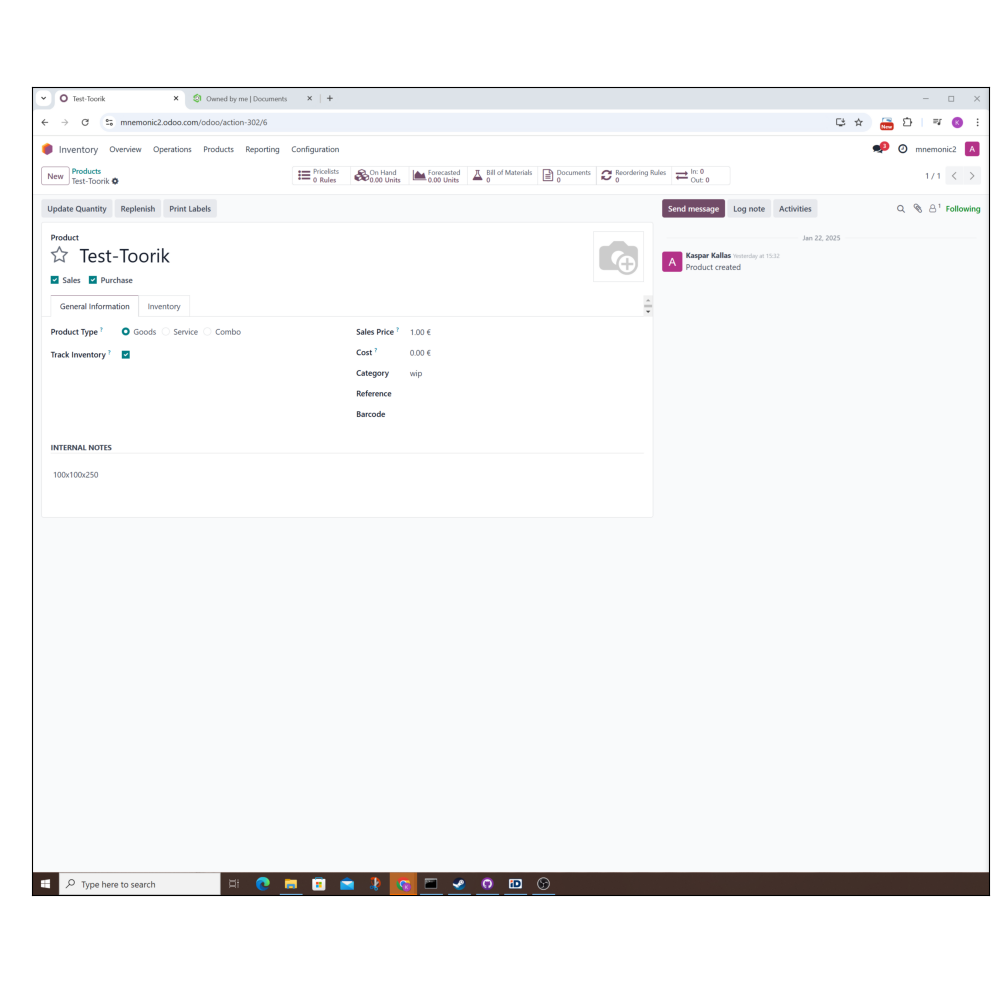

In [4]:
import pyautogui
screenshot = pyautogui.screenshot()
collector = Scraper(screenshot.crop((0,0,screenshot.size[0]/2, screenshot.size[1])))

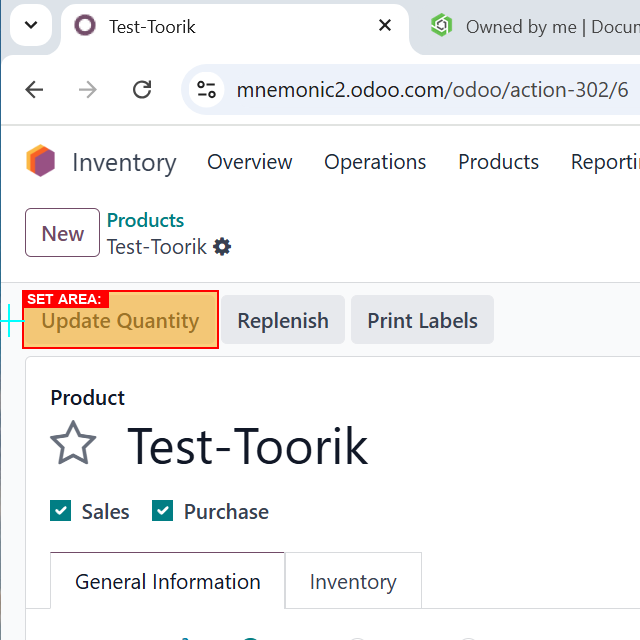

In [5]:
testx = collector.get_scope()
testx.render_preview()

In [8]:
testx.find(tries=5)

0/5
1/5
2/5
3/5
4/5


ImageNotFoundException: Could not locate the image (highest confidence = 0.493)

In [8]:
# comment: Automated step generated with pyPeriscope V2 
payload = '''gASV1BAAAAAAAAB9lCiMBGFyZWGUWLQQAABpVkJPUncwS0dnb0FBQUFOU1VoRVVnQUFBTVFBQUFBNENBSUFBQUF0bE1CZUFBQU1UVWxFUVZSNG5PMmRmMUFUWnhySHZ5RXNNRm1KWU9RaUE2SXA3VFIyQnM1TGppTlNMVDk2Rkl2dGliWXkzbUFkdkFyMVJCMlJhckVlVGsrdWxkRWlWc1VxOUViMHlrd1B2U0xUUW90TXF4d1drNkZKTFprcGFUVVhMa1FqUlUwbXVCbGdFN2svQ0NSQUFDRTVVUHQrL3NydSsrUjUzMzN6M2VkOTl0bWRMS2UzandXQjRBMThabm9BaE1jSElpYUMxeUJpSW5nTklpYUMxL0FkdmF1bnA2KzN0L2QrUC9yNys2ZC9RSVNISEE2SDQ4T0J2NzkvUUlEZnlDYlhxem43L2Z2M3VwbitmdHduTWlLTWl3K0h3K0ZnVmlETjlYRXVic09XdVh2ZGpQMStQMUVTWVVMdTkvZmI3L2ZmNjJaY2R6ckYxTlBUUjFSRW1CVDkvZWpwNlJ2YWRJcXB0N2VYeENUQ3BMamYzOS9iMnp1MDZlUFNNQlBESVR6aXVNckdLU1p5N1VhWUFxNnlJWFVtZ3RjZ1lpSjREU0ltZ3RjZ1lpSjREU0ltZ3RjZ1lpSjREU0ltZ3RjZ1lpSjREU0ltZ3RjZ1lpSjRqVWRDVE1hYW5SdlQxbTVNTzZLYTZaRTg5Tmk3NUo4Y0x6bFJyMkVtdHZVNmJwNjBuQVF0NVduRkNpQzI0Sk1zNllNM1BZcllXWVBpODQ5cm05UjZDOE1DWE4vZ2VRdWVXNUdSSGg5QmMyZDZiSzU4Zjc3b3ZBcFE2Y01rSlMrSFRIUG5qMFJrbWdLc1FWNWIrazcrM3MrTVhuRFcxVlNTOCtjdFIycmxXZ3N6OEZ5cTNXYTZvYTBwMjVlUmM3eXh5d3M5VEFtTHJxNjZhTSsyc2hhWGZVOUxrNE1BS2lKaGNjaDRadjhmUEl0TUR5KzNsZitxYnVpQUtOcGpUNHlxNU8zVGpkMEFmTU1UVm1Vdlh6SS9DT2pwK3ZaOFJka2xJMnRXbGJ4ZFB1dHdscFQydUtOSmMvMzhtVm81RU8rNmo1YmtuUGdvWjBLei93K1BhMlR5RnF6eTd4V04zUUI0OFhtSGptMUtpVjdJRHc3aUI4K0xUTjVVV0pFWEd3eWdXM0hzRTgxTWovT2hZUG9pay9MSXhzSm1ZUDZxazBXLzA1Vi9lUFFiUGNPQ0NveUkrMlBtbHFRSXlzV1N2YVU0ZGJTeVFXdGw0VXRIeXJadVRScmxqTzFzdVhDdVZ0NnNOUTVrTU9GUExWdVhreUVMQVlET1R3dmVxSEtzYnJxcWdyUXFERXZkR0cxZGVlWFpxM3BURDBEeHhOSVZtWmtwNHFBeEJtMitYTk5zQlVBbmJjNk40WTFvcEdNeXQ4U3BDNXV0cHEvcjVSbGlXY0JRcGhpNm9iaHdaZGlnM2VqMDBheHYrTEw2cTB0dEdyTU5BQlVZRWJjcUl6czFjakM2cVVyV0htOEVST21GQitMMGpxbmcrb1pIdmJ4bDZ3b3g3VEtaQUlERzRvMk5BT2F2T25sd2hmQkdiVzVldFE2SXovc29OMllNczAzTTNqMFhPZ0Zaem9mNXk1d1R6elo5c0taVURXNXN3WmtzNlpRU3dlbVBURGZQN2RsZGRFbmZ4L1VGd0hickc4djI3ZnJVbWRrd0xlWFplZVYxV2lzTFVBRmd0SmVMOHQ0L2YzZTRqeHNYaW9xckd6UkcwSHloZ0VmWmJRYk54YUx0SHpRT1hNTHdaZ3NGZkVkZUhNQVhDdmhDQWM4eFp4MFhDN2Z2TDVQclRlQUxCWHdhVm8zOGJQN09jdVVZMXo3czFkWldBT0MvK0x6WVhUc2wvWDBzRGNDdVZ2NHdpU2xRbnRsWGVsNnRZZnlFQW41d0FOaHVmZU9aL1RzcTlTTjcxMysrSzYrOFR0L254d1hzTnNQVjZ2eURGMDBESGZPZEIwVUY4b1VDdmpCb3BOYkhOSXVVTFFzQkFQbDNhdGZlbEZmVUFPajRaVk5URW1ZZ1orcFFOQ3g4b2VoRXVqZ0lZTHNhU2dwTFZWWmRWVVZkL081VUFXRFhWSllwVEhaZzRRdEYrUU0yRnZtSGZ5bHFIdUhGTnlJaEsvLzFXT0hBUEptYmluSk95KzNxOC9YRytOV2h3dVZ2bmx4dXJObFpjS29Eb2ovc0xGa2RPdmd0WTgyUlNtVTNSS3YzSGtpUG9BRFlqVFY3Q2s2MUt3NVZMcXZNZGlPWHpwOXZBd0FXTFlvYzQzRG16UDBWb0FPdXR4c2hDUjNEYUJSQjRnMTdzMWMrd3djQXNKcUtndnd2YjNmVzFTdlhEZ3NKQnJsYWxyMy9RRklJQld0cjJiNjlYOStHcHI2MlBYSGRRa1JuSGpxWjZRaGdjZG1IY21QYzl6T1cyWW9YSTgrZDBVS2hWTm9samg3dDZpdmZBK0RGTDNWNzJqd1EweCtaeERrRjZZNWxoUXBKemxrakJRQ3R2TVVDQUtxbXVtNEFvUnUyRHRud1pUbWJVMGVrdDJFcHVac0dsUVFnYUZsQ0RBRG9ET05ldTZucnF6b0F3UXZiMGdkWFZXN295alFKQUVhaGRKdjFkTjZhNkdKd1hrakVCQlp1a0s1L2MxQkpBQ2p4ODdIaEFPeDZ3NjNoZHBLTXZLUVFDZ0I0MGVrcDBRQnd1MnVFelpRSWpwV0lBZGpWeWg4SGQ2bVVqWFlnSkRINW1hbTduZmJJTkg5UnRLc3k2Q2VqNTBQWmdXNHJBL0FOT2owQWhFbWtZUzQyWEhGMEZPcmt3LzMwR0Z1YlZjcWYvcXU3ZHIzVFl1M3NucmhuUTV1V0FYRG5RdTdhQ3lQYkdLdmJoWTZtZVlCMVBLZTN1aHlMRXpXcG1XUk4xOXF1S0ZXNmRuMXJoL21lMmVLMmQ5R1RMcWxrME94Z0FJRCtwaEY0NEJBNEZvS2tOTW5aSXBXMThZb20reGt4QU9VVkJRQlJva3prZ1ZldmlJbGw3WUEzYW5lT1NPRGpSdzNmVHcwUG9FeEwrWmJEQ3BNZGdDOHQ0TTJQbEFsdlhHNmRxTjdqY0U1SHlHSWlBa2MyTHBqajdpdkNzRkJBQzdTMWFTRjF1OUoxR1g4R0FONml5QWV1RU5xTk5Ydi9la3ByQXdaU3VwRGZTb0srYmRGUGI4bWFraTZKZ2tyTnFGcDFyNHRGZHRXL0ZRQWlrK005a3FsbllxSjVOTURnK3ZWMnlJYlB0U1BHMEx5SjZpOXN0OHVaUDBZa3NOeDFUY0R0bXNvVENwTWRvdFY3RDd3U1FYRUJRSGxrWWpITkVmQUJDNEtpMW0xYUZUNkJyWVBncUdnUnREcFl2cnFrV1JjNU9wbGdsUmRWREFCdWxQVHBCL01JbU9vclRtbHRDSXpOTDhxVUNTZ0F1RkdiMjZMWFBhZ0Q3MERGcGFSV3FPdnV5TC9ScG92dUtodnRnRmkyUk9DUlQ4OXlwaWNpb2dEQThzVm5xbUVubGwxVDEyQUVnS2VmSEhrKzMrM3F0THRzdGl1YjdnRGdMUktId2hFSmdJNVc1UjBYRytaNzVUV1h6VnZhTmdaQWFNS3pEaVVCUmtPSCt3R3lOdWZuOExBRkFIQkQwM3JIdmJFYndoTFRGZ09BcWVGNFNjdElsVE10RmNlYXJRQ0VxU21PTkhiT2JDRUFNTjA5VGpQZFQyMnUzL3JQZFMwQVJFa2RTZ0p3ODZaSFNySlBiT0xHakN0T1R1SURscVlXZmV0M2FnQ3k1NWNHZXpJTVQ4VVVJRXVPNHdGZzVNZmZLbTNTM2JLWXpKYk9hMDFsdXc3WGRRUGdwYjRVTzJMQkFuTzVwRlRGREJ5WVdmUHhpZHBPT1BPKzRCaUpHQUMwWlFlcmRRTy9CNnV2S3o0cmR6TmZ4cllmTFFNV2hxcnlVeVBGNUR1dzdCclVyVVBhcFdReUdSZUF0cXl3VW1rZU5HUXRyWisrLy9HWWQ1QjU4YSt0RVhFQldCdUxkMnc1NFRoR1U3dW03a1JCWnJIQ0JDQW9NWGZ0WUJZZXRrREVCV0Q1NHV6RlRoWUFtQitxanRSWjNEaSsxcVladUROalZwV1VLY2JxZmx4OC9iZ0E4SzJ5ZGR4L2toelRUUFRzTWlIUWViV3FSbUVGTnlvaFp1UnZOZWtCZWZaMVN2cDZadklQeHh2TU1EU2R6bTBhMWlaSzM1MDkrdEpBRUJHa1BwNngzamM0RUNhekRRQzRjMS9kdHNxUjl3bFN0cVFydGxUcDBWNmJtMWxMVWI0c2E4UEMyUGd3UmVPTlFROWhVZEtRYWwwWDVHVTdNcXI0ZmowV0V4VWJINlZ2ZEMyYUlDUjY4VnkwMzhhMXMyK3NyNlo5cER2K2tTVU5pTjI2dmZYSFlvWHAxc1hDVFJmcElQNHNydTN1SFNzTHhPZU5mWWhoS1NWRmZvWHZWaXJOTnNPbDA3bVhocmNHUk9VWFo0aUg4c1dBMkxTa1NubURsYmxhK2Naci82UURiRXdQTHo1T3JHdDJYaXhHL3lZS3pXcDBYY3ovazBMSXg5MDcxdkE0U1hpenlqRFJYSTlpa2ZUWGFGQ0JhVHF5UnU1TGg3MThxR2lGY0ZKbUM1OWYrVlJ0MlRXTkVxQ1RVbVFCa3g3QkNEd3VEZENTbktQN0M5SWw0cUJCWFZLOGNIRml6cnVIWEFvOEx2Q2tlZTl0VGwzb2Q4OXNBM3pweUtYNXhZWHJubksyaDYvZWZYTGJVbkdnTHdBV2Z1S0VySk9GTHoweGJKZ1I2d3EzdlNxZVN3R00yZXEzTURIL3Zhem5SbVhVb2pWNStRbWhOQmV3Mi9vQ0hJVTdPaWFyN0hEV1N2RmNtZ3ZHYk9rMDk4MEtpMXladlRkYk11NHh6azhzS0QxVWtwMFlIVFpZL0tSNHdvSGo3VkdmTEs0M3VKenk0c3lDL09XUlFncUFyWStLU04xZWtMdGt0cXN6YXRubVk5a1NVUURBV2p1WjJYSHJkLy90bFFWVGlnbVVMR2YzaHNWektRQ3NEVHczUmN1SnpQaExsZ3lrSVI2Vmw0Wncvai9UWFpPN2FPdzluTGRURHJvOWdSNDlERisrWDFDaE1RRUlrdVM4azVVOHo5TmxZdm94MWUzZmNFYUxrQlVsUjFkTnVTZ3dKOWhSTXlNM2VxZE8rUEkzaisxS0RPY0NabFZwM2xzbGwyYnNZWlNwb3EvOVFndEErS3pVay9MU0VJL3JJeWpUQkMzSk9GYVpNZE9qbUJxc29hcmlYQmRBeDJhblRhR003d1lpcGw4Z2pydDFBQUJlL0tZTXFjZXA5d0JFVEw5QWZQMjRnQjMwdktqMFRWa3J4V05sN3BObStoSnd3dU1LU2NBSjNvZUlpZUExaUpnSVhvT0lpZUExbkdMaWNEZ3pPQTdDSTRxcmJGemVWVUMwUkpnOHJySnhpc25mMzkrSEJDZkNaUERoY1B6OS9aMmJRNThDQXZ5SWxnaVRnc09CNjd1ZGhpWGdzd0pwcmcrSHhDZkNoUGh3T0Z3ZnpxekFZVTlsYzBhLzhKbThiNDR3RGcvNnZqa0N3Uk5JblluZ05mNEhPTFRLMXFXemlHTUFBQUFBU1VWT1JLNUNZSUk9lIwNY2xlYW5fcHJldmlld5RYNBsBAGlWQk9SdzBLR2dvQUFBQU5TVWhFVWdBQUFvQUFBQUtBQ0FJQUFBQ0RyMTUwQUFEVUxrbEVRVlI0bk96ZGVWeU0rUjhBOE0venpOV2hkRWVGSWlwa0tVY2lLa2M1dGl3aFY4czZGNXNyMTdwK2ptekkxV0lkYThYU3NtSnBIVG1MU0tpV2NoUlJkS2ttcFpxcE9aL2ZIMU5qcXFtbVRFMzR2Ri83MnBlZTUvczh6M2VlNTVuNVBOL3pJYnBNM3hyMnYrOEJJWVFRUWsySVZIVUdFRUlJb2E4UkJtQ0VFRUpJQlVnQ0NGWG5BU0dFRVBycWtGZ0VSZ2doaEpvZVNZbFZuUVdFRUVMbzYwTVhVMVREdGlSSlVrT05xYzVpTWhrMEdvMmtrU1JCMUYyYlRWR1VTQ1FXaWNWOGdaQmJ4aS9sQ2NSaUpUOENWR1NNd1dEUTZRcG5EQ0hVM0VoK0xvUmlNWjh2TE9NTHVHVThzYmlCdjFjMWsvdzRpQ2tnQ0lvQ1Fyb0VvVVpIYjhETlJoS0Via3RON1JZYURiaFBDWUtnMDJsMG9MR1lEQzFOZFFxZ3FKaGJVTXhSeXZkS2tyR1dMVFErZlZjSUlaV1QvbHlvTVJuYW9BNEFoY1hjd2lKT2c0c05sWFlPUUZGQUVSUWhPVlRGL3hCcU1uU0NyTjg5cDZXcHBxZmRna1pUVHRzeEFkQlNTNk9GaGxyK2g1SVNidG1uN0VwVG5XV2dxMFhEUm0yRXZsdzZXaHBhR21wNWhjWGNVdDRuN1lnZ0tERUYyQWNWcVJSWnJ5ZEpIUzBOUTExdFpVVmZLUnFOTk5MVC9wU1NxNjYycHJGK1M0eStDSDN4YURTeWxYNUxIYTFQcWVnaW9MeTJHU0ZWb29QQ2xUbUdldHBhR21xTmx4VjluUlowT3BsZldGTGZEUTEwdExSYnFEZEdsaEJDelpOZXl4WTBXa04rTGlnS0NFTHBEY2tJTlFTcFlMTkh5eFlhalJwOXBVZXBiem00cFpZR1JsK0V2a0lOK0xrQUF0dDVVVE5DQWxGM3RhMDZpNm12MDZJSmNnTUEram90MU5XWUNpWldWMlBxdDJ5aWpDR0VtaHQ5blJicUxFVi9Mb0FBd0tJdmFrN3FqcjRFUVJqcGFUZEJWcVNNZExVVkdUalU5QmxEQ0RVM1Jub0svVndBRUlCekhxQm1oaVRxYWdOdTJVSmQ2YjJ1YWtlamtkcWFkZGNxdDJ5aGdiMnVFUHJLMFdoa1MwVWFvUWdjMzR1YW5icDdRYXRrV0swaVhSd1YrdFloaEw1MEN2MUcxWCttQVlxaXhKUUlBRVJpMGRNUER3NW1yTG1XZDdLSVh3Q0FWZGxJT2Vyb0JjMWlNcHE0K0N0Qm81RXNKb1BIRjlTVW9NRVplNStUejg3S3pjdks1WldXQ1FRQ0FnaVdPa3VqaFNaVGpXbGsxc3JBMUlqQllIeEN4aEZDVFkxR0kxbE1Pbzh2ckNrQkFVRFZwL2hMVVJRRkZFbVFCTkRlY2xMaWlxKzlMSHNzRW9vK2lOalpvdGVkV1E3ZHRRYlE2WFFLS0lxaVNBVzYwU0FrRjczMjFacnFyS2JKaDl4RDF4S0FOUlh1cUFVQVlyRVlLRW9vRUluRjRveVV0ODhlUG41NlA3R3NwSlRGWkJFRXdlV1ZHcG9ZYWVscWRldG5wOTVDWFVPckJaMU9JM0FDUzRRK0h4cHFyRm9DTUFXVTRoWFFZa3BNRWlRQlJESC93NzNDeTBtQ0IzeXFsT0lESFpqQ01zSExza1MrTHJlN1ZnOTFybkVwd1NjSVFneGlBZ2ljMGdNMVFCMGxZRFdteW9xRHRSK2F4VkkwWXhSRmtTUlprUHYrMWRPWFYwNzh5eTNpQ0FSQ0FBcG9CRS9JQndDU1J1Ym41TC9QemM5Nm5YbjdmRVQva2M3VzlwMk4yN1NtS0Fwak1FS2ZoZHAvTGhRTXZ4UkZpVUZNSTJobHd0TG5KZmZ2bDF3cklkN3pTd1JNa2tXQXFFaFlxRW5YOGpTZFBLYlRGQnBCdnl1NC9pVDNhVS9Od2Jvc1F3Q2dRRXpnNjlWUlBkVlJBbFpKL2JNaWg2WXJuREd4U0pTYm1ac2MvelRsOFl1U0Q4WDhNajVGVVFCQUVBU05SZ01Ba1Vna1dTSVNpc1JpOGJQN2lXS3htS1RSOUkwTkNCb0dZSVErQTdYL1hDajROU1lJZ2dhMGxKS0VXTzcxREg2S29FeElFOUVZTkNaWHdCRUkrVDJOK250MG1OQkJ4eXE1NE1tRjFGT1A4dTVydG16eHN2UlJkL1dCUGJTZDFlazRCVDJxTjNydDQ5SlYyTTI0OWtQVGFUUkZka0pSbEVnb2ZQM2s1YU03OGZscE9RS2hnQ0FKa3FBUkJEQ1lES1lhRXdCNFpYd2hYMEJSUUZGaUFWK1E5ZUt0R01RdDlYVjFESFFJa29HRllJU2F2enArRUNpRmFvamY4M0x2Rm9hbDhCTUVGQjk0TkRvd0JBU2ZXOFl4MVdqbi9jMTBleU5IQUhpUUUvWHI0NDFjQWRkWXd3UzQ4SUY0SHcwWGtyaHhmYldIV1d2WjQ4OEZxcGM2NGl0WnoxYzFLRkh0aDFid1JoZUpSRnhPV2VRLzE5Njl5ZVFLU2dtS1lLbXJtVnEybWJCb3F1LzI1VDhmMnZUem9VMStRYXVtcjUxcjFxRU5TMDJOQUlJcktFdC8rZWJ5bitkRkFqRituYXJMenM0Mk56Y1BDd3RUZFViUVp5a3pNM1BzMkxFcEtTblZWNldrcEl3ZE81Yk5aamRndDNYOFVpbjJQWDVVY0NkVlBWRlFKaEtYZ3BnU2Z1QzlwNHZwWXpyNEJBdzQwRjNINGM2ZE82bHBxVjExN0JaMFcyZXIxN09nTEw5VXpDWEVORkVKOVo3SXVsZDJnU3NvYWtET202ZTVNM3d1WFRndmQ5WGFsVXRPSEQzY3hQbXBsOTNiQTNadkQxQjFMaFJTUnduNGM1ZWIvdTdWa3hjbEgwb0VmQUVBcUd0cDJQVHFhbVhYMmF4REcyMDlIUWFUQVFCYXV0b2tqVGJBd3pVcC90bnpoMDg0SlNVQ3ZvQlR4SG54M3pPemptMzFqQTBVT2REcTFhdVBIejh1ZDlXOWUvZGF0MjZ0eEEvVjlFZVVIS3VSUGdqNnFpeGV2UGpodzRmZTN0NG5UNTYwdExTVUxrOUpTZkgyOW1hejJiNit2aUVoSVNySkcwblFCQ1ZDZ2dJS3hFS1JvTC9KRUkvMjNtWXR6Qk1lUHo3eno1bUhEMko3OXV5NWR2WGFucTM2MmJWeUNFLzlKL3pOV1k2b21BNE1FUS9FRkRUczlRNjd0d2NrUDM4bS9mUDc2YlA3OU8ybnZNK0VLcmwvNys3Und3ZXFMRnk4YkpWbEp5dVY1S2NlTDJPbzA4T0hEL2Z0MjdkLy8zNFdxMnJmYVI2UE4yZk9uTGx6NS9icTFVdFpoMU5FYnNhN3gzZmlCWHdCSmFZWVRJYXVzYjV0Mys1ZCszd2ptNGJCWk9vWU1Ic003TVZrTVhQZVp2UEt5Z1I4Z1lEUGZ4YWJxTlpDVGNFQXZHblRwazJiTmtuK2JXNXV2bno1OGg5Ly9MSEIyWTZMaXhzelprenRBVSs1UjBTb2FRUUdCazZZTUNFakkyUENoQWwvL2ZXWEpBYW5wS1JNbURDQnpXYWJtWmx0MmJKRmRibWpDSklBRWtwNVhCK3J1VVBhamNySnp0bDlaSGYwbldnNm5UNWh3b1FoUTRaY3ZYNzF2MGYvRFhjZk50ek82eHZEM3Y0UC9QaGlIbzJnVWZVYjZBUUFrUElpZWNkV2Z5dWJ6dnQrUHlaWjhqNmZ2WHI1NHBqb3FBVkxWaWo5c3lHcFRWdDI2T21YLzdCTHJnSUFTSzlDVXlLVkZZQ1RrNU9uVEprU0VSRXhiZG8wSHEvU3F6ckx5c3FtVFpzV0VSSGg0K09Ubkp5c2xNTXBTTURqRjc0dklFbUNBSUtpcU9GVFBNMDZ0Qk9KUkdKeHBWbnB4R0t4U0NReWJtc3lZTlFnaXFJSUlBZ0NFbUllczdNYVVodjI2VEl6TTFWeTNKcHMyclFwTFMwTmk3L28wN1ZwMCthdnYvNHlNelBMeTh1Yk1HRkNTa3FLSlBybTVlV1ptWm45OWRkZmJkcTBVVlhlQ0NDQkFvb1NBd1VkOUt5TEM0dCsyZXAvNys0OWUzdjcvLzN2ZjFPbVROSFgxMy8zN2wxeVV0SzI3ZHZ1MzQ4eGJkR1dRVENGWWlGUTlZNis3L1BaTzdiNmp4dzFSamJXNnVrYjdQdjlXRDQ3cjVuWDhYNUpMRHRaN2Z2OW1JR2hvVXBxclpYV3g2cERodzVPVGs0QUVCMGRMUnVEZVR6ZUR6LzhFQjBkRFFEOSsvZnYwS0dEc282b0NHNEpsMTlTUmxFVVFSSU1GdFBReEVoVFM1TkdvNUdWZTNpUkpFbWowYlIwdEV6YnQyR3dtQVJKVUJRbDVndEx1YVZObVZ1RXZnYVNHR3hvYUppWGx6ZHUzTGl4WThjMmgrZ0xBSHhSbVVBc29BR05JQWdoeFJjSWhPL2U1ZlRwMDhmUHo2OWp4NDRpa1lnZ2lCOSsrR0hxMUdtbHBUd2VUd0FnRmxOaUdrbFNBRlE5WjhlNmZPRzhnYUhoOEpHZTFWZU44Qmg5TityVyszelZQUDEvblh5bXpVcCsvaXpsUlpPV0QwR0piY0IwT3YzQWdRUHo1OCsvZE9tU0pBWUhCd2RURkRWdDJqUko5QjArZlBpZVBYdklwdTFXWGNvdHBRU1VXQXdrU1RKWnJKWUdPclNhZTB1eU5OUU0xWXlZTENhL2pDY1dBNHRHRXdwcW5BbWtYaVJWeXBKL0R4Z3c0Tml4ajNVZFBqNCt0Mi9mbHZ4YlVvM3M1T1NVbnA0T0FIMzc5cFV1ck84UnM3T3pKWnRMQkFVRmVYaDR5Q2FRYlVKdTA2Wk5WRlNVZEpXVGs5UEFnUU5OVFUyM2JOa2lXZlhiYjc5dDJiSWxMUzJ0bG84bWR5MUNja2xpOExoeDQ5Ni9mdzhBdXJxNktvKytBR0N1WlpuRy95LzlRd1pCVVdLeFdFZW5aWWNPSFNUekFRZ0VBanFkTHFrODA5TFNJZ2pKTUEyU0lBZ3hBSjBnNmp2VjlOMm9XeU5IalpHN3FrL2Zma2NQSDNqNUlybGpKMWk5ZkxGc3EvQ0pvNGZ2UnQyU1ZwWktxazhYTDF1bHA2OHZTWm1mejc1dzdveGtyV3hGSzhqVXRRS0FsVTNuS3JYY3NrM1JpNWV0cWpQL2N2ZDI2Y0w1QytmT1ZEbXVwR1JadlZMOXhOSER5VW5QZktiTmt1NUgwaFlyelltQm9lR0dYN2JMYmlMWnYrVGZJMGVOa2Z2NDBqQ1NOdUFYTDVLa2pjR1M1Z0JwZ3VwdDg3S1prV1JWZWpta082bXlaTzNLSlZiV25YWDFEYVFiMWpFT3VGNUlrdHk3ZCsrS0ZTdE9uVG9WSFIwOWUvWnNnVUFnaWI3ZTN0Ni8vUEpMMDNjcUpnaUNrcWxqSitxYU5LNXk0a3JiTmxoWVdKaXZyKytaTTJmczdlMEJ3TW5KeWNmSFJ4S0RuWnljTEN3c0pLRXJPenY3M0xsekFCQVZGU1hacE1HZG5pU2JTNE91SkVZK2VQQkEybVlzcWF1UWhrd2ZIeDl6YzNQWnc5MjZkV3Znd0lGMXh0VHM3T3d4WThaTW5qeFp1bWVFRk1SaXNhVGZyMll5M0tDMy9nQm5nd0dIeVY5dlpWem1pd1FVUWZrdThCWHloU0tSU0ZKeWtHUllNb1V0VWZGMlE0S2k2dHVRSnluZGR1cGtYVk1DQTBQRGxCZEpmZnIyczdMcExQbUhaSGx5MGpNQVNIbVJMQTBZQm9hR2xwMnNKRHM4ZXZqQXlGRmpKT0Y1OS9hQTFjc1hTME8xcFBPUmJDVFl2VDFBR2hUWHJseWliMkFvVFR4M2hrL3QrVTlPZXNabTU4bW1sK3h0K0VqUEMrZk94Tnk3S3cyTjcvUFp5YytmMVJUUjJYbDVGLy85UjdLZkUwY1A3OWpxYjJCb09NSmp0Q1JqYzJmNG5EaDZlTkwzMHlXSlpSOCtwTkZSaVRIWXlxWnpRVVd0ZytSMFNZT3VKSTZtdkVpU1prYnlsQ0E5QTRvM0dVZ2V2Q1FicmwyNVJNbmxVWUlnQWdJQ3hvMGJCd0FSRVJGMzd0d0JnTW1USjZzaytnSUFuY0VRVVNLU0JFb3M1dk40ZVpudmVOeXltaElMZUlJUCtZVjhIcDhTVXlRSkJKMVExMURDK3g1OGZYMlhMMTh1aWI0QXNHdlhydHUzYjhmRnhRRkFlbnE2bDVlWFpIbnIxcTJWMVl0S2NrUnBrZGZlM2o0b0tPajQ4ZVBaMmRrQThOdHZ2NlducDhzV2VZOGRPOWFtVFp1OWUvZks3cVRPbUNvcFpBOFlNQUNqTDZxdjlQVDBDUk1tRkJRVTZPcnE2dW5wdlgvL2ZzS0VDWktLSHhWNnlYM0dKd1J6YlpjdjZiSEp1RVhyM0p5OG5UdDJwcVdsU1pxb0tJcGlNQmdrU2RKSW1sQWtGSXFFNVlWZWdnQWc2bHNGcmFDT1ZqWjNvMjVKL2kycElMV3k2ZnppUlZKNWhwT2ZXMWwzbGlidTV6UlFHcENtVEowQkFQZnYzWlg4S1luTjBwS1piSTNycFF2bjJYbDVzaVhVT2t2QTFkTkw5OWJQYVdETTNkdlNWVEgzN2tvZUVXcmFsU1NmQURCc3BDY0E2QnNZU3A4MlJvNGFJM25na0h6MnUxRzNwQm5UMHpjWU9XcU10QnlwZEpMVEpjMkpaU2VyNzZmUGxyWUxYTHB3UHZuNXMwMWJka2pUU3dOem5XVGJIVVo0akZaK2hUQkJFRnUzYnAwOGViTGt6eDkrK0dIVHBrMnFlc0pWMTFBbm1IU0NJQ2d4SmVEeHMxNm5GeGNXMWRRSmkxUE15YzNNRWZENGxKZ2lDSUtwcWFhaCthbXoyMGdDN2FoUm82UkxKSkZZMHMycVRaczJ2cjYra3JoWU8zTVprdktyNGtjRUFFbm44NGNQSHdMQXZYdjNwRmRIYXVEQWdiZHUzWkw5czg0c1NhS3ZiSFU2UW9xUVJOK01qQXhEUThQVHAwLy8vZmZmaG9hR2tuN1JxbzNCY1RuUnZ5VDYzY3k0MU51b2Z5czFNelZORnAvUDM3Smx5K2JObTVPU2traVNmUFBtelpNblQ0UWlvWWFHaHE2ZW5naUVrckl2UlZDTjlMWkRTU2xaRXR0ZXZFaXlzdTdjMGNwR0d1R1Nuei9yMDdlL05MR2xUSkc2U3VVekFEakkxS0JLSW1KK1Boc0FYaVkvNytkVTZmdGU1NWdjdWVrbGUrdlR0ejg3TDAvYW1CcHo5N1pEdndFMTdjZkEwRkNhVDhrL09sclp5Q1pnNStWSi9pRXQ2MHRYU2M2TUVsdks4OW5seDZwK3VnQ2dZeWNyQUhqNUloa3F6cGpzR1ZhYzdBT1R2cjRCblZSc1NxbjYyclJwVTh1V0xRbUM4UFB6YTR6OUs4akF4TWpXb1h0ODVBTUtLSUlnYnAyN09XVDhNQU1Ub3lySkpQVkxtU2x2cnAyNlRCQUVCWlJZVE9rWTZqRS8rVjBVa2tBcjJ4d3J1endxS3NySHgwZVJ0bDdGVzFqbDlxQ1dyY3BPVFUxdDI3WnRsUVNtcHFZSzdsL0MxOWNYQURENm92cVNqYjdTWVVoLy9mV1g3TmdrVlRVR3F6TTA4c3ZZUjU0RlJXVmVHZFYreWplR1BRUDh0NXo5OTB6NHhjdnIxNjhmT0hEZ3ZYdjNldlhxTmNacmpQOEcvL2FXN1V2NFJYUTZIZmhBRW1TOUtxRWx2OTJ5TFk1VnNQUHlSbmhZQTRCbEp5c0RRME5KeXBpN3QzMm16ZExUMTc5dzdzejdmTFlrR05RZUxDVkJVZkovMlJiTlNtdlplUVlHaHZYSWZhMWtNNXp5SXBtZGwrZWdqR0hOQmZsc2RsNWU5YnJ4OS9uNURRdUUxVW5QZWI2OG9DNTdGQ1dlTVhyajlZcGF1blJwSSsxWmNRYXREVHIzNnBvWS9aOVlMQklLaGU5ejhoUHVQZUx6K0JaZExEVzFOUmxNSmdEd1NzdUszbi9JU0htYkZQL3NmVzYrVUNna1NJTEJaSFJ6N0dGazF1b1RNeUFKYkxXMDVrcGltS1RWTmpNejg5T3JjK1dHVXRsQ3RvV0ZSZlVFOVIzNEZCUVV0RzNiTm5OemMreDdoZXJGejg4dkl5UER3TUJBR24wQndOTFM4cSsvL3ZMMjlzN0l5UER6OHp0MTZwUks4aWFpaEV5Q3dXQ3lVajRrYmY5dmRkOVdMc010dkNhTW05Q3ZUNyt6NTg5ZXUzYk4zTUxjeGRXMWRhdld1V1ZaN3pnWmV1cUdZb29DQ2lnUkJVeEtSSW5yUGtZRlNWV3QzQ1pNU2IxeHg0cklhbVhkK1dYeTgvZDkrN0h6OGlUaDFzRFE4T1dMNUpRWFNWVktvalhSMXplQWFuMnlsS2hLTWRTaDN3REpSN3QvNzQ2VlRXZWxIRlJYMzZCNm55d2xrcHh6U1oyenZyd01OMUtuZEZJcC9ZeWFMVDFqQTZzZU5wcmFtZ3dtQTRBb0xlRStpWGtjOVc5RVRucDJjVUdSZ0M4UThBV0YrUVVacjk3ZURydjVKT1p4YVRFWEFCaE1Sb3VXTFd6NzlqQTBOZjdFREppWW1FQkYzVzh0UER3OEprK2VMSzBFcm05NVZKYWtpbHZTbjB0S2tnRkpxM0Rmdm4yclQ2RjE2OWF0aVJNbjF1dEFVVkZSYmRxME1UYzNiM0JXMFZkb3g0NGR2WHIxcWpJTkZnQllXbHFlUEhteWUvZnVPM2JzcUduYnhzWWsxSUJCOEtCVWk2R3RRZGVNeXI2MitjSFNrT2NIRGRyb0wvUmQrTXZtWC96WGIrN1N1Zk8xTitkWDNaMmJWSkRJSUZpU0Z5Mnh0R2hNU3AxRjFxUENiTmhJVDNaZW50enBIaVVOa05LNDFhZHYvK1RuejJMdTNaV0dXeXZyemlrdmtwS1RubG5XM0kxTGxwNitQbFJVbjFablpkMVoydFFxSVcwNXJrbVY5REV5MFFzQUhQcjJrOVJDMzQyNk5lTGI3eFRKWVozMDlRM1llWG1ORkFYZjU3TWw1MXp5cCtRcEo2YnlTWkNjUGNsbmRPZzNRTm93TDB0eW5tVUwwSElMMDdKSUVaOWZ5Mm9WaG1leFdBbUhwaWlLUnFlNVQvWnMwOUZjZzhHaWdPS1ZsYVdudkQyOFlWK2dyLy9tbVdzMnoxd1R0R1RyWHp1UFpyeEs1NVdWVVFTbHdWQnYxYzUwNEtqQm1scnFOUHFuMXMrM2J0MTYrZkxsdnI2K2txWlpDVWtqYm5aMjl1clZxNlVMSlIyUEpmOVdNR3pYWlBueTVWdTJiSkZPMXh3WEZ5ZnBsaVg1VTFMUkxkdVE3T1BqazU2ZTNvQXVZSktlWEJpRGtlSk1UVTFQbno1ZEpmcEtXRnBhbmp0MzdsT2VQbXVpNE85WWI3M0JBOGpSdWd3ajBCQ0xDYkVPUTA4RXduL2ZudnI1OW84MzMxNjBzR3FYSVh5MUlXYlJzYVI5eFlJUFRGS05BS0MzSU5YVjFUdFRUcDRHczFpTWV2VFoxTk0zK0g3NjdBdm56c2gyb0gyZno1NDd3OGZLcHJOc3liZzhIdHk5TFEyM2ZmcjJ2eHQxaTUyWDExR3hDUlFsWFphT0hqNGdPODUxN2NvbGtuOUlIZ1drMDFCSW9sSHRPMlRuZlp3cUpPVkY4b1Z6WjJTSFZPbnBHMWpaZEQ1MjVHRHQzYS9xUmRJaFhMWVdQZVZGc2xLbUs3bDA0ZnpxNVl1ckRHcVM5UENTUG9pa3ZFaVdqZENTbE5JVENCVzlvUFgwRFF3TURTK0duWlVzVk9STTBvbGFxNkJGWXJHQzd4MVNPcEc0SHZVNU5TRUlna2FqdCszVXJxamdBMG1RYjErazhubDhNU1VFQUpGUUpPUUpRT1oxaEFSQk1OV1k3YnAwc1B5bVUvdXVIV2wwdWxMNmpra0NtM1FjTUFDY09YTUdBRnEzYm4zOCtIRnBZVlIyTUk4MGJFc0NaMzFENDQ4Ly90aTdkKzh4WThaSVdtb2xSNVIyd3dhQXRMUTB5ZEFqeVo4REJneG9jRTF5V2xxYXBHdFk5YUhHQ0RVVENuNk5HWFNtdlo2THBjWTMvM0VpSDR1aUJMUXlzb1NteTlRdjRMTVBQOXNaa1hIcEhUZXpWTVRSWnVvVThZdElHZ2tFdENHdE91czZkTkR1Mm9CYzllbmJyMC9mZm10WExwRnQycFE3TDNFL3A0RjNvMjdKZHNvRmdIclY3a3BpaG5URUxjaDBkZGJUTjlpMFpjZnE1WXNsMlRBd05OejMrN0hhUnlMMWN4cW9xMjhnVFZOOWpPeUliNytUelBPbFlQWVVzV0RKaXQzYkEyUXoxdURKSTJVRHVlVHpWa2t3ZktSbnAwN1dPN2I2U3lOb2xldXk3L2Rqc3BtUlZrNXMrR1g3M0JrKzBqTzVlTmtxMlhOZUhkRjFldUQ1LzAycGFiV3BrUzZyMWpkZE41NHluaUFycjZDbXRlM05xbmFrcW9sa0hIMU94cnVrdUdkMy9yM0pMZUlJQkFKSjE4WHljUU9TbVNlQllERG9HdHFhUXllTjdOQ2xvNTZSdm1SREpYd1NoRkRqZTUyUlc5TXFTc0gzRVFLSUtSRkowQURnSGVmdC9hTHc1TEwvS0lJaStBUkJrQnhCTVl1dXhpU1lmSXBQcVlzbW1jenRvdGF2b0xTSVFXZUtLUkVCSlA1Y1NFbkcwVFplcTNQdGFwcjZveG1pVTdVV05Ia0NvYW9DTUY4b1ZNcCtKUE5wR0xZMjFISHIxNzFmajhmUi96MitHMWY4b1RnL00wK0RxVTRCeGVQeldGcHFOcjF0dS9UOHhxcUhEVWtqNlF5YVdDeHU0a203RUVLTmhGQTAvZ0pKME1TVW1LTEVyVFRiZW1yT2VsbjArRzdCSmJiNkc3RlEySUxTRW9HSTBoQnBpclZzMWZvWmlqdVZDTW9rMFZjU3M1RlVUSFNVc3JwZmZkbnFtSXFTVzhyVDFsVENaQlFOd0MzbDFaMUlNUVJCRURRYWkwYWowV2lXdGxiYXV0cDhQciswbU1zcjVWRkFNUmdNbG9hYW9ZbVJmaXRETlUwMVpSMFVJZFJNRUVROVpza2dDUklJVWt5SkNZTG9xUDFOV3cycnA4WDMvK05HdktmblVEeXFBOTIrVnd0WE04ME9NdWt4K2xaeS85N2RLdk5Vb0pyVUVZQkxlUUt4bUtyalpkZU5RQ3ltU25tMTlRNXJHRHFEYm1KaGFtS2gvRjRlQ0tGbWl5SUlFTmZ2ZGIwa1FRS0FtQkt6NkdwMnVnTTdhTmpHZmJpaHA5bnFHOTMrQkVGZ3FWY3U2ZHQyRnk5YmhjVmZSUkJkZnRnV3RyNjI5bmE5bGkxMHRENTFRcWo2S2l6bXZ2OVFVa3NDeGR1QUVVSmZnMXJhZ0FFQUpBT0dFR3BPU0tpcnMzRmhFVWNwSFpJVkp4S0xDNHM0dFNTZzBiQjFGaUZVQ2EzMlRoc0VRVFhLYk0wSU5WemRrVXhNVWJudmk1b2dLMUs1K1VYaVdzZnRxV3BrRkVLbzJhcmp1WndDRWt2QXFKa2hDUVdDV1drWnYvWUtZU1hLTHl5cHMvV1hqaVZnaEZCbGRmNHNTQWI3TjBsZUVGSUlXZnRFSEZLRnhkeGlUbWxqNTZhSVUvcWhoRnRuTWlaRG1hOHhSZ2g5QVppS0RKaWtLS3lJUnMxSFBlYUN6aXNvem0vTWNqQzdzSmhkVUt4SVNnMDFadU5sQXlIME9kSmdLZlN6UUdBcEdEVWJkRW9rVWp6MWgyS3VVQ2pTMTlGU2JpV3dVQ2pLLzFEQ1VXemdMNDBrVlRVM0NFS28yVkpqTVVpU1VHUU9lYXJpL3hpSmtXclZNUmQwZFp4U0hxZVVwNldwcHQxQ2cvWEpWY0U4Z2JDb2hGdk1LVk44RTAyTlQzMUhMMExvaTlSQ1hhMUk0Wll5QWdBSWdoSlRXQ0pHcWxMSFJCdzFLZWFVRlhQS2FDU3BvYzVrTVJoTUJwM0JvTlV4REFBQUFFUmlzVUFnNGd1RVBJR0FXOHB2d0FBbkhTM05CbVFZSWZURjA5SFdVRHdBQXdCUWt1aExBQUZVeGR0OEZaMjFFcUZQUnYrVUZ3Nkt4T0ppVGxreDFLUDgrb2xhYW1sZ0YyaUVrRngwR3ExbEN3MUZPbkpXUmdHRmNSZXBBQW1xZStOdmZaRWtvZHZrYzNJaGhENGp1dG9hSk5ZcG84K0Vvc09RbWdNanZaYjRoaUtFVUMxSWtqVFUwMVoxTGhCU3lHY1R6d3gwdFhEMEVVS29UcHJxTEFOZExWWG5BcUc2MVdNY3NBb1o2TFJRMVZzUkVVS2ZIVzFOZFgyZEZxck9CVUoxb0VOOXhnRTNQWklrV3VucnFMRnc0QzlDcUI1YXR0QmcwdWs1N3o4b01qSVlJWlVnb1JtM3FyYlFVRE16MXNmb2l4QnFBSFUxcHBteG5xYUdtcW96Z3BCOERSd0gzTmdZZEpxQnJwYTZZblBMSVlTUVhIUWF6VmhQdTFSVGpWMVFMQkEyNjlvKzlCV2lONnZwMkVpUzBGQmpxYk9ZV3ByNDBJb1FVZzUxRnJOTksvMWlUbGtwajg4dDQyR2xOR29tNkRXTkF5Wkpvb1c2bW9ZYWs4R2cwMmdrRHExRENIM1d0RFRWOE1rZU5TdHlBakNOUnVxMDBOQnVvVTVnMEVVSUlZUWFSOVczS1dpb3M0ejB0TEc4aXhCQ0NEV3FTcDJ3ZExRMDlGcmk0RG1FRUVLbzBaSFNBS3lsb1liUkZ5R0VFR29hNVFHWXlhRGpCS29JSVlSUWt5RWxvNUIwdGZFbHV3Z2hoRkRUSVFHQVJpTTExVm1xemdsQ0NDSDBGU0VCb0lVNmpvMURDQ0dFbWhTZEFBS0x2MGpwUkdLS0w2VEVZa3BNVVdJeGlLblA0clZiQ0NIVWRPZ0FGSk5aZFRRd1FnMGpGRkY4b1pndndNbitFRUtvRG5SS0xNWnBOOUNuNHd2RlhKNUlMRloxUGhCQzZET0JaVi8wcVFRaWlsc21FbUdaRnlHRTZvTU9SUE45SHpCcS9qaGxJcDRBaTcwSUlWUnZkSHpqQW1vWU1RWEZYQ0VXZkJGQ3FHSG9GT0FQS0tvM2daQXFLUlhpcllNUVFnMUdCK3cyZytxcGxDY3E1ZU50Z3hCQ240U09CV0JVTDN5aHVNN29TeU1KQnAxazBJQkJyN0dIZ1VBb0ZvaEFJQlEzV2lVMlFWRVVOckFnaEpvdE91QXZGRktZVUVTVmxJcHFTVUFTaERxTFpESHE3dG5Ib0pNTU9nQ0w1QW5FcFh5eEVnY09Fd1JRWWdBQ295OUNxRm5EWHRCSVVXSUtpa3VGTmEwbENGQmprR3BNV24zREhvdEJNdWxrR1Y5VUpoQi8rbXhaQklDWUFneTlDS0htajQ2L1ZVaEJuRkpoVFFHU0lFQlRqY2FzdWNLNWRnUUI2aXdhalVad3lrU2ZHSU1wd0RvZGhORG5nUVJzQkVZS0VJb29nVWorclVLU2hKWTZ2Y0hSVjRwSko3WFU2UTJlbHcyZkpCRkNueGNTNHk5U0JKY252K21YQUdpaFJxUFRsQlA5NkRTaWhYb0Q5NFhkK1JGQ254ZHNBRVoxNHd2RndocUt2NXJLaTc0U2RCcWhxVVpyd0laWUFrWUlmVjR3QUtPNmNjdmtGMzlaREpLcFFJZm4rbUl5Rk9wSGpSQkNuN1dtR0lhVWs1TkRVVlNyVnEwYS9VZ054ZUZ3Q0lMUTBOQlFkVWJrNEhLNVQ1OCt6Y2pJQUlCV3JWcloyTmpvNk9oSVZ1WGs1Rnk5ZWhVQXBreVowbmdaRUlnb3VVT0VDQUkwV1BLTHFrS2hNRGs1bWNsa3RtL2Zua1pyU0hGV25VWGpDNVhRS1JvaGhKb3RlbU4zR21XejJVdVhMaFVLaGR1MmJUTTFOVzNVWXpWTVNVbEpaR1FrU1pJdUxpN3E2dXFxenM1SGp4OC9QbjM2ZEh4OHZMaHk4MmI3OXUyblRadldxMWV2bkp5Y0V5ZE9RQ01IWUg0TjcxcFFyMkhFMGN1WEx5ZFBucHlUa3dNQVptWm14NDhmTnpjM3IrOUJTUUxVbWJTYUdwNlJyS3kvdlVadXpQejJ0OGoxL1ZtcXpvdU16T0RSN3Y2d0xPTHNGRE5WWitVemtSbTZaT0ZSbVBqYjl1OCszek9XY1htcDc1K0ZBNWJ2WGZnTlU5VjUrUncwN3NzWTJHejI0c1dMYzNOenRiUzBSS0ptK21NcUVvbUVRcUZRS0l5SWlHZ21NWmlpcUlNSEQvN3p6eitTUDl1MmJkdXlaY3ZTMHRLMHREU2hVUGo2OWVzMWE5YTR1N3NQSERpd0NUTERGOG9Kd0RTU1VHUEtxU1V1S1NtWk9IRmlYbDVlMTY1ZE16SXlNakl5dkwyOWI5eTRvYW1wV2QvanNwZ2tUOUI0ODJSOXJYZ1pFYnVXLzNyK1FWb3hBRUFMcXhHK2F6WjRmYU90Nm14OTVnck9yNTMxTzB3OXRtR0VycXF6VXJkbmU3MDNQWEJZZlhSaFoxWG5SQm40YVZmMy9YRXg3azFXb1FBQUdEcnQrczFjUEhPQVlaWHd6MG02dkhmZm1VZXBYQUV3TkN6NnpscjFRejlqbVNUOHZMdUhmdjA3NmswV1J3REEwTERvTm03bTlCRzJPalVjc3ZDaTM5eGdtSEl3Y0pqMGFoY2tYajUwU0xKL0FJYUI0OElOaXdiVXRMbXNSbndmc0RUNnFxbXBiZDI2dFczYnRvMTNyRS9Sc21YTGdRTUhSa1pHY3JuY1poS0REeDA2SkltK0xpNHVucDZlMXRiV2t1VmlzZmp4NDhlaG9hRnhjWEhoNGVFSkNRbU5uUk9oaUpKYkQxeFRHMjF3Y0hCZVhwNlhsMWRnWUNDUHgxdTBhTkdsUzVkQ1FrSm16cHg1Nzk2OW1KaVk2cHUwYmR0MnpKZ3gxWmNUQUhRYWdRRzRUaWJqUXVQSEtaZzJJL1FIbDgwSkJyYnVzMzRlMWwwcjgrS1JYUmMzVDc0ZCsxdGtRSCtNd1EyWGRpa3NCZXptRC9rTW9pL3diNGRGY2d4R2VYeDY5T1UvRGQwUkhLb3o5dVNjM3RKbFpzTzJuUjMyeVh1dWo5em5kMTlyZEJya1BhNTlTeWg0RTNrNVBITGJnclRjd0cxZUp0SWtuSmhmNS9yZkU1aDJHekZqZ0luZzNybVEyN3Rtdk1uOTdaZUttb2E4aTM0TGdsTmJkdXpqUG5WQU80M2NlK2RDNG9KL2Z2NWkxZTVGRHZMS0RhOHZYMHlHN2tzSFZWeHR6dE85Sy84WHptYVlkaHN4WTRDNTdvZTAyL2ZTQ3JnQU9ncmt2ckVDc0RUNnNsaXNYMzc1eGNMQ29wRU9wQlM2dXJvREJ3NjhkZXRXYzRqQjBkSFJaOCtlQllEcDA2ZVBIVHRXZGhWSmtqMTY5T2pSbzBkd2NQREpreWV6c3JJYU96TnlpNzhBd0tETHJ6aDUvdnc1QUxpNHVBQUFpOFVhT25Ub3BVdVhuang1QWdBeE1URzdkKyt1dm9tam82UGNBQXdBVEFhSkx4dFdMbWEzRFdmK21HQlJYbGM5eE0xenhBcVh1VmMzSHBoOVpXbXovb28yYTRuaFYzTTFuQmM2Zmc2VnJvWFh3aExBYXNydzlwKytLL2FMNndscG5MNmZ2cU5QWWpac2ZaQTA1RHYyOHh4NFlvN2Z1YVBIN25xczZGZCtQWjRGNzdySHRmRGVGZVJoQ2dEZzZPSVF0dlRIa3lHN0xqdVhGMkVGR2xaVHRnWU9zeWhQNytqaUhydDF4bzdvUTJHakhDWlUvMVk4RGJ1UnB6bGczb0R5MUp6cnYvNHZuRzArWnJQL1ZIUEpvbjRERkg4RW9UZkdSQnpTNk10Z01EWnQybVJqWTZQMFF5aWRucDZlazVQVDdkdTNWUnVEZVR4ZVVGQVFBSXdhTmFwSzlBV0FuSndjU2R1cW5aMWRiR3hzU2twS1krZEhWTVBvSXhvcFB3Q2JtWmtCd05XclY0Y09IVXBSMUxWcjF3QkFVdm5oNE9BZ2Q1TmFxa1lZTklJZ0FMdGlLWStaeC9JSmxSWm9EL0VZQmxmUFAwcGtnNFdCaWpMMW1lUGZEYjNOTmZwMnVLMnFNNktJcXFXM0w0K0o4K0RXNTQ3bTVlWUNtQUdVbC9nMW5HZDZmT3lBWk9ZeGRWRFkvMjVjajh3WTlwMFpBSmk0ekRPcHRJOFdQWWZZd2NPbzV5OEx3S0xLbWVKSG43dkJOUnpqM3FYODcyY25mazhBcXg5K3JvaSs5VVJYK3ErYk5QclM2ZlFOR3piWTJuNFc5eVVBZ0lHQlFmLysvYU9pb2xRWWd5OWZ2bHhZV0tpdHJUMXQyclRxYTY5ZXZTcnBkZFZrNm50M2pCMDc5dkRodytmUG40K0tpaElLaFVWRlJTd1dhOXk0Y1FEUXQyL2Z2bjNyL2JoTUk0bWFoaUJYbG5IaVc1ZnRzT3BDcUZQczZrV2J3NS96QWZSZE5oemNOc0dDVlpUdzk5ck5XeTYrNEFNd2JiN2Rkbmk5cTJIVnJmNGRrYnhsNGViakQvSUJRTXZtMjAyeWFRQUFvT2hSNk1hMVFlSFBTd0NBYWVxOGNOZjZLZDIxUHVuUUFGQ3RSZFo4c05mYURiNjlQcWJKK3ROdDVGWllFbjdGTFhuVHlnMUg0L0lCUUt1VDU1WTltNFlZVkVyemV1aHZMd1A2Zjl4eDhlTy8vRGNHUlNheitRREFOT2cwOS9ESjZmSXJIZlgxRFFDS2kzazFuOXE2TWlrNVFRbC9Mdi9mYjlmVGlnSEF3SDd5aGwvazFZcFh6ZFV3djErV2piR29VdmxkOUNoMDQ5b0RONS9uOHdHQXFXODE4cWR0cXp5cUpxbzloNlBYSDluaVVuR0M2anJvN1JXMjA2KzZINDVmQTBFTGxnZkhzZ0dZblNiL2RtajVBQzNJaTVEZUZmcURsK3plTWtsT1kzbkJqWXZ4MEhIR01ObWlFajhuT25qYm1idXZzN2tDQUlhR2llMmdxWE1uOURDdXN1R3pmM1lkUHBlWXpSVUF3OGpTZWVaUEkrUjl0SUxFeTRjT2hUMUsvU0FBQUVaTDh3SGVjMmNNdEdoUktZMUNod09BYXFVM0FIN3U3VDkzaGR4THkrUUtBQmlhN2ZvdFhEelBvY3FsTFh4Ni9uQndhRUphUlNQcjJQVy85STVmc3ZCb05nQUEzTnYyN1QwQUFLZkZwNWYxaEl5d0JUK2V6Skw4VzlIc1pmMHp4eThFdkhmdDc1dTU5OWZnR3lsNWdwcHkwaEJQWXhJQTdIdFZEa05kSEd6Z1J0ekxqUElnWFoyT2Jrc0FnWUJmZFhuQjVmQkhZRG5WMDd6ODc1Z2IxemdhenQ4UGJ1Z0REVjI1NVF0cDlDVkpjdTNhdFQxNjlGRGl6cHVBa1pGUnYzNzk3dDY5cTZvWUhCVVZCUUN1cnE0c1ZyUG8wVnJma1VDV2xwWUhEaHhZc21USisvZnZBY0RBd0dENzl1MXQyclJwY0FicTJVZncwWUZKMnhJdGxxN2Z6VW84SEJRU3NYYk1BbVp3djZOVGYyTk9YTDV2TnR3UDNuWDAzd1Z1ek9QeHE3NlIzU29qWXFsSGNOYUFxVnVuR3JBdkh0aDZzV3Fhb3RzcjNLZGY1ZGtNWGJiVHpiUTQ4ZS9nNEsxalJ5UWN2cmh0Z05hbkhKcDlZYkhIb3NoaVppZjNWYjhNTTRYTTZ5R0h6d2IvY0QxNldmakpLUjFrODVkOWMrR0V3eG1PMDNkT05HQmYyZWQvOWZ6YzBjelR0OWQycitFa0ZNVnU4SmgxT2hQMGUwOWNzOEhlZ0pmMThPeS9tZXdhRXVjbHhyS0JPZGkycGdFS0NtWHkxWWxKN3RzVFFML2I5ejlQNzZPVmVUM2s4TnpSRDIxWUFETG5oNWU4Yyt5RVA1NVg1SXFkK0hkdzhQa1ZZMjVHN1FuZjVWZ1IxM2hKMjc0ZmUvQUZHTmhQM3ZCekw0UDh4MytGL0hIMmZ4N1hvbXRwcFU0OU0zUFNpcmlLSERMWmo2NWNmcDNQcThkQkFRQ0tMNjd6dUowMnpIZjdPTjZWZmY1WGowLzNaaDczeS9weFNVS2ZKVnYzR2JEUEJtMjl2bjN5ajFvUkp6eXExQk9rbnIvOEVyb3RIS1lqWFZKd08yRGh0Z1F1bzNXdmliUDdHVUZ1L0kxTE4vN2RQQ05oNHNkR3gvTGV3bW1DbGgzZHA0eXcxY2lOdjNISmYrVkxDd2FBN0ZCSWZtcnd1bVZuM2pDTUxKMW5UT21pK3lIdHh2V0xOdzRzaTBsWSt2dFB2VnZVNTNEbCs2dFNlZ09JT1RCdjJ6MGRxd0ZqRjNRekF2YmR2MDVHK3Evay8yL2ZJdnVLQ0YzeTdPQ0NUZGR5R1laV0E2Yk90TkhoczU5RzNjb3FBRU1IbjRWR1dYY1AvZm13MEhMNFV2ZE9BR0JrS2ZmcUtKeTl2QWRiMTE3Sy9XYjRYSGVkd252blF1SWkvVmN5TnY4K3E5N2xOODZMeEd3dytyWjcrYzZ6MGw0RG1IYXNlbnViZFRTQnVNeU1MQUNUYW5zQWdNSm55UjlBczZkNTFZZVlxbzM5VCtNZUE5ajBhbmdoVTVsdHdHdzJlOG1TSmJtNXVRQmdaV1dWbkp5Y25KeGM1MWFOT29TbWltZlBuaW1TVEZkWDkvMzc5eXFKd1pMeHZsMjdkcFc3ZHNxVUtVMTV1Z0FhOG5nMmFOQ2cyTmpZVHh3SExFVVNSRDNLNFdrWEV4ZUduNTNlQVFEY1hFZll6ckZmZVhmRjFMdE92OXo5dzAwYkFJYTRkR09OR0h2d3pQSGJxNzRaSUxQVjBRUFdoeStla0VUVElXNjlURWVNUFhqbThBVy9vSkVzQUlDOHNBWFRyK3I3blFtZExXazZkWEdkOE8xaHR6RzdmZ3lhL1BSak5LMzNvZlBDbGk2S0xMWlpFaFkycWJ6d05NUnRpbC9vTk1mTlc2Y0g5WS8wL1ZpaWVoM3ltODJlOEZCSndIQVoxdHZFelRQNDlJRXJ5Mzl6ay9lUVZueDU0YXpUbVMzY1paNFBYRWRPcXVHRUZkL3hEMHFBMWo5TTdTWi92VUtaWko5YnV6MEJPbjBNeVVQY3BzdzY0ZVcrWFRZQVA5NDA4NC9uc3JseWNaMHc3ZUVhN3g5T3psODkrRjc1cVg0VStNUEJGMW9qUGtaSDF5RmUwKy83ajUxODVzZmxMckZ5UCsrem9Ea3I0aXJuMEVWYStGYm9vQUFBY1BjQ2IvZTlvNjdhSDgvd0g1T1htTXo2NjhwU0t3Q0FJWTRHUHd4Y0ZoVjhPY09qOHFpcVo1ZkMyUnFENXZTVEZpa0xybS9ibGlEVDRnZ3dZT0IzRXk3L1BPUFBrSFYvZFQ4c2FWTXN2THJyenpSQnU0OUJhTURBNzd6Q2x2NTRzbElBVHZ6emYyZmVhRGd0M3Jlc3A2UXZVTDhCdzBZbDdsLzY4KzF0Mit4UHJIZGtLbnE0aXF4VktiMEJBTU55K09ZcDB5cTYrL1p6YU9rLzRVRDBYN2VuMmt1S2RKeUliWnV1NVdvNHluUkg2amZZQXdBQXZ1bG5acGdiOHVmRFFzTXVBeHg3UXcwVXoxN21qWFB0Ris4TGxIeFNSeGU3WTNNWGhGOExqWjVxVzQrV2RYN095N3RIZjkwWGJ6Qms4NWlLUFJmbUZRSVlNUmp5MGhmbUZNb053SnlZUC85T0JzTXhnN3BVV1ZHMXNiOHdNNVVMcGlhR0JjLysyYlgvZER5N3ZCWmhycHh1MkRWUTVueERXN2R1bGJSUUFzRHo1ODlQS0VhSkdhalRNOFZJU204QXdPVnlIeng0MEpRNUxDa3BBWUFHRE5wcEpBMnJINkhUNlYyNmRPbllzZU1uUmw4QUlHdG9iSzZCMCt6SjBtS1p0ck9uRXdEby8rRG5KaTNyV0k5dzB3ZEllbDI1OTVyVHFrMHlaVmxKbXRUTThqU3B3UWRpWWVqeTJSWXl2LzRXbnJQc2dSOFgrNnJoaDA0TlBoQUxyWC9ZT2FsU0x3OURyN1d6V2tQbXYrY3FQU24yWGJORnByalcyYzNkQU9CMURUM3dNc0wyUlFIVGUwZWwwcmw4dk5RRE0zKzhXR0sxYXMraUR2SlRLSlRKVnlHL1BRQ1RXYjlVS3JWM21MVGNXK1luaUhmbDhNa1NHRnpwUEFObzlWcnQ2d0lRY1RhU0J3REF1M3pnVERFNFYvcXdBTnA5L0JZT0JyZ2VkbE5lTGZtZGc4RlpZTHZtOENRNVhjZ1VPbWc1L2FuVFhLVkhsWnhoNkx2UTEwcTZsZXZvdmdCcENhOHJIVUhTbzNpb1RJL2kxUE5oTDhGZzFFS1BTa1V1NDJFenh4aEE3dTFJeWVhdkw1OUxCc014c3lzVkFjMDhwZzZxVlB5OUczcURDOTFtTGV3cCsyT2dhZnZESkR1QStOdDMrUW9mcnB5azlPWmVxYXUyL2JCcHNvTnRXblRzYkFwUXd1Vksvc3k0Y1M0ZU5BWXRsdDhaV0FIMXlWNjNxYktmdFAyQVhqb0FPVy95RkRsTXpLOWp2NTA0OXR1SmsyYXMyL2Y2bTU5L0Q1eGxLNzMzdUJ3T2dKbWhrYnp0dUJ4dTlZWDgxMy85ei84ZTE4SjcxVlR6S212dWh0N21HZzJTYWV6bmNrb0FPQW43ZnR4MGlkTjU3SUw1QzJjTU1tZThpZHkyWUZXb2d2MWpsZGtKYThtU0pVdVdMR0d6MlFEUXVuVnJBNE5tMTZsRHdTeVZscFp5T0J3QVVGZFg3OVdyVnlObnFoSXRMYTNDd3NLaW9pSkZFdCsrZmZ2ZmYvL1YxdFplczJaTkkrV25rZnBBaVVTaUZ5OWVNQmdNQ3d1TDJvTzB1RjdEa016N2RKSUpreXd0YlFDdy8wYTI3Vk5idjNwY3FyeFZlWnEwNTlrQUZnRHN4NCt5QWJKLzdIaTErdUdTTWdFNnlOMUpuWWRtUDM2VURjd3hydFVpbjBXZm5uRHczNFRuYk9oY2NiTzI3MmxkS1g5YUJ0b0FyNU16QWFwSEhkNmo2RFFBenlFOXE2MnBraTdyM01MdjExelA3N2JxekI5VGErci9yRkFtMlk4U3M0QTVka2pWblpoMGtDbGJQSSs5QzlCenNIM1ZJaXpMdHBjTlJOeVBUUUszYnlENTRXMkEzczY5cWlYcTFxY1RYSTk3K0J5R2RhK3lLdm5oZlFDYm9mM2t0aFVxZE5CeXZicGJ5YVRRTXRBRzBLNTAybG5hMVcrYzZqMktDMTgrWVlQbW9PN1YraGhiMkhhRU0vZGVKaGRDZTUyQzVPZDVvREhFM3J4S0doMnpsakovcFR4TkJyRHEyYmxxU1lyWjBhNGR4S2U4VEFZWFc0VU9WNzZvcHE3YS9LeW50MlB2UG5tWmxwU1NsL3VoVUFBQWJ6SUJUQUg0U2MreUFCeWRHanhncVQ3Wk0yM1hxVkxPbURxYUFKbHNTVTRBWW5kK3V5TmFaclhKOTRHN3BRT05yTndYTHJVSGdNTFg5KzVHM2Q0ODQ3YjVtTlgvbTlyeFl6am5jUGdBMVl1a09ycFY0Z0UvOS9xdnEzYkhjU3k4dHdaNlZLMjFsdGZZRHdCUStBYStEenhVbmhuSGZwN0QvdkgxQ3ptNi8rSWdSUWFGMDVYWUNkclkySGo3OXUyTEZ5L096OC9uY0RnYk4yNlU5SWx0UHB5ZG5ldE1VMXhjSEJrWkNRQnFhbW91TGk1TlBEK2xxYWxwWVdIaHMyZlBGSmxrNC9yMTY0bUppWjA3TitKNGVwSWdQdlVOdmRYY3VIRmorZkxsa2djMUl5T2pyVnUzMW5KZDZ0a0lMYS9sdk82Nm9OcmEyL25GYkFDRG9XczJ1RlYvZURPUjdkNWZ2MFB6aTlrQVp1WnlIZ2piZHpJSFlCZkxkdjlnS2w0THgyWm5BNWhiMVQ3SUpPK0tyOGZLQ0o3OXN0Tm5QM1lsYTJnbWVjWDVBQ1oxZEtFdUt1WURHQmpLT1lVVzdRR2VGeGNEQUpRVTh3RU01VHdrbTdZM0IzaFJMT2VwTkQrTERkREhRbjREdGtJSHJTRHY2dFZ4MnVYMEtPWnlTZ0IwREhXcUp6WnVad0wzT0J3dWdBNlh3d0ZvYVZqSHJ6T1h3d0V3MHFtZXlzallCT0FOaDZQbzRRQ2dwcTdhbVpjMy9yenZPUmNZT2hZMjNhMTc5dkl5ZVhuMHo0ZUY1V3Z6Q3ZNQVdsZHJCMVdjNHRrRGdOb0wyWllqbHM2WHJlaldhQzl6V1hVNzlodlFFUUJnZ09PSXFaQVp1bkxoMFhYK3h2czJEOU1CTURFM2hlaWNEM25sZ2J3U0RWM1pLNXdYc1dudHZ2dUN6dCt2WCtiVnNYcHVxamYyVjdBZjZ5VmJqMjB5d3FOYnlPNkVwOGt3UXY2NEQxbEtIZ2RzYkd5OFk4Y09TUXhldkhqeGpoMDdtbHNNcmwxeGNYRkVSQVNmejFkVFUzTjFkVzM2MmFGNzlPang5T25UaUlpSUgzNzRvZlorV0FLQklENCtIZ0RzN2UwYkx6OGtBY3Fkd096MTY5Yy8vdmdqbjgrWFRKV1ZtNXM3ZS9ic2E5ZXUxVFFZcVJtOFpKQUZ3R2FaREhIcFgzZlNldTcyVlJxNyt1OENPeTBMb0plQmZrUDN5d1JJUzJYWDJMMFRYcDN3Y3QrZTFmdm5zRCs4TE9yczZLZG9Kb3ZaZGRUWnNBQ0FuY2NHcUJJTzJldzhBQU1UQTJtaVBMYWNSSG41QVBvbThtSjhUWnNvZnRBR3E5YWpHQUFZVENaQWJsNWg5VE5Xa0ZjSTBFbEhla3h1WWJVZXRwVXhBQUJ5Q3dzQXFzVGdnb0k4Z0pZNlJ2VTVuTnpTVzhIbHZmdWVRNS81QjFjN1Zod2k2NS9RandHWXdXQUM1T1VWMUh3djFVSHhzMUVublU0REhEc3BsdFRVYTB5dm96c2VKcWJBc0o0QUJqckdBUEZ2Y3F2a0llTmxGb0NqaFRSd1p2M2o2eGVTYXpOMTkvSVI3ZVUrZDFWcjdBY0FNREUxQThpc1ZrZlJRaE1BOG5MeUFPcnN4VTBxZlNwb1NRelcxOWN2S2lwYXZIaXhwRmZSWjBIbDBSY0EzTjNkU1pJc0tpbzZldlJvN1NuMzd0MHJGQW9aRElhYm0xdmo1YWVlVGJBQUFLZFBuOTRwei8zNzl3SGc1TW1UZkQ1LzdOaXhGeTVjdUgvLy92RGh3M2s4M3VuVHAydmFtOHBmeUdEUzdSc21RUFJEaGJydjFYTzMvT2licjZxdVNMMFd6WWZXVmpZTjdBUnYydDJXQ2Z5NzExTGxyK1pGcng2N1BXdkU5dkFUQ2tSZnhUSnAydDRXSUQvMmNaVnUxdXk3RjlJKy9tVmozeE1nOW5wYzFXWmNYdHpOQndEZHJTd0FBRHIxN0Ezd0lQSmh0VVFQcjhjQjJGckxhYWl1YVJQRkQ5cFFraDdGN2pJOWlnRUFETTJ0TklEeitOSHJxc2xUNHg1endjQzhQUk1BVEMzTUFUNjhUQ3lzbktUd1VVeTJ6Si90dWxnQkpNYytxeHFuK2M5aVVnRGFkVEpUOUhCUVVYb2JVYVgwbHB6eUVxRDdZRWVaQUYrWUo1TXBvL2FXR3NCOUZKY201K01EbE1mWDJpaWF2Y2JFN0dUYkd1QlpsVHc4alhrTzBLMTNlWDBBLzcrdGEwTnkreTc5YlUwTjBWZE9ZNzlFUjN2TDhtY1UyY1FsSEFBd01WTmtEQlhaR0M5aitCeGpjSE9JdmdCZ1lHQXdmdng0QURoNzl1eWhRNGZrVHFBdEZvc1BIVG9VSGg0T0FMTm56MjdVdHZhYTN2VmJ5OWpjME5EUTNmSkl1ck85ZmZzV0FGeGRYUUdBeFdJTkdUSkV1ckE2UVEwVFlUYXBiOFo4cXdYNWY2dzRVU21tRlVYOGVlR1Q1aUg3WnZaUDVwRDl4NkxLdTgwTDNYQXdHM3JQbmxKRHI2aTZkWjg0MlJTeURxNDgvRXBPVUdKZk9ISysySGJoS2hjRjU1MVVLSk1EdmgzTGhJUnRnWGRrQ3NGRnR3TjNQWmJaeE5CdCtnZ21YUGRmZlZ1MjNyZjQ0YWFnQ0dneGRyYWtlN1BCc05sRG1SQzVjWG0wYkhHNjZIN2dydXVnNVQxMW1Kd25Cb05oRTV3QklqY3VqNUJUQWxmb29BMGs2VkU4UXJaSE1RQUFkUEgwTUFIMnVWMWhtYkpMY3k0Zk9zTUdLNC95MW1MN1FjNmE4UEt2UHgrVWZFd2k2WGtyUThmWnE2OEdKQnpjRmN1UldjcEovT05FUEdpNGUwaUtZZ29kcnJ6MDV0RlBYbkRKeXltVS9qc3o5TTlyc2dlekhUVFVDUExPSERqeFdtNXAzZERRRE1yYlYydWdXUFkrUlZiRTNzdXBsVE9RR1hybUlVQjNoL0tPL2FhRGhuV0VENWYyWGM2VnBzZ0lDNzdCbFo1REtMaDlPb3JiY2NLVTNqVTJDa2dhKzRkVno3RHVJUGZ1a1BMM0lkbHJsSFU2TkFFMEJ3MVZxR0t5VVdiQ2dzK3RMcnFvcUNneU1sTGwwVmRpeXBRcFQ1NDhTVXhNUEhQbVRGeGMzT3paczd0MDZjSmtNZ0dBb3FpNHVMZ1RKMDVJWm54MGRIUWNPWEprbzJhR1FTZEJYaVUwWHlpbTE5QjV5c3ZMUys2a1Y3MTc5d1lBeVpqZ2E5ZXVEUjQ4V0N3V1g3OStIUURhdDVmL1ZhenBSVXhOcTd2djF0R1JQNTdkN3RIM3F1ZnNpYTZteFkvL0NqMGU5Y0prMVlWUEdoRm1OaWxvMVZVUC8rMGVYZjUxWHpwdG1DbGtYZzg5ZkRZdVgydm9iNzlWSFd4YUh4YUxEaStKZGQrK3kzM2daYWVKNHliWVNzWUI4NmFlWERzQWtxTGlBRnBmRGx4WGZSTHhudCt2SDlVWklDTjBrc3ZtaEc5K0RnLzFNbFUwa3owWC9qWTBmUHJWSCsxZjlKczFjVngzZVB4WHlCOVIrbU85elUrZmxPNmUxWC9ERHMvNzg4OVBIL2l3OThTNVUrME4ySWwvL3hWeTl6bmZhdFVaNllCbTFvQlZ1MGZIL1hoMmZyLzc5cE45Si9ZeXlKZWNhcjdOa3JDTkZRT2xLdWVRTlhMOWIxR2pmenk3cE45OWU4L1pYcTdsNDRCN2J2ck55MVN4Z3paSXpaTS9tM2tzbTNGdjZlOG5GNDYrMVd1aWgyVGs2N1hiS1htYWZaZitUenBkUStlcEMvcys4TCszelNldHU4ZGc1L2FRZHVQNnhYaE41MEd0cjkzNHVDZW13dy96bko1dGk5b3hNOW5TMmNPOWZCeHdmTGJBd252WHZNNktINjdHeVovdEJqaHEzb3YrZmVYUEdSNGpiQ0h0eHZXTHlab2RUZUhseDJocFBtbjlsRWUrZjU1Yk1QT0JuZnZRUWUwazQ0QUZIdHZuMlFNQWRMU3loS2lFNEhWL3dUQ2RSNjlORmszOXB1b2hGRG9ibjZRdzhjOWwzcGM3RGhnOHhNNEFjcDlIWDcvOUtGT2c0YlI0b2JScFFIZnd2Tzl2TER6NjU4STV6OFo2OVpVTU1zN1M3THYwKzRvVGt2ejhKWUJoek1tOTFhdU5yTnpuRFRPdmJmb3dwdVBVR2Y4dS9YM0h6TmZkUmd3YllDSkl1SGIrOXN2Q2xvNnJ2S3NPWVpKUHlSTnh5S29TZzdkdDI5YXVYYnRHT3RhbktDb3Fpb2lJRUFnRXpTSDZBZ0JKa3V2V3JWdTdkdTJ6WjgvUzB0SldybHdKQU9ibTVscGFXbmw1ZWUvZXZaTWs2OVdybDUrZlg2Tm5oZ0NTbE5NUXl4ZUthM29aY1BVWk5HWDUrUGljT25YcTdObXprWkdSa3FteTlQVDB2TDI5NVNZVzFEQVRkUlBUNnIvbFF2amd6UXZXWGpudnYvSThBTk9nayt1RzREVVQ1QTdocndlTHFVZnZkZy9kdVBiQVRmK1Y0UURBYk4zeisrMG5scnFZZnVJY0xCMG1uWWl6L1h2dDVsMFhnemRHQVFCVDM4WjUrY2RIbk96WXMvL0dWdHVJTjJMOXFJWm1VbnRBUVBocDI5VUxmNDA0dVBrdU1FMTZlKzJPOXJPNk9McFN3NEsyNDZiSUM2N2IxdTA4RzdKeGJnZ0FhTmtNWFhONjFiaEt2Y0FrcC9yWDFZRmh4OWN1T1E0QVdwM2NOd1N2bWRDdDVpSjd4U2Irb2VmOTQ4NERnSlo1ejlrVERlcHgwUHFyZGZKblU4OWY5cmEvZk9oUTJLT2pCeDRDQU1PZzQ2RDUvNXZwYUNTVFd0UGhwMTJiMiszYmRlYlJtVDhmQWNQUWFzREMzNmViUmkyNVZtbFBtcjJYN2Q3cjhPZXVrSHVSdisrNUJzRFFiTmQ5eHVxWm5wMTE2M0c0bWlkL1puNnphUGRpcHYvK3UrRi83Z3BuR05xTitkL3ZQWi82K2IyVVRXTTJiTnZoZGhmMy92bDMvTC9COFFEQTBMSG9OcldpVzVhdTUwOUxVd04yM2ZoMzN4T0dvY2RxdWFkS2tiUHhDVXhHckorZnQrM00zZHNuOTkwb3o5N0VWVDRqSENvTnd6WDErbVd2MmY1dHUrNkY3STREaG9hNTNSVC9oY002Vlo1TkxPL0o3Y2duMVhiUDd6bHZtTG04eHY0cUh6QnMzNjR6NTM1UEFHQVlXZzFhR0RpbDBxdVdha04wbWI3OXllK0xGZnkwRFpDVGs3TjQ4V0tLb3JaczJmSXBNeUkxbnFLaW9sdTNiaEVFMFJ5aXJ4U2Z6ejk5K3ZTWk0yZTRGWVB5cEF3TURLWk1tZEtvVGIreXVEeFJHVjlPSU5SVW85WDBUcVRhWldSa3JGdTM3c2FOR3dBd2FOQ2dqUnMzbXBqSWlXVThnWmhUMWt4ZllZbStadnk3NjZidXl2aDI2MkU1TS9VM082Ly9tcnZnWDlPbHdhdHFpQitvRHZ4by96RjdNc2RzM2xkMVdMQlMwSUZVNWx3YzFVbkdKaEVFWVd6YzhPN3NqVXBiVzl2VjFaVWdpT1lUZlFHQXlXUk9talJwM0xoeGNYRnhLU2twa3JaUWtpUzdkdTFxYTJ0TE52SlZrOFdnazNJRGNDbFB6R1RVdjQ4V2dKbVoyZUhEaC9QeThzUmljVTEzQlFWUXltc1d4VitFS3F0cFBHaXpWSHZwRGRWSnp2Umh5a1IwbWJIOXlhRkdMQUdqTDhEN1lvSGM1Um9zbWhxelVSNEZ5dmhpTGcrTHZ3aWhMNW04OWoyRUt0TlVrOS9jVzhvVEtmYXFvdm9SaXFoU2pMNElvUzlkMDlWa29zOFhpeUYvUERBRlVGd3FGTlZydHNpNmlNUlVjYW13SVh0VS9ZZ2xoQkNxQnhJK2VicDg5RFhRcUtFUVRGRlF6QlVwYTdvTWtaZ3E1alowN3NzbWJCZEhDS0ZQUnhJWWdKRUNtSFNTVmtPUEt6RkZmZUFJK1o4OFpJZ3ZFQmR4aEEyUDVWZ0NSZ2g5VmtqODJVSUswbEtuMTlUbm1hS2dwRlRFS1d0Z1VWaE1VWnd5VVVtWkV0cVRDZVZQN0lZUVFvMkNiQVp6L2FIUEEwbENDNDNhM3Q3QkU0Zy9jSVJsL1ByMW55cmppejl3aER3bFRYb2x1WjN4cmtZSU5YK05PQk1XK3ZJd2FJU21HcTJXK1RFb0NyZzhNVTlBTWVrRWswN1NhcGhLR2dCRUlvb3ZGUE9GbEhMN2NFa1EwdmNZWTRrWUlkUmMwWUhDWVVpb0hsZ01VaVNtNUU3TklTVVNVNlY4cXBRdkprbUNSaElrQVFSUkhoTXBpaEpUSUJKVDRrYUl1NVZJUWk5QkFBVUVRVkZBNElnN2hGQ3pRc2NpQXFvdkRSYU5UaElsQ3N3VEtXNkNRRnM3aXBMK0QyOTFoRkN6UXVLdkVtb0FKb05zcVVuSGV3Y2hoQnFNSlBCSEZEVUlqU1JhYWpKcWVtRXdRZ2loMnVIY0JhamhTQUswTmVpYWFqV05FRVlJSVZTajJrYVZJS1FJRm9Oa01VaWVRRnpLYTR3ZXpRZ2g5R1hDQUl5VVF4S0doWkxCUlFJVmQ3MUNDS0htRDN0QkkyV2kwd2c2amFiQm9vbkVGRjlJaWNXVW1LTEVZaEJUT0RjR1FnaFZnaVZnMUNob0pLSE94R2M3aEJDcUVjNEZqUkJDQ0trQXpnV05FRUlJcVFDSlUxRWloQkJDVFk4azhEWG1DQ0dFVUpQRG1iQVFRZ2doRlNDeEJSZ2hoQkJxZXRnSkN5R0VFRklCSElhRUVFSUlxUUFkQU41bXZGVjFOaEJDQ0tHdkMzYUJSZ2doaEZTQURnUzBOV3VyNm13Z2hCQkNYeGNzQVNPRUVFSXFnSjJ3RUVJSUlSWEFFakJDQ0NHa0FoaUFFVUlJSVJVZ0FhZWlSQWdoaEpvY0NZQUJHQ0dFRUdwcUpNWmZoQkJDcU9saENSZ2hoQkJTQVJJQWh5RWhoQkJDVFEzSEFTT0VFRUlxZ0FFWUlZUVFVZ0VjQjR3UVFnaXBBRW5RYUtyT0EwSUlJZlRWSWJFR0dpR0VFR3A2MkFzYUlZUVFVZ0ZzQTBZSUlZUlVBQU13UWdnaHBBS2tDbXFneFFLS2ZWK1VzSW5LdlFPVXNNa1BqeEJDQ0trZUhTaHgweDFOeEtPS2tzV1pWNmljV3lEaWk5aXhwSkVqMGNhVGFORVdhT3BObHcyRUVFSkkxZWdnYnBJaXNGaEljZExoM1UxUnpoMG96UzZQK2tLdU9PTTY5U3FPWURyUWJJY1RwaDJCd0NweGhCQkNYd1U2a0kwZTh5aEJzVGo3SnBYK0w1Um1nVmltenJsVVJMMHFGci9PQU9FemNmUU4yc0R4TktjeHdOSm83UHdnaEJCQ0trY25HM0VpRG9vUzhZamkxK0xYeDZuOC80QVNWU3dHRUlxcFBKNzQ2UWQ0endNS0FFUlU1a3ZoWC83aXVLczB6L2xnMFoxa3NSb3RWd2doaEpEcTBSdnJiWVJpQVZXVVFyMkxFR1hmQkVIUngrVkNNWlhQcDlKS3FBd3VDQ3JYZmxOVWFkTGozSXhkSmQzSG1neDAwR3RyUkdmU0d5ZHpDQ0dFa0lyUnhVcHZBNmJFVkJtYnlycEM1ZHltdUprZjY1d3BvRW9FVkVvSmxja0ZqckJLNzJzeGtPK0Z1cy81MXRuRnJYazV5ZG9KZWUzNzJsaTVmcU5sMUZMSjJVTUlJWVNhQVRxTnB0UTJZTEdBeW9zUnZUb0duUFJLL2F1RmxQaE5DZlcwQ0VxcmhsNEFLS05ZeVdWV3ovZzJmSXBKQVFGaWNVRTYrNy9zdTJrUFg5aVBjN0xvWTZYTUhDS0VFRUxOZ0pKTHdPTE1LK0tYdjRPUSszR1JRRXpsODhRcHhaQlZWcVhITlFWRUdjWEtFUmc5NTl2a0NvMm95clhoWXFFNFB6WG41cTd6MzNqMjZlazlVSW1aUkFnaGhGU09wSlE2RHBnU0ZIK012aUtLWXZQRWp3ckVEL0lobzdSSzlCVlM5Q3hCNndmY1huZEwrK1VJamFrYTJxS0ZQQUgzQTFmdUtrV3MzYlRUd1hWMFpGUk1nL2VBdmpyYzZPVXVEdWFUUTlOVm5aR3ZFWjU4WlloWTRXRGVlVjJFcXJPQktzczZObm1BdVV0Z2hFeEFhN1J4d0NKS25GcENKUmRCU2RVNlp3cWdSTnppU1ZtWGRFR2JVa3E5cHRENzFSSUtSYmZ2UGpoei92TDgyVDQyVnBhcXprNWo0YjJOUG5ZNDVOVDFoSlFDUGdDQXJybmpZQysvaFY1MnVxck8yUmNCVDI5ejhUWmtzSHRReXNlL21kb2R1NDJmKzdPZm13bU85R2lZOUQ5OG5BSmZ5Q3hnYW4vajRyZlV6OGRPUzJWNWFxaEdHd2NzcHFCUUFNV1ZacHFrQUhnVTZ3Mi9iVUtaTFlkcTBTakgvZnp4K2Z4VFp5KzhldjJHK21KZkZjbFBPYmxpOUlib0ltQnFmK000ZnJBMkFPUytpSWc0SFRqNjdCSDNnR1A3Uitpck1uY2FqbHNpWXJhb01nZWZxSG1mM28vNDhVZlhyamxvNEhmWHowVzY3TE0vK2ZLeHVqcVBzdEVHQU9CbTNid2VlMmpSNkhOamQ5eFk3Nml0Nm93cFJ0NlZVakd0TG00dVhTV25yeURwWE1TVnRaTWp3djMvQ2ZtdW1kemJBRyt2TE45dzVLWFRqclBmbTFRc012RTVmdHVuY2lvNjBWVGxUejdGZkNjMFR1RjN5QkthQ0NrY1gvVDFTajg2WS9DV0Y5QjE2dGtEYzJRS1pEL3oza2F1bmJ2aTFGS2ZCUm9uZDd0OGZnK3p6Y1RuYzNyWmNlY2pueGE0cVRvYlRhR051KytXSHlwK2lFWDV4MmFQV0h2YS85ZlJGMWQ5bzlKc0thb1pYcW5Xb3hiOVBMTnQrUjliQ2lJWGVLNDRIM0FrMnNQUHNmRW10cWlYVjlHbm90TXNIZXRJUlRaTk1hdFVyUDVmMlRmM3VBNXZCVzB4K243VjNvVXREM3dCYmFkZS9HdE9sZXBRVmx2bkxYOEZlR3JsbjE5M0lGNVV3K2FvZG5oNm16K2F2cy9DcVlhUWZ5N2lSZDJKa1NKMG5YK2FiQTdGQ1U4elZaMlRlaUtoU1FLd2dLTG5DSTFMS2RXL2NlRlowc3ZCMzA2ZXZXQlZDWWNiKzEvaUQzT1hPdzcyY2h6czljUGM1Zjg5ZmlwSlExRlV3STc5RHE2amY5MS90UG9lVHArNzVPQTYrdWYxMjRUQzhwOHhIby8vMSttdzd5Yk9jUncweG5IUW1IRSs4Ni9jaUJLTEsvVnVrM1lISytGd2QrODc0amJxZXdmWDBXNmp2dC85VzNCcGFaa2tUUjc3L2FnSnMxMUhUbnFjK0x5RXcvMWg3bklIMTlGVk9wR0p4ZUpiZCs3UG1ML0N5VzI4Zyt0b0o3ZnhNK2F2dUhYbmZwWER5WDdNSzlkdkR4L3pnK09nTWFmT1hIQWI5ZjNJc2RNek1yT3JmQ2loVUxSMDlTLzloNDY5Y3kvMjAwNXdIZEl2aFVhTHRIeld6K2tpOTBGVnkzbjFJbHRnaHg2OURRQXZBdDBkelBzRVJsZUpGbTlEQm5kMjZMV3I0c2RMVkJ4L2N0MklmZ1BNT3p1WTJ3NXg4ZzJKTDVBNTNCOCs1cDE5RHIyRnZPdUJnM3M0bU50dXZucGxoWGxuaDlFbjg2c2NPV0tGZzNubkZlZTVBQkM5b0xPRCtlZ1EyWDVBdkxlUi9qTzhyV3dkekRzN21QZWJ1ZnhLRmsreUlqN1FxclBENEQreVpOTG1uNXJtWU41NVhiaE10dFAvOERIdlBQOFVXL0h6MUVEMU9iM1NqUGtjZWd0RjhTRnpSZzRwUDRjemdzTGZWZG1TbjM0bGFLSWtRZWNCM1NZRWhyL2xmMXdac2M2OHM4T0NDQ2g2SERMTnhjRzhzODhoeWU4Z0x5dDh5L3pCa2tzajJlcWQ3SEZIK3ljQndKVnBuUjNNT3p1WXI0Z0dBTGtuSHdvU2o2MlkyYXVQZ3lSN3ZTWUVubnBaTExNNjY5Qm9CL1BSSWVtaS9QQXQ4M3YxcUxoRzF5dGY0dUswVXhzcWR0Smp5T0Fab1UvcmMyS1ZyR3MzUjRDOGQ1SWJRaWIvRzd6Tk96dVlyNHV1U01kUHZ4STAwVk55MmgzTSszblArVFUycjlyREUrOXQ1UElKSXlRM3A5VzRkY2NlRjFkZUg3M2c0K210ZGFIa3ErUlNmamdybDVsN2ttcTVVZ0R2WWdOOXZidEpUbmlmRVNQOG8vTSsvY3cwRkl2T3JMcW9JUEhZaXBrVjJmT2U4MGRpMGNkVEp6M254ZkYvckhEcVU1NW00cGJJYXFlM3prdFFjU2FMRXcvTkcySGUyV0hFMFFzTE9qdVl6N3NDQUNtQm84MDdPMGkrWXVVSGxla2NsLzZIejlmNzhvUFQvMXowKzNselFlRUgrKzVkTlRYVW55VzlYTHI2bC9oSFR3Q0FJQWpuL24zb2RGcnNmNGxGeFNXeVcvRjQvRHZSc1hRNmJmaFFGenFkQmdERkpSeS8xWnQzL3haY1VzS3g3V3B0M3M0c095ZHZuZjlPLzhDOUFrSFZseTNtc3QvLzVMZnUzSVdyNXUzTUxOcTFLUzdoL0hVNmJOUFdQWktVSkVrYTZ1c1pHeGt3R0F5U0lQUjBkWXlOREl5TkROUXFKdVlzTHVFc1dMNWgrZG90ejVKU2pBejFIZnZZNmVwb1AzditjdVc2clFFN2ZxdCtPQUM0SG5GbjA3YTk3d3NLeFJSbGFLRFhyYXMxTzcvZ2NlTHpLc25lcEdjbVBrczJNMjNkeGFhamtrNndYUG5SVVM5QXkyMVVueHBUR0RxNldBS0VSeWNDZEJvL3JoTVVYd212L0VpUWNqNDBCVXpHdTNjQ0FJRGlpRlhlby8yandXbk83cDBCRzJiWnM2S0NSbnV1aTZqOEU4UkwzRC9hTnpTRkJ5RGlNUVo3ZU5JZy9rSkVwUjhMYnVTcGl3QnU3dTV5WnlKL0hUSjZ4SXBER1FZK3F3TDJCL2lPNzVSMWF0SG8wWCtrQVFCODQraE9nNVJIaVR4cFl2YmQ4L2NCSURyNmNlVlBiZTNvYUtESUtmb1U5VHE5SCtWZVg5ZC9lbWlSMCt6OU85ZXZHbTFWZGo5a3poREpUMGE1bEQ5bU9DMEtmZG5xMncwN0EzYjd1VnUrQzUwellzYWgxNVYzWFhobHdlU2dpQndBQUJBQkFFU3NHejNuZUtyMjREbTdkd2JzOW5OcCtTUjB6cmpOa2k2Z1JzNisrM2Y2ZVpvQ2dPM01uUUg3ZHdic255eC91RC92eWY0UkEyYXV2WkxmY2JUZi9wMEJHMmJadDB3S1hlN3B2YURLTlFaMitDcWZOVWttczlZSDdQWnpzK1FtbnZMMVdSdGZzWklidlh5RTkvSi9pcnRPOXR1L2MvMHFENnNQOXhOejZ6cWJqWWpOemdNd2JDVjdRL0RqZjUwNTUyUWFBRUQ1elpSL2Z0RjNUb3RDNGxpT3F3SWtOMTV4K0cvemUwMElTWkVKQUVVUm0vdVBXSEVxU2N0OTBmcjlPLzFtdGtwZU8zbGVZQU9LMXNXeGF6MkhqTjRRa2R2aDJ3MDdBL1lIK1ByWThuTHphcjVTYjBOR0RKbS9KOUZnMkUvcjkrLzBtOTlINjJsY1dsa0RUNGNTcEdka0EyaHJTNysveGRFTFBHZXVqZUM1bEdjUHdnTm45bDhWWFZScEkzYjRLdS9SZjVlNEx3cllIK0E3dm5OeDlORVZ2U2JJUHZ3cGRBa2t1enEvYXFaL1JENEE4RVFXczNZRzdQL0JGZ0FNUi9qdDN4bXdmNmV2U3czZmZUcDhsWjJRWDc1S3kzNlhHN0IrbVVQdkhnREE0L0czN054LzZXcmswWkN6WFd3NnNWak16allkTzFpMGUvTTJNK1ZWbWwzM3J0SU4zMlprSmIxNDFjR2lYYmV1MWdBZ0VBaDM3ZnNqTGo3Ulo4TG82VDdqV0N3bUFMekxaYS9adU9QSzlkdDllOXNOZHU0bmU5dy8vdnk3WncvYmZUczJxcXVyQWNDanhHZkwxMnk1ZGZkKzNIK0pEcjE3Nk92cEhOcnpDNWRidW1qbHBsZXYzd1Q2cit4cy9URWNTbzcxTUM2aHh6ZGQxcTFjME1xby9KSytlSm02OG45YkwxeSthV2JhMm1mQ2FObkRmU2dxUHYzUHBWblR2TDNIZk10ZzBBR0F4eGZjdlJjYmVlZSsyK0NCa2djSWlmakhUd29MaXp5SEQ5SFZhZFNweDVMall3RmNiTHZVa3FTdGVSZUFsT0ppQUdnejNNTXVNUERVbGRnTmZYcFdySDV4N21JVzJQbDlidzBBa0hkNjViUXdmYi96djgvdnlBUUFjSFAyR1JFOGVPVCtPVUZleWF0c0t6YmhuenY4YnhmL2s5Yzl6RmswQUFEV1dLM3pKNjljZnVmbDA2bzhCUzhxUEZ5azVlUHRMS2RqcWloeDdkU2dGUGVBaEFCbmJSb0FnTHZIdHk1TFI4OEpERHpsc1dlOFFVL1h3WEQrZW5TMHlNMkZCZ0RBdXg4ZHJkWEpVdnZGNWRzdk50aDFrdXdoK2o0WXp1clo1aE5PbkdMcWQzb3J2RGgwd0dML3piUHVraXByTnplZjBVR0RKNFQ0NzR6MDJlbk1Bb0Q0d05HQjJaNDdMKzUyazdRY08zdU9kVnd3ZUlYL3hyQlJSendNSy9ieTlNOFRyT2w3SHY3WTAxQjZFbTJtbmwwdXJRbDNkakhtZFZzYWR1amliSmV4K3F6MlBkM2JtNlFmZ1BOZzR1am1YR1BYSGxHaS85emdwN3B1Unk2dUwyKzJkblAybVJxN2R1ejhZNzcrcnZjRFBLVS91RWtodjNiYWNlZUlwRnVUczJmdjFrN2pnby85R2JuS3pwa0Z3SXNJTzhVR3o2Q1R1d2VYZjhhWkM0dUw1QjJ3YWFTY0RZMEdMWisrblQ0dUV0Mzg5WHluTFJkT2ptOWZYcExMTzcxdXdaWDhMbjRuTC81Z0xsbmk3akhSNytUOFhodUNwdTNyR2ZWVCthMFZ1QzRzVCtiOHVMdDV6WXBZMTM5ZWZTTnc4ZmxWODQrOTF2ZmMrN0YvZ0x2SFJBQUFrSCtsbnA0TmZTb3k5enU4WjM3Nzh1UCtWRkFzWjhkTmd2Y3kyUDkwc2ZiWWlhUEtmeFR6VC9rdVBtOHc1L3BmVXkxWjVka2JkZEJuOEs1MWdlT3ViYkNyMkN3cEpMQkRRTUpGNmZmYWEzeWc5K2cvZ3Z5dmVPMTNZNEtDbDBEaVJlaEIrdFNRMno4NEdwUmZ2aTdNQ1BnanNhV05vN3ViQ2RTTUpMN0tOd0NXbFpiTm1qWkJFbjBCZ01WaVRoanIwVkpiNjFYcW16eDJQZ0JvYTdWdzZOV2pqTWU3R3hNbnUySHNmNGtmaW9vZGV2WFExbW9CQU0rU1h0NjhkYytwWCsrWlU3MGwwUmNBV2hrWnpKdzZuazZqWDdsK1cxcE5YYkhLME05M3BpVDZBc0EzWFcxY0J2UVZDa1VQNHhQcXpMUGtXQmJ0Mm14YXMwUWFmUUdnVTBlTG41Zk9ZNm14TG9aSHNQTUxaRGRKZTVQaDJNZCs4dmhSa3VnTEFQYmR1eG9iR3o1UFRubVg4N0VBd09QeGI5OTUwRUpUWTJELzNncWR2azlRSmdMUTBGSjBBRVlybDFGMndMc1krYkVXT3VubStiZGdOOUxGRUFEZ3hkSERzZUF4cHp6NlNyVC9kbVlmNEQySWt4bjRrWmJlZmYzKzc4cWpMd0E0dXJteElQRmNwTFNLa2g4ZUhnbGFidTQ5b1RyZTlSUEgySjM4ZmlyL2xnSUFnSmI3QkRjV3hFWS9BZ0NtKzJCbkVFVkhWSlIzbzZNaXdlVUhQM3ZJdXgxYi9pajlPRFljdElZTjZBU05yMzZudDRMZElsOTNtUVpqMWpkei9BWURYSW1JRUFFQS8veWZvVVhXMC96Y1pQcHRhVGwvNzZFRjkrUGlaTzd1RkEyUDRJVXkwUmZBNWZ0SzdkRGF0dDBzQVhLTFAxWVcxSWwzL2NReE5yaXZXbFdwMDVoV3oxV0xuRUVVZVM1Q3Bob2NuRGV1bGVsVTNOWFYweFRnZFpwc1ZYYVI3R09IcnBaS2VpRHppck9pLzFnOGV0Y0w2RHB0cG14RnhjdHN4NEFBYWZRdHY3ZmJUdDFkOGRNdlllanRPNzh0cElmZGxOU2Z5ejAvMmk2K2ZuWlFQMi8vL2ZVNnNMelgxN04zSHYrRHpCbGw2ZGI3eHZzRTJlZDJibDYrYnZQeWRac1h6Qmh0NWJrL2Q4RFBaOWM2bG1jZzZmU2UrK0Q1VTNuMGxiQWM3ZVVJeGRHeGFUSTdzVjIxUlBaN3piU2JPOXNGSVB5NnBJNWRvVXRRTG9rMVBtaU9OUG9xcnRGZXh0Qzg2ZW5wZExlMWtWMWkwdHFvclpsSjZwdDBhWjN6d1A2OXo1eS9MS21GbG9SYkhvOGZIUlBYVWx0cnNFdDV1ZmIyM1FlOE1wNzc0QUhTQ0NkaDBhNk5qbzUyZW1aMmNVbUpiSm5Tdm50WG5aWWZ2L2dFUWZTMHN6MTM0V29lKzMyZGViNTk5MEZwYWRuUVFmMzE5WFNxckxMcDFLR1RwVVh5aTlkdjB6TU45RC8rNXJYUTFIQVo0RURJOUhRM05ORHIwN1A3dVF0WEh5YytOek50TFZuNE5pUHJSVXFxalpWbEI0dDJkV1pEQ2JqRlBBREZ2cXY2NHljNHIxMTZKVHpXejdFUEFNRFQ4S3ZwTkdjL0QzMEFBSFpTL0Z1QXQ0dk53NnB2bUpvT0lCMUQ3ZTVVT2JUMjhaaHBHcnJuUWtTZXQ1Y2hBSEFqemwyQk5qOTZ5TzAvK1RRMkRxRFkzOTNCdi9xcXQxa0FKcXcram80UUdSMmJCbmJtSUlxTmlBQ1h0WTR1NEF4aENmSGNpVzAwNE9udGFCN04wYVhKK3J2VzQvUkttRGgyclRKNGcyblh2Uk5jVDAzUEJHaWJIQmNOVUJ6azFEbW8yb2FTQk9WL1dMbzZHbFpMd1hzZEd4NFpIZjM4UmR5ajFQUjMrVHdBZUpFR1VGdVpRTmJUMkRpQW5pNzJWWC9YV0YyN2RZSEk2RWZKTUtLaW5xT2pkWmRLelFjdFdtb0JKSlhmQnF3QkhwNEdrZWZYZW85K01YdmpkUGN1OWYraC9FUXBnYVBOQXovK2FlamllelpnWXVVYUVVY1gyWGpNVG9wL0M2eEovYXJOQTlESnZnL0E2U2RQMk5ERm9LYnpvOS9HRENDKzZwYTE0Q1VtcEFDTWQ1SDNCRnFETGg1ZVhRNEhIWnJxbmZ1VDcwL2VqcFpOL1JiWjRxZFh3aXBDb0w3N3pvdjczVDdldzNtSlQ5SUIwdWM1bksrKzNlc3NBUFB5ZjV2YTI3ZXF2RmJEMXRFYUlsNWxwUU8wVWV3U2xMTjJjV2xWTlowaTZGUWpUY1RSdkxVMk50TFZyVlRYU2dCQlZwNFd1NE5GT3hzcnk4U255ZEphNkZlcGI1NG5wOWhZV2JZMU13RUFIbytmOHZxTm1LSlcvbStiM0tPME1qYXNVZ0syc2E1Nk5lbUt2UTVTY2l3Nm5XYlRTYzdVSEJvYTZxYXRqUjhuUG45ZitFRjJlWXNXbW9ZR2xYNWJDWUlZNnRvLy9OcXRxemZ2REhicEx5bTEzN24zc0xpNFpMaWJpN1FRMzJqTXUzYUY4L2NUbjRKYmpjL29tV2twQUpidHkzK2pXUzd1N3JUSWlscm9GNWN2WnNGZzMvS1dXbTVKTG9EaENMK05nNnMzc0poOGJEYUFUbDA3VkZuYmFaU0h5WjdmeW11aGVSRVJFV0F5ZjRqOEV1cUg0bUlBMjVrN0o5bFhXNlhkMFFBQXdLQ25pelg0MzB2SW0yVnUrRGp5VkxIelZoY21pK3ZvQ0p0djNnZFBsNnpvNkN3WTdOc2tveVBxZlhvQkFLQkZ5OW9LZzhVZmlnSHNKdTZmMHEzYXFoYVdNaWUraTBYbHNDcEtPelYzM3ZLb2ZORFM3OUtubi8xZ3g1OU1remR0dmxLdmZqb2Zpb3NCOUkycVgxNVRjMHVBcDdJbFdocXp0bWNPTGNmZDV3OTFYYmZPLytqbUVVYzNHL2FadVBFWFgvY0cvV0kyakhRY3NLR05vMk52UjhmMjFiNW8xcFhuM09HVzVBSzBhUzFuVkt0bHUwNEFSVVZjZ0ZyT1R6M2w1bVFCZExLczErTjMrNGxuTDVxczlmTS9GYmo0ZkNEVDBzTjM2eXF2SnB3Sm85T3E4R016MndLUEhmdnJ3c1Y3RnZrc2tLazhMeXN1QWpEeC9ObDNXUFZIUWxPWnJnWmEyclhkK0lwZGdvcnNtRGVzZ1lrTzFkK044QlVnYVNSUlY5bWZ4V0k2T3RnL2pFKzRHeE1uQ2NDMzdqemdja3VsZ1Vva0VwWHhlQ1JCNk9pMHJGSUNsakRVMXlNcnozT2lZTGl0VG5Jc05SWkxXMXYrQkNadHpGb0RRSHFHYkhkY01EWXkwTlNvMnZPOG82VkZlL00yeVNtdk03TGVkYkJveStXV3hqeDhaR2lvMzYxTEU3ejB3c1RSMFFTZVhEbDMzOCt1aG81Q2VWRVJUMEhMcDZkNStkOGFqc01HUS9qRnlPaFZQUjBmaHgzSzFQTFpWTkZTU3dNV1FKNkdpYnRiWGFQdHFyRWNNclROYjhIbkl2Tjl2T0ZjYUtTMFVWa09GZ0R3akxvNnU1dlcvS0VHbU1EQjZHaXVoK1h0YUY2ZnFZNGFBQnJkSER2Q3I5R0owQ2NyK2dtNGZPL1lKTFZ6OVQrOU5jakx6Z1pvRFRRQUFEVWFBTitnaTV0enZYNWk4azc3TDQvaWUrNjh0bHRhZC8wMjVOZDZCbUJnQVVCK0xodWdTb3lSMDRtcExycTJNNFBPeml4NGNlcGdVT0R4a0RsRFhteTV0bWQ4VThYZ1N1T0FGVUVERmtCS2RuNzEyb0s4N0d3QWU1bWd5eXZpQW54aUFaUUdBTm5wN0kvMUdZcGd0WFhlOHJmemhyZlJ4L1lGK1ljRmpvNU9PeHZoWjllMHczQlpCajM5RGdia3VTOCt0UzV3Vk0rS2pnSTBBTWhTYStmczdsVGYvZVduWndLMEs5K0p3cGVnNGNpdnN4T1dncHo2OWpUUTE1WFVRaGVYY0I3R1BUWTJOclN2NkpORmtBUkpra3dtYzlPYXhlZFBIcXorMzZFOXYxU3ZMbTRZeWJHRVFsRlptZndtdFBTTWJBQ3dhRmYzajZSV0M4MGhnNXdLQzR2aUh6OEJnSmV2MGw2a3BQYnRiV2ZTMmxncFdhMWRsOUZlbGxCOGJIdjFib1FBQUZBY3VXbG5JclFkNC9PeEJNZjA5SENUOUlXT3YzeUZaenBtdkRTMG1OcmFhd0ZFSnpSa1BJbTFoNDgxeEYrSXlHUGZQWDhmWENaNFZIOVdsdWphdFNmQWkraEgvQnJXQXdCMEdlRElnc2liOTlPaWIyZFpPdlUwQkFBd2QreXR4WHNRbDNJL09nSjZ1dmRwb2pyUCtwOWVBSGdSblZqbDA3MjRHVlVNcG82T3BnQmdaZGNUNEVsQ2ZEMW5aSC95S0JIQWNaUnN5ekU3cStvTXozWE5DTkMxYTArQTJJaTRxaWVmRnhjZERXQnZZMTYvUEFHQWJxZnh5L2ZjMk9uR0VzVWV1NUpWZDNwVk1iVzExd0plMU4yVXFpdGUzSXdxaHJibWt2cDJTNXRPQUhGeGlaV1RpR0lqS2swRHJkVlNxMnB6T0x4TmsvM1d0TEh0eG9MaWlMczFkOTJxK1VxeDJqck9ERGg1ZldFbllJZWVpcTR4V1NQU2NOemc3NkhOdnJMQXY3eVRjeHZiYml5QW0zRjE5VVJMcW5aWEo5Mk5LQVpEeDU1dFFORkxVQ082UW8vY0pORmtVMkY5aGxvWkczWHJhaTNwQy8wNjlXM3EyNHcrUGJzYkd1aEoxcXFycWJVMk5pemo4VjZsdmExOVA1OU9YVTNOb3ExWkdZK1huSkphZlMyWFc1cVpuYVBHWWtuYXF1dlVzNGR0UzIydE85R3hQQjQvK240OEphYUd1dlp2b2p1aDdjVDlmcDNnU2REb3VaVUc3QUlBNzIzWUhJOFY1N21kVnUyYlU2azZic0MzUGxyRnA2N3ZQeGRXM01iRFZhYUxyKzBvRDMzSURGNG1HUkZVb2VoNnlQbTZ4K09iakJwbkMvR1JSLys2R2sxekh1VlNZNEEwZEJycVNJT0lMZjZWaHIzdzBnNGRseGtkWmVjMlhndWl3L2FmUytvMGZuRDU4N0tkb3lPOGpQMzFTbUtUREVDcTBJRFRDeER4YTFDMHpLZEwrV1BUbnJkZ09jR2pDd0NBdnV2d25nQ1JhelpVR3NMQmV4bHlyTzVmMjZ4MDZYaGlVZHFoZ05ES0Q0OG1sdTJodkFCWEE4TVJFejIxSU55Lzhza3ZqdlhmR1FrR1hyTUdLL3BZd3l1bzFQVkx1MVZyYllDV0dzMTVNbWJibWJNN3dkdmdCWlh2N2J5VFFYdmVndVAwc1pJcjJNYk53NjdhODFiSzBhQmpsZm9qVzluM0FYZ1Nmdjdqc0xIaThGK1BWSW9yZGg0ejIwTDZ3VTE3WHNwOTBKUnpwWW9xOTNsdVkyb0NvTVhTck05SFZCNlcwMDliUjJnVmhmbjdSL0VCQUw1eEcyOEFlWWMzVlJvcEp5b09QM3FsOGlOZ1pHQmc3TWU3V3BSMmFHMXdPblNhTlZyU0dxWFFKYWhSTzNOTGdBOUZKYldub24rNUV3NHJBWjFPYzNMc0hYazdSdG9YZXRpUWdiS0JxcGY5TitIWGJsME1qeGppMGwrbjFwYTArcUlvcVBLbVNFY0grN0RMMThNdVhoL3E2bFNsWVAzOHhhc1hLYW50emR0MHRMUlFaT2NXN2RwMDYycWQrQ3o1V1hKS3pNUC9GTjlRS1N4LzJCdVNOM1BpMGFEUkE0NjA2ZVBvYU1vQ2dOem5FUkZQaW9GbTd2UDczcG50SzI5QTZ6bktRK3ZZeWVCakl0c05ZeXUxMU5yNXJocC9mZkdwUU85ZVVSNnp2bk5zdzAwNmRmWk14SlBXcThJbjFwa053OEhmT203WXZPY2dzTWJ1OGF6bFliYVZ4d2EvZndkdnVUSnRRTExMRDE3ak8ybWxSLzk3TUN3MnoyM0h6SStKYkYxYzROakZ5RHpUcVZ1bGxYaDlIRjFnM2ZtTFlEaTlDUVlnZlZUdjB3dm1udDBUSm5yTUh6L2xXeGZUNHJqVElZZWlzNkNyNy82S09Xd05SL3V0T3Uvakg3YTQyM1BuK1JQY3UycGtSWVNGbm9yTzh0dzcwYWZxd1Q5eUhPR2hIUmEyZHNMODlObGU5cEIwNnErUU9MMmVsaEFyKzd2ZnRic3RoRVd1V2JRZlJodEV2emJaOG1PMXBnUU54NDBCSHRHK1lkTUdKRHA2VC9UcGJwRDdJdnpVOGNpbjNFNnJ6dGVqdGpQM24zbE9COEJsc3NmNFRnYTh6T2lqd1dGNUJtNWIzWnZOdk1IeXRQbCt3NnFiUHY2QjNsYmhibjZUWGRwQStXblg5dGl4ZjJ4RnpsdDViZlVMR3h3WU5IaHc5UGdwMzdvWTVFZjhjK0xVS3hlZkVTK09YWlR1aWVrKzFrUDdlbGpnR08rWFAwMGJacEIvK2ZEK0NCc1hGN2dpVTA3dTVMZlBOM3BNVU9Eb0VaZGR4b3dmWVczRXk0cTdIczRiZTJ5REU0QzhLeFczWmNpMFJ6M0hqL3ZXeFpTVit5THMwTUZvNk9ycm83S1pOYlhjMS9xNWhLODd0U3JRUGZ4bkZ3MWJ2L1VlbDMzRC9EMUhYQjQ5Nlh0SGt3K1MyOGJVTitwN21ZMDZ1dGs5V1R4b212dXM3eHpiY0JPT0JZZEd2NFV1Zmh1a00xd3FkQWxxWXRySlVRdU9IVjY3dk5VY3g3eUVNay9mOGZLcTkrbWcxTmNSRW5STmlxWU9vbEpsN1pDaHh0RFVWZEZqRlFBQTlMTHIxc2JNNU42RGVKSWtMZHFhdGJlb2RCYjc5dTdScVdQN3BCZXZ0dTArdEhMSmp5MDB5My9JQ3o4VUhUOTVickJMUCt0T1Zmdi8xRWxkWGMxQVgrOXg0dlBFWjhsZE8zK01ONzNzdXZXMDZ4Yno0TC9WRzdkWEdRZThlZHRlb1ZBMFpjSjNXaTBVT2xkME9zMTFvT1BkZTdIbkwxNTc4elp6OXZTSkNtNm9KRnFPeTA4bWo0MzhkZGVKVS9ldlNLcXRXTWEyTGo5T1dqWGRXVzUzU2p2UE1ZWW5ndlBzM0lhMXFycW5MZUZuWGJhc1czTXh6UDkrR05DMERMczZiamp1NTZOSVU1YUIrL2pCbTZPdmE0MTNxNlB6cCtYM2h4SnNRNWF0UHhMK1cyQUVBT2lhTzNvSG5GMVlLVm80T2psRFdDVEx1ZC9IQXJwR1QvYytFSEcvaVFZZ3lhanY2V1YybmJ2MyswNytDdzZzTzFVTW9HWHUrSDNBYmo5blEybDRvNW5QUEhyUi9xai9zc1BSZXpaRVN0N25NM1BubnRvbjVtYzUvWHdqaURsMVhkaWhEYkdIdE16ZForKzlNemh4dEh1bFNWVU14d2JzZjdGb3dlbmdCVkZNd3gvM3l0MlB0c3ZQZHk0NkJtN1lmK3BrNEp5akFDeXRMbTUrWjVmWDc3Vk9ScjI5UEs4ZENEOFlHQ0VDME5MdjR1SjNkbmxUOWhocUVNbHBQeDI0NWtDMC80b3JBTUJxMzNQbXpqMVZYcU5rK2NQdlVhWkJjemFFblFxTVBjWFM2dUkyKzJ5UTF3Zi8wR015YWFUWDRuemd1dk1zclM3ZmJiaXhpcmtwN0VxbHc3V2ZlUGFtN2JFdFFZRlhndGRlQjhsWGFYVkZ0NnpxVjZxcjIwVEg1LytlQ293OUJRQzY1bzZUQTBJV09yZFI0VHpNV201YjEvN2JhMTNZZ3AzZkpxeXlsZHcyYTVkdk8zYzJhTUhwanhlOTBxTXd6Y3J2c0ZmNEt2L0FWV0U4RWJEYTk1d1p0SDdWWUpuSXF0Z2xrSS9XMCsrZ2IrN3kvYWMyckRpbDVieDdndnhVUkpkWjI1OGNXUHdwSDd3U3NVQ2NGeU4rZFF3SzM0Z2Y1Vk1wNVFYd0lwRldKSGZnZTVHZTRuc2lhYVJlT3lPN2NmMHRlamU4YzlEYVRUdXYzb3dLV0wvTTJjbEJzdVJaMGt2ZnBlczd0RyszODVmVkdqSWRsS1RUWHdSdFd5YzcvUVZGVVZ0MkhqaDM0U29BTEpnN2JZTFh0MVVPOGZUNUM3OVZ2eFFVZm1Bd0dHMU1XeGtaNnI5SVNTc3MvS0RaUXZQWGJldWtBYmg2VGlRaW8ySldyTnM2MU5WcHcrcEYwb1dYcjkzYUdCQUVCTkd1alNtZFRwc3pmVkkvQjNzQXlNbGxMMXNUa1B6eU5VbVNyVnNadFd0amt2TDZEWnY5bmthbno1MDUyWHZNU0ducHZLYVBLY1hPTDVpM2VHMW05anRORFkwOTI5ZDM3R0Rld0ZPTVBtZnBmL2c0QllLa1F5bENYNDJzUTZOSCs0TnYxTm1KVFZrN1ZSMGRsRHNSQjhrZ2pmb1QydGJpdHhlSnRJdkFTS0lFdGZWZWtiOFBHcW5kU3JkRGZ4c3JsMiswREJ0MVlxYTZTYWFsdkJCK1E2ZWx0bE5mT1VXbExqYWRRdjdZOWNlZnAyL2VpbjZkbHY0NkxWMm5wZmFRUVU1VEo0MVJwRXVVWEc2RG5Bby9GQVVmRDAxOWs5NVNXMHROcmZ4NXk5akk0R0RRNWlzM2J2OTErdDgzNlptWldlOGtQYW9hY0N4OVBaMGUzM1I1azU1cDM2TnJnL09KRUVLb3dZZ3VjM1krK1cyaDhuY3NFbERwejBYUjU4WDNMMUhGN3hVdEFST2dvZE9pdmFOTnh3RmQ5YzJOYVBMRzlpQ2xrSlRzd3k1ZTgxL241ektncjZxemcxUURTOERvcTlSOFNzQ04xQWVMeGlEYTJkSmFkU0I3alJEOXV3OFNFK3ZjZ2lUSlZwM2IySTN0Yjl6SmxNNWlORTYyVUxtczdKeDdEK0xibUpuWWRxbHBBQ3hDQ0tGR1JHL0UxeEVTQktHbVNYUzBJK1pzWjBSSGFGeEtLMHd2Rll2azlQbWlNZW5hclhRN0Q3V3pkdTFHVjJ2cVdlSytUcmVqSCtia3NyK2ZPRVoyNmtxRUVFSk5SdG1kc0dvZ0Zvay9aT1luUnlTa1BYaFJsRk1nbmYrU0lNa1dCbG9kK25YdU9LQ3JibHRESEpUY05ONmtaeTVlc1luSEYremJ1VUV5clNaQ0NLRW0xa1NOckNTTjFHMXIyTk43UUx2ZW5aS3VQWG9kL1V6SUZ6STFXQllPVnRaRGV1aTNNMkpnd2JmeGNibWwvL3RsZC9MTDErOExQZ0RBdWhXK0dIMFJRa2hWbE4wTHV2YURzUml0YmRvWVdacTBkN1IrZWZ0SkIwZWJkajA3a25RVmpoMzd1aEFrVVZ6Q3ljbGxtNXEwV2poM1duOTVuYm9SUWdnMURjTDJ4OTBKKzN4Vm5RMkVFRUxvNjBJU0pEYTdJb1FRUWsyTi9EcmZCNHdRUWdpcEZpa1d5MzF2R1VJSUlZUWFFUWxpWmI2TUFTR0VFRUtLYUxvdTBBZ2hoQkNTSW9HR280QVFRZ2locGtaQ1kwMEdqUkJDQ0tFYVlSVTBRZ2docEFJWWdCRkNDQ0VWSUVrU1l6QkNDQ0hVMUVneERrTkNDQ0dFbWh5T0EwWUlJWVJVZ0FRS0F6QkNDQ0hVMUVpQzFrU3ZCRVlJSVlTUUZJbWpnQkZDQ0tHbWh4TnhJSVFRUWlwQVl2eEZDQ0dFbWg1SjREaGdoQkJDcU1tUkJLSHFMQ0NFRUVKZkg1S2lzQTRhSVlRUWFtb2toZU9BRVVJSW9TWkhBbUFkTkVJSUlkVFVTQUliZ1JGQ0NLRW1oK09BRVVJSUlSVWdzUWtZSVlRUWFub2tRZEpVblFlRUVFTG9xNE85b0JGQ0NDRVZJQUhIQVNPRUVFSk5EZ013UWdnaHBBSWs0REFraEJCQ3FNblJpVWFZaUNQaXpOWC9vbUt6MDdKRVFxSFNkOTVrYUhSNmEzT1RIazQ5WGNZTVZYVmVFRUlJZldub3lxMkNabWZuSGR0eXlNaXNsZWVNc2Uyc0xPZ011aEozM3NTRUF1R2I1TlI3NFZFN0ZtNzJXVDdUb0xXaHFuT0VFRUxveTBGWGJpL29ZMXNPMlEzczVmemRFQ1h1VTFYb0RIcUhyaDA3ZE8wWStjKzFZMXNPTGQ3MXM2cHpoQkJDNk11aHpFNVlFV2V1R3BtMStqS2lyeXpuNzRZWW1iV0tPSE5WMVJsQkNDSDA1U0NWMkFMOFgxUnNYM2NuNWUydkdlbnI3dlJmVkt5cWN3RUFBSWtueUhYKzVPNHJxYXJPQ0VJSW9VK2h6RGJhN0xTc2RsWVdTdHhoODlIT3lpSTdMYXVHbGJHVDExMEprVjFBcDlzWVdTNGVNV2k2bVU3alp3MGhoTkJuaWFTVVZ3VXRFZ28vNjE1WHRhQXo2UFhvMFMwVVBzOUttbmxvYjcrYkdZMlpLV1VvZkxyOTd3TWREbUI1R2lHRW1ocEpvK0ZjME1veDBXdVZlUDBxOGZwVjRxVmpOcHJRQWVCZTFQV1FNbFZucTNicGo1WStaYWMyODB3aWhOQ1hpQlNMY1M1b1pXdGh2ZXE3N2pZQUlNNjg5RkxWbVVFSUlkUXMwU2xLcE9vOGZJbU05SHNBUEMvL283eVJlS0xYZ25ucEp3WTlaSmZwOVh6MWs1c0ZRQm43L3Vvek1YL2tsaFFLQVVoNkt3T3pWVU5Iek91b0k3T2prbnUzenMrUFR2dXZESUN1TnJydmlOK05LeDNuVW9qL3lHU3djZnIrNldBenFIUTRuVzN6NWkweEtsOVU2VUIwZW84T3pxRVRhV3VrVGRmdll6dXNpd1dBaVY2cmp0dFdUV3hqWkg5ODl1QWVqWFdtRUVMb0svVmxOdG1xWHVxYm13QUFhdVl0UHk0cmpEdlZMNVVOQUNBR0FDaE1QTkUrTkswUUFPajBWaTNvWldWbDczTFRmanArNEIvM1NkZjdTcUpweWFXUXZTT1RoUUFBYW1xdFNPSFpxRFBQOVhUcW01Zm5kdy8zdS9xdUVBREk4Z1A5bDV6eUhMcTNhcUhXU2xqMnJneUFwTGZTb0FOQUt6ckF1eXY5RHNUK0p3WlEweGx1cFphZHl2NHZLeWNiQUFNd1FnZ3BGeDFvcEtyejhHVVJsNzE3YzJmK3lhUjNBS0RYZFhyYmoyc3VwYkluZXN6KzNkNUFEUUFLSXdlZlRTc0U2TkZyekkzaDFqb2tnTGp3M3FVVC9SNFczcng2UGFUSDFJbHFBTWtYdlpLRkFQU0pvMllmNzZFREFQRCtydGVCeU9meURsdWpqSXNqcjc2cmRxRDdCZEFsY0dtWHdNUVRaR2dhNkhTL3U4Qk4wbi85M3RsSC80a0J6Snpmeit5bkF3QUFoUytUQ2o3NXJDQ0VFS3FDanE5aVVKYVFVUCtRVUptLzFWb2RHdThtT3lxcmxiM25jWHNEeWI5VFk1L2VGQU5vZHo4KzBscEhzb2pVNlR2Y2VkN2pjM3Y1bVNHSlpSTjdxVjM2TDZVTUFEbzQvOTZqUEFubzlUcytPRW5qd2p2RmMzWHZ3Wk5VQUxCd3ZpRjdvSkZ1TmFWWFk5SUJoTUIrZVliZFo3b0JIUUIwT2xac2lCQkNTSGxJZkJtaDBxaXB0V3FoMXFxRldpc2RnK2xPSTE0dG5UNjlWYVgxcmhiVzBuOC96eTBFQURVTGN4dlpGR1FYbDNZQUFLa2YyQUFaejNNQUFGdzdXS2xWT29qc1gzWEtpRTRYQW9Ccnh5NDZpbTNRdzNYZ2RBMkFzc3ladjI0aHR4M3dpOHNvdzE1NkNDSFVDTEFOV0drbWpseHkzTForbStnd1dYV21VV1BXSytKKzhrNDBlaDVhYWpuMzRZMmx0NU51bHJCM2hCM2RFZDN6NlR3M0cyeXBRQWdocFNKcE5JekJLbUJoMEFJQTNxV25WYXBORmlkRlp3TUFXTFEwQURCbzNSSUE0T2FiVjdKSm5xZXpxKy90ZWE3TWJ0N2wvUGZ4ai9LZFhIcit1QjVqZlVtZEhuM0dYRis2aWp1emp5c1RnQjM3MDcxQ3hiZEdDQ0drQ0ZJc3hrcG9GYkRwYm0wREFPL3VqN2lhVmg0YXhZWDNMdDNZVVFMQU5KOXJxd2FnNW1waEFBQmxUeU5YcDVaSWtwUmxYSno4c0tUU2ZveDBBQUJlUGo0c1dTeG1IdzUvSXROTFMyMjB2YmthQUx5S0hIbEw1a0FYcmx5UzNVdGh4ajF1K1QvL1M3eWZXakhsbDVxWnRZc0dBRUFCRDZmcVFBZ2hKYU5UZ0FGWUZZemNRZ2VtZExsVitOL2RFeHIzNmEzVTZHVmxaWVZDQUxMRlBDL1A0V29BQUsyYytpK09PYmVEVzdnNWVQY09EVFVkRUw3anduU2JWdjg5LzFqZXRlalp4Zlh1M1p2aWR6TzNiMW1qUVM4ckt5dXpNQjBPbWRMNHFtYnJHZnIwd01qblpUZHZudEM0TFQyUStZV1JBQUJnYkdBRGFjL0Y3eVp2MytLbkJpUGNsMytYZU4zK2JHUXJiUjFYWGVITjdNSjNaUUQwVm5QdFdsWE5QMElJb1U5REVxUktHL2N5em04YU9XZnh5RG1MSng1SUtLMisrc0doa1hNV2o1eHo2RjdUNTZ6UjJiak9leis1ejBRak5UV3g4RjFKV1NIUWUxajF2REJ2M3E5V0xjcFRrRjBDZnhyenE1V09HZ2xsM0xKQ3V2RzJ5Yk1QZGFuY21xdmpIT3JUYzdRMkhjVENkMXloaFpYYjY0bGRkU3FsYURIY2U4RXJEMnRYSFRvSWhlOUt5c3FZT2hOZDdSMGxLNDNjUW9lYVdqQUJoTUozWlhSakRiQ3hNdStoQWU4SzJTR3BoZS9FYWoycyt0eGROSDE2NVQwaWhCRDZkSVR0M08wSmV4Y3JaVitMUjg3WmNXRi8vYmJKT0w5cHp1WDNBQUNnUG55Ky85eXVsVmMvT0RUeWorY0FOcXYyeit5cmxEdzJYRU0rSFVJSUlWUURrbW8yYmNDbGw0NmR4Wm1URVVJSWZSMUlpbW9Pd3p5MTlkb3hBSXJ1Qkp4TXc2bXBFVUlJZlFYb29MejNBWDhDcHQyODRXOVdubnlaRTNuOHIzNnJKN2VwUGZYN08zOGVPUjZmazFFcUJLQzNibU0vZWZyb2dhMFlBSEJ2ejJML0p3QnRQUDVjNWF3clNWc1V1V3haMkRNQWUyLy85Yzdxa21WMzlpd09lQUlHenI3QjN1YU4rYWtRUWdpaG1qU2I2UlcwbmNmUGFBTUE3MDhmdmxUYmEreTV6L2N0MnhSd056TkR5RERRMXRKbENMUFQ3Mi83MzQ2VDZRQUEzYnQyQkFCSWYvbTBJcmtvNldVeUFBQThTcFpXYno5UFNBWUFldSt1NW8zd09SQkNDQ0ZGa0tEYVh0QXk5TDZkN2RFWlFQVHVldEMxOXpXa0tiMzN4NUZMUmFEZGRmeWZ2L29IYjEzLzU2LytxN3FxQStRY1AzYU5EYUJ1WjlNWkFPQmx3cFB5RFo0K2VTbXAweGE5U2ltUHdPOVNud29Bb0dPUHJuSU9nQkJDQ0RVSkVvam04em9HQTJmZlljWTBnR2RuVGwzbnlrdkF2blBtaVJDZzR3OC85Q212WVFiMXZwNTl6QUFnUGVGZUVZQzJqWjBCQUFpZnZzb0JBSUMwdUNRaHRPbnpiU3VBb3RTa0lnQ0EwcVEzYndEQXlxWjc0MzhnaEJCQ3FBYk43RzFJWnA2VHh6N2NmcEw5OHRBZjkvdk83Nk5aZWEwb09TMEpBT0RscnNXTGQxWGR0SlREQmRBMnR1K3FkVHl5K00zcmw2VmdyUDd1V1d3UnRPdm4zRGMvN3Q5M21VOFQ0ZHQra0pqOEVnRHNlOWlyTjhVSFFnZ2hoT1JxZGhOQm0wNzRvWC9FMWpzNVQ4SU8vTmV0eXZqa2JMYWtYS3ZWclllRlVkVU45ZHByQUFCMDdOcFJNektlazV5U0NQMDdKajUvQS9UaEhZeTd0TzVJZS9EOHYrVG4wRS85NlNzQU1PMXBoL0VYSVlTUUN0R3BadEVMV2dhdC9lZ1Z6bzhYUlJiZlBIWm1zRmVsVmZvdDlRSGVBNWdObnoyMWYwM2JkKzNjRStKdlFlclQxNlZGVHpJQmJIcDBCUnJYcGpzOGozdWRtbEdrOGJ3SXdNQ21oM2FqZnhDRUVFS29aczJxRGJoQ1IyL3Y0ZW9BcGZHN3oxZnFFSzNlMXRnQUFPRGxmMC9rYndnQUFEWTlyQUNnK1BtcmhCZXZLOXA2TlRyYUdBQ3czenlOZi9rTXdLQnJaN1BHeXozNlZQbDNRalp2M2J0NTY5Nzlkd3BWblJlRUVHb3NKTkVNQXpDQXpUU2ZidG9BT1VYRmxSYTN0M1BSQmdEaGxjTkI1MTRMS3BZS011NEdCMXpPcWZoVDNiNnJLUUE4dTNVdFFRQ2R1MzZqRGdCZ2JOOVZDK0RsMzVjeWNBQ1NrbVdFL2pqZXdXdHZkUGxVM2hraDAwYzdUQS9OK29RZC92dDdhRmo0amJEd0c4Rkhybi9DZmhCQ3FGbHJkbTNBNWRSN2pQK3A2MHYvSjFWZTBHQSsrYWZCY2Y3WFg1ZW0vYjUxK1RGMUxXMkdzS1NvdEF5ZzNiQmgwa1M2dGpidHptUytZYi9QQUwzSnRscVNoUjJ0TEdpUkNUbEZ4WkpLYVdWNUcrb3pOZVJGamF1ZGR0eGM1S2kwZzlVa1pwM3IxaXMxcmpYekRRNmEyTGJSTS9GSlJEbFgxcTg3WVRoejcxeDdMVnBHNnR1SzVXL1Qwd0JNUklYUnY2NE5MSjE0ZEptREZrMkZ1VVFJSVdXaVUrTG1NQldsSE9wOWYvRG92L3pVSFVHbHBiUTJ3M2R1dGZqM1dOamZ5VGxGcGNYc1VycTJ0bkhQZmtPK0gyNzhNVkVyZXllRDYyL1lBTnFkN2FYdjBiT3k3QTRKY2FEa0FVZ3RMRnpkQjFtWC81RWJHNTZZMWNyV283dTBoMWg3ZzRidm1wOFlzalhvdE82MGYrYlZGY0tON2QwSHNjci96VW02RS9NQ0xKejd0NjlvNWRZMWIxSFRoa3BoNXZYYkthKzZrOVZNVkJqNWk5KzZPeHdBL3hGeFZ0MzRyMk0vcm9wYU1URzNHeTA1TmhNQXRucUxscDFjN2FEMXFSbEdDS0ZtUWRWVFVacDVycjdnV2NNNmpUNHJmdTFUZlRGTjIyYlVmSnRSdGUzVjJIdlREdStxZSt1L2ZuK05QYmNhVE05KzZqTDdpajlpMW9VblpuVWU5dk15QjJYc09qZnhSbnppQnljRlVscDRMSnZuVWY3dmpKRGttQmZRMTNlWmw0a3lNdEVFK0xjT3JyakpLZi8zMitUWUttdmZmVnlTZjNQbmdhR24vSG8zWmU0UVFxaXhOTXRPV09ocnduU2R0OE5Wcys1MEFQcXVpMlpqOUVVSWZTbm9KQTFiMVJvVlArdm0wYzFIcnNkbUNnQVlXbFlEVnEyZTZXektsSzdPZnhDeWJkL2w2TGNjUG9DV25vWGJralYrZlhXeS92UWRmVVRTQVR4cXNXc1VBSURyc3BqVm4xQ3c1dWRFSHRpMS8rYnJ0QThDQUlaV1c5c3hjMmZPNlcxY0pWSFd6YU9iajkxT2VNdmhBekJibWptTytIN3BOSHQ5NlExeVo2ZkQyaWkzRFdmOVdvYXVXeDhTL2Q3Qzk4L3RFMDB6UXFiN0JxWFczTnI5N3ZxS0gvZEZndTNQTzlaN1dNaE5vZWs0dzh2MjV0RkU2UUk5SzdmZVppemdaRDJJaWYwNEs2bkZwQmxZLzR3UStuSTBzNW13dmpocGY2NzBQcEpoWWp2WWI1cTFWbWJDditkdnJKajYydmZnOW9rV0FBQlpwNWFNUHBDcTMzblFuQ1hkVEVyVHd5K2NUMGdwZ2I0NkJ2Mi9EekROaURodzlFcWUxY1RWdzdzQlFDdnJPbzVVaTd5b0ZiTjJScFl3T3ZVZnU5N0pHRElUL2oxL0kzakZqOUhUZ281TmtZN0hLb3hjOWRPS2V4d3RDNGM1Uy9xYVFFNzA1VXRoSWY2UkR5YWUvTTNMWFBZaDdjTjEvL1VoMFNJQUVFQ2Q3NDRzaVZuMzQ3N0lFZ3ZmZy9LakwvOXRZblRLNjRUVG9SK2pyNlhNRVVVWklULzZCcVZJVnFTZStEWFVaSkNWdWIyVmVVdW1uSDBoaE5CbmhkNDgzZ2Y4aFhwMGFONlJYTGZWQjlhNzZnQUFnSlBiZC9ickptNE4yblhaYmZjd2ZVZ05PNXNLYmIzMjdwbG9EZ0FBemw1ZXhlOEJBSmdXOXM0V3hsa25qbDdKTStycDZ2UnAvYWdMd3pidGpDeXhrRVo5QUNlM2lWNmhpMzhNUExKcGY5LzljeXdCQVBMLzJiTGlIcWVUVEVoMkh1RTFPM1RsaUgwaGk0L1luNTN4TVhpbW5yME1YdXN2VHJQVnJ6TUlpakpDRm0rOVVtTGtGYkJob3Z5eWI0ei8xQ3I5dDgxOFY4dkVlNXJaeE5VVHd5djZtZWZmQzFseEQ1cXFiemxDQ0RVdVV0eGNlMEYvL3ZpUnB5L25XM2pPTG8rK0FBRFF3c0hMVlJNU0V4T2xaY2RTVHZISGNpUlRTMC9aWmJ1VVM4R0pZREorZnFVUVNEUDIrc25MQkhLdjNrZ0ZBSURVMDZlVG9aWFg2aW1WSmlqUjk1bzF0UlZrWGJzbE84N3FoZnFBbmJNVmlMN0FpZjVsWlZDS3B0dTY3WDcyQ2pYeEFnQ0FoWG1WRVZOdHplVEhib1FRK3N6UmdhcXpHaEUxVEhKc0lrQkp5R2pYa0dxck1ySXlBZHBhdUkrMENENXllZDcwZ2prekpucjFOV1BXMVJ3djB6WXNVWGRaTUQ4eE1RczB2WHBXaTJLV1ZqMXBFUFlzS1I4czlOOG5QWGtIV2g2Mm5hb21zdWhtQzNBdE9lazlkTklyWDlTcGo3MStIZGtFZ0lMSVRYT0Nib0x6c3NEMS9SV1B2Z0NRbXZZV0hHVmo4TnVNMVBwc2p4QkNud3M2UVRTWDl3Ri9jVGpGSlFDZFBRSkdkNmkyU3NQY0VBREFmTW92WjAwUHJkaCtJMmh0VEJEVHpHM0dQRDh2cTFyNkdSbjAvejdBVlBaRmpVWldkV1dDVjhJQjBEWFJxNzdHMkx3dFFBbUhCd0FsbkNLQTF2cTYxUk9abTVrQmNFcEtBQ3IyWUdHaHdEU2VieThIcFFLMDlab3p4TGpXZEE2ci90bitiVnpHaXhzSGcrNUpSaUpsQkcwS2RaUnRBOTcwY1o0VGZhdGgwOFphbTF2MjZWbDNEaEJDcUxtajAwZ013STJFd2FJQjhIVTd1VHJWUENTWGFlSTY3NWpyekt3N1lRZCtQMzFsMzhyWWpQVVhGOXJXbU5yQzNybStGYkpNQmtCdTFudUFxcE5oRldUbEFYVFdNUUFBR2dNQXN2TUxBS29HMS96OEFnQXJmY042SHJUdHhFUFQwbGVzRFoyM1ZIZnZ0bUhtTlpmc21TMHRlcnBhOU96OFB1SmVSUy9vbEJEdjhYSHlla0dialYwMjB3dnJveEZDWHdxU3hBRGNXRHAwN1F5UWtwaFlXbWRLcGtsL3IvV0h0OCt4Z1B5TDE2UExGekpBR1FQRVRLeXN0WUFUSFZ1dEhqY2xNYm9FVEN3N01BSEF0SDIzRmxEOElMSGFuSnFwZHg5d29GVjdpL3EvdTFHLy82SzkweXp5SHgyYTkwdE1jUjFwT2RHL3kvU0NCb0QzeVZmQ2I0U0Z5MFpmQU1nNGZhTE9YU0dFMEdlREZJdVZOaE1XalU0WENvVEsybHV6SWhRSWFmVDZ6cHV0MDgvWkNpQSthSHVsc01GUENRMTlJUGtucDFnMndOQ01XaHNDcUxlb3FJSTJObThMQUp6aXV1TjNyYm9QbTJZQldhZjJoTWlHWUZGTzZLK2hXVFNycVo2U0VxWHR4TEZtOEM1MDA1K1YzajZWSDNvdytCMzBIRHU4V3R1d1FzeW5iTmpocXBsL2M2dDM3VEg0UWJCMEpxemE1ZC9jR1hpTDM2QzhJSVJRczBNWGlaVFdDYXUxdWNtYjVOUU9YVHNxYTRmTng1dmsxTmJtOVo3YlVkOWpudS9WSlVFM3Q0NUlzWnM0Y3FDMWVrNzAxZXZoaWJrdUc3eThBQUFTQTcxMkp0b084QnJhelVUOWZkTGx5OEZ4MEduYU1Ha0Z0SlcxRmR5TUQxb1ZBaU0xNDk2WS9Uek52dVpEMWNKczR1cnZJMzQ4R2pScmZIai9zWk1rNDRBdjM0NTlwK20yWWJWSFJkMnl5Y1JsdnRGTGdvNzREb2wwbURhNnJ3bVVaMVhmZGRrdjMrazA2TGdBb09tNE1uQjlxZCs2YTF2bm1jbU9PYTZzOTlRQTE1akZraGhzYXRWVDlEcjIzY2NKd0ptdHJDcm1nZ1o5MTBWKy9YRUVNRUxvQzBHbmxGY0M3dUhVODE1NDFCY1pnTytGUi9Wd3FuL1hINXJaeEQwSGJFUDIrSjlORE40WEQ4RFFhdHZlYS9YNk9lVnpVbHU3ZmRjKytlYnRvTzAzSktzbXJsNC94L1ZqcnlYOTd4WUd2UGIzdnhhNjdoSERaUHlHaHVmZXd2TlFTUHZRWDRPUFBBaFpkd3VBeGpEdlBEaGcyL2V5RTNLVlovV2ZnMEVuNDRLMnh3Q0FscW1WMStyMWMxeU5QeW5pMFl6ZE52eVMvNk52MEJGZkg2Z3BCbXM2cnQ2L2c3WWtDS2J1WGVhZ1Q0dmJQTVEvclB5eDBDa2daSkdqcURCNjM5cWdQSSs5Sy9GdFNBaWhMd2ZSWldiQWs0UExsYlc3SFFzMzJ3M3M1ZnpkRUdYdHNEbUkvT2RhL0sySGkzZjlyT3FNZkNVa2Mxc0NBRUJicjVQQjViT1VJSVRRRjRaT2tNcWNqTkpuK2N4ald3NWx2RXJ2Nis3VXpzcUN6bWl1N3h0V2dGQWdmSk9jZWk4OEtqZmpuYy95bWFyT3p0ZkR6RzJhVjFwMEFRRG9PUTQzVjNWdUVFS29rUkJkWjIxSlBMQk11VHVOT0hQMXY2alk3TFFza2ZBejdwTkZvOU5ibTV2MGNPcnBNbWFvcXZPQ0VFTG9TME9uR3VGOXdDNWpobUxRUWdnaGhHcEJBcjZNQVNHRUVHcHlKQUMra0JBaGhCQnFhaVRnVEZnSUlZUlFreU1KQWt2QUNDR0VVRk1qUWFuRGtCQkNDQ0drQ0N3Qkk0UVFRaXBBQWdaZ2hCQkNxTWxoRHl5RUVFSklCY2pHbUlnRElZUVFRclhERWpCQ0NDR2tBaVNHWUlRUVFxanBrU1NKYjFoRkNDR0VtaHBKbzJFQVJnZ2hoSm9hQ1lDZHNCQkNDS0dtUmdvLzUxZjJJb1FRUXA4cFVpekcxeEVpaEJCQ1RRMW53a0lJSVlSVUFEdGhJWVFRUWlxQVZkQUlJWVNRQ3BEWUNSb2hoQkJxZXZnNlFvUVFRa2dGOEdVTUNDR0VrQXJnVE5BSUlZU1FDbUFBUmdnaGhGU0FEZ0RKTDErck9oc0lJWVRRMTRVT0pHbGgzbGJWMlVBSUlZUytMaVNkamhOeElJUVFRazJOSkVsc0JrWUlJWVNhR2ttSmNSZ1NRZ2doMU5SSVBwK3Y2andnaEJCQ1h4MlNUcWVyT2c4SUlZVFFWd2NiZ0JGQ0NDRVZJRVZDb2FyemdCQkNDSDExU0NhK0R4Z2hoQkJxY2lRTjM0YUVFRUlJTlRtU3dpcG9oQkJDcU1tUkFsNlpxdk9BRUVJSWZYWG9aQ084RDdpc2pNL2o4Y1FVNE11R1VYVUVRWkFFc0Znc05UVm1uWW54WG1va2VCVSthL1c2ZktqWm9xc3hsWG45UkdKeFNUR0hva0NNWDFSVUE0cWlSQlNVbGZGNFBGNExMVTFhRFpPaDRyM1VxUEFxZk5ZVXZIeW9tU09aU24wWlEwa3hSeVNtOEx1SzZpU21LSkdZS2lubTFKUUE3NlVtZ0ZmaHMxYm41VVBOSEVtU1N1c0ZYVmJHeCs4cHFoZUtnckl5T1pPaDRyM1VsUEFxZk5acXVueW8rU05KVU5vM2pNZmo0Wk15cWhjeFJmRjR2T3JMOFY1cVNuZ1ZQbXMxWFQ3VS9KRmlvVUJaKzhMM0txRUdrSHZiNEwzVXhQQXFmTmJ3U24ybVNCQ0xsYlV2N0NHSkdrRHViWVAzVWhQRHEvQlp3eXYxbVNKcHltc0RSZ2doaEpDQ1NFMTFOVlhuQVNHRUVQcnFrRGlBRENHRUVHcDZKSWhFcXM0RFFnZ2g5TlhCOXdFamhCQkNLb0FWMEFnaGhKQUtrS0M4aVRnUVFnZ2hwQ0NTSkxBTWpCQkNDRFUxa3FUUlZaMEhoQkJDNkt0REFvRVRjU0NFRUVKTmpSUXJieXJLWml6Ny9OSVpvN3huakFxS1YzVk9tajFSWHN6SmZUdjNYMG5DVjV6VkpuNm45NHhSM2pNV25jMVc1bDdyYy9MamdtYU04cDR4YXVuRkhHWG1RS1dhOWIybnBDdWVlWEdSOTR4UjNqTjJQbFJTdnREbmpDNFVxWFFZMHNORG83YmZCK2l6NXVSTWU4VlhmWTVFZ296N0Y0NWZqRXA4VzhRUkFORG91cTNhRFJneGFkekF0cHJLZkNQekozdDhMdUJjUEVEOFcxTzduZDhhcWpvMzlaRjVjZEdTZjFKbGw5RG91dVkyZzBaTUhPOW95RkJWcnVybDh6MzVVdFd2QWtQRHJFTWZ6eW5mRHVtZ1hjZTJqZnZ4czg4dlhYTWtIU3pHYmR3NXVyV3lkNDVRUTVCQ0lVN0VJWmNnSStiaTN2K3RXUHV2TW9vNGVWRTc1LzA0UCtoaXpLc2lqdVR0VXlKaFFlYXI4d2MzVEpxMzcxYWVFbzdRSUVXcGwvNEpXT1Y3VVBaaDNNcCtpQTRBbzYxemQ4UGFrbjBXUk1LQ1Y0bWhRU3RuN1U5UTJqdS9HcFdjay8vNUUzQXpraUwycmxxMm9zNnZVZ00vdmxLL3FnZzFJYnJvcTZpQ2JnQjIzSmwvcnFXRFJiZFAzaE1uZnVmUFIyOFZBd0RkelBtN1dlNTkyK2dBbE9YRm5ncytHSmt0S0l6ZitmT2hGcnRtMm10KzhvSHFMZVhjc1lzeEFBTmxsMm5hemR2Lys3dzZrelZmcmFkdDMraHBDZ0FneUU4NnRTMHdOQTBLSWtOT3VYZWJiSzdpbk5WTnpzbi9URlZjQlpHQWt4NXpNT0RvclVKaDBvbmdTNDRyaCt2WHZGRURQNzd5dnFvSU5TMFN3MjhqRThRZERyNVZEQUFhQTVmczJEUEhyWnU1dHE2T3RtNnJEa1BtYkF4ZTBrY1hBSXJ2N3ptWnBPcDhmb0VZK3RhVFp3NDFCZ0JneHlXcXJKN2hxMFpqYUpvN0xWb3h3aGdBNE5XMWFMd0tDSDFFaDgrbkUzUmMwSXlOMFFCdHZqc1EwRHYxMEcrLzNuM0xFUUJEcTYzamhLbnpYZHZLTnZJSjN0MC84dXVKYTYrNEFxQnJkbkQ0NlNmWGFqc1Q1RHk4R25veEp2cFZ0cVJGMXF5ajArUjVreHdNQVFCeXpxNlovWGQ1ZFZicTMydEcvUTJWbXFJNXJ5NGRPbkg2MGR1Q01nQ0doclg5aUtsVDNheDFhc2gwNFozejBWd0EwSFNkdTZpWFJwV1ZtcjJtem5kTTNCak5MYmg1SldhU3RZT2F0T1g3WXpFT1FGNXplT0hiYStILzNJaDhubFFvQkFDR1Zsdkg3eWJOR3Q2aG9oUWR2OU43M3kwQWkzRWJ0enErTFQ4Vk5McVo3YmZ6ZnhwaHJTbHpNZ0VBNE5iMkdiY0FvTTEzQjdhTk1LNW93eHU0NVBkRnZXcElOb2V6ZHRYVkhBQ0hlYit0Y1BwNDRnVlJ1OGZ1VFFSYW56WEhadG8zazRadGMwdHJ1Sm9EQUFMWnZnN2NwRXZCd1dFSlNZVkNBTHBtaDI2VEprMGUzcm04aFZMeDI2eTZncGdUTzAvZmY1N0pGUUJvdHVvd2VOeU15UlhOenhVM1ZaODFKOFpybmoreUp5d3hvd3dZV20ySFRQOXhsa05Gald2bGt3OEFJQ3BLdW5JMjVHcE13anZKaFc1dDg5M01EY1BiVmpxcUlDL21jSGsrTlZ2Wmpwc3owOU82NnAybVl1YnRyQUZ5QUZKVDB3RU1aZS9QVGVZM1Z3ZEZwSmExbmJacnJhZW82c2YvZUMwMjkwNlY5eG5yK0tyV1N4M2ZLUmw1OFVmMi9uMHBpUzBBdW1hSGJsTm56aHhpenFpVzRKL3JrdDhXTllOdXp0L05tOVRIdUtaYlI1RkxqTDVRSkJETjVKZFNjVm1ocTFZR1JMN2wwK2dBSUNoK2UrdmdobVV5WFJNNUR3L05XbkxvMGl1dUFJQ2hCcHhYZHdLV0JKNTdYM2tmbVZjRHR2OXpMU2tiTkxXTjlUVVlJbUZHVWtUQXd0MjNKTjB2TlZvYTYydVg5NDFTMHpiVzF6YlcxeWovK3FSSGJGejR5OEdZdHdXZ2JheXZyUW5jcEpqVEs1WWVpcXVoMzZiZ1VVSUNBSUQyc0VIVzh0WXo3QWYzMFFRQVVXTGNzM3FjZ3JoakcvYWVTMHppTUkzMXRYWFZRRkQ4OXRheFh4YWZlRnYxNkc4dkxGdHk2TkpiUHBNR0lCSm1QUHBueGJhSUFzbUJ0VDkrS0lhV3RyRyt0ckdPbkY5dCtjazZPRGdaQWdERS9KY29lN1M0ZTRrQW9EblFxYmxFWHdCNGxoQUxBS0JoWTEzUjcwYVVmVzNEaWhYSDRwT0tRVmRmMjFnTE9LL2lEMjVZdmZNaHQvS1dkZHhtMVhBVERxK1l0aXNpSVpQUDFOYzIxcUZ6M3IwNkg3U3kyaVlmYnU5ZHZlTHZ4QUlvMysybFhSc1AxbmpwdVhGN1Y2ODRkaWZoblZCVFI5dFlYNXZKelU1SVlWZEtJbjRUc21abFFHUVcwQUFBT084U2oyemNmUzFmc1pQVDVEUTFLOTlqR1JkV2I0MUlMUU1BQWRUU0Y2V1d6MWpMVjdXZUZQeE9RY2FGUlF2M25VOHFaS29CZ0pEektuN3ZxbC9PcDM5Y3owazhNWC9odnZOSjJYdzFiV045YlUwQk95SDgwT3cxRnpQa2YwQUZMakg2Y3RFSld2UDVzVlJNK3YxcjVrTUQ5byt6MWdFUTVGM2J1WEZ2UERmMTcrQkxBMWNPMXdjUUpaMDRlTDlBQkdBK05HQ0ZKRTFSekcrckE2S3I3SVhlMW5ubWl1a1ZqNldGVVFIempzYUlFczlkeVI0NHVyV3h1OThCOTRvK2t4NUxaZnBNWnA4UE9oRlhEQmFqMTI0ZDE1WUJBS0xzODZ2V0hFbTd2K09FMDRsWmNrSnNUcTdrdTJSajA2R0dqNk5uWUFTUUNwQ1NsZzEyQ25mTzFMR2V0bmFXWjNtaFRaQVV2R1pGT0R2bjBwVTQ3MHBGejR5WVJJZFp2MngxTldRQU4rSGdoclUzMlpCMDVXS2F5MlJ6NkRaMXg0R3A1UVVSeDFrN3lzdGIxZFNVYk1Td0RxSEhYc0g5dURpUlhma1JSWW4zSGdPQXhzRCtjaDgxVkVDUUdiVTk2QTRIQU14SGVIWXVYNWh6ZnQvZVoxd3dIN0ZuNDNkbURBQ0FqTE1iNXYvOTl0Yit2d2ZaVGUwbVBYdTEzMmJWai9Yd3hKWnJiTkRxczJMYlRBY2RBQURPdzBQenQ5K3Z0a25TcmF5SzNlWmRXYnZ3ZElLSWUrbkMvV21kKzhnSkc2OHVISXptQW1oN3J0MHlyVE1EQUVDUWR5Mm1xRkthelBoYjVpUDIvUG1kR1FNNE1ZZm03N3BmSUhwMTZWYjJrR2JWMFRkUjhoZ0V0cDBxZlExU28rOWJmT3QzWkp5MXJ1VERaOWF3ZVdaOGd0MzNCelk2R1RPQWt4aTgyUDlPanVoVjZMVzNRN3piMXZ4VnJUL0Z2bE9TUEovd3R0YWtnZUJkMVBZMVIyT0szeDQ1SERIZ2Z5NjZBRkFXZjNCWFJJWklZK0RDVFlzY3RBRUFPUEU3Ris2N2xmYlBuaXRPQWNPcjlRTlg1QktqTHhjcCtQemVobVE5YjgyNDhpcGZodUdRZVdQdEFRQmV4VHdzQWdDSWo3cFVEQUN0cC8wa1RhUHRNRy91OENvVlNhWnVpK2JJVkFycE9EbjNBZ0JJemFpMUkyWGlsYi9UQWZTSCtvNnJxSXFrdGZZY1pRY0FuUHR4Y2x0eGM5N1YxVE96bFdFREtwdnNmZndxZmlrQWdHRTlxSThaQUlqZVpyeXJuTTV1MGhKWFNSV29ScmR4YnQwQUFOaDVWZEkwaUc0Zk8yc0FFQ1hHSlZjc2lvKzdKUUl3ZEJuU3VaYnRta0Qya1NVelJublBHT1U5WSt5U296SEZvR3M3ZHM5R04yUEpTbEhTK1l2WkFOcGVNOHVqTHdDWWVZNGNDQUNjK0poazJmM1VlcHRWVlhRdDdENEh3R0hTVkVuMEJRRE5YaU5IbUZiZnhNQnJUc1Z1RGQwbXVtb0FBT1JreVIvTHl4T1VTUDVCVnVTVllUakVxY3FqWElkWlM4cy9pNmFENUloMTNjWk5TU1FvU0x5NFVmSVlwT1V5eXJIeVk0YmhDTjlKRmRHM0ZqVGIyYjVPa20rcnB1MW9MMnNBZ0p4M1NpNG1LdnFkNmpoMjdTUnJTWm1iMGNycHB3bldBQUJKQ1FsbEFBQUZONi9jNGdCMEh6dmZvV0pYbW5aamg3UUdnS1FIY1FYVmo2clFKVVpmTExxWSt0eGV4dERHcHB0c05OVzA3TllHNHRLaG1Nc0IwTTVJZlFzQVlHcG5ieXFUaG1iZHpSWXV4VlRlVDFsMlFuUjgzSXMzcVM5VGNvcTRPY1YxSHpuaitTc09BT1JmWGVSOXRlbzZEbGR1SmJTbXBnWUFWOTZhQ3UveXlpdTVHUFdhRTFSUThQTDV2Ymo0MUxTM0NlbUZKWVZGY285dVlTblRacW5UVWhjQUFONW1aUU44Y3ZGSTMzV1UzZW1BZU82dGUwbXpPbHNEUU55OSt3Qmc0ZUpnOGFtN1ZpSzZ4ZkNGbTN5c1A5NHZXYzhUT0FCUUZMcHFSbWpWeEZ5TzdFbXM5VGFydXFrb0pma2xBRURNL2g5SDdhKzZzdkltSFd6TVA2N1MxVzBKd0lWTWRnNkFXZlhzVzlrUDFJcTRWRngwZnVPY2hGN2ZUaDQ3MU42MFdyQnEwODMrWS9HNnRVVzdtc3VSVFNyN3lKSVpSMlFYTU5wT1d6dkp1bkoxbTdHRHZVSjNpNG1saFpyMEQyMDlQUUFBeU16T0FURCs1SXpLVU93NzFhT2Jyc3lmbWxZMkZwQ1VDdXpDZkFCVFNIN3hDZ0RnMGRHeDNrZXJic25oOHF2dlRwRkxqTDVjOU9ZeEY3UkFJQUpRUmwxNGVZbVRaRmE1aXhtVlh6bkJlU2lwckFNQXVxYStScHNPRHNhWmR4THE2cUZadm5QTnRnNjkybXBWWGRsT1Q5NG14cWF0QVY0QlBILytDdXpsUHRmbVplY0NBR2pZZEZCNDdLTW8rL3phOVVkZUNRRWs3VjZHUGUxMFloKytiZHJwZ3hqMmZXMGhQcEVUbjVBNjNkcENGSC83UGdCMEdESlE1VFdma3Y1cmdvTEVmellFWEUyOUZEaS9lTzZlZVhibHdmUWRPd01BUU1PaWw1MWx0ZDQxblJvOCtQWmR0dVFweXJoei8yNUdWVmNhbXpkMGhCbk5ldGJtdVJCdzhGS21NRFhtbjQweC8yaTJjVm04YXBLOVRrUHpxUW9NcmRZMi9ZWk9HK1Zrb1ZOMWxZWjZzd2syeXZsT1plZElubjRNcllkME1haTZVcWNOcy9vV1g4UWxSZzFHWjdKWXFqeStwb1ltQUFkU1V0TEFvWEo4S2kvTGFtclU5ZXNsS0pZcFlkWlE0aXg2TDlzSlM1UjBZdi85QWhGWWpGNjdkVXhiQmcwQUlDNm83Z0NzcDY4TlVBUTZ0cFBuZkNlbnZDS1BybTAzQzNpVkNrVTNJcE1tZDZqZU9DcUlpNGpuQUFETjF0NUtzVDBDRkZ3SlB2SktDRnA5VmdSTWRkQm5BQUJrWGx6MDhHMXFYUnNxRjhQUmJYaHc0cVg4bUx1dnhsbThqN3NsQXJCMjZGdkxLTThteGRDMUhiZnBKL2FzWGZFRlVjRUhlMXVYZDBIWGEya01rQU10KzQyYjZ0V21YanVzZEp0VnBhOXRESkFLWUQxMDZqeUhUOHAzVllaMnM3YnZuNVlaZituMFAzOC96T2FrUjJ4Y283SHoxKythVXpXRFhKVzc4VGQ3RGY5T2xYRms3Z3NESFgyQWRJQU9ydlBtMkNsNjdNLzFFaU1sSUVXcXJZSnUzOVlXQUtEbzhyL3hsUjQyUlVtWHJtVURBRmhaVmkwM3ZzL0xrZTFQbUJZWGxRL1NicTdHcHEwQkFOSVQ0bVE3Z25JZXg3MlUrZlBkcStjY0FHanQzSzg4K2dKa1o4ajBZNVFsTzNyRnpMUWRBRUJtVW9MaXZVeE5YVVoxQndBb3VMYXZXajliNER3TTNoUE5CUURqNFc3bEhUMzBXaG9EQUhDS3l6NG1TMzN4WEhhcjF5bXZBQUJzN2N0L0tRQWdLK3VUb3ErQ2s2RlZTVWF6SHVLcURWQVU5ZkJ0d24rSkFPQXdxTCt1M0ExVlJOTmg2cXp1QU1DOWRmQkVuT1I4bXJhMkFBRElqazJzcTU5THJiZFpWV3J0elBRQkFHSVRHbVU4TjhQVXpuUGh4dUFsZlRRQklDOCtvVmxVTWpjN2drL296YUw0ZHlxWC9VSDJ6OVNZK0J3QTBMUzJNZ1VBUnRzMjJnQUFpUWtKOVp4Z0VDL3gxNGtVaVZVYWdOVWNoamhxQUFBblp0L3l2VkdwNzRvS0NvdHlYa1lkWExiclVqRUFhQXdmV2ExM0tPZk96cjN4SE1uOVhaaDBmUC9GSFBqWTkwZTNsNTAxQU1Dcmc5ditTWlg4NWdyZVh0cCtPa2JPOXlIN2ViTGtWMWlROGZlaEkxVURNRjFTSlo2Um1DRDlJV1k0T0RqUUFPRFZ3WTBuNGdvckVncUtFczRHSHEveExROGFBNmVNdGFBQkFQZlc5c1h6OTVkL3hvSzBwRXY3MTB6ZGZyOEFBSFJjRm5sWDlNUXliV2RCQTRDaXk2Y2pjZ1FBQUp4bmZ3ZGRraGN0WGo1UGtzeXZXQmkvOCtEOW1nNWZLenFUQmdBUUcxZjdUSTAxSnJQbzUyUU1rUFBvNy9QM3VVQ3pkZTdWYkdvVXkxV2MvT0w3ZTA0a0FRQ29PVGpiQVFBa25kaDhNRjU2VmdVRmlSYzNIa3VvdEdtdHQxazFiZnM1R1FBQTUrYStqWmZlU3MrU0lQUCt3VjFYR3Y2eWhLU284ODgrWG5vK1g3SmpqVG9yaGI0eWNyNnFEYVRBZDRwemMxL0F6VHhKS2s3OGllMlgyQUJnN09va3FkMlNmQ09BYzJlbi81VU02WDFRbGgyemY5OGx1VEVWTC9IWGphN3FQbGdNKytsVGh6emJkNjBRTXFLT0xvcXF0TTVpM01wWjFYL3Y5TnZxSk82YjVFUFgxWUtDUWlFQUFNM0F5N2VpeGtiZmJmNjQrL1AvZmd0cEZ4ZE52Y2hnMEFVQ0laajNHV2g2LzViMEMyQnFhMi80VDJvZXhCeGNQT2x2YldaWlVRR2p6MERidDdka0I3V0NZYmZ1QnBER2hwZW5aL3Y4bzBuYUwvNXpwcjFhbjU4V0ppUnZ2MS93TG1Mam5BaE5IZTBXTk9IN2ZLNEFZT0NTbWoraXFkdk9BT1pHL3hOeGhjS015S09MSWl1dlZiTmRzVjJtYzRwYW4xR3VKMkt1Y1RtUFRzeWVja3BUVGNncDB4am9hSjBhL2JGbzFhMkhMVVFuUWw3RWloL3VHMnZEKzN5dW1hT2RXWFI4UmwzbnVob2IrMi9nV2p4d29vTEd4dEExVGIvZEVUQkNYcStXbXBPWkQvTHNlUEhneTZRNEFFMVhOd2MxT1J1cm1LbWI3L0NJUmYreUM2NEZIM2NPbU55QjRUQnY3c0NGKzI0VnN5OXRYWHhKVGR0WUUwcUtpamdDQU1lNWxUYXMvVGFyeG1Mc2dtbVAxaHhKNDhZZDJ6RDJMdzFqYlRxZlUxUlFCdERtTzg4R1o3NDQ2Y2oybzBmVXRJMDFBVVRjbkVJaEFPZzZqWERXYWZBZXYwanl2cW8xcDY2WXIrT2pnVXQrbjYvd2Q4clkzQ0Q1NE1xeGgrbWFwTEI4WG5lZC9yUEdWRHhBbTMrM1psemkvTC9mRmp3N1BYL0tQNXI2R2kzS0wxenJhZC9LeXcxZTRxOGJXWGVTeHFacE4rL1hYOWFNczdQV3FlZ094dEF3czNhWjU3OUQvcWcrRGZzbG0rY09OMmVXbEU5ajFIL0Y5bzJUTzM1Y2J6WjY1UUhmL3RaYWRBQVFBTlBhZWVhQmpTUGJWL3FnYlNkdjlQV3lObUFBY0FxNVRIT1hGWnRuRHFqV3E4cGk3SklWenEwMWFRQWlJVit0ZkhTL1pxK1pCM2ZOOUxRMjBLUUJwN0FvcDVEZndyU0Q1NnkxczJwdjhXbmpzbWJ2anAyelhMcVpWc3dTd05Bd2xuemVzc1FEMjJVZWxnR3NwNjVaNGQ3Qm1BRUFRajZqN2ZDRmF4YjFiU203TTRiVDNEMno3Q3pVQUFUY0hFNUxSNStWbThhMGExRFprK0V3YitXMDdnWU1BQkFJUWFPbTZaTnFTYWJkdDYra2lhQVpEZit0d3NKNzZuQXRBR0NIN3Y4blF3U2dhYmRvM3k4cjNEdVlxUUdVRmVYa0Y0Rm02Mjd1MysvMHFYd0o2N3JOcXFLMTl2VGZFZUJqWjYxRkJ3RTNKNytvaEtGdDdmRGRtaVZERzk1VDE2VGJFT3ZXbXFLaW5QeWluRUxRTk8zZzZmdkx3WG5kbWxzOWc4ckovYXJXaStMZktZM2VNM2NzN0crdEFSd0JBRVBEMm5ubWdWK24yc3M4ZXBxTlhudGk3ZGlCSFRRWUlPVGtGK1Z3bU1ZZDdLWXQ4UjB1dDBVY0wvSFhqWER5RGJ3ZXVFQXArM3BmMExqanh6L09TN2ROYmtIdDg1TVJIcmdtT0trQUFIVHM1djF2NXBCV245LzNydURTTDlPT3ZRTERFWi9TYlVSUHQrckFuc2ErbDJyeDVkMW1DbXBXVndIVlYvWExoNW8va2lRL3Q1bXd2aUJtN241N2xybVkwUUFLNC9jdVdiNHo4ck9icXY3dHhjdXZBTUM0bjJJRE9oRkNDRldnMDVqTllSencxMHZUYnRLZUU1TlVuWXVHRVdUOEhSeWFCNkRaWjlZb25Ec2VJWVRxaDE1YVZsWjNLb1FxS1o4ZEdnQUFOQWJPbVdUZkRMdGZJWVJRODBaWDdTZ2s5SG1pTTJrQW91YjY4anVFRVBvY0VIMFdiTCs5elZjcCs4SXVHNmhoc1B0UGM0Qlg0Yk9HbmJBK1J5UkJOb09SU0FnaGhOQlhoZ1NDVUhVZUVFSUlvYThPU2VBd0pJUVFRcWpKa1pTcTU2SkVDQ0dFdmtLa1FQZ0o3eENwak1EYWJGUi9jbThidkplYUdGNkZ6eHBlcWM4VUtSQis0Z3RFWlBhRjl3Q3FQN20zRGQ1TFRReXZ3bWNOcjlSbmltUXltY3JhRjR2Rkl2RkJETlVIU1JBc0ZxdjZjcnlYbWhKZWhjOWFUWmNQTlg4a1NWUGFNQ1ExTlNaK1cxRzlFQVNvcWNsNUJNUjdxU25oVmZpczFYVDVVUE5IaXNSaUplNnVoWlltalNUd3FSblZpU1FJR2ttMDBLcnh6ZU40THpVQnZBcWZ0VG92SDJybTZBREs3QVZOSThtV0xiWEt5dmc4SGs5TUFYYXhSdFVSQkVFU3dHS3hhbjlzeDN1cFVlRlYrS3dwZVBsUU0wY25DZVhQaEtXbXhzVGJBaWtGM2t2TkFWNEZoQm9EaWQzbkVFSUlvYWFIRTNFZ2hCQkNLa0NLbERjUkIwSUlJWVFVaERYUUNDR0VrQXFRZE9XTkEwWUlJWVNRZ2pBQUk0UVFRaXBBS25VWU1FSUlJWVFVUWdMMmdrWUlJWVNhSElrRGdSRkNDS0dtUnpJWkRGWG5BU0dFRVBycWtEUXNBU09FRUVKTmp0NFlFM0Y4K0ZERTRYRDVBZ0ZPczRVUVFnakpSUmVMbFBrNlFvRlFtSmZMWnJHWXhrWUdhbW9zQXQ5aWhoQkNDTWxEVis0NHBMeGN0cloyQ3oxZEhTWHVFeUdFRVByeWtDUW9yWkQ2NFVNUmk4WEU2SXNRUWdqVmlTVEVTaXNCY3poY25aYmF5dG9iUWdnaDlBVlRaaTlvdmtDZ3BzWlMxdDRRUWdpaEx4akpvTk9VdFMrS29yRFhGVUlJSWFRSVVtbmhGeUdFRUVJS0kwVkNnYXJ6Z0JCQ0NIMTFTQkFyY3h3d1FnZ2hoQlJCa3RocWl4QkNDRFU1a2xSMURoQkNDS0d2RUw2S0FTR0VFRklCcklGR0NDR0VWQUJMd0FnaGhKQUtrQ0tSU05WNVFBZ2hoTDQ2SkFBR1lJUVFRcWlwa1F5c2hFWUlJWVNhSE1saTRFQWtoQkJDcUttUkxPVzlqQUVoaEJCQ0NpSnBPQlVsUWdnaDFPUklPbUFiTUVJSUlkVFVTQnFCYmNBSUlZUlFVeU1GK0RwQ2hCQkNxTWxoQUVZSUlZUlVnTVQzSVNHRUVFSk5qMlN3bUtyT0EwSUlJZlRWSVVWQ29hcnpnQkJDQ0gxMVNCcStqeEFoaEJCcWN0Z0NqQkJDQ0trQVNWRTRFeFpDQ0NIVTFFZ0FTdFY1UUFnaGhMNDZKQkFZZ0JGQ0NLR21SakxvMkFsTFZzWmVGMnU5MXRaNlA5MVNkVTRRUWdoOXllaHFMSWFxODFDRDFDTU9qbHRleUM2aGEzZnFNMmIrLzM2YzNGVmJWWmxDQ0NHRWxJSlVZOUpWblFlRkNZdGUzRDNpTzhUSjdlQXJWV2VsZnNwU3J1MzFtOXJEODhnYlZlY0VJWVJRTTBFeW1uc25yTTRibzVQZVp5ZTlUMytjR3JIcFd5TUE0RDFjdCtyM2JGWG5xejV5cnY2MjVrVE1teUpWNXdNaGhGQ3pRVGJYQ3VocTZLeVcxbDVIVDgxcEJ3RHc2UGkvR2FyT0VFSUlJZFJ3SklQMldVM0ZZZDJqRndBQUpDUytBZ0JJUGVMUTJscXZ0ZldzcTd3WGgzK3libU90MTNyMXRmS2t2RGYvYmhubDFGdXZ0YlZlYTJzOTgvN09QNTE0K0w3cS9zcFNyL202UzlKOFkrRys4ZDlVWHBVRTEzNnkxbXR0cmVkU3FmYTRmR0dWamxydm54MWZOOVhCNnB2eXZUbE4vZjFKZVE1N2JId0dBSkMwcFVkNWJwVjBOaEJDQ0gyMjZEUWFUZFY1YUFoV3k1YXlmMzc0ZDlYQTBHczhBSUF5QUFEaHE3MmpScStKazBSVGJSYTlpTWRqSjRSdWREdjM3OGFJay9Nc0s3YTZ1cnJQOTZHNTVYdGtmWGg4NG52SEt5MVpEY3BReWhFM2x5MFB5K2ZWMW1iUml6Nmt4RHpJZ2hrMnpIYXR6UXJmWitUeTRQL3QzWGxjelBrZkIvRDNmR2U2ZEpkUTBrRmJhVGR5NTZwRTdrSWJhM05mc1NLM2RjVzZkdDFzNU41TlN5MnIzU1VXQ1Zzc1FzNStheFU2U0hUcVZFMHp6ZStQcVdtNmkybW1xZGZ6NFkvNVhwL3ZaNzZUZWMvbkp0Sm9wYTlCUkswLzdoWUFBTkNFTU1YeU5SUFd6ZXZuaUlob2NMZU80cnREZ3lJRzcvNHI2Zld6akxjN25JaWViSi90ZmIrUXFNTk0vMytTM3Q1OSsvcFowcTFOemhwRXZFZmVzMHJMc3J4SG0rY0hwUkJSNXpraC96N0xpTCtiRWYrUHZ4dGxWU3dEMTBGZXVOZUlyZmQ0UksxRyt0eDRuUEgyN3R2WHorTE96dW1wUk5SdXdxa0hWMEtXV3hFUldYNFQ4dURLc3dkWE50cC8ya01BQUFENXh3Z0VqYndUVmlsZVljcE52OUhUQXdxSlNHUENQT2Z5cGNoaDZ3Nk43NkFzN05ETkM5L25rMGhFNXQ2SHRnMXVxVXhFUk1xbWJ2NC9UMUFpb21jQkp4NFRFZEcxRTBlemljaHE0NEdGUFhTSWlFaXBwZlB1SFRQclh6eE4rZFB2UkRZUjJmcGMyakhSck9SNnpaNExaeUxRQWdCQU5aaEdIMytmZXZleDFORzMxR25YMmRKdDYvVnNJbzdOeHIrOGU1UWZQT1hrYktjczJvai83d2tSVVlleGd3M0xuZFRYenBtSUtQRkpiQ0VSeFR6N2o0akliTENUcWRnNUhOdit3K3VkeGNkM0lvaUlCcnU1NmRmN1dnQUFhSjRZbGh3dFI2alJ3YzVqVTlqanNrWmNFVTFWc1hKcjdJc1lJaUlsNVdwYXR4UGVwaEpSd3ZPWFJFUWNwUW9sM3VxdXFsNWl6UCtFMlZOWHJ1Vk1BQUNBRW8xL0ZnNnJqYmYrOERTdC9id3lyUTFiRWFWUVlRRy82dU9kVEEySlNFdFRnNmp5eU55MDVIcVBNRmJXMUNVaUlqNjN2bGNDQUVDekpUOXR3SFZuOW5rdklxS1hweStYSHl0YzBvSExxck1sRVpHeHBSVVIwYk9RVVBHSW14Vng3bWE1aTFvYkdCSVJaV1JsbGUxN2V2ZTYrQ2t0TzNVekpDSzZFSEl1aTJyQ0sveUlEbDRBQU5Ba01YeCtOZVZFK2FYcU5HOUdTeUtLMlRoNytlVzBBaUlpS29nTG1pTHN3RFY0K2tSVElxSldBNTE2RUJFOVdqN3Q0Sk04SWlJcWZIblVZMHRvK2NUTUxUc1NFYVVFYmo2UldFQkV2T3g3UDZ6Wm1WTHVuRTVUNTlnUlVlSDVLVi90dVo0aURMS0ZLVGYzSEJXTkV4WldOTHdJQzMwdDRmY0tBQUJ5aW1uc00xRitsQjdmK1cvc1RFUXZqMDdwWjZEZlU3K2RwVUdmTmVleWlWcTVuZklaV1RLQ1dIL0NYbThySXFMSGV4ek1MSFhhZGRZeEdiRTh5OWF0ZkFPenN2T01tUnBFbEIyNmJKQkJ1NTc2N1hvT09kYmV6Ykg4L2ZUZC9QMUhhaExSNDRPak8zZldhZGRUWDcrenBkdkJ1NlVGWG1NN08rRUVYdDQ5TGZWTk9tTWlEZ0FBWUJqNW1nbXJqamdkUE0vZkRkazBzbE1yRGFMc1FoNHB0Ykp4OHo3MDhPNG1KN0VKUE16bi92cnc4SVJPR3NKdVdFcWRKdXg5ZUhaaDV3ck40aHliYldGN1Bmc2FFaEh4Q3BVN1QvQVAyekZXcCtJTk5RZnYrTy9XWHMrK0hUUTVSTHpzUXFXV25keStuV2hkZXRoeVljalBFem9wRVJFVjhwVXdFUWNBQUxCMjcvcHg3cnk1RWtrckx2NlZ4V2Z0SlpJVUFBQkEwOFlVTjhVcWFBQUFnRWFPSVRrYUJ3d0FBTkJVTUh3QkFqQUFBSUMwTVlXOEpqY01DUUFBb05GajhybEZzczREQUFCQXM4TncrZWlGQlFBQUlHMU1JVSt1MWdNR0FBQm9FcGdDQkdBQUFBQ3BZNHJRQ1FzQUFFRHFHRFpiUWRaNUFBQUFhSFlZWlFVRVlBQUFBR2xqV0dnQ0JnQUFrRHFHVzhTVmRSNEFBQUNhSFFZRllBQUFBT2xqaU5VRTF3UG04WGpIZi8xenVmZVd1SVRYc3M0TEFBQkFGUmhpTmNHWnNCNUhQWXU0OXlnN096Zmt5ZzBlanlmcjdBQUFBRlRFRkZOVEM4RGNvcUlidCs3eCtYd2kraS82Uld3Y0NzRUFBTkRvTUV5VFc0MHdPdWJsODVmeHd0ZUZoZHhyMTIrakVBd0FBSTBOdzJHelpaMEhTZUlXRlYwTnV5MHMvZ3FoRUF3QUFJMFF3MmxhUldEeDRxOVFZU0UzN0o4NzRpRVpBQUJBNWhnMnEra0VZUEhpTDRmRFZsTnRJZHovNzM4eGNRbUpNczBhZ0h6NGNkOFJIWDFMNGI4Zjl4MlJkWFlBbWpKR1ZWRlIxbm1RR1BIaWI2Y3ZPazUyZCtWdzJDUnNDUTYvalVJd05ITTNiOS9yMVgrNGpyN2xpTkVUazk2K2szVjJBSm83am9xU2txenpJQm5jb3FLd0d5VlZ6VXBLaWc3OWVwbVlHSnExTjNrVzg1SktDOEZtN1kxbG5jMXlIajM1ZDhUb0NmbjVCWitZam1GYi9kQy9mbXZkV2s4aXVaSWpjNzFXbkR4OTV0UFRXYmQ2eVlKNXN6NDluY1lzNFZXaXg5eWxiOThsRTlIdE81Rkx2djNPNy9BZVpXVmxXZWNMb1BsaVdJSW1NZ3dwNW5sYzlQTlk0ZXVPRm1idFRkc3BLaWdNZE9qTlpxTVFERUR2TTdNeXM3SkVtLzgramM3S3lwRmhmZ0NBS1Nnb2xIVWVKSUJiVlBUMzlkczhYa254MTlHdU40ZkRJU0lMOHc2ZmRUQVJub09XWUdqT3RMVTB0VFExUlp1ZlcxbG9hcXJMTUQ4QXdDa3NiQXFMTVZRdS9ncGZDd3ZCejEvRzgvbDhZU0hZMU5pUTNXaEdYaWtxS0ppYUdGVlhFQ2tzTEV4THp4QnR0bTZ0eDJGenFqelRzSzBCdzI2TVU0cG12TSs4Y1BHSzN5OG5WeXliN3pUUVh1THBhMnRydFRYUXIrNW9Ta3BxVWVrUThCWXRWTFMxdEtvN1UwT2o2WWNpWXlQRHcvdDNMRjYrN3ZtTDJONjl1dS9jK2gzcW53RmtpeU9RLzdtZ3F5ditDZ2tMd2NLVzRLZlBucjlPZkd0aWJDaXp2SlpuMWRIOG4ydkIxUjBWYnlHV3gxYmU1YXMySHZVTEVMN204eHRrMVkvTjYxZHNYcitpdXFQaUxjVExGczF0OHEyOHRlcmJ1OGVkR3hka25Rc0FLTUh3NUg4cXltZlJMNnNzL2dxSnR3UVhGQlJpWWl5cHljM05rM1VXQUFBYUwwNGhUNTc2SlJVVUZHWmw1N3hKZXBmd091bE4wcnZFTisreXNuTUVwZjNJS2hkL2hUN3JZR3BxYlBnaU5vR0k3a1krdmh2NVdFMjFoYWFHdXJGUld4TmpROE8yK2kxMXRkWFVWSmttTkNRYUFBQWFPUTYzWWVvR1B4MjNxQ2c3Ty9mMW03ZnhDWWx2a3Q2OVNVck95YzNsMWZoendheTlzWWxKRmRYTHlzcEtBK3g2eHlVa2lucEI1K1o5eU0zNzhPWnQ4cTA3RDBTbnFhbTIwTlhWTm03WDF0VFlzSFZyUGIyV09tcXFMVmlJeWdBQTBBQTQxUGdDRExlbzZNVEpNNUVQb29xTDYvSGpnTU5oRDdEcnJhaWdVT1hSenp0K0ppb0VWMGNZbFJOZXZibCs4NjV3ajdxNjJyelprNHpidGExN05nQUFBT3FDdzI1MDhaY0tDd3BmdlU2cU5mcHlPR3d0VFEzRHR2cEc3UXlNREEwTTIrcHJhS2hWZDdLeXN0SzgyWk9UM3FVa0o2ZkdKU1Ftdkg2VG52NCtOKzlEemJmSXkvdVFrWkdKQUF3QUFCTEhZUVNOcmdwYVhWMXQ1RERIWXllQ1JCWE9ETU9vcWJVd01qUm9hOURHeE5pd1hWdDlOZFVXeXNyMW04TkxXVm1wdlVtNzlpYnRldmZxS3R4VExCRGs1dWE5U1hyMzlsMXFYTUxyK0lURTk1bFo0clhjM2JwODhibVZ1YVRlbHpSOStKQWZlalg4ZUdEUWc0ZFBNck95aVloaEdCTmp3ekV1dzZkTy9xcUdvVHNWQ0FTQ2wzRUpKMy83OC9LVjhPam9GOEpSUGNLayt2ZTFIVDl1ZEZlYlRnb0tKWTN1eWNtcFRpUEdKYjU1V3prZDl5bmZWTmd6ZnV6by9UNWJQdjRkTmpEaEEvemo3SVc3a1ErVGsxT0ZPeFU0SEdQamRnTUg5SE1iTTlLbTh4Y2ZNWjVOL0huR3hpVjgrSkF2M045U1YrZHpLNHN2UjQ4WVBteVFqclpXcmVtSTk1RHYyN3ZIeWVPSFZGVmJFRkhTMjNkYmQvcisvdWQ1WWNyanZuVFpzM09qY3Vsc2QrTGR3Z1A5RHd3ZFBLQysrUmQzK1VyWU5JK0Zvbm5jT3BnYS8vR2JYenREZzA5SkU2Qlo0UlFYTjhaT1dOMjdXTE9JNVIvNE81ZGJSRVRGeGNWdDlWdlBtRHhPUlVXU0l4Y1pGa3REWFUzRHdxeWpoWmxBWUh2ejl2MlR2NThUSGJYdDJjVjluRXQxZGRxTkZwL1AvOW4vMTNVYmR4UVVsSnZoc3JpNE9EYnUxYzRmRCs3ODhlRElZVTQ3dHF4cjFhcGx6VWxGeDd5WXUyRGx3MGRSRmZZTGs0cU5lK1YvNGpmNy9yMERqdTF2MFVKRndtOURkbkp5Y2pkdjNYUFVMN0J5SFV3UmovZmlaZHlMbDNHSGpoNDNOVEhhdlgxRC83Njk2dGhMUUNBUTNMaDVaOW5LRGM5ZnhGWSttcGFlRVg3amR2aU4yMTVMMXN5YVBtSE5pa1hxNnRWVzUxU1hmdkQ1RUkrNVM0dkVPdm0vU1hyTDUvR3BBV2FiZmZEd3lXelA1ZUxSOTFUQVlVUmZnSHBoaXFueDFVRVRFVkczTGw5TW56UldWTXo5TC9ybC9pTW44a3BMREpJbEVBaUUwVmRVL0pYVDZQcytNMnU2eDhKdlYyK3FFSDByT0g4eGRNVG9DYkZ4MWJhSUN3U0NJeitmNkR2QXBYTDByWURINHdtYXlteW1SSFQ5bjRpdXRrNkhmenBSYXd0SVhQeXIwV09ucnQyd3JhaW85bEZ0SHo3a3oxKzBhdlRZcVZWRzN3cU8vQnpReDhFNTZuLy8xVFhUUkVSMDdrTG9qRG1MaTZReXhPNTFZdEpzejJWWjJkbkNUVTBOalVPKzI5dWJOcTZKMWdFYVA0NkFHdTlFSERhZHJHWXBjUHlPQndrYmE1Ky9qRDk0TkdET3pBbXFFaTF2Q1FTQ2ErRzMvangzV1JoOUdZYnAzYlBMMTJPZEt3OW5hdVN5czNPbWV5d012M0ZidEtlbHJzNlhZMGIwNkdiRDRYRGlFMTcvL3VkZlVmK1dmSzIvakV1WU9NM3piSkMvWGt2ZHlrbWR1eEM2MHZ0N1VSQlNWbFllNHpMVXdiNnZrcUlpajhlNy96QXE5R3I0aTVkeEZhN1MxRlRmdFcyOXFGcjEwTkhqdCs5RUNsOTdlYzdzYW1NdGZuSmJnemFTZU5PU0ZQelg1ZWtlQzhWRGIwdGRuUkhEQnZYcDNhTzZOKzU3MEM4bkoyLzdEMnRGOWZDVlpXZm5USm5wSmY2NUVGSGYzajJjQnRxYkdMY2pvdFMwOUwvRGI0WmVDUmVGenpkSmIxMituUEw3eWFOZHUzU3FTODdmSkwzZHZHVlB2VG90ZnJTVWxMUTU4NWEvTFAzMXBxbWhVZmQ4QW9BNFRuSGpMcjE4M3RGODJpUTM4UmpzZS9pNHg3VHhXcG9hRWtsZklCQmN2bnJqelBsUVlURk9mcU52VVJGdjdZYnRvbTk1aG1IV3JGZzRaOVprOGVrRzU4K2RFWDc5OXF5NVM5SXozaFBScytnWHUzME9iVjYvc2tJbGFrcHFtdmkzK1RjZVU3MVhMaFJQeDNYMGlNM3JWeVFucDI3YjVTdGVqRlpXVmg3a2FDZmF2SFQ1YjFFQXR1M1o3Uk5iSEJ2YWc0ZFBGaXhlSTNyWGJRMzA5KzdhM0w5ZkwvR0dYdUVicjFBei8wdkFiNTA3V1UyYlBMN0taQ3Q4TGtRMGZjclhxNzVkVUtHaGQ4WlU5NEtDZ3NNL25kaThaWTh3REdkbFo4OWJ0S3E2WDBnVm5MOXdSVmkybmp4aDNPSUZzOXNaR2hRWEY4Y2x2TDRVY2syeTQraXlzM05tejFzbStsaFZWSlFQK1c1RDlBWDRPQXhmS3IrYVA4WG5IYzNuekp5Z3B0cEN1QmtiOTJyLzRSUHZNN05xdnFvdWlnV0NDeUZoWi8rNklvcStEdjE3eVdQMEphSS9neS84RXZDYjhEWERNRDhmM3JOd3ZrZUZ5WDVaTEphRGZaOVRKdzVwYXBUOGZQbjExSmxuMFM4cUpIWC93Uk5SVGFtalE3OEswVmVrZFd1OW5WdS84enZ5bzVMOHIyaVo4VDV6MmFxTm9qclZMcDIvQ0RuL3E0TjlueXE3V1ZtWW01MzcvWmR4WDdxSTlsVDRJU0t1d3VleWRmT2E3VCtzcmJLYmxiS3lzcGZuekZNQmgwV2Z6clBvRjBkK09sRnJEWDlhK3Z1VHA4OHdETE52encrN3Q2ODNhdGVXeFdLeDJXeXo5aWJ6dnBrdXdlYjV5ai95RHV6ZE5uaVFnNlRTQjJodUdtLzlzeml6OXNhZXN5ZUp1cVc4U2t6eU9lQ2ZsdjcrVTlJc0ZnZ3Vob1Q5RmZLM3NORERNTXpnZ2YxZFhZYklZL1ROZUo5NTZPaHgwZWJxYnhjNEQzZXE3dVF1TnRhenBrOFF2czdLemc0K0gxTGhoSmpuTDBXdisvZnRWZk9VL1ZxYUdoeE9ZMW5jNHFPZFBYZEpWS0kxTVc3bmQrUkhBLzJhYXNoYnRGRForTjIzbGhabXdzM2s1TlRUWXQzM1JGTFQwdmZzUFN6YVhQM3RncG5USnRSY0pIV3c2N04yOVdMUlpzREpQMTY5ZmxOejVxTmpYcng0R2JmWWEvYlg0MFkzM0x3eEFvSGd3T0ZqNGo4bWZIWnRydUhQREFCcXhUQnlzaGlEcVhHN3ViTW1pR0x3MjNjcFBnZU9mWFFNNXZGNHdYOWRxUkI5Unc0ZElJL1JsNGpDd20rSzRzZG5adTBuZlAxbERWL0VMQlpyektqaG9tTFdQN2Z1NUZVL0hycUJGbEZvVkxLemN3SlAvU25hbkQ5M2hsRWRSbjdydGRSZHVyQnNiTldaYzVlRUZmdmlidndUSWFwZ3NMUXdtK2p1VnBjQStlWG9FZDI2ZGhhK2Z2c3UrZS93bTdWZTB0N1VhTXFrY1EwYWZmZnUvK203VFR0RWU5YXVXdHlnOFI2Z09XQVU1S2Y0WW1yY2J0N3NTYUxxdTVUVWRKOER4NUpUMHVxYkRvL0greU00NVBMVkc2TG9PMkxJQUpjUmcrUTArZ29FZ210aC80ZzJYVWNOYjZWWHkvaWlkb1lHSFMwL0U3NSsvakl1TlMxZC9LaW1XUHY2MWI5dlpHYzM4V1hiWStOZlBmMHZXdmo2TTdQMkk0WU5xdU9GL2ZyMitzeXN2ZkQxeTlpNENqMmNLM3d1MHlhUHIwdHJMaEZwYUtpUCs5Slp0UGwzK00yYVoyQWxvdEV1dytvK3R2c2puTHNRdXVIN1hhSk43NVdMUE9kTVEvUUYrRVNNb3Z3RVlDSXlidGQyM3V6SkxYVjFoSnNwcWVrWFE4UHJtMGo4cXpjM0krNkxSOTloUXh6a2R5V0dqUGVaOXgrV0ZIODVITGE5WGU5YUwxRlRVeFgydnlXaWpJejM3NUpUeEkvYWRQNUNOTjc2OXAzSTVhczJmbWlZMFYrTnhLUEgveE9OWiszUnJYTWR3eVFSNmJYVTdkR3RwS2pLNC9FcnRLYUxmeTRxS3NvOXVuZXBlNVo2ZE84aStnaGluc2VLR3FlcnhHS3grdlhwVmZmRTY2dEM5N1RKRThiTisyWkc0MWxVRzBCK01Zb0tjdllmeVVDLzFkU0pYNnFVTmt6cTEzK0pYRTBOZGRIY1FGMDZXUTJYNStoTFJPbnBHU2twSlZNMXRXbmR5dFRZcUY2WDgzajh6TXh5MysrZmQ3UVk0ekpNdFBuYjc4RTJQUWVlQ0F4cTBERDg0NzRqT3ZxV3RmNXpkcDFVUTRYNXgza1cvVnowdW5zM203b1g3RmdzbHFnRVRFU0piNUxFajRwL0xrYnRET3MxU1lWKzYxYTZPdHJDMSs4ek0zTnljbXM0V1V0VHcwQy9kZDBUcjVlSGovLzMxY1Rab2w4QWt5ZU1xM25NRlFEVUhZY2poN0VuSnpjdnY2Q0FpQmlHMFcvVHFyNlhxNm0xME5YUnlzck9JYUlQQlFWRlBKN2NUYmdoTGpmdlEzNUJvZkIxNHB1M0hXMzZmMktDQ2dxY3RhdVd4TVcvRm8wMlNVdlA4RnF5WnVHeXRlTytkRmt3YjZiNVp4MmFVdlZqZG5aWmVHdlR1bjUvVGhibVpxTFhTVW5KNG9jKzVCY1VGSlo4TGkxMXRaWHIwMWRjVFUzVjJNaFFPS2xuVGs2dWNETFI2cWlxdGhDMTZFdFdYUHpyRTRGQm9yYnRnUVA2YjFpN0RORVhRRklZYW54elFkZnE3YnVTS2xObFpTVk5UZlg2WHE2c3BLU3RwU2w4L2Y1OVZtRnA5SkpUS1NscE5jOTc5UkZhdFdwNU92Q0l4NHlKNGp1TGk0dFBuajdUMjM2a3JkMklDNWV1aXRaMmxHdDVlUjllSjVaME0xWlJVVzVULzk5ejFYbjNMa1ZVczkzT3NLMXE2VGc2aVROc2E5QkFpZjhTOEp0b3dnMVRFeU9mblpzME5PcjkzdzBBcXNNaGt1TUEzRUpGNVNObTVHQ3hXUHI2cmVnUkVWRmUzb2VjM0EvMW5YZTNPV2pSUW1YTHBqVXpwMDNZc0huWCtZdWg0b2VldjRpZE9NMnppNDMxSWQvdFp1MU5KSEs3bWRNbWpCODd1dGJURkJRVm10SzgweExCWmpNTlZDRmgyRlkvNlcyeXNQVTNMdjdWMXAyK3FIOEdrQ0NPZENhUGxhQ0Nnc0wzNzB0bTRkRFQwL200NVJuMFMyc2FQK1FYdk0vTU5OQ1hXTGxIK3JTME5EZ2N0ckNqckZrSDA2V0x2cWxYYlNjUmRiYTJxdTZRV1FmVFgzN2VtNXljR25EeWo0TkgvTlBTTTBTSEhqNktjaG8yenUvSUhnZTdQaCtkZVJGVjFSWU5WMGFzQVp2RGJ0R2k1TDc1K1FWcDVUdUVmd3BsWlNVV2l5V2NSdVB0dStRUEgvTGw3cWZEOUNsZk13d2pHbjBrSEFTTUdBd2dLWnk2VENYZnFPUVhGS1JuWkFwZjYrbnFWTmw4S3hBSTR1SmZKNzFONmRHdGs1S1NZdVVUdExVMVZaU1Y4d3NLK0h4K2FscEc1UlBraUxLeXNvS0NnakFBczluc2dRUDZpL3J2U0VycjFucUxGOHhlTUcvbXpkdjN2TC9iS3BwUU9pczdlL0h5ZFdkT0g2dkx3Tm5HU1ZsSlNmeHgxWGVHdGRpNGVORnJzdzZtNG9lMHREU1ZsWldFdGREWjJUbmNvcUlXVk5jQW5QZmh3NXVrZHlYcGFHcTIwcXRyeDJ6SllyRlkzM2hNemM4djJMcHpuM0RQTHdHL0dSdTE5ZktjaVY3UUFKK080Y3BiQ2ZoOVpuWkJhYXR0bFNYWE4yK1R0KzQrdE1QbjZJbFRaMWF0MzNIajFqMXVVVkdGYzdTMU5FVHJMTVcvcW1XbW9VYXVsWjZ1bG1aSmszWktTbXA2ZWtQOW5tQ3oyWGI5YksrRkJIMi9ZUlhEbE16ZkVwL3crbGV4V1N6a2tZVjVCOUhyK3c4ZTEvMUNnVUR3OUw4WTBlWm5uN1VYUHlyZWt6ays0YldvUjNSZEpMMU5UaTQ5MzlqSVVFTmRaaTJ2Q2dxY3hRdm1USjR3VHJSbjR3KzdmUS82TmFVbHNBQmtoU0U1bVFsTDVQMzdMR0VYYURhYnJkZFNSL3hRYWxxNjcrRVRtN2Y1eGlja0NodXU4dkkrQkp3NnUyYkR6b2g3ajRyRnZqS1VsWlcwdFVvYWp6TXlNb1dyRHNzcExVMU44OUt2L3ZlWldTOWpxMTFrVUNMWWJQYnNtWk1XZTgwVzdZbTRlMSt1QndwMzd2UzVxQTMxNy9CYkthbDFuZG9sTlMzOTN2MlNnSzJ0cFdsUlBnQnJhbWwwdERRWHZuNmZtVlZoTmFTYTNZdDhLT3JBMWNtNm81cWFhdDJ2bFRnRkJjNkd0Y3ZzKzVlTkw5L3cvYTVmZnp1REdBendpUmlHVTBVTmJXUDJObG5VQTB0WlcwdEwrRHJqZmViUHgwK3YzYlFuNnQ5bmxSZGx5ODdPUFhZaWFOMm0zZjk3R2lNTXd5ckt5cnE2MnFYWGxrUjBPZFdpaFVxM3JtWEwwZnoyZTNCRE55dXdXS3loUXh4RmMwVEwrNUxBVmgzTlJiWEh6MS9FaGwyL1ZjY0wvN2w1UnpUN1ZSY2I2d3IxOE1wS1NvTWN5NGFFblR4OU51TjlabDJTemM3TythMTBabWtXaStVMDBMNk8rV2s0R2hycVByczJpK2ErTGk0dTlscTgrdHlGMEpxdkFvQ2FNV3k1bW45UklCQzhmVnNTZ0xXMU5EVTExSEx6UGdUK0ZyeDIwKzY3a1kvRnc0Qnh1N1lPL1cwVkZjdGFpRlBUTXZZZCttWHJ6b094Y2E4RUFvRm9BUEdIL1B5YXgxazJma01HRFJDMWhaLzc2L0xGeTljYStvNE1VL3ZrSlJvYVpYM0xvMk1xcnJuVWVMVFNhK2s2YXJob2MvdE8zOWVKU1RXY0w1VHhQdFAzMERIaGF4YUxOV1hTVjVWWHJSZzh5RUcvVGNrVUdROGZSWjBJREtyTEw1VkxvWCtMYXNMNzJIYTM3ZG10RG0raXdiVXpORGgxNG5BSFUyUGhabkZ4OGF3NWl4R0RBVDRGSTJyTWt3c0ZoWVdpYmpKS1NvcVhyOTVZOWQzMjZ6ZnZpaytXMjlhZ3phSjUwMWNzbVRQZWJlVDMzeTJ6Njl0VGZMbWVoTmR2ZHZnYzNicjdrS2lnWEZCUW1KVWwzOU1kMjNUK1l0alFnY0xYeGNYRlM1YXZlL2o0ZjdWZTllL1Q2SjAvSHF5OFB6M2pmYTF4SWpZMlhsUkhhbXhrV0dYL1hsSHNJYUlIajZKcW5kQlloaWE2ZjluZXRHUUdzWmR4Q1hQbUxVK3BjWTd4RHgveVYzbC9MMW9Bdzc1L2IwZjd2cFZQTXpZeUZCOUxYWmVhMjdEcnQ3NWR0VW40bW1HWXViT255YVJ6ZUpYYUdSb2M4dDB1bXZTamlNZnpXclQ2d2NNbnNzMFZnUHhpT1BJVWZ5azM5NE9vQy9UemwvRWhWMitJTjkvcXRkVHhtRForOVhKUGk4L2FDMXYxMUZSYnVJOXoyYkJtVWMvdW5VWHRmTVhGeGZFSmllY3ZYaE50aWdZV3l5a0ZCYzRpTHcvUk4yTjZ4dnVoSThmL2RDeXd5Z2s2QkFKQmRNeUx5ZFBuOXg4NDZ1WEwrTW9uck51d2JZanorRHYzSGxSWGxmM2dVZFM2alNWRFUxZ3MxcERCamxXT1F4VnZXNzF5N2ZyOWgvWG8zeVJsYlEzMDE2NWVLdm94ZXZ0TzVNQmhZOFBDYjFVNTJVaDB6QXZuTHlmLzludXdjRk5UUStNNzc2WFZoY2xwazhlTFdrK0xpNHZuTFZ5NWJPV0dLdXVpQ3dvS2ZIeVBmalhCUXpUdjQ1U0o0eHBEL2JPNHJsMDYvYmhyaytoQlpXVm5memwrSm1Jd3dNZVJyL2dyN0lGVnhjUlZHaHBxcmk1RGUzYnZYR1hGcUk2MjF2UkpZNGM1MmY5Kzl0TFRaeThxTnhLL1RhNUhEOVhHcWRNWFZqL3UyalRkWTZIdzNSWHhlTXRXYmxqbC9mM1FJWTVPam5iQ0NZeFMwOUp2M3I3M2Q5ak5taWYzTHk0V1JONS9QTXpGbldHWXZyMTc5TzdWM2FwalNXZWkrSVRYWjg5ZEVpOWVmejF1OUZDbkFWV21JMnhiRmJhUzV1Y1hqQmc5Y2R5WExvTWMrM000bkFlUG9vcUxpemVzWFM2cHQvL3BuSWM3clYyMVdEVG05VTNTVzlmeDAxdnE2b3dZTnFoUDd4NUtpb3BFOU9SL1Q0UFBYMzd4TWs1MGxZcUs4aUhmYloyK3FIWWd0YkQxMUhYY05OR1VVai83Ly9xei82OTllL2R3R21ndlhCSWpPenNuOU5yMVN5SFh4QWZsdTR3Y3NtNzFra2E0MXJMemNLY2orM2ZNbXJ0VStKZVdsWjA5MjNQWnFZREQ3VXRycHdHZ2p1UXNBS2Rudk9keXVlSjdWRlZiakI3cDFLdUhUYTN6T2V1M2FUVnY5dVEzYjVPUC8vcm5xOWRKNG1FNExTMmpvS0JRTkRCSlRqa1BkOXEzNS9zRmk5ZUl2c2VMZUx4emYxMCs5OWZsNmk2cCtTMFhGeGZmdUhubnhzMDcxWjB3Y0VELzd6ZXNxbTVhaGxaNkxlZk1tcnprMis5RXFaMDhmZWJrNlRQQ3pick1leVZOTEJaci90d1pxcW90Vm5sL0wzcUFhZWtaL2lkKzh6L3hXNVdYdERYUVA3aHZXOS9lUFdwT3VaMmh3ZG5mL2FkNUxMd1grVWkwOCtidGV6ZHYzNnZ1a2hsVDNkZDdMMnVjRTNld1dLelJMc05lSnlhSmZxeThqRXY0YW9MSEg3LzUxV3ZCQ1FCZ1NLNzZyNmFMMWQycEtDdTdqQmowL2JxbC9mdjBxUHRxQ20zMVczKzdhUFpTcjVuR1luMVczMmRtRlJSeWE3aEtMckJZclBGalIxKy9lcWFMalhXdEo1dWFHUDE4YVBmMkg5WldQbVJnVVB2U09zckt5dXU5bHgzL2VXL05rd05QL05yTmM4NjBXbE5ySkZnczFveXA3dGV2bnVsZXVzaGdkUmlHOFpneDhWYll1VnFqcjVDQmZwdXpwNCt0OTE1V3VhTldCWitadFQ5eit0aTI3NzBiWi9RVkVrN1FJVDQ0K0dWY3d0U1pYa2x2Mzhrd1Z3QnlSODdtZ2hZMlBpa3FLdlRyM2QxNStDQ1ZqeXF6c2xpczlxWkczeTZaOC9TLzUwRi9YbmlYa3FhZ29NQm1tc2p5UGhibVpsY3UvUFl5THVGRVlORDVDNWRGUTZLSnFLV3V6dWRXRmdQcyt3NGZOcWlEcVhGMUV3aXZXYkhJYSs3TXY4TnYvbkgyd3QzSWg4bWw5Zk1Nd3hpMjFlL2J1NGVicTNPL1ByM3FNaCtoZ2dKbnc5cmxvNTJIN2ovc0h4TDZ0M0M0Y0lzV0tyWTl1NDBWVzNPK1ViRXdON3Q4L3RTYnBMZG5naStkT1hmcHYyY3hvbEhPTFhWMWV0dDJkeDAxZklCOTMvb3VTNkNzckR4LzdvdzVzNmI4Yyt0TzBCL25idHk4STF6c2lJZ1VPQndMQzdQQmcrekhmZW5Tb2IySlhFd3lKUndjbkptVkZYdytSTGpuNGVQL2VTNVk2WC9VQndzMkFOUVJhL202SFJ0WEw1QklXbkh4cnlyTVJTQnhQQjd2VFZKeUt6M2RqNXNDdXJKaWdTQXRMYU5GQ3hXMVJ0UFhGQUFBbWdPT2ZKWDhPQnlPc1pFa3B4MW1XQ3haVGJRTEFBRE5HY1BJVlFBR0FBQm9HaGlxTkNZSEFBQUFHaHBUTEcrcklRRUFBRFFCcUlJR0FBQ1FBVVpaU2I1bm53QUFBSkJIaktLaW5DMUhDQUFBMEFRdy9PTEd1MFlOQUFCQVU4WHcrZWlFQlFBQUlHMU01YVdCQUFBQW9LRXhjakh4TEFBQVFCUERWTG5rT0FBQUFEUW9kTUlDQUFDUUFZYXFXWk1PQUFBQUdnN1RvZ1dXNFFNQUFKQTJoZ2dsWUFBQUFHbGpCQmlHQkFBQUlIV01RSUFBREFBQUlHMllDUXNBQUVBR3NCb2hBQUNBRERBY3pJUUZBQUFnZFl3aUJ3RVlBQUJBMmhnV0NXU2RCd0FBZ0dhSElRR21vZ1FBQUpBMkJqTlJBZ0FBU0IvRFpoaFo1d0VBQUtEWllkaHNGSUVCQUFDa2pSRUkwQWtMQUFCQTJoQ0FBUUFBWklCQitBVUFBSkErOU1BQ0FBQ1FBWWFGeWFBQkFBQ2tqbUV4bUlvU0FBQkEyaGdHNDRBQkFBQ2tqaUVXU3NBQUFBRFN4cUZHdVJnRHMyN3pwMXhldkg2MXBISWlML0RFQUFEa0MwUEZqVEVBQXdBQU5HME1DWXBsblFjQUFJQm1Cd0g0NHlVZDk3SjFkTFYxM0gxTDFqbHBCaUxXT2JyYU9ycE9QcDRvNjV3QUFFZ0doODFxeHIyZ002S0NqZ1lHM1kyTnp5Z2lJbUlyNkxadFAzYmgrcWsyaXJMT1dXTjBhNVByNG12bDlxanJtUFlaTlhiMlY3WUdlR0FBQVBYRXNObk5OQURuL0xON3hGZnJkbHlLTG9tK1JNUXZTbjhWZlMwcVJhYjVraWM1R1hFaGZ0dGMzWGZmeXBWMVZnQUE1QTFIM2dQdzFDNmRKdHQwbXY3bnVmak1ySHBjbG45ajgvb2I2WHdpSGR1bEc2WU1NV3V0cmtqY3JPVDRmNElDOGhzc3I0M0RSejR4RWNmbEVXdHNpWWlibS96azVMYkZnWEhjakJ2ckRnMEtYV0l0NFl3Q0FEUnA4ajBSNWMram5YOGU3ZXhnWWp6RnBsUDlycndmR2NZbklxMnBtNWU3V2JWV1Z5UWlVdFJzYlQ3Q2M3MmJZUVBrdExINCtDZFdpYUphNis0emY5alFtNGdvNTlJVk5JUURBTlJMSXgwSFhCYy9qM2FlMnFVa2lvVEh2L3FvTklweWE2bzc1U2I5RTN6czlQVy9veE56dUVSc0JST3JRWE5Xem5Kb1UyT1N1ZEZCT3cvNzNZMUx6eWRTVkxYdTdlWTFmNVMxVHVsUllhdHplSFI4UGhFcHFCdTFuNzNtQnplemo4cDcvVW5paVZXZ2FHNXBTTGNUaVI4WC80cjZHQ1VHenZEeWlTc3JKUk1SVWNsTzgyayt2MHd5SktLazQxNnVmb2xFL1hkZEdwMjBkcXZQM1JTdTArcUlsZDJJU1BqTUR3VmN1UFVpTTRkUHBLSmw3ZWk1WlVrM1hiRmJjdC9jOE5sME9EZzZqOHRXTU9rMmR2VWFOMnUxMG1QOHpKaExGMzQrZitXKzhITGg4MTh5U3Z5RXFEOEREcDI5SHZtbWlJZ1VOUTA3VFZpMHo4MjA5SEJlVkpDdno4bjdVUmxGUkFycUZ0MW16L1p3czlHU3hJTUNBS2hJUGtyQURpYkdzWXZtclhQb2I2S2xLZHdqSGt1bW56a1hGcDlRdnhTN2RYZGdFMUZlMEtaMWdZOHlxejduVmZDS3RZSEJVWW1rcG1XZ3A2cklMNHFQdXJoaTBxYVFHbUoyM01YRmsxYnVDSTlMSnkwRFBTMTF5b3NLOTU4MW83U0pORGRpM1l4MU95NUZ4M01WZFBXMERIUW81MVYwMUx2NlpieU9KUC9FYXFHcXBsYjdTZVhsaFd4YnUrTnVDcGVJK01KbStMeGJQOHh4WFJzWUVwMlp3eWRGRlFYS3o0eDZHbGNvZGcwMzl2VE1xYnVENHJoS2JDSitVZnpkd0Ztckw2YUxEdC8ybTd3ektDdzZqM1MwREhRVWlKc1hGZTQveStOWURKOUswNTgvYS8vVnlEZEY2anBhQm5wYVNybUprYytTUzY3bEp3WXZuak5yZjBSVUZ1bnFhUmxvVWs1MHhJN0Y4OWY5ay9lUmp3UUFvRVljdVFqQWsyMDZtV2hwcmh0Z1IwVCtqNTZzZGJBVGp5WEhIajZwZDRvcS9WZXZpNHhhZXlNOUs4cG44WFEvVTl2Wjh5dVhkUlJNaHk3YXNyQi9TUmZmakNzcnZ0b2Z4bjhROEdmaWtFbFZWbE1uQm00NmNpdUx6Q2Z0UERyTlZKR0krSW1CMzNqNXZDaHBJbzBKT0J5U1JhUTM3TWp4V2RhS1JFVGNOMWR1WmRRNzczVWgrU2RXdGN4YmR4S0ppTnBZVytyVWRtNUZEMEx1ZDExMWJMbUxVVWtYNnFSVGF4ZUhaaElwV0x1djJUTFpXbGVSaUpzY0hCQWxmazE4K0EzelNUdXZUek5WNUdlRy9UQi94YlU4aXJvWThtcVl1eEVSRWJHMSsweGJ2OTdkV3AxTlJNU05Pakord2NXa2Q4RUJ0NmV1NzBjVWZYckh0VHdpTGZkZEI3MkVIZDI1eWNIaG1TVjNEOXoyL2FNOE1uTTd1Yy9kUkpHSUtQNzRrdkYrY1NIYmpqbjM5dXlPQ1ZzQlFOTGtvd2ZXOVlRRVlZK2hkUVBzcmsyYkpKRllvdDV2MGNrZjNmdm9FQkhseEVYc1dEeDl4TEtnS1BGd2FEUnEvZkwrWlFOc2RBWU43VWRFRkpOUXpWRFUrMmY5NG9qMFhOWUlveThSc1EzZEo5Z1NVVTU0UkJSUllYNXBkK3ZTYjNQRnRvTWNHcWJyVWtNOHNRcTR1WEZoUDZ6WThaU0lxUHZZNGViMVQ4RmhibG4wSllvS0RJZ2pJbDJYTlVkbVd1c0tkeXUyZHBrMnlFRDhHcXNwdTRXUGw2M2xNR0dZQ1JGUllyU29OcjMzMUYyVFNxSXZFU2xhRDNNeElpS0tpMHNrSXNvdnloRWVZSmZlVkxHMWk1TUZFUkUvS3ZCMElwSFcxQ1VsMFplSVROekhEaUdpM0lpd2NyOEJBQUFrZzhQank4RkVITWNlUGpIVzFKelNwYk9KbHFhb1R2WFRZNG02dGR1dUlKZWtmNEo4OXA4TmUxZVVmajl3MW96WHU0NHY2aU9xVGMxUGpMd1djZXZmMkppbno1S3k4cEpxN0RVYy95UTZoNGhTZ3ljN0JsYzhscHViUTlUSHdVNDMrR0o2NnNWWkxsRkR4cnRQYzdNMVVmbVU3TmVrZ1o0WUVkRzFiYmJsUndQck9pMy9ZWXhXL1JQcU9xQ2YyUERoVjlGUGNvbEl5M2xZVFQ5SnpIdUp0UWVidHJjZ2lpOS9BamMxT2pMOGZsaHNiTno5MktUY3pIVHhQdTNXdGtNMEx3WmxaUVl1L2lxeTM5ZzUwMXo2aU1ML3E2aklYQ0xLUFBhTjY3R0s5OHpMd1NBckFHZ0FuR0tCZkhUQ1doOTJnNGlFRVlVa1daSlROT2pudnFXZlc5SmYyMmJ0ZkpDZWRXUHhEOTJ2Yis2dlNKVHp6Kzd4d3FGS3BLQ3VwMnBpWVdmdzZtcGs5VTIyU1c4U2lZalVUQjM2dGRlb2VMQjlTeUt5bWZYTE9xN25EMWZqOHhORC9MYUYvS0pnN3JMY2QyNDM5WWFwM215d0oxYUtyYUJyMW0zQ2hDbHUvVnAvMUR3Y3F1cml2ejlldlk0aElsTFQrSVFmSmZHbmxrdytGTWNWNWsybnRXbFBTOTM3RVRHaThNbTJYbnBnT2EzWUhmU3FLQ1k4Y0hGNG9McnBzUFhiWi9YUklYcVRIRTlFcEdyZXo5YXlVbVAyRnpWM3V3TUErQ2djZ1p6VVFoUFIrckFiNGZHdkp0dDArdVhSRTBuM0lWSTBHTEZtUyt6MFdYOW0wdTNJU09yZmh4OTFhTnVOZEQ2WlQ5cDVkTEtwSXB1STZOYW1tZ0p3U3owdG9relM2VFpudWJ0Sk5lZm8ybnVlN0Rjci9uYXduOS9wa0xpaW1EODNUMUhaK2NkTTAycE8vMVFOOHNUSzlYQ1dIRFUxZGFJY0lpNy9ZMU5JUGJ2NVVCeVhWSWVzMmJ2YVVVdVJpQ2d4Y0laWUFDYWlOclpMajUzeWVoVVI1QmZvOTA5aVR0ekZ4Zk5VZndsME45ZlROaUJLSW0zSGFaNVRHK3JUQUFBb2grSEpRUTEwbWJENGhBYm93VnRDU2J3YzkwWllJMm80ZEdCSjlDVktqSStyNlhJVDQvWkVSSytpSWxOcnZBMWIwYVNmMi9xZmp1OXlVaVdpcE52M2t6NGwwN1ZwMENkV1NTdGRQU0lpeXMzbGl2YmxQM3RTNDNNcllXSGFqWWdvOFZyWXg4NzJIQjBiUlVUVWRVaEo5Q1hpaXpVUGkxRTBzblZmNS9QWGh2N3FSUFF1SXZJVmtaR2hPUkZSNHMzN21SOTVkd0NBZW1LSzVLRU5XUEp1SDV1MzkyemtpOHdjWWFESXo0dS90bnR0VUNZUmtWVjdpN0x6RXA5RVpSSVJFVGZlYjdkUGpZRkUwZDdlZ1UxRTBUc1dIeW5yMjh6TmpEeSs3dUJ0SXFLb3Y4UTdlUlZ4aGJkV1UxV1N3UHRwSkJSTnpWb1JFZDBOUGlnYzNNVk5EdDdrSDFhWFMxVUdUWEJSSmFLWTR5dFgvSlZZVWc3T1R3ejJ1MUxQSHlqUmtWRmNJaUorWnRnUHZpSGk1ZW1vSytKRHpncTV3ajV4cW1wcVJDcDJRM3NURVVVZFdySGp0dWdjYnZyOW9NWDc3OWZ2L2dBQWRjUGhOOC8xZ1BudkkvOE1qdnpUditKK1JWT3ZKYU4waWNpb1c1ODJnVEh2S0d6bmRDYy9MY1g4ekhURi9rTzZ4WVhVOEcwc0d0cjA1dUppdDR2cU9scnE3S0swMUR3dTBaQU5SRVE1RHdNWDd3eFUxOUZTWjFOaFNmOGdWWmZ4QTNXclQxTHVtSThhMWYzVWtVaCtZdURpNllFcUNvcjVSVnl6L2tPTWJvVFVZZG9QNi9rL2VEMzE4bm1SRjdiVHkyNG5xYXNvNU9RWGthbjdIOVBxZHU5dTNSM1lOOEw0S1lFTEpwM1RVNldzekJ5ajhyZk9pdkpadTk5SFJjdEFqWWlmbDVSUlJFUzZUbTVEZFloSTBXSGw4aUdUdG9Wa3BRU3RuaDZrb21XZ1JqbFptVGxjSXNmbEgvVWtBQUJxd2ZCSkxrWUNTNXJGSUs4eFhhMzF0RW83UUNtbzY1azZ1Qy82STNpbmUwa1RvT21jZmF1bldyZFNKTXJKeUZNeUc3Ymx3S0lobXJXa3F0NXYwWi9IRjdsYnQxSm5VMDVHWmxJR1Y5M0l3bjNKenFXOWlZaE1lZzNzYnFSYW1KR1psSnFaemxjMXNSNjI1ZmhQcTNvM3JZV0U5SWI5c0d2S0VGTUZJaUl1R2ZSMFA3SnJyRVVkZTVteERkMFAvSHhrcnEyMWpnSVI1ZVNUdXBHRisxamJsblc4dFVyL0RRZm1EakZWSUNyS3ljalQ3ejJsNHEyTnVydFlHNnJ6TTVOU001TXlTTjNJd24zTmdUOVhkaXY1QU5SczE1ODZzR1dNaFlrS1VYNW1VbW9tcVJsMkh6UDNsN2tOME9BTkFFREUydVZ6d0hQT1RJbWtGUmYveXVLejloSkppbG0zK1ZNdUwxNi9XaUxaa0NONFlnQUE4b1hoTmNzYWFBQUFBTm5pOEhnZlBleWpBYUZBVmw5NFlnQUE4b1Vwa3E5eFNBQUFBRTBDZy9BTEFBQWdmVXp6SElVRUFBQWdXM0l6RHlVQUFFQlR3ckJZaU1FQUFBRFN4aFFYb3hVWUFBQkEyaGltV1U2RUJRQUFJRnNNbTkwd3E5RUNBQUJBOVJnMkJ3RVlBQUJBMnBqaTRzWTRFeFlBQUVEVGhrNVlBQUFBTXNBUUM3MndBQUFBcEkxaDJCeFo1d0VBQUtEWllUam9oQVVBQUNCMURJdUZBQXdBQUNCdDZJUUZBQUFnQTB3UnIwaldlUUFBQUdoMm1HS3NSd2dBQUNCMURJK1BLbWdBQUFCcFkzaDhucXp6QUFBQTBPd3dmRDZtb2dRQUFKQTJoc1BCUkJ3QUFBRFN4aEJoS2tvQUFBQnBRd0FHQUFDUUFZWmhFSUFCQUFDa0RTVmdBQUFBR1dBRUFrekVBUUFBSUcwSXdBQUFBRExBRUNFQUF3QUFTQnNqNnd3QUFBQTBSNXpHMlFrcmNOL3h5RXMzWlowTGdJOHhlL2R5V1djQnFtWHhXWHRaWndHZ1JDT2RCcXZia0w3dTh5YkpPaGNBSHlQNmVTemhpNzVSRW40MEFJMEVxcUFCQUFCa0FBRVlBQUJBQmhpQkFPc0JBd0FBU0J2R0FRTUFBTWdBZy9nTEFBQWdmWmlJQXdBQVFBWVlobUhMT2c4QUFBRE5EcFlqQkFBQWtBRzBBUU1BQU1nQXcrUHhaSjBIQUFDQVpvZGhzVkFGRFFBQUlHMW9BUVlBQUpBQlJrQ1lDUXNBQUVEYU1CYzBBQUNBREtBTkdBQUFRQVlRZ0FFQUFHUUFBUmdBQUVBRzBBWU1BQUFnQXd6V1lnQUFBSkErbElEbFNMaUh2cVhPQUw4RWlTZk1TenUzZEx4cE8wc2QvYzVlNFJKUHZZRWtIaDNaV2Fmenh0QThXV2NFQU9Dak1OU3Myb0I1MlU5Tzd2bHFhRDk5ZlVzZGZVc2RmVXY5emlOR0wvVUxqU3VVZGM0a0l0eEQzMUpuZm4xRGFQWTVyK0ZUQWhMTnAzdjdiM0V6YnBDTXdTZEpPdTVsNitnVitFclcrUUFBaWVJMG8wNVlMNEsrK25KTmFBcVJobzNUQklmV1JQUWg4ZTdWaDljRHRsNHZiSit4MTE3VytaT1JsTXMvL1ptdE5PVll5SHBiV1dlbGVuSG52WllkaUI1OEtNVERzSFNYNGN6emoyZktNaytRR0xMTjErK043YTRmUnhuSU9pc0E4b2hUWE15WGRSNms0b1dmUS8rdFR6VHNONTdkN3RsVFEveEkxbDAvanhCWlphc1J5TXQ1UjJSc1pGajdtVEwwUE96RXpaZm1qckxPQnBTVGVPdFNkTHhwTjFsbkEwQmVjV1NkQWFuZ1BkM3N2dldKeHNoVGQzYzRhVlk4cU5sejJxbWVzc2dWQUFBMFl3ekRzR1dkaHdaWGNPN0F6dGZrdEdWdDVlaGJ0WXhIUitjTE95Vlo2cGlNbUxML1VWYlptbzJKdmdNc2RRYjRKZkRTenEyYmFpazh4Mks4MThXMGlqZU5DL1YyRzFIUzJHd3gzdXRjWWtIWndkTEcycXhIdmhQNjZlaGJPaHhPSkNMaVpkLzdhYWxENTU0bDdkTjk1dnZlei82VU41NnczMVZIMzlVM2psSXViaDNkdGJPT3ZxVk91NTRPUzBOVGVHTFo2TE0xaGlobTR5QWRmVXNkL2FXaHBkZG0zUTN3RURXV20vUnpXQm9Va3lXZXR0aHpXRHBDUjk5U1oxRzQyQjBMWTA0dWRUQ3gxTkczMU9rNi8raXpRaUxLdWgvZ01VajQxc1R6VU9YdFJrelovNmowYnVFZStwWTZVODVUV1NaZGZlTktNeUNXWVNJaUtrdzR0M1YwLzVJSHFHTXhZc3EyaUhJM3VyeFVSOS9TNDNLNXpIU1o3bmV2M0Z0cjlQN1piZXZvdXU0ZnlvazZ1MjdHVjdhT3JyWk9YNDFmRVJTVkt6ek1EVnZ0YXV1NE1paTEvRlg4aUhWT3JyWXJybkJMdHJsSjE0N01tL1NWcmFPcnJlTlhUdC80aHIzaDF2a1dkR3VUcTYzanRoQWlpZ3QwZFhTMWRYU2RmRHhSZEhYT283UHJ2cG51NU9ScTYraHFPMkw2ckcxWDRuTkpUTVE2UjFmYlRSR1VHeDI0YkxxdG8rdGszeU91d2owVjNQZDFjblNkRlpUNWlROE1vSEZpaXJqYzJzK1NiNFhuejRTUzBnUlBaNDNhenlXaXJIQ1AzdU9YbitNNnJkemhmOWg3aVQyZDJ6amVabEY0K2Evb2xQT0xSaTk3WkRoLzk5N0QzaVBOUHp3Nk1YMzA4cnRpeDEvNERlMHozemRXYithV3ZmNTd2NTFvbVhqQ1k5RFEvUy9MM3lrMXlHdTg5N1UwSWlyZ0VSRWxISjQ2WkUxb2dZMzd0c043L2JkTTY1UWU2ajF5cW0vY3A3eDNJcUozRjVmYXJmalBhT1ptLzczZnVwa1VQZ21ZMyt1N1IwUkU5UG04dzN2OU40MXNSZFJxakxmLzRiMytoNmQzSmlJcWZMTE4xWFRVeHFBVXM1bGI5dm9mOWw1aXIva2tZSTF0ejZXaEZRTlY0YjN0NDZjRXZDUWlFb3R6ajMyK3R2ZWxzVHYyYnZPd2JmVTJkUG1BcFNmdStvMGFlU0NoN3dML3c5NmUzUlRGOGtCRVJIRitRMFp0RE1yck1tL0xYdi9EM3A1ZlpKM2JPSDZVOEVlSk1KTnpiYWdzazh1ZFdsWDVSdE9DcGcvczR1RjNSOGx1NDE3aFk4ODZ0M3VxNVVpL21BcHJYai96Ry9WbFlOYmdCZjZIdlQxN0tpWmMzRHBrUmxES3h6NWVtWGtlNUxuaWFtRnY5eTFycHJoYnFNYmZEWnkxK21JNkVaR2l3N0QrUk5FaDRabmlwM092WFFuaGs4TkFPMFVpSW9vL3Z0SjEwNVVrblVGTDF5eGFQODNPSXZYcWlxa3JBK1BxZUF1eWNGMjBaWTJMTlJIcDJTNWRzMmpMbWtWZS9ZU2ZDamZtNkJLbnhmNS9aN1YybnIxb3k1b3BVNjNWb2kvdEh6OXA5NjNjOG9sVGJzaW1sVDczTTRtSU5QcTVXeEdGMzc1VnZrRXNNaXdpaDkxMXdnZ3RDVHd1Z0VabzJhYmRoZHdpaWZ4N0Z2TlNJQ0VTVEVvZ2VMak0yRUw3eTlQSmRUbzU5ZmlYRnRvT0I2SUx5blpGL3poR3UwMlBaWGVFVzYvM09WaG90N0V3bVJlV0tUcmowVzZiTmhiYTB5N25DemVMSGk0enQyanp6ZVhNSXRFWldjSGY5TkJ1TStWNFNTYkNacld4MEhZWVl6OWtkM2h5MlozaWY5MTlQRmJzeG85MjI3U3hhTFA2WWVtMjhLcWY0NnZOZk5pc05oYmE4OExLRXZRZG85M0dRdHQ4eVdWUlhvdiszZFREUXJ2TnZOTzVwWHRpZis3VnhxS1g3K3V5Wk81c01LbndCZ1dDekg4MmxIdVB3dWZRYjB5dlR2T09QeGQ3QzhJN09oeUlMbjN2bVgvTTAyNWpvZDNHWXR3ZldlWHpzT1N5NlBuRW50NzA2K3Q4VVNyQ0U0dzMzQlh0Q1ZtaVhTR1RKUi9Fa3N1bDI4bkhwMmkzc2JEM2ZTSCtSSktQVGRGdVkyR3o5Vi94ZExUYmpObjNYSFJLMXVuSkZ0cHRCbTc2VHlBcHoySmVTdlFQV1BEbWwvbTlCc3dQU0NqZHZyR3IxNEF4dlFZdERvZ1ZuWko3NmRzeHZRYk1QaUI4WDd3bjI1M0g5UEk4azFhV1J1SGZxOGIwY3Q1M2p5Y1FDQVNDaDRlSEQ1aTQ5dXI3c3VNNXQ5YzZqK25sZFNHdGpyY1FDQVNDMjJzSGpPazEvZlFiOGJ3K1BEeDh3SmpoRzI5bmkrM0xqdHczWnNDWVhxdXVGNWE3Y1A2a1dYNzNVa3IycFoxZTBXdkFtTFUzeEM3ajNWNDdhRXl2amJmcitKVHFRcktmQzhBbll0anNKbDhGblpWWlNLU3ZWNzdVRk81Uk9oS3BYTlhyc3hNN2I1TGJ5am5tU21Xbm1vOTN0NlBzNnhIaTVWZW43VnZzeStxek93OTJhMFgwL0tWd25FakJ1WitPWmx1dFdlYWtXZGJDcnVFODFWbUpJcTdmRjB2am1lSkV2NFYycmNydVpEeCs0VVJUc1J0Mzd0S0RxRERyVTZ0SG5iWnNMcXQ3NTFnNWp6RWtpazE0VzkzcGhVRUhBN0lxdkVFaXpiN0xWdzhqdWhoOFhuemM3WXRFdS8xN0o1b3BWVWpDeVd1YWVlbDcxeHc4eEltSVdzMVpQYWEwQnFJMER6R3ZTeTh3ZFZzOTNsQlpkRDNIcW1jdm9zS3N6SHE4eTZkSGZDS28zWnpEY3p1STcyMDFaZm1TZHBRUWNQbUorRTZ2VFo1bW9pMk5rYU9kaUJJVFBybW1RY29NM09hNW00cTJWQWM0ZENWS2VmdUdpSWpZMWc3MnF2UTA0bTlSTFhUK25VdDNTZDNlcmp1YmlMaGhweSttbTQ2YTdhaFZscHlhclp1aktrVkZSWW1WUVd1NlJkVzRZYWN2cHJPN0xsdGlxeTYyVjczYkxLL2VSTGZELzg0WDJ4dW42cko1YW5jOVlZR2NkRWNNZDJCVFNGaFpMVFQzMnBVUXZxcmJzRWJjT1IvZzAzQllUUE1ZaHBTZFUwQlU5aFZQZW5ZVDNKU0ppTEtlQklVK0tSMEduQkw1S0lFb1lZcGxVT1VVbmljU2xYNjVtMzNlU1ZYOG1JYVdEdEd6RndsRTVrUlI5KzhRWlh2M3NmU3VsTWFUdUVTaTB2N0dsa09jOUN1ZVVKRHk5TWJGeStlaVhqNjU5bDlDYW1JV0VmMHZOb0hzUDJGNGJvZWUxdVVDcEthbUJ0SFQ2Rmdpc3lyUC8rL3VOYUsrOW5hcUZmWXI5YkMxb290Mzd2NUxibVY5MXV5Yyt0WjJSMVYxVFNMcSszbW5pbmtvcnpEdHljMlFjeGYrZS9LL2lNZHhxU25aUkJRYkUwZE9waFZQckZySzAzdXZTV21HZzNuRkExWTkreEtkZlBRa2hUcVYvZ1N6czdFU1AwTlpWWWtxZkRUeXdOcXkzS05SVkZNbG9yaFhKZStpKzhpQkJuOEZoNFJudXJscEVSRTNQRHlNMzJycUtHc2lJb3FPakNMS0RYUjFES3lVYW1MU0d5S2pPdDJpS3RHUlVVUlczYXhWS3V4WE5POWtTcmVqbzZKcGlFM3BQdE51ZmZURVRsSHBOYlFuaFlYZnZyWFN0ZytiaUxpM3doNVFHemNYZExLR3BvdkQ0L0ZxUDB1K2RlamNtWUlldllnaEVvc0JWaE4zYkpwSVJKVG9lei8weWJPU3ZmbloyVVNHYnB1K2RhN2N5bWowZWRscmpsTEZRcCtZekt4c0lodlB3ek1xOTYzVzdDajJsZk5GKy9KaE5mdjZtcTlILy9TU09Ccm12ZXg2T282Y2FGOTQyc1B2WHUxdnNHWkt5dldyNDZpeXdvQ0l5TmlrUGRIVHpFeXhYWmFmVndwNDFkeVJyVmpUTFc5dWRIQUxTQ0FsVGJNdVRyMXNKMzF0WC9ESGZOKzdOVnhSaVhBd2xVSEx5a2ZNUDdNaXlzNFNMN2czalVxZm10K0ZoZjNnTnNISHdzTFQzVWJwRXZmdnNBZlV4czJ4NUNkWFhrNHVrWlhMRnRjT2xTNXJZU0llRk92OW9QSnljb24wdEhVckhUQm9hMGdVbHlQZURHeHFXSDcwc0tLRDYwRDEyMWVEcjNuMmNWS2svT3VYYnBPQmUrK3Evc0FBbW9qbU1CR0hZWDk3US9JSlBIRno0YllxaW12bGNZZ29VZG5VeWZsVGhweHlpSWpieHNiSnVWMTlycnI1NDFjL3ZUUmYvbGZZb2c2bEpmWHd1L1RwQWJqZWxJbm9iV29LVVlVWW5KS1NSbVJvM0ZyUzkrTkZiSjRRa0dDNU1PSlNXYzEvYUNUVkx3QnpTSmtvT2ltdGN1RXNKU21ScUZmcnF2dHROV0dtam82dGpnVkcvSjA2eW8xOTlkeGRzcDQ3dkRTWUtTaXhpYmphNW83OUpUMkJob0lTbXlqMWZUcFJoUmljbnBwQ3BLV3ZWL1ZsSmJyWkRWRzdHaFIyaCt2VW44SWp3c2hpNmFnNlZvQUF5Q1dHYWZvQm1EcE5uV05IMlVjM1Z1b05XNG14VFJjbG9zdDNubjdLN1RwM3N5VjZlajJ5ZnROYkpqeCtXRWhXazBaM0tLc25UMG1WUmRmY3ozdjJKYm9aZnIzaUhNdUYxNjlGRUhXMHFMcmkraE84L3U5NklabVBIU25XN3A2V1hLR0ptcU5NTld2WHBhY1NGVjRPaTZsNDRPbmx5OW5VcmtPbmlqWHFUWi81NEVIbUZCMFNucGtlZmoyU3VycVY5U1h1OElVVjBZdW9xUHdhcnE0TEJhV0tSZVFPWDFnUlBiMWZLV1Z1VkdRMHNkdGJHbEdOckYxY1d0SGQ4RnY1bVpjdVBxQ2VBMTFxRHRnQWNvNWhDWXBsblllR3ArKzJ6ZHVLSG0rMUhiM25Ya2FGWTRVRjRsRzVxL01rRFVyeFdlUDdRbXduTC92YzRmTjFYd0toMWNDUmRrU2hLMWFYRzdSVCtOTDNwMHJESEN0S1RFZ1N2YzRPM2JqbmVwMXZLamt0M1R4R0tsSG9zaFhsUmw1bDNkeTIrU0pwenBqaDFqQ1JMT0ZWMlNqU3JNdGJ2RytXUDJ6YXdieWticjg2TnA3THJlajFRWS95WTcxUy9MZnRmRTEyWGhPYlkwMm0wU0FYSzRxNmNlRjBXRFQxdGg5UTFpNnIxZGZCZ3VpQno4NklITEhUdVMrQ2d1cFY2MEN0VFl5SWNuUEY2cFcxaG83dHI4NS9zTDE4eWpuM2ovamNKdDBSb3h3cXRnMVhaTzVnWjhCL2NDbjR5dVdvc2hGVEFFMFZwNWpmNU1jQkV4R1p6LzAxZ3FiWWJqdzQ1SE0vemM1MnpsOW9FaEY5U0x4eElTS2hrSWlqV1ZMNjR0aXMzdXNXUENYSXUzKy80QWt6WnRrYlp2NFhmR0ovNkJQVGJ4OTYxUGxtK203YjFnZlpyanYvMVJmL09jMTNuOWhSODFWNDBONVRFU21qRDNsV2Y1SHhNT2RPRzdjZUhUOGljK1UzenExU1E0Ly9kRUxCckFlbHlhQUtldkRhWDhaSGZIVnl0dWxOVzg4RkUzcnFwRHdKK24zZjVhZUZuYitOK001Rzh2Y3pkWnJVZWF1My8yemJ2SVZMQitzbGh3ZnRQVVdkdTFHNUh1UHRPdG9wMFZHZlpWNEdDKzJTSHhTTS9YWmlwYnBKWTQvdEd5KzRlbThjb2YvSHlEVnpoaGhSWXVqSmdCTTNFelhkRHZsUHJLSnR1Qm5RR2pEUVlzZmVvR05zVmJjdC9jV0RtYTZMcDlmbEpUN1h0bzE0MGRWOXBMMmxTdkt0eTFjdVJhVU0yT0RtVm8vMERjMnRWT212NExVL2FNL3BsUGVFN0x4R0dDcjI4MWp2RkxVNGROdUlweFp1cnNNNzZXUTh1M3oxOS91Sk9XYnVKK2RiMTU2azJYQjNxNkJEQVdkejFBYnVjMFQ4aFNhT282elFOSHFrMUVySmZPN0pwR0hoUC9uNkhUOTMvY1RqUWlJaXBaYm0zZDAyVG5FZk85aEsxRVNvT1hqVG8xdjJ5NzlaZnpwZ3EwY0FrVkxMVHM3ZUllc24xS3Nmc3JuSHlUZ2JQNjhsQjg3dDNoaEtSQm9kN0tidkRWbFY0M29QcHRQT25pZXYrUWVDTmk0TjRtaDArbXJ6c3kyS2E5cEZTRDhBRTJrNDdiNzYwSEhQZ20yLys2Nlk3MHRFR2padW0wNXVuMktqMlNCVGx4cDZuanBKaTFadkN0cnFFYVNrMmRuTjU2NjM4dmVXNVFJd3gzYjE3OThtejlwellzWDhFMHBPaDZkV2xReW5nK2VaR3ozOU55enp1ZTQ5L3p3UktabmFlaDQrdHRyWnNMYjY2eVpMZCtoQWg3M1JZU3EyRGpibEQ3QU4zZmNkc2c3Y3QvbVBxR1A3SHhBcHFCdTFkMXV6Zms2LytxWGZmZllhcjlUZEIwUDlWMXhUY0ZneW5JaUlWUHVzUFBoSEwvL3ZmN2tldEg5M0lKR2lwdW1BMmV1WGpyRldyOU0zamZCSFE3UzZpM0RFRkVCVHh0cSs1MGV2dVhNbGtsWmMvQ3VMejlwTEpLbm81N0dTU2dwQXlxS2Z4eElSL29BL1RuclF5aEg3MzA4OWZIQ094SHNiNElzRkdobEdUUm4xUEFEUVNNU2QvaU9hVEFlNU5FRDBCV2hzbUJhS3FPZ0JnRVloSi96MDcrL0lZZXd3TERBTXpRRkhnZFVNZWtFRFFLTjIvOWdQaWZxRzBYNi9ST1NZVGZFYTJ2d0dqVUd6eEdIeGltU2RCd0JvN3BLdStSOGtCWk51VTA1dUdJWGlMelFUSEI3M1UwZmpBd0I4bW02clF2OVlKZXRNQUVnWncrZldiOEltQUFBQStIUk1jVEhhZ0FFQUFLU05FUlFMWkowSEFBQ0Fab2RCK0FVQUFKQStobGlNclBNQUFBRFE3RERGaERJd0FBQ0F0REY4ZE1JQ0FBQ1FPb2JINThzNkR3QUFBTTBPR29BQkFBQmtnR0hZTEZubkFRQUFvTmxoMkd3VWdnRUFBS1NOUWZrWEFBQkEraGlCQU1PUUFBQUFwSTBqMlg1WTBjOWpKWkpPUzExdGlhUURJQ3VTK3I4QWtvWFBCUm9QRG90aFN6QTVpOC9hU3pBMUFIbUUvd1VBVUJjTXNTUVpnQUVBQUtBdUdENGZNMkVCQUFCSUc4TkhKeXdBQUFDcFl5VGJCZ3dBQUFCMXdTZ29LTWs2RHdBQUFNME9vNmlJQUF3QUFDQnRETEV3RlNVQUFJQzBNZWlDQlFBQUlIM29CUTBBQUNBREdBY01BQUFnQXd6Q0x3QUFnUFF4UEQ2cW9BRUFBS1NOS2VTaERBd0FBQ0J0REpmSGwzVWVBQUFBbWgybXFCaFYwQUFBQU5MRzhBVXNXZWNCQUFDZzJXRjRoQUFNQUFBZ2JZeUFzQm9TQUFDQXRERXNOZ0l3QUFDQXRERkU2SVFGQUFBZ2JRd2Z3NUFBQUFDa2poRVFKdUlBQUFDUU5rYUExWkFBQUFDa2ptRmhHQklBQUlEVU1RekR5RG9QQUFBQXpRN0RzQkdBQVFBQXBJMHBMa1luTEFBQUFHbGppdmtJd0FBQUFOTDJmNGl1bWxxZ1AxN09BQUFBQUVsRlRrU3VRbUNDlcAAAAAAAAAAlIwOaW1hZ2VfbWV0YWRhdGGUfZQojAhhcmVhX2JveJQoSxZNJwFL2k1fAXSUjAthcmVhX29mZnNldJRLCUrk////hpSMCWFyZWFfc2l6ZZRLxEs4hpSMCGNyb3BfYm94lChLAEsDTYACTYMCdJSMCWNyb3Bfc2l6ZZRNgAJNgAKGlIwLY3Vyc29yX3NpemWUSyCMCmltYWdlX3NpemWUTQAUTXAIhpSMDG1vdXNlX29mZnNldJRLDU1DAYaUdXUu'''
step = Scope(saved_dict=dill.loads(codecs.decode(payload.encode(), 'base64')))
step.render_preview()

In [7]:
import dill
import codecs
import pyautogui
import time
import pyperclip
from pyperiscope import Scope


In [31]:
testx.find()

found: 1


In [7]:
testx.get_locations()

[(np.float64(123.5), np.float64(10.0))]

In [32]:
pyautogui.click(testx.get_locations()[0])

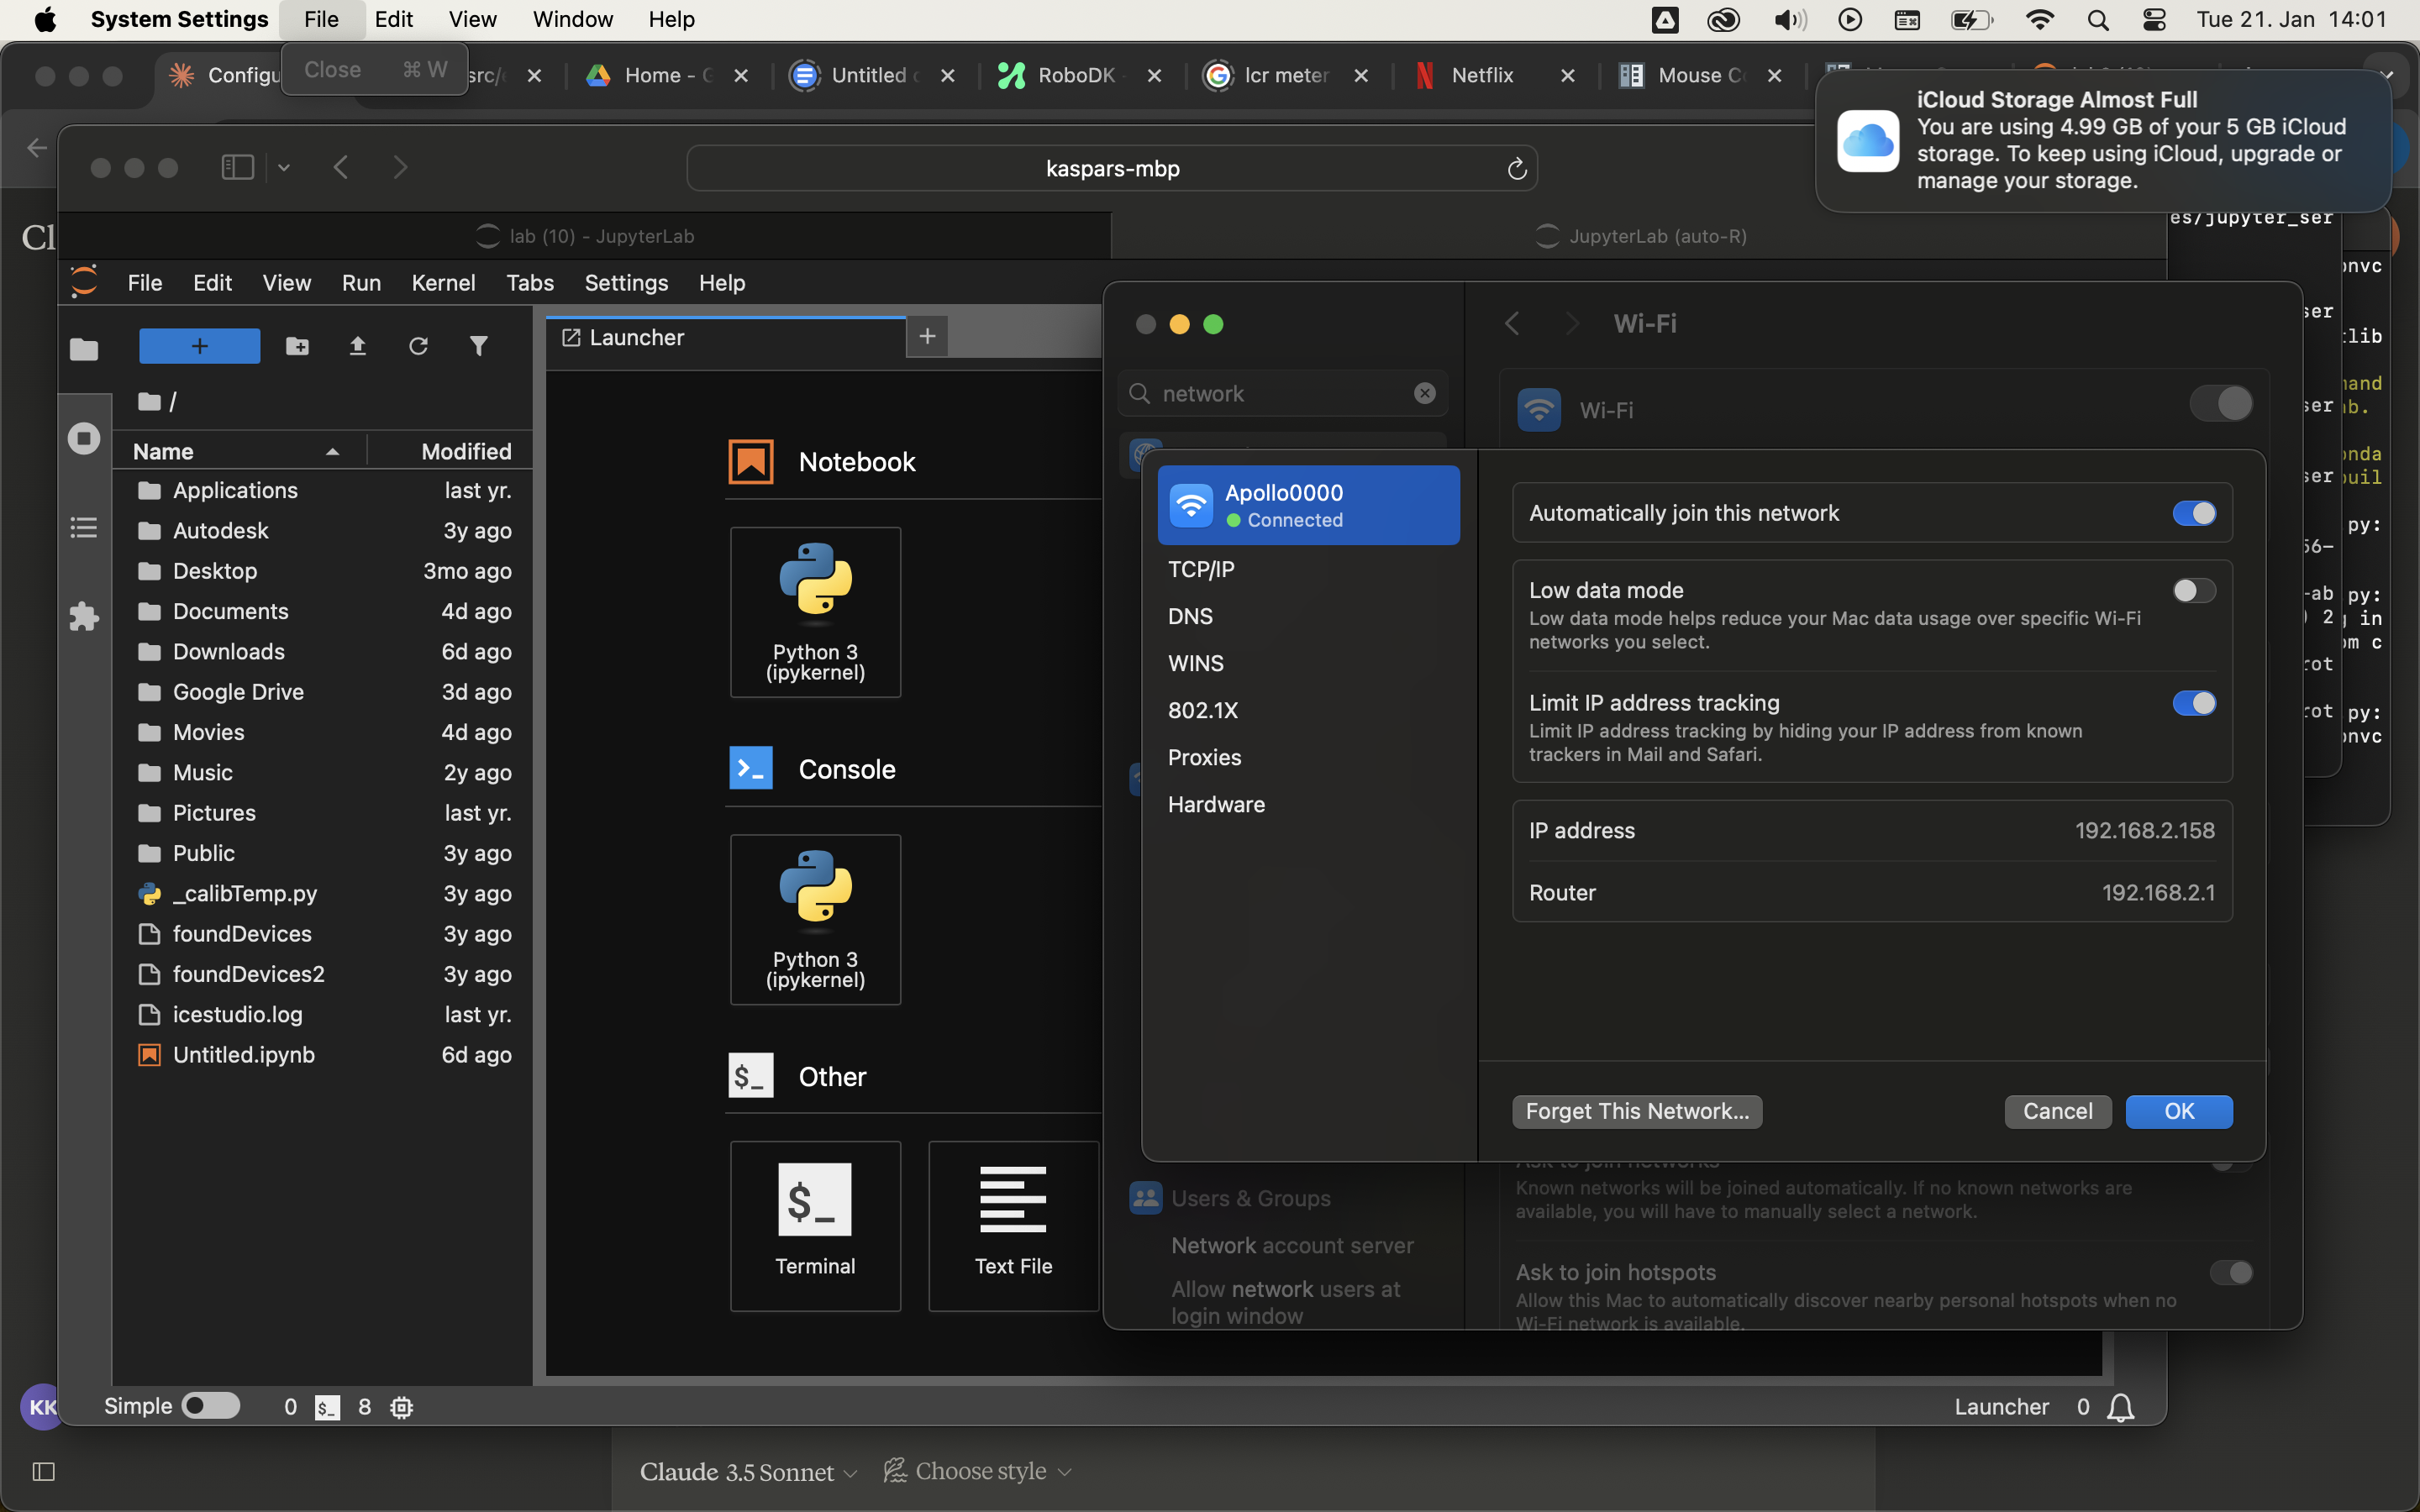

In [11]:
pyautogui.screenshot()

In [13]:
# comment: Automated step generated with pyPeriscope V2 
payload = '''gASVxAMAAAAAAAB9lCiMBGFyZWGUWKQDAABpVkJPUncwS0dnb0FBQUFOU1VoRVVnQUFBRG9BQUFBbENBSUFBQUNjV1cweEFBQUNnVWxFUVZSNG5PMllRV2pUWUJUSDM2d0VoWXhCZTJrb1dJcU5SU2JDZ3REb1lFNE1GZWxwcCtqQk1yQUhxVHVzQit0RXhpaGxZSHZKRHFVVFVaRDBzQlhCbm5JWlFVZ090UlZ0UWF6SVd0QUtwWUowbHdTVXVJS0hibXpXdE9sc1V3bmtmd3FQOTMvdmw1ZnYreEl5NW5LNXdEZzY5cjhCamlZVFYwK1p1SHJLeE5WVEpxNmVHZ0Z1aEJVRWJvMGVTcTBldURURENRTEhxUFdKc0lJZ3BDTkRJVGlTek1XZ3B3eUdlM3c0WlJ4enl5c0IwbTFGTFFBdGVhZWFaNk94YkYwdGM0a1ZydHVLeWFCNEpoYTRoRnRSZ0pZaTEwdmNlaVNWMCs0empPazZhR1o5a2ZJZzBudVIzK0xGanhMcW9SYVRDWDkzeC9oMFBEUnJhNVo1Zm9zdlZHWGtsSmRlWW1pSGRpdXQ2YUpFU0JCQ1BWUG9ld0ZpUWk0K0RvWTNHdTBJK1hBejd2UE9MUUNYVkMrSzQ5dXArVUJtZi94a2RETStTOXhZb0RJUCtNRndmOVlLWWtYcWpHS0ViOUs2ZHgyOGZCYUZiMko2bnhVQThzL0xEUitHdVdtQWpHclZ4dHQwNXRCU3lhK0lsVmMwN3J5SUFkOVFOZlNMdTl0OHR4cjdxMmVFUGNDMW9pY0E3RE9NSUhSbTJaeGRpc3FOVDhVL0kwM3BCOENFZGFiYi9mV0wyNStVZWxFczczUkd2NWU3R25aVnEveHFhalVhSEZkV1dvQllaRzQxVnRST2JndTFuY1lBRGozMkMrY3dGS0Q2UldQbER1Tmt5SDc0REdBbmJ0M0UrdmM0cDBMVXdUbUFCVytUR0NpVlVsYlRPUGgwRzJ2UE9DTHFKKzZ3MlN1bFlrMENnSEVNeDNGNGZTMlFVTGNvOGtseStRbnJ5MVVrUUxEejVLUWRVYjV5VDVPOXQ5bHdjQUZ5aWZ1UDVQQzhmOHJ0cFR4dG5KM2FtNWRpVjRPeXZjSFVwdS82cjFLSUJVQ1JhNFZzS3BMSzk5RnFiTlMvUmZiZWF2N3dpMzl4Ryt5YndjVFZVd2JESGZsV0cwd0dtNjZKcTZkTVhEMWxNTnpmYTB2UlB0WU0vUE1BQUFBQVNVVk9SSzVDWUlJPZSMDWNsZWFuX3ByZXZpZXeUWCBEAQBpVkJPUncwS0dnb0FBQUFOU1VoRVVnQUFBb0FBQUFLQUNBSUFBQUNEcjE1MEFBRHkzVWxFUVZSNG5PemRlVndVNWY4QThNL3N4YkhMZmVpQ3VZS3NLSGl1QndpSkduZ1FpVkVhSHFGbVZJWlcyRmZJOUV2SGp5ekZTdXlnUXpLUGJ4NnBVUnBxQ2lXWUNCNTRvaUlxb01MS2ZlM0NNcnM3OC90allGM3VCUlpXOGZOK1dTOTI1M3JtMldmbU04OHhNOFFycjc4RENDR0VFT3BkeEpWN2FrT25BU0dFRUhyaXNBeWRBSVFRUXVoSmhBRVlJWVFRTWdBTXdBZ2hoSkFCWUFCR0NDR0VEQUFETUVJSUlXUUFHSUFSUWdnaEE4QUFqQkJDQ0JsQXh3R1lCcUJwb0lFR0FDQjZOalUwYUxiVUIyRk82a1h2WkNNQkJFMHpXK3ViMlFpTiswWURUZE5BRUQxYklyRkE2bWxiZlRZYjRZbk15WTRETUFGQUVFQXcrVUUzbnBEMGx6dTBWaTRRb05sU0g0UTVxUmM5bTQwTjY2RnBvQW1pNFhPZnpFWm8zRGNDQ0lJQW1xYXhRSFlOSHRmNjhnVG1aS2Vib0J0T1NKUSs4b1VBb0prY2Z4SmhUdXFGUHJPeG9kWUxmVGZtdGdjTHBGNWdOdXJMazVDVFhlMERidHlmTGlOQXoxYzNqeXZNU2Izb2RqWUNBVFRRVDNndUFtQ0IxQlBNUm4zcDB6blpyVUZZTkEwMDNlbjlJcG8yQlNEQW5OU1RybVVqRUVEVEFGMVlzTy9DQXFrWG1JMzYwbGR6c3J1am9BbWk4MWNXUlBkcUtuMFU1cVJlZENFYm1aNG4xQXdXU0wzQWJOU1hQcG1UZXJnTmlhYWhFeGxEYUxyWlVIT1lrM3FCMmFndm1KTjZnZG1vTDMwdkovVjBIekN0YytjWjljaG5pV0ZoVHVvRlpxTytZRTdxQldhanZ2U3RuTlJUQU5heGNhQUxiUWhQR3N4SnZjQnMxQmZNU2IzQWJOU1h2cFdUSEgydGlOWmxzTGh1QThwcHV2R21SSm9tQ0lMRllqV2RDaXExdXJaV0xxdXVMQ3VSM3N1L2szYzcrMjV1VHM2TnE4R0wzZ3hldEl5aXFHYUxQRjcwbUpQTkdITkJZRXp3amNDWVRiUFlRQUNvS1VLaEFuazkxTlJSOWFySG9jRHFyT2V5VVUzVGJJSUFnTHR5MlpIaTIyeW85N2NmN01pM0FRQ0tWck1JZGhkUyt5alRlMDVxanRDODJ6Y3ZYY2pJT1BWUGNWRkJkVlVsQUpoYldOcjNIK0RoUFhYVUdJOUJ6bUx0bVI5M1BWUWdpWkk4anF4RStkUkk0Qmc5L0paVUFJc05IRzVuRS9sWTBHOU9NbEdtNlRlOTEzT3N0d0RjZU5OV1E2MC92NVNTMWRNQ0kwSmt5M280QjZGVG13QkJFRXlPTUFQWTZ1dkpvZ2YzaXFYM0gwZ0xDdTdsUGlpOFYxWlNYRmxSV2xKVStLQ2tqR1A1Rk0vV2lUOW9nZ3lLNzkrOUF3RDBvOS93M3o3OTVhU0dFUmRzQllTbENSQXNRck1OQUdDeGdNc0JNMk93RnhDVmRWQW1nM3FWWHZiaEVkQUQyVWpSTklzZzJBUlJScEwvVnBTZEw3K25VbFZ3aWRvOTkzUEhXVDAxeG5LNE9jOGNBR2lhSW9pK0VETWE2RFVuYVpwbXNWajM3OTVKL0gzdjM4ZitVQ3BKNW9LYk9lUkxTNHJLU290dlpGM2dHUmsvTXowdzRQbjVqZ05FTFUrUmo2VWVLSkNncU9VY2pSV3Fhd3BHdmFBZUU5QVFPc2c2OXQveHdPV3FuM2tEQ0tLUDVKNDJ2ZVlrUVJBNXVZb2J0K3VBSWdZNGNJZUpUWXlOZXUvZzFWOEFoaWEzVWNvVXRPYi9MYWUyaGFLbzB1SUg5L0p2MzcrYld5UzlYMUpVS0MyOFZ5UzlYMUZlS3F1cGtzdGtoSW0xcWVNd3dRQjN2dE5FQzArWC9uWXUvSDRPYkw0MWJjRytzOXV5dENRRG9NY2ZxdGNMdXArVDJpeE5vYjhsaThNQ0FGQURzQUFJbFFvb0NnQ0F4YUk0SEJxQXpXWlpDOERNaEM2dWdvcmF4L3dLcHBFZXM1SHBUbUlSaEpLaVU4cXJVeXFLRlhRTnA3NlVxNjVoRTNKU0xiOVFVNUFuT3lXeGtnd3puOFJoODJpYUFvQStFNGIxbFpNcWxZckQ0Zng3NHE5dFAzeFpYbDVDVVJTSHc2RW9pbUR1QkFOZ3NRZ0Fnc1ZpS2VwcWp4NzY5Y3pwRTZGaGtaN2V6ekFMNm5lbmVwOCtqMnVhQW9KRjB4UlJXMVhCb29sTFIybDNYNEpuREFCUVZXU1dmNmFXYjZjR21xbk82RzhQSGhYNnlrbUtnajEvbE8vL3M3eWlTZzBBSmlZdzFNVjQzbXliQ2FNRnpiZElOendwazZYWGtkWDZMTk5FdTNjN3R6K1ZVWEF2TDJ4UndMMzgyMnExR2dnMnk4U0tZMkxCdGJBWHVFd1hPWSt3RmcyM0ZZMFVXTnNibVFDSERVQURwUVpTQ2JWMWRKMks0Z29zUy9LbDBDY0NjUGR6VXNOR0FFSkxGZ0FvQVRoS1Vua3VRL252Q2VXMUsrclNJcUNCYldQSGNSdkJtelNGTlc2aWlzZmpzZ2xIYXlBSXFseisyT2NoNkM4YjFUU3dDUUNBaTFYMWg4cXE3eXNxVFpVbEp1b3FEbEhIWWRkem9KWk55V2haVlJXblBFTjl0cmo4K0VqcnVYWldZd0dBcHRRRXF5KzBTT3NsSjJtYTVuQTRpWC9zaWY5MkF3RUVSVk5zTnB1aUtHZ1kzUXBFUTNVTm1NQ3NVcW5LUzRzM2ZoTDU1dHYvOWZOL3ZnL1U1UFI0WEFQQkFwb21UQVRxVVRQWWx4TFpzakxxNWlscXVDOEFBS2t3TXpLcTZUY1lDQllBMEVvRk4rVm5WbDBOT1RVVUJOYTkyc0RhWS9TVms4ZFRxbjdhWFVMVEJJdEZBOUIxZGNURkxOV05uTUtYWDdRT0RyUmhzeHRXUWpGeEZ4cldxc2NzMUc4TnVMMVU2WkptYXhzN2Exdjd2RHMzT1R4VDRleTFUdDdQRHJUcmIyZlgzOUljekUzQWhBVWNOUkEwRUJTdHBxRmVTZFdxb0pva0tsaEVLY1V5dFI1WVZWbFJyMUFZR1J2cmNhY01vdnM1eWJBMEFhRWxpMmtTaGV4cmxWdStVYWFmcElFZ09CeG1IU3BaamZMT1RjV2gvZHlKUG9KWDNnQzNrVURURGxac2xWcGRyWGpzajFKOVpTT2JnTHhhOHM4SzVhblNDajY3MXF6K2dSSElXYXc2RmwzTEptUXNrTEdKYW9LbzRLb3JlSlcxY3RhVnJBY1hCOXY0MlFtZk43WncwYytlR0ZyM2M1SUpueWwvSDluNjNVWUFFSmliVzFyYjM4dkxJUWlDb2lpQ0lLQ3gwWkRwOUZXcjFhSkJMbFhWRlZVVjVkOS84Nm5BM016VDIvZHhqOEg2S3BDZ1VrTGxBN0I5Q2dDb1VjL0ticDIxcmk4cnYzYUNjdlVHcmpHcnZvYk5BdHBTQ0FDMHFwNlQvS05wM2xrK2ovdWc3QjR0c0g1MEh3clZHWHJKeVJxWityZWo1VFJ3V0N5U2JtZ1FwQW1DckZPdzRuZVhreVM5K0NWYnBrTEhJcUJlQmRJYXVsNEY5Z0xDeWtSUHU2SGZBTnpCTDZ2RDc4NFhtQTBmTlQ3enpMOEVRWms3dUUvd0dqMmVELzM0dEJHaDVyRlpMQUlBQ0RXQVVnMjFTcWdoV1JWMVFCTkVuWkptS2NESTZxbnllbFZsWlZtLy9vNzYzQ21ENkhaT0FvQVJoKzV2eVFLZ0tZSlFaWnlxL3V3RHFraEtXRmhDYlMzUU5MRFpBQUFxRmNGaUVTYW01UEhFT25OenJ0c0lwdWc2V3JNVnhXcnljUitXcFk5c2xLdW94RExGc1NxbFhLMHlWWlh6VlZVOFFzRUdCWnVxWmJQa2JKQng2Qm9XcTVKRGx4dXI2d1JxTUphcFRGUzBvdTU0eGQzVEZ2MERqTVJ6MkNibSt0c2xBK2wyVGhJRWtYZm41ay9mYnFCcG1pQllVNmZOZW43dWt2dzdOM2Z0K083TzdSczhEdGZLeG83TjVwU1dTSlZLNWNCQkxndVdMSGQySG5MNHozMEhkditrVmlwLy9QcXpBVTg1RFJqb3JOZTk2blhkemthYW9nZ1dpMzMrRC9OYnFkWDkzTlhlQzJrVGMyck1jL0xVbjB5cjdzbHVuNkdHK3REeVNoWkIwTFlEQVlDVHZrK1FmMVpOMDZXbS9jRGVDUUQ2UVBRRjBNK2hmZk9PNHU3OWVtaDhBbnpEeThGb0lBZzFBZXovL1ZadWE4MTlicHFsVWczcDl5QWxseWlvcHRVVW1CdlQvbUxDVjArWDFucHRnbTUzbjNXOHVuTWJPWmJGNGFxVlpGM3VXU0Y3bHB1bHFyOEZoODFpTTgxVHBCcnFWSVNjQkFxZ1ZnVUVBSXRwdjZLQVoyYXJKSGhWbGVWOUlBRHJKU2R0ekFnT20xQUIwRGszcWo2Tm9zcEtDWE1MU2liakRuVXo4cHpFZGhrQ0JLSE95YTdQK0ZkNStZTFJqT2Y0eTFiU0ZFMFFRQk1FbXdXMkFxS3dzbHQ3a1p0ejlkc05rY3ZmaTNFU0QrL1dpcnBLTDlsNHVrTCtXNjB4TFNzMW82dE5RTTRGQlF2cXVJU0NCVElPVWNPaWFsaXNTalpkYWF5cUZhaG9rM3FLcjZTTWxUUlZENVNpVkZDK281WnR3M2FmclpmZE1hRHU1NlJLcFVyOGZaZE1Yc1BsY3RVcXRjc1FkeXRyR3l2cmljTkdqQ2t1a3RyYTl1UHllQUNnVWluTFNvcXNiZXhNVFBrQTRDSWVSaEFzSG85YlZWRng5TTk5UzVkRlBJSWpvaXZMUzFoc3RybUZkWWR6NnFWQUFnRE5OU0hrbFpaMzBtb3E3cE5UbGxMdVUrdHZuTFN0eXBWZk9VNkx2ZGgxMVpWMUpHMHJJbkxTVGE4Y0pXbFFjM2lxU1l0b0UzT2dLSGowTXJBTDlKS1RoVVhLZWlXTG9OVkFFSlJXdHpFTkJBRVVSWE8yN2k2MjdtZVVUWmttM3dSZ0V6VEZCcHF1bzRtZGx5Z0xZM3JjQUtMN2JkSE5BL0RaVThjZkZPU1o4TTM0ZkhPK3dOeUVieVllTnFwYlcrZ2taNWVobHBZMjVhVVA2c3Z2OHdqQ3hveGpiVXpRQUdvYTZpbENyUWFDQnBvR21tTGVHTWNNTXdBQ2dHTmtvdVlLYXFvcWRjeVVINzVjazNQdDR1ZnhoMXVkVkY1UzlQNW5QMldtLzdNcmZ1T0MwQWlKNTFUOTcycFBNdWFDcFNtTEF1QW82aXJqdnFJZUZMR3N6R21Gd25UK0V2NHJiN0JNK1V4ekh6SFp6emc0cFA2dlA0MThaN0tzckFtdEY4TmE4bG1sc2g2dkJLOEtmVmJ6OTM5anRsdGEyMmxQUFpxd283S2loQ21IazN4bkd4bnJyK2xIWnpRUVZHMlZPZFFhZ1p3SGNoNVJ4NlpyV1NEanNPUnNXc1ptVlhPSVNpTlZqVUJKbVpJMHYxNWxxZ0lqaGNwWVFSdVRiSFY5UFVmZGlXMVZscGQ4RXJsWTg3Rlp3ZHUzZlhQR3liK2FMZEpxQVg0RTNidDc1MVJxRWdGQTBSUUZkRmxwTVRQNDJjakkrS21CVHByWk9CeU80MU9EQUVDdFZyTllyTkxTWXFBcE5RVTAwS25KaDJmT0NoN3cxQ0JEN2NLamdHQ3hBSUNTQkZSeWpYaG45bGxWMzZ2NWM0TmkwaEwxeE9DS1A5WlpLUE1xYjUrRG10SnFVMXVpSkk5ejRpYzFUYkNBVW5pL1REc09veWsxRUFSMGZvaSs5a0VLclIybmo2bnFHalVRUEJaTG9WWlRMQ0FheGxpeENLQm9nZ1gxcEpwdkJGWHl1dlFpWXhWRkdCRVVEVUFUUUZDZ1pyR1RiMU9qaGNEcC9BQVA1aWpXVkVzZUJ1RENlM2VPL3I3RFdUeDgxa3V2YWI3TXYzMWRIM3ZhQ1k1UE9WbGEyMWFVRmRWV1NxdmtDcEkyb1lHaWdVWFJEZVBRS0FJb0FEVU5hZ3BVRkNncFVGR2dWZ09ieTFIenpPU3lhaDAzTkgzV2dweHJGelBULzJrV1hDdkxTM0t1WFp3WnRLZ0hkcTczQ0l3SkZnRXFHZ2paM3p6aFRxWHRjSFdKbkw5d3Z0bnlkMm1hcGxRcWdzVlNxUUZvR3ZqbVJuTVcwQUFxRlFVRWkrbndZUDZabTdCS2EvUTJJam9wY2MvWmY0Ky8vOWxQekVjbTJHaGl6TDd0bXorSlhLeDliUCsrKzN0alk5TjVTLzhEQUxtM3NqTFQveG5uNWN2bEdiVzEvaDdDQWpCbWtVWWdOd1labDZoalF4MkhxR1dEakUzTE9VUTFDOHE0Nm1vemxkcVVwRXlWbEtrS2pCUnFZd1ZsVktjMlV0RW1kWlNpTTdkMW5UdWRyRGt5bWZhRDhySWl2NEI1bWhsczdJU2FEQVNBcE1ROXEwS2ZGYnVOZnVQZFQvVzN4ejNpY21hR29xNk9ZQkZxTlVWVFZIL2hnUFo3YzFrc0ZrRVFRdUVBaXFLWXJsK1pYSGI5Nm9VblBBQnJVQ1A4NnV5ZDFXbTd6VXF5T1VuZnlvWTlvM1owSTRwdnNLOGNwZGxjRmtFUXAzYXg2K1hHUEU2Vjh5VGEvUmtBNk1KNHdKWTFrSDNiTit0NVR3eUhHZkhIbEs3R1lZQkFVVFNiUlNoVnRKa3BSTHhtTVhzcVZYQ01QSHFieDJNM3Z0ZUJCbURCL1dvb3FhV0ZacDJ1bjJTYy9FdnNOdnBjV2pKem1EZGNDbFZYbFIvNDM3YyswMTZZTW5PTzl0eWl3Y082djUrNm8ybmEzTUxTd1hFZ0FNaExDeDRVVjFhVE5LbW0xVFN0b2h2RHJScVVqZi9xMVVDcVFVVUJSUU9MU3hER2xqSlpqWTU5SE16KzM4NiszT3o3YzZlVEFXRGNSRjhBa0hoTy9Ueis4R05YL1FVQXZoRUFBQnRBWFp6QTg1RHhnNjRhZXdsTkY3NUcweFJRRk1IaEVDd1dsOHZpOHRoY0ZzMEdOUWRvTG9mRlpRT0hCYXpHREJRWTZiUDZXMUZhMU95YjVlL0ZhUEoyN3VKM2JPeUV4dy90WWo1bVhjcTRsNWN6eWEraDhkYkp4ZDNFbEY4a3Zhdkg5T2lJVFN0TmFaa3hJZU1SQ2k1Uno2YmxiSkJ4Q0RrYnFnbW80RkhWQXFYU2xLUUZTa3FncEl3VUtsNmR5cGlrVEVpYVc2dml5bFFzRmFYN3R2d0M1bW1hNjUzRXd6MG16VGo3Ny9IMjUvOXZ6UGFjYXhlVEV2ZDBheWQ3M3JtTWt6VFFMQlpCRU1SNHo4bmpQSDJnM1JzV21DNm5NZU84UENmNUFVR3dPU3dDNE1MWnRGNU04cU9LcG1oS0RXb1YwYzlaT1N1eVN2S0NtbWRpZHl1RlZYaWpSa0VTRDNLSTRqeWlvcENvS3VaeDJES2J3V3EvWlVCVGhMd1NTdThSZHkremIyZUFRcTdqcHY3NjQzOGVrMlpvbndEbkxuNm5iMVIvQVlCdnlxTFVTdVk5UzlENG9Ha1dDMmlnVlVwNlVhQ0oveVNlV2tuN2kwa3pIcWdvbW1adWxpT0FWZ09wcHVWa3A3ZVltZjZQaloxdytxd0ZtcWFzaGhyd2tkKzJQVFZJN0RKMHBMNzJyV3VZaTVHUlk4YWZPbkZFVlpaYmVLK290RjRvSkdrakxxMmlDS1VhU0RYVXE2QmVCUW8xS05SUXJ3SlNCVW9LS0FvSU5oaFpPVlpYVmVnK3lzOWowb3lNazMvTlhmeU85cGUzc3krTDNVWS83b1hNbUVNREVBU3RoS29NaWlTNGcyUThyMEZzVzF1S1VoSXNEa0hUS2dyMm5GYXFxTWFzSXRSTTEwZTlDaWE2Y0lZL3hRSUFMcnNUd2FPekxLM3RtbVd5dFYwL3pkLzM3bVEvTlVqTU43UFFmR1BYMzdHbXFyTG4wdE1XRHFFeUlXUkdySHBDWGNlbTVSeFdMUWZrYktobVFTV1BydUtybEh5UzVwTzBxWkl5VmxER0N0cVVCR01GeGF0Vkd5bFlSbktxVGtuM1lDWUNXRnJielF4YWREUmhoM1pGK1JGVVhGUkFVeFJCY0FpZ2h3NGZ6ZHhsMVA2dHZXcTFtc1BodUErWG5FbjdoNlpCclZiZnY1ZlhXK2w5aEJHc2g5Y3RISzU2M1BOeTUvR3E5TDNjdlBNa0RRVFFMRkpPTno3T1NHMXF5VDUva1BYZ0pwUVZjR3FLaE9iOFdxV3F5UDk5V2poRXg2MVoyZmJyZUtiSGs3ME5sOE5XcXRVRWN4czZVeHRtczFueVd0VklWMTVJb0NsTmdVTE5jcmNuaDlpcXprczVwaXhDUlRmVWdRa2dpTTQrTlFYZ2JOcng4VTlQWXk2eW1jWlhEZ0JVVlpUbTNycSthTm43ZXQvRHptS3VpRWRKUEZrc05xV3FLN2h6clVBMnlzR0lzQVJDVFFHcGhsb2wxS3BBVG9KY0NiVktxRk5DdlJycTFjemxDV0ZrSmFxc0tORjlsUDA0TDkrTWszOXB0MEl6N2M4TFFpT1lqeTJIRVNVbDdqbWFzSVA1ZTJiUUl1YXN0Mi83NWxzM0xtdmFCbVUxbGIvOUVqZkJlL3JRRWVPWWIrN2V1V0ZrWXRwUE9GQWZtYVNUeHBFV0ZOVGZKd0JvbW1DWmpXSUdvTkkwRFFTaFV0UGZKWk4xSk0xdXJQQ3FLSm9Ba0NubzE1L2hEWC9LQ0lEUXZZZUR5U2pOeDJZZGs5cGRtMHgvVXFzanM4cExpcXh0R283MnZEdlhYZDBrMmxPTmpFeks2aCtvVkVwTzd6NWdqMDBvalFrNW02NWwwWFVjUXM0R0dSdXFXVVFsRnlwTWxBbytTZk9WbEVCSm1kUlR4dlZxazNxMVVUMXRwRkR6YXRVOEJjV1ZxUWwxMTl2d3k4dUtkTGttSGp5a29jbTYxY0Z1U1gvdXZwMTkyWVJ2eGhlWTgvbm0ybjByU3JLZUpPdjVndDRZcEYxWlhrWVFCS1dtbUg1ZlhSWmh6Z1ltcHFhMG1xSm9naUNJc3RJSE9tNnUxUUxKTktqK04yYjczbTJiY3E1ZGhCWk4rdEE0TklUNVc3dVVWbGVWYjQ5Ynh4ZVltZkxOK0FMejRSSXZKeGQzSFJPalIwVEJkWDc2TGdWRkFNK1VOakltakFYQU1WYWIyeXBGb3ltRmpQZmdwZ3BvbW1LZTQwdlZLaW4ybmJPbWQ4L1hxVlNVOVZOSzkyZnkrdzFSMnd5a2JRYm9lSWEwdHV2WHpyVWRrNSthajVyc1doWDZyTWVrR2RvVkcyYk9GYXMvSCtUaUJnQi83dnVwdkt5SUtaQmVVd1BNTFcyNm5pUGRNTUNCWjJuT0xhc2tDS0toSHN4aUVjeGRjTTgvWXp5Z0g2dEdUaEVFbUhGaG5JUHlYQUVYZ0dLeENLQ0JZSUV4Rjh4NG5Xc2daSUxMOUZrTEFNQmowb3l6YWNjYkFuRCs3UnNBWUdaaDFjN0N6UEQzYnV5c1RwaERidWp3TVJaV051V2xSU1YzTGhiVUxIaktpRVVRQURUVXF4dENiNDBTWlBWUVV3OXlFbXFWVUs4RUZVV3JnT0JhUDFWZWNsWDNYSEVTRDdleEU5N092cXdKd0V6N2MxdHR6a3ovT1hNd2E0S0tYOEE4SnBCWGxwY3dWYm9IOS9NQm9LU29RQk9BWlRYVk5uYkNydWRMOTlBRTBEUkJQN3gyYTUwMW44WGxnTUNJWnA1R3BQdjZtYU5MYy9pMTdDV3l0TGI3UFA1d3M4dVVabkp6cnBhVlNHZk1mcG41V0ZsZTJxeEE4Z3d4QWdzQTJMU2FROVJ4b0k1RnlOaUVqQU15TmxIRmdVcFRWWjFaWTh1ek1Va1oxMU5HSkdXc3BJenFLSzVjemF0VmMrc0lqbHhOS0x1NDNhVEVQVzBORW15R3lmYUtzaEluY2ZOSjFaVmxsUldsYi96bk0rYmp1YlNrTS84ZW0vRDBkQUNRMTFUVjFjcXM3ZnAzTVgyZFJSQUFRTEFJb0FoRlhSM284TWhZaXFMWWJMYWlUazZ3V0FRTGdBSzFXcWNlOWZZTDVDZVJpNWUvRjhQMG1xOEtmZmFITDlkb2V0QS9lLzlWYTd0K21taXRmZkdkOXZlZkw3NjgzT0VwWndBb0wzMlFtWEhDek16U3RsOXYzM0JCV3dvVmRvT2hxaGpVS3Bhc0FxcExnS0k0bElvMnNZQjZPUVZOM2o1UEVDeTYvNUFhc1FmVlgweWJtQVBYaU9hYUVHeU83c2YyRys5K3VpcjAyVldoejJvcUc5cisrdU4vbXZLWmxMam4ydzJSekJnT3BrbEdPd0NmVFRzdWRodk5STit0WDM5azMvK3BSY3ZXQUVEaHZUc1h6cVNPblRoVllHYloxU3pwT29kK3ZJR09SbVdWcW9aeHV6UkJFRVI5UGVWZ3ozbGF3bE5UTkVFQXdTS0FBRGRiRlo5SHEybUNlVElId1FZYkU3RG81QW5wM09sa0d6c2hVNXpHZWZsK3V5R3lzcnprWVV3MU0yOHZBT3RZOVBYQ3l0cDJrUE1RZ2lDcUNuUHVsOUZTR1ZGV1MxZlhRMlU5VkpOUXFZQ3FlcWlxaDJvUzVFcVFLK2s2TmExUTBXb0tPR2I5eWlyS0FUcFI1eGovOURUdGthVm4vejN1TVdsR3EzUG01bHhsUnE4eEh6WGxEQnJQZ0pucC96Q1RibHc5TjJUWW1PSUg5NWlQc3BwS0FEQXlNZTFzUG5RSDFmQXFMaFlZRFFBYWpHaUtMYzhpQ0FKb2loazF6bUVUYi9yeTNwcGh0R0lhai9sbnpRY0ZTYXNvc0RCcGVEQ2dTcmNSdk9WbFJacUNCUURObXZSMTlPMkdTTEhiNkVld3U1MGcxRnlvNDdKcU9ZU2NROGc1ckNvMlZKaW81WHlTWXFxL3BpUnRyS0NObU9wdkhXMVVTeG5KMVVaeU5iZVdac3RwUXRXNUd2QVBYNjVoVG5rVnBVWGRIK0ZzYm1rekorUXR6Y2ZCcmlQcWF1Vmt2UUlBVkNvbG04Tmg5ZGFEdWl5dGJCcmZzRUlWUDdnUEFCM2VVTVRNOEtEd1BnRE5ZckZvbXJiVXJhclVmb0ZjRUJxaG1iUWdOQ0xuMnNYSzhoSUFTRXJjVTFZaTFRUmppZWRVc2R2b1k0MkRFbVlHTFdLaUx3QlkyL2EzdHVsWFhWV3VTMkwwakcrcDhsbWltaFdwZW42TmNzN0h5cGZXS2VkOXBseXdVVFZoRHNIaGNWa1BXMFhaQkVFTHJHa09sMzNtTjk2aEdONytEN20vUlJ2OS9nbnI1RTZvcTlGOWc1L0hIL2FZTk9Ob3dvNVZvYzgyRzJxZ2ZUSE5oT2M3TjY5QzR3QWF6Zm1RcWZtTjk1b0dBUDhtSDZ3c0wzMXU3cXZNSkllbm5LMXM3QXZ2NVhZeE43cUJvbWd1bDVnd1dnQ2dnb1lPWUlvZ1FLV21Cei9GRWptdzZrbGdzVmhBc0NpSzZtZW10aktoMUJRTEFDZ2FLQXFHMm9FUkd6cjEyb0d6L3g0Zi8vUTA1bSttQko0N25heFRwVmFsNnVwbGZKY1FCT0VzSGdvQXRjVzNpeXJJZ2hxNm9Kb29yWU9LT2lpdmhmSTZLSytEaWpxb3JxZHI2cUdXQkFWSjE1TXFOUVZHdG80S2dsOVhWNnY3dHBqbU82YXNWSmFYbEpWSUI3dTIzdWgzKytaVjdhTmFzeXh6OUlyZFJ0L0p1Y3A4WDNEMzFvaXgzZ0JRZU84T0FOUlVWUWpNekh1NTRWU2hZZ0VBUlhBSkN3OGUwS2VWZGl2elpFVzE1UVRCVnRNVVFSTWNOdkh5MDd4WGZIaUxmYmlMZmJoelBUaHNGZ0RRYW9vVzJUWTh5bHlwMXFsNFdOdjBLeXVSZG5sNFpHN08xYzRPNVpYWFZLbVVuUjhDMFNVc1VIRkF4cUprSEphY3c2b21vTnlZa2dtVUZGOUo4MVZxRTVJeXJxZE02dFVtOWJTeEFuaTFLbDZ0MnFpTzV0UUNJYWZZTXFxekFmaU5kei85UFA3dzUvR0hCN3VPWEJYNnJDNjV5cFRBZG1TbS83UGorMDhQL08rYmpOUy9BSUFrRlFEQTRYRFZLaFVUakh2QndFR0QyV3cyYzV2YmhYTnBwYVVQMkd5MlV0bm1pVVdwVkxMWjdJcnlralBwSjJpYXBpaWF6V1k3RFhiVlpWdnRGMGpuSVE4UFlTdWJoNk1RYm1kZmJuYnhQZGgxWkhsSms1R0RXNy8rYU0vV0x3Nzl1cVc4cklpcHgydFFWR2R1T09zT21nYUtBcldLT2YzVHNsTE9QL0htaDlkRGJWV3QxU0FlMGREV1JRR3c2bVdVaXlmNTNDcmxjRi9LZWdCUlUycFVmTXY4MmpHaXVITUJiKzdpZHo2UFB5eDJHMzAwWWNjUFg2N1Juc1Fjdk13L0FDZ3ZLd0lBUzJzN3NkdG96ZmhXcHViSFhGdm4zNzQrY3F5Mzlob3NyVzNyRlUxeXNuY3d6M1Y2ZW9MQTFvb0FZQU1RQkl0RlVUUUF5M2tBbTI5Q1VBMFA1cUFBV0daYzJ0cVlwcGkrWHhhYnoxYVBkZXpjY2MyMDhER1hKZ3htaUNVSEFDeXNiQUNnOE40ZHpTVmVNNVJhM1d2M3Z6UGpzRWFNbnJEL2x5M0tzcnNsUlFWU08yY1dUVm1iZ29xQ1doSnFsRkNqZ09wNmtKR0VqS1JxbGJTU3pRWUJtMUtEcXVwdThZUEM2cW9LVTFPK2pwdGpXcUdaNXZqMjI1OHJTb3ZLU3FUTmJva0RnSXF5SWt0cnUvRmUwMzdkdmhrQXJsOCs2empRaFM4d2QzSnhyeWdyZG5qS3ViUllLaHd3cU9zNTBpWHllakF6QmdxQXNuL3h3SzJqM3lpODdwT1ZkbG0vcmgyL2pBMjBpbEt4Q0phS0FqVk5zWUJ0eENhK1Q2N0xMNlZNalFnN2M5WVFJUWVBQWdCWnZVNkZUT0k1MWNyRzd0c05rVXhiUXFmcWJVeXJmc3NHTGt0cjIyWnprb282QUdDdVk3UUhaL1UwRnFpNXJGb1dXdzdxYWhaVUdGRXlnWXJpazVSQXFlYXJ3TGllTWxLb2pVbkt1RjdObGF1TmF5bWpXb290VjdQa0ZGZkI1dFpTcks0T3dkTGs2amd2My9hZlpGSlJWZ1JONDRyR2xjeTA0NGQyOVhjVU1TMStGV1ZGbDg4M0RDVG1tMW53akl4SnNwNm5XNDlzTjQwWU5mNTh4cjlBVVJSTmw1V1c3SXovS216bEIweG5jTE1YRGpJZnVWeXVvbDZ4UFQ2MnBPZ0JBRkJxTlFBeGZQUjRYYmJWMlFMSkhNTGxKVVU1MXk2MnZOT2E4ZjBYN3l0SjBqOW9NZE1ycjZuZU1XaUtvdFRxWG1wT0lKaTNBYkNndnBhVjlUZnYvRyttdEtwbXlHU1ZyUlAzNURhRmd6dXI5QTRvRlN3QW1sS3owM2ZUTThNcGo3a1VUWU5hcFN5K1RYTjRZRHVvQzV0OTQ5MVBtWjUxWnRDTXBnOU9jK3VnOXJseHZOZTBYZkVibWJZSDdacGZaVVZwa2ZTZTlxQUU1by91NTByWE9BcDV2dDdtZS8rc1pSRUtpaVlJb0Znc2xvVVppODBpZ0tZSkZ0QTBUUUhMbUUzemVUUkYweXlhVm5OQTRnRE8xZ1IwNXRrcDU5S1NBVUQ3TG44R0J4cnZOY3ErZXI2dEFNeGlkN0t5M1ExTUFIWWJJVEV4TVZVb3FzdnVYaWwxZFdhcGFBVkZBRTNJNm1tNWtwTFZzMnFVaElJQUJaZWxVRU50VVc3NWpWT1ZsLytxdW5yRWhLVlVkS1lHREFEam41N0d0Q1MzMC80TUFGYTIvVm9PMmRCZ1RuOTNjN01MN3Q1aXN0RzJuMFBlcldzS1JXMjlvczdTcW5rNDZXazFDdHJlbk9BQTFGazlrMlQyK29QcWpQNDgvcTg1Ujdrc3pyTGg4OHlOQkFEQVl3RUFTMDBydDJVOCtQTzgwTXhZVVZVSDA0YXpCbGdUUUJNVVFFMmRyais2azNnNGM1cjc3UDFYVjRVK3ErT3QrczN1U2RkbVpXMTNQLy9XT0M4L3pUZjE5WFc5RXlwYUlGbFVEUWZrd0tyaVVWVUN0WXF2b0FSS1dxQ2lqUlZxazNyYWhLU042eWxqaGFiM0YxaHlpbE5Mcyt1QVVuWHJzTEd5MFdrQTZybTA1TGJHN2FjZVR4ZzUxdHZ2dWZtdExzamxHZlhhZmRWanhucnRGOFRMNVRWakpCT0xpNlgvbmpoV1hWVTVQZUJGVCs5bm1sM2NzMWdzbFVxVmtmYjNYNGQvdTVLWm9ibFZ5Y3pDWXZSWVR4MDMxNFVDYVczWHoyWG95Rlk3VUM2Zis3ZXl2SFQ1ZXpGdDlkTVJMQmFiM2FzdmF5S2syYnpUZSsycThzdE1yU284Z3ltaHErV0JLTG5ETUxXVGhGQlVVd1BjVEs0ZWsxa0lDWE5iczBPZjFmZ3NwZDJtQW9kTE93enR6a2ExQjgwY1A3U3JuZk9oeEhQcXJ2aU5tZW4vV05uWWFkZjhMSzFzK3prTWJLdEE5akttNi9kWlA4dC9UdGVVbEhNSlVBTEZ2SEtCUlJQUUdJc0lBS0NBb0drZ2dLYlpiSE8yNnRraExNM2lPbXExbXZIWis2ODJGUDFaTDRWZXZaaitvREMvMVlWN3MvbVUyV0doNDBBbmw2RTBUVmZuWGFsUTBFVnkrbDRGWFZDcEtwSVR4U1M3bUNaS0ZGVEJyZXpiUjMrK0hEdjNVclRQblMwaHhnVW5Yd2g2OGF1ZkVoeWZjdXB3SzlxWXdyRnYrK2F5RXVrNEw5KzJabVBhdGRwcTdyTzB0bk1aT3ZMdW5lekw1MDhOY1I4REFMYjJEcld5bW1McFBTTmpFdzZYMTZra2RWKzlFaXJsRkJCZ1FoaXRHdjN5VTZZMk5jbzZFNDdSanV1L3Y1cThOdmJpOXFQNUovL0tQL1hqMWIxTGo2L2RuUDBSYlhHeWp1UTZXQkh6Si9KWXRBb0lWbVV0M1lWM0E3OFpzUjRhdTRLYWFYWS9nNlpQdmRYcTNYQ0o5NzI4SE8xdlNoNFVXTm5hZHpwQjNjWWlWS2I4T29JbzVVR05RS1hra3hSZlJRbFV3TngwWkt4UUc5ZXJqZW9vamt4dFhFZnphaW1XWE0ycEkxZ0tGcnVPNUxGWU5OWDF1NUNZcW0zN1lUZ3ovWitNazM4eFF5dGJaYWIxaU1UeTB1SXVKNmFiSEFjTzhwNHlFd2lDdytPOUYvWDU4SkZqcjF3OHR6RTZJdnlOdVljUDdnVUE1c0ZZQUhEczhHOFJiNzM4eGJyVlZ5NmNZYnArV1d3MkFERnB5a3dIUjFGbnQ5dE9nV3pHMnFiZnJSdk5ud3FnVFR2Nk1tMnQybnBoak9wRGFoWDM2TmVtSmJjZU9QdlV6ZjR2UFhnQzc4aVh5dnBhNWJUbGJIa0ZvU0pWSGkvSmJaenN5WEsxNDNEWjJDRExmN2R5TGgwQkFKcWl1bCtWMGh6STJ2Y041dVkwejJGbW9HK3pxME5MYTd1N3VkbmRUSUMrTUhjZlBlVmdOSCsyTlUxUkJFRVFiS0FvdXJoTXBXbzg5VEZ4dDA0SjFmVUV3V0t6Z0o0em5QV1VaZWVpTDlOZW90Myt6SEFaT3JLaDBMaVA4aGcrMnZQd2daK3pMbVZvejZGNUVoYUwzWEhyU2dlL3JHNi9PeE9BTFN5dHhVTkhFQVFodjNkWlZrZVUxOUpGZGF3aTRCUXE2TnZaTjYvKy90MzU5VE11ZkRUMmR2eFN6dDEvUFVZUC8yenpqbjNITGtkOSt0MzRpVk80M001ZExqQTlGaGtuLzJyV3hkc01NeWhEdXcwaE4rZXFkaitUczNqNHBYTW5MYTF0bVJGOXBud3oyMzRPdVRuWHpOc2RYdDRxdmVSa3FZeFdxV2xnMFVNc25hTzkzclUzdGFtcXJ6SGo4VzlXNXYxODdiZi9ubzVkZS9yTHVDdTdMNVRjTURLdEtMTFp3QkgrdnVwWnZzaU9CaFpIUlVHWnpzL0EycmQ5cythNmhEblR0ZG9jMnV3S3BtV2Z1amIzVVI2V1ZqYWFPNzV5YjJVQlFHZnY0OUpMTnJwYURKTVlTeXo1YkV1ZWdxK2srU1J0cGdLVGVyVVJTUm1UbEltS05sSlFQRGxsWEV0eDVHcE9IUUcxTkVlbXRxbFZHVnZiRkN4NlV6RjFwdTRKL3V6OVZ6Vi9WNWFYZkxzaDBtUFNqSGFxYmo5OHVVWjd1RzlMbGxhMnAvNCt4UHhkVmlMTnVYWkJNNm1zUktwN3QyWDNjNUxGWWowYk9OZkN3aXJ6ekwvSGpod0lmLy9UcDBTRGpJMU5pb3VrVHM1RG9QRytWUUFRdTdybDNiN0pMTUs4S0lsU3F5MHNyZndEZzNWOEZaS09CYktadVl2ZktTdVJhdmR4SmlYdVlVNmRUQ2ZkdWJRazV2dlRLVjBjSEtlWEFna0F3T2FvcHJ4U0ZmU0JhdkppRUZpeC9vbTNLTStybmJTVU1EVW5Dck5wZ2lDNFJwVDNncG82aGNuRmc5U1FwNnQ5WHVPZi80MlZ0cHRnc1RyMThPSm1QVzROdFpTSnZnQmdaZHN2NTlwRlRkelZ2dW1MTWM3TE4rZmF4VnMzTGpQRHJ4Z0JjNVpXbHBmK3VlOWh2Zmx1Ym5hNXpuZVhhZWdySjVsN2Y1LzF0Wnc1VlVEUlBEYUxZQkYwMWkxVldTWEY0UkEwRFRSTnNBaTZySTRsbGJHNWJEclFGYVk2Tnl5b3U3TnB4MjNzaEMwUDVIRmV2ZytiVGFiNno1MVFNLzNRdnZnN1RBTTkzNXd2TUxleGI3aDVScWZ1RFQwOU4wbXRWclBaN0tIREpYL3MyNjRvenExVEFwaHlxNnBxS3pLU0MxTC9WM1V0R1JRVnpQWHlnbGRXekZuNHVvdXJ1MmJMemZxVGREVFlkV1RPdFl1YWpvcTJ2UEh1cDh3Z1ZjMDMydDFMRXMrcHAvNzVjM3JnUXMwM1ZqYjk1TElhVFI1MmdqNXlrbFFSaFJYVVFGczJCWlJYdjlIZlR2N2c2MHYvU3kwOFF3UEJaWEVvNW8zeEFBQlFYVStPc3grMXdzOWxRajgxVGJNQmFHbEZKNnEvVnJiOXRLOUwybXJ1azNoT1BadDJuSmx6K1hzeGJmV3BheFlQV2JabS80NnY5bXo5Z2k4d3Q3WVRlazk5cnROWm9JOXNOT1lZZTlqNnU1aTY1cGNlckNnL2Fra0FtNlI1VE1zelNSa3JLSzZjTXFwVDh4UTB1dzZJV3RwU3BpYnE2UEpuZzhwZldxeDA2ZHlENUt6dCttbG5TTXZJMml6SFBDYk5hTCtEYytIcjcyMzkrcU1mdm5qZmhHL201T0x1NFRORDB3Zk00WERMU3g3bzJnUFg3WnlrYWZvcDBlQ0ZyN3dWdCtuajQwY1R2Q2I1ZlJHM0orL09UWUhBM0w2L2cvYWNBd1lPTmpFeHFhdXJwZFZxNW5sWUxEWnI4ZXZ2T2c0UTZmZzZRaDBMWkV1Znh4L1dqQ2NDQUxIYmFMOTNQd1VBMGVCaHMxNEsvZnZ3cjVmUC8ydktONXNldUREdlZwZWUwYXUvSjh0UlRtT1pQMWpYL3JIUC9iZlk5Umx3OWFLVkNrSldScHZaMGpSTk9ReFZqSDVPZU9Ndk1tV3JLbkIxbFhrL3p1Vy9LTFVLT3RsVXJsM2ViT3lFbXZMbUZ6Q3ZvclJJRTNlWnJOTmVrR212aGhhamF0Nzk4SnNmdm5oL3gvZWZNbjNBRGdNSEQzVFNhV3hkRS9yTFNZSWd1RnppalJEN0d0bURVK2ZCbUZlZm5hYytmRkx4K2h4VFdTMU4welNMZ0gvdkdha28xc3NqcVJsRHVyTGh0cDV0N0NRZVRseTVwOGZCZXcvdk1zMjYzN0JhOXdIc3htazBvZVA3ejlWcU5wdWRrcFQ0N3JLNVlOclBlZkZYdGZtWnhXZi9VQlJjQlZyTjRYSXBpdVp5dUdwS3RXTFYvNzBhRnFsU3FWZ3MxaVA0bXBSdTBFOU9Bb0ExbjNhd1lnTUFxRUZKcURJZVhFb3BQSE9wSkx1b3RoUm9zREcxY3JNZTdDTWM1KzB3bHM4MllaNU1LcTJreW1SNjNSdUQwVTgyVWpURklsZ0FVRkYydHVyT2J0YURTK3dhSlZkQm1OYXFqR1VxWTVtS0o2UFl0V0JhVHBySmFJWExtTEtYbDlWNVRnSUFVS3RCaDZhang0RWVjcElKbndjUC9HL2JqMThLek15OUo4OFlMQjdHNHhsTm5PU24zV3Fscks4UGVYRnlQVm5QNFhKVlNpVk4wMis4dGRZL2NPN2ovakpnQU5EamNRMFVCUVFCNWZjRSs5WXFuU2NvZk44RUZwdFZkcGR6NENQYWVaeHEybktnS1ZBcHVZZlcyMVRrRlQrN2hoS0tBZlQ2S25rRDAxOU9OcXFScWIvYjhlQ3ZmNnFWRk5mR1hMWDZOYk9wSGp4akhxZEVEbi9jTmg5cXkzYnJnV2VDNmZkOXdPM3ROYUZ6bmpDaGRPQ2d3WmFXTmlYRjkyN0VCZ0hRMWpaMkU2Y0ZUSjBaZFBpM1g5TC9UYXBYcXdCZzMvOSttUFhDeS9iOUhUcThxZjh4bzZlY0JJQnlPVUhUdEwwRmNOa0VGemhQTzR4OVdqaFdSYXNwb0lBR0ZzSGlhTFZ0S05YMGcwcTZxZzc2eE1sT2Z3V1NZTkUwQlFCV051TXRMRWZYNWliQzFUMW04dnVxV2hWYlRuRnFLU09aMmxvTzlaWURpbDllVlAzc1hPRHhnT242N1NQUlZ6ODVTUkFFUlZHQkw3NXN4RFBlL2xQc3NjTy8wWlNhdytHTzkvVFJEc0FVME15RDNOUXF0WVdsVmNpcjRiNHpBcG1MY2ozc2lHSHA3N2htc29oUUtSWHVmcVRIU3l5bVhsdVN6eWVvYXI0MUFOQnFpdUFhS2IxRFNyT1NhQlB6aGljcDlZR0RtcUhIbkdUV1I0T1pnUDJmTnh4R0RPVW5KbFhtNUtuWGJxNGVMamFhS0RGOVpvcjFDKzVzNkptckYvMitENWlnMjI1OWIzOXE4emxwK3FsQkx2MkVBNHFMQ2oyZjloM3JPWG5LdEZsRDNVWUN3UGJ2TjlyWTlYTWROdW9wa2ZPSU1SNThnUm0wKzFUM3g1RytjcEpSVVV2WGttQWpvQzFNZ00xbUFRRWNnZzNRNUhTbVVsUFZkVkJhUTVOcVpuaDlYOGhQUFdZajh3WTNtcVpZYks3QTVYbDFmeS82MGo3QnFRTkdkUlZjdVpwTkNFcjk1MVQ3TDZEdCtrTnZQVGF1Titrcko1bHI2eG16NWpnUEdYYjQ0SjVUSjQ2UnlucWlhV1NsYVZEVTFmSjRSazlQbWZGYzBBSm5sNkUwVGZlRjZLdnY0eG9BNkg2RFZmMEdzd0JvdFlwZ2N3aUN4U1lBelBzQlFFT3U5bk5XOVhzZDlObGsrMGpRZTA0MlBnaWE4SC9HY3BLSDJlMDhSVW01MnRTSU5YS1lpY0NzcDZJdkFPaXZDWm9HWUQzcy9XN1pMQUNOVDJIU1hYNXVqcXk2eXNsbHFDbGZBQUFVUmFsVnFwczNycGp5QmYyRUEzUy8yZmN4MHdNNXlURGkwR1ltTElFUndXVlRYQTRCQUVvVnJWU3paUFYwVFIxVjM4T3YvdTF0UFphTk5LVnVlTFBiL1dzVys3NWsxNnFyZzFlcG1DY0Q5NTAyWnkzNnprbk5RSTNzNjVkTFM0b21QdTJyM1g5RTAvVHBmNU90YmV5R3VvMkNybzdxZUJUMVFJR2tHNFlKTmVhUGlxUUxieEwyVG1ETTE4ekJQT080MjZsL2xQVFlvUTBBRk1VOGkxZXpMYTEzcFBjQXZRWGdaZzhadnZWQXJWQ0JNUWRjK3JQYm1nZTFDbk5TTHpBYjlRVnpVaTh3Ry9XbEwrV2tmZ0t3cm52THZQV3ArOXZydXpBbjlRS3pVVjh3Si9VQ3MxRmYrbGhPNnFkcFF0Y3FPZzFkR0p6MlJNR2MxQXZNUm4zQm5OUUx6RVo5NldNNXFZY0FUQkFkM2hldDdYRzRMREVRekVtOXdHelVGOHhKdmNCczFKZStsNVBkRHNCMDV4OXQxdGtCYWs4SXpFbTl3R3pVRjh4SnZjQnMxSmUrbUpQZERzQmR1c1I0NUs5TERBRnpVaSs2bW8xOTQ4NHJmY0lDcVJlWWpmclNGM095aXdHWXBrRWZ1MFk4NHBjbnZRQnpVaSs2bjQwMFRST1B3UlZ6ajZNQnNFQjJIeDdYK3RLM2M3TFRBWmg1NWhSQlFHZWVIZDdteWdoZ2hxczltcG5Uc3pBbjlVS1AyVWd6OVdEOS9DS1BIL3JocVE0TFpOZmhjYTB2VDBKT2RoeUFhVTNiTzlFekxYVTBOTHdHaFdDeStSSExJZjNCbk5TTG5zMUdtam5ZQ1dqSXZzYi8raXlhQmlDd1FIWURIdGY2OGdUbVpNZVBvaVEwLyt2SjVqbm1QTWRzNnhGdnRlOHl6RW05Nkoxc2hJYnNhL3l2eitya3dOTE93d0twRjMwK0crR0p6TW0rOVlneWhCQkM2REdCQVJnaGhCQXlBQXpBQ0NHRWtBRmdBRVlJSVlRTUFBTXdRZ2doWkFBWWdCRkNDQ0VEd0FDTUVFSUlHUUFHWUlRUVFzZ0FpRWZ0MFZ3SUlZVFFrd0Jyd0FnaGhKQUJZQUJHQ0NHRURBQURNRUlJSVdRQUdJQVJRZ2doQThBQWpCQkNDQmtBQm1DRUVFTElBREFBSTRRUVFnYUFBUmdoaEJBeUFFNTVqZExRYVVBSUlZU2VPRmdEUmdnaGhBd0FBekJDQ0NGa0FCaUFFVUlJSVFQQUFJd1FRZ2daQUFaZ2hCQkN5QUF3QUNPRUVFSUdnQUVZSVlRUU1nQU13QWdoaEpBQllBQkdDQ0dFREFBRE1FSUlJV1FBR0lBUlFnZ2hBOEFBakJCQ0NCa0FCbUNFRUVMSUFEQUFJNFFRUWdhQUFSZ2hoQkF5QUF6QUNDR0VrQUgwYUFCT1hUMUNMSm0xclZEN1kwUnFUMjZ4RDdoLzhKMVpDK2JHbk5OMS92U3Y1ODVhc0NtOUo1T0UrcXI3UnlKZVdQQmE3Q1hTMEFreGhNTEV0eGZQRGZuK3doTzU4K2pSd0RGMEFneWpNdXVQbjdidHZwd25Wd0xYZEpEa3hTWEwvZDJ0dEdjZ2kxTjN4bTVQelNsV0FuRHRYSDBXUm9SNDkrTTFtYU1vYmR2R1BTZXlTNVVBWEh1WEtZdmZXdUpqMTJTT2ltdUozKzc4TlRPL1ZnbGN2bWowL0pEWFpyczEyWWkySzk4dlhuTnV3cWZ4eTl1Y1E0K3VmVHZ2a3pPZS85MGU3dFlMRzJ0THhSOGZ2QjRQUzNiOFg0QlZZY0t5VmJzS3RDZHlMUzBkQnZuT25EdDc0aEFyWGx0clFDMVVKcTRLMndZaFAzN3VyODl5UkphYzJ2TDFyeWZ6QytWS0FLNnAwOGlYWG5zMVlJU2xEbWs0dDJuV2wybGEwN2lXb3RGejJqMFFrTTYwamlCREorV1IxODdaaHNzWERwcjBZdmhyWHZhNm5tbTZ2d2FOUHRjRVhmRG5oNjlNV2J6emZqdXp5TS9FclBvby9uemxBSjhsRVN1VytEcFVadXo4Nk0ydno4aTBWckwvdytVYmsvTzRJeGU4c3lKczhVanVuZVRZMEE4VHROZDUvK0RhMEcrTzMrR09YdnhHK0R2elJuUHpqMjk4WiszK3dvY3p5TTV0ZXZPVGJSbVZqcjRoNFJFaFV3WlVubzMvSkR6bW5MejFKSkduOXFmVzJ2cytPNkk3dTY0ck12WGdDYm50OUVBM0FBRHlXc0tIN3krTzFibkNyVGQ1aHcvZUFzbk1hWnB6QjE4MDN0ZG5DdlBQUTJTcUxMeDQ0SWUxaTE2TDJKYlRScWIxVWQzNVJlNGNTY3lHMFlHK3VwNlFCL2h2L0czWGx2QlJEODhiOTlPK1hmWDJtaiswU2pLVUpLNTZKL1pvQ1gvNHpDVVJLOElXajdTOGYzN2JtbFdiMHR2NFdWcW13WDVZdzgvcU85Sk9ubjgyL3BQbGJ4OHBhSDNoM3VRUThOWDJmVHVYalhsY0wvQmFIRUU5aU16YXZ6NWkzdmRudXJCb0t5V3E5N1Z6dGhrN2lGK2FjL1NiNWE4MkNRRWQ2LzRhQVBwZ0RUZzM2ZEM1Z2tIUHREUEhsVDNmbnF3MW5mbmZMY3ZkQUFCOHZLYU0vU0pzM2VrdHUyZE5lRzBRQUVCRjByZmI4OEYxNmJlZisxa0JBSGhOOWR6OXpwdUhkbTFKQ2ZoNE1nOEFvUEpZN0o0OGNIbnRwLytiYmdVQTRPMDM3cGRscTM3ZnZ1T2Z3TlZUZVFBQVdkdS9UNU9iVHZ2MHU5ZEhBQUI0Ky9pTS91U2RqU2QvK25YT3VGZWNXeVNwSWpreEU4U2gvazU2eklnMlZSNC9lQmxjUTU1bGtsRjg2MFJtZnUyazN0aHdFMWVPSGlzMm5STHU5ZkRzWnpseFlYaWdvOVlzWkZIYXQydStTVHZ3NFVlQ3p6Zk9jZWoxSkJwSU4zNlJySVBKSlh5ZjVUN2RDQ24zejUvSUxuWHcxUDVLYWVvYUV2TzV2MVBEV3IybXpqd1hFL3BsMnBhRHozdk9iMWxpVzBtRHEvL3k4SEVOZjRmTHMyTGYveWg1NTQ5SkV6LzJzK3g2T2xITEk2Z0hsZDVNdXB3bm45aVZSVnNwVWIydW83Tk44UjhmTEk4Ly9lMzJtUk9XaTNWZFovZlhBTkFIYThBZEtyNXpxeFpnOU5pSHJhOTh6OG1qQVNvclNocyszN21lQStEZ3FkVktObUR5RkVlQW9xcVNocy81V2RrQWp1TzBXcTBkcHZnSkFVb3FpNW1QSlhuWnRRQ2pSaitzMGZJbitJMENxR3Fjb1luY1A0N2t3TWdBZjB1OTdHQUhPbHRKNmhFNjFmaDUvYnhXL3ZUcHMvYVF0LzM3WXhXOWxiVEhGNW4yZTNLdDNjeVo3bnBlcjhQVTVacm9Dd0FBZ25IVEpBREYxM05hL2lnZHA0SHZIdmJpYUlCcko1L01qbWQ5NmRVMnM4ZGN4M2xsUDN2cHM1WlFtMzQ2dDZ2YjZPb2FPUDlzV1BqMUgyZnlhZ0FBQklQODVuendmMitQdDJzMlUzM0I4YS8vKy9uQmMzZGtBQUJtZzJaditQR1RhYllBQU5XWGYvM2cwN2pqTjh0SUFPQTUrTDBWczJIaEtQTU90bGw5Y1gvMEIxOGR2UzVyYTVIcWkvdWpQL2poNyt2TVdtMWNuM3RyNDlwQUo2MTVxbThmakZuNTlSRm1Cck5CNHlJKyszbStLNlN1SHZIcU1RQUF5SXVaS29rQkFPZi9IUDFySWZ6eGZrUjhvV1BvWnh0bk93Q0F2Yk9MS2VSWHl1UUEvSWJWVlpTVUFKanlUUnMrT2c4VHcrbVNJdTBXdHNyQ1NvQUJwbzF6aU54ZElhMm9wTWtjOTZzQUhQZ05xN1FiNUdvS3VaVnlHWUNnY1NORkpRQ21qVE5vdTNiNGFLbXA3ekx2Tmk5bEs3UCsrR25iL3N0NWxVb0E0TnFQbkJ2eFZ0RFE1aXNpaTlLMnJOdDZLcmRXeWZUU2hTMExhREVQTkttZ2FQVmtuUHh5N2trQUFLKzF1MVo2d3BtWUJSdFBUb3c0dE5SeS81Y2J0MSt2ZEFyNTlpdC9lNEJtWGVPbVRoTmZYN3UwYWRkNGh6TXdlYUY3algvUXdzVWpEMis4bkpoY09GMnJFbHh4NWNpV0xRY3Y1bFlwQVlCck1jaG5YbGpvWkNkQjAwVXJyaVYrdS9QM3pId20yeXlkWGx6elZhQVRRTUgrLzRSdmh3WGZmUkUwNE9HOHpiNXN6SUVRN3JZdnR4eThWYUlFcnFOdnhHZXZqckdDNHZTZllyZWs1aFFyZ1dzN2VzRmI0WFBFVFhPNTNSeEkvM3J1dXROZWEzZTlibm5rMjlnOVp3dVVBRnc3eVl2aEVZRkRCTkRPTHdJQXhlZDNiOW1TbkZWUXF3VGdXb3E4dzk5YlB0YXl5ZTRlT1hvUlhKYk1IdFEwTVZzM3hwM09reXNCdUE0ZVM4TWorYisvK0dYYXBIZjNSWTREQUxoLzhKMDM5eFEyZkh6WVgxdTRmZFhjN1FBZ2JKWkxHcFpXRmdCS1pZc1EybG9hV3VDSjNSemhZbEZWQ1ptMjdjVnZManJPaS8yK1Njc0hWQnhaczJobmdlOS90NGU3YVhKc3VWTUh4YnZpeXBFdFd3NWN6SzFWTXNkSStMSWdUUy8xL1lQdnZMa0hGbisrZVZMaHR4OStmYUpBNmZYUnJwVmptZHllR0hIb3JRa044NVZjMlBiVHRxUFhtYTV1UzZlSllSOHZHL1B3UXJYcFlXZ3BtdnZ4WjBHTnJWbGtVZHEyalFkTzNaSFdLZ0c0cGc0amZKZUV6Ui9UVDdOc1ljS3lWYnRnWHV6M1BwWDd2LzkyMStVU0pRRFhWdXk3S0h6NU9Qc211ZE9sSTBpblhOS2tZV0pCN1ByWVpLbHkwbnY3SWtlMXVtdmVpOTlZNGplSVdiSmcvMy9DdDBzQkFPRDB4bG1uQVFBMDVhZURIVyt0UkswWmQvelRReVZhYTJodzVmdkZhMUlkUStNK25XM1plUFM5TVVoVGVybW1neVF2dmhidVA2VEpNYTdIczgwZzl4RncrR1JWQ1pDRkh5Nkp6V3haOGlzVFY0VnR1Ky96MFo1bGJWeGNhdFlBeklaMEs1Q3MvL3p2SXM5NzdXZWI0ejZMZk1HcEptbmJVcTk1TzI5cnJ6ZjM5NFhUWm9idHVtemtGYm5waTgxeGE1YjYyRlNYTWtkZTRjNjVTNklUeWFGTDFteU8reUpxc1d0TjBoY3Z2L3hMQjcwNzEzOVpPdmVId2dsdmI0NWI4L0lvczhMbWk5VGYyRGpQZSs2blIwc0d2ZlIvWDJ5T1c3UFV3eXo3dDQ4Q3A2eit0N3B4anRRUFo4Nzg2SS82SVMvLzN4ZWJOLzFudG5QTnVZd3lBSUJocjJ5TysrTGxVUUJnTS9QL3Z0Z2M5OFhtLy9PeWJabUFFZk9XVHpLOUZ2ZkpMMWNxU1FDeTR0clBIKzdNNFU5Y3ZyaXhUbXpsdDN5eHFQTG9sekZKaFNRQWtJWC9mUGpsQ2Jsb1FiaGY0OEZvT1QxODNxREs1STJmcEJTUUFFQVdKSzJQU2E0ZHRIalo5TVk1M0JjdjgrSmYzN0ptZDFZRkNVQldYTm54YWZ3dDAwbkxGcmE0Q212U0k5dWFndjNSSDhWZkpwMW5Mb2xZRVI3cTZ5aS92Q3ZpazhTbW5kektHd2ZYdnZuRFRmdkExeUpXTEhseG1PWDk4OXNpM3RsMHZzVUpza2tGeFhiQ2F5dkNROGRhQW9EcnpQQ0lGZUVSS3dKY0g4NHJUL3A2N2ZicmxRQkFLcFVOS2ZsdytjYlVTaXVmSlJFcndoWlBkS3hJYmRZMTN1RU1qRTdWK0hrK2Z1TUJDbTlvK3BESTNHM3Z2NzVtNTBXNTNaVFFGZUVSSWMrUE1DMUkvaUV5dEVrSGpQektUMkdMUHRtV0tiZnpEUW1QV0JHMjJHY1FXVmlweS9hMDFuRXE1djI0cTZLQThEY1dlQWloSVBuVFZUc3VwSDhkc2U2U3BmL1M4SGZtamJjcXZiajl3M1ZIbXF4Vmx4eFEzamo0MFpva3BlZTg4SWlRYWE2bUpabDcxbjZVVkFIUXppOVM4TWY3eXo4NmxDY1lOL2VkRmVHaHM5ejVoVGR6YTV1bXRtV1BvUHhNVE5qeWpha0Zsc09lRDEwUkhqclQvdjdXeUZVSDh0cmNYNWVBaUJYaGdTNEFZT2tSRWg2eElqeGkwUVQ3VnVlc3ZKWmRCWHlYUWYyYWZhOWpyMlJsU1NWQVB3czdudGZ6dnFaUWtIS21hZjVVcEo3T2dTWkhSSWZGVzU3K2RmaWFuUmZKWVEzNXc3MitxMlV2dFN6bjV6VmZuaWhRQWdBb1c2YXFNUEh0ZHo0OWtNLzNmREVzWXNXU0Y0ZVozcy9KMDZ4QWR1M0hWOE0raXI4czcrZXpKR0pGK0R2enBqaVRoWTBOQUJXcDYxOEwvZWI0SFhCZjhFWjR4QnNMZkJ4cU13OTlHdnAraTVKZmNpWm0xYm9qdGFNWE0ydFE1aHo5c2xsM2VIZU9JTjFPQXZLYlc2STNKa3NmNWdLWjk4dmJXcnNXT3N1ZFgzaGk4NXF3eGdFcmRwNkx3aU5DeGxzQ2dNdXpFU3ZDR3d1SkRqdmVXb2thNngvZ0NuRHlkTFB1NUt6a2M3Vk45b2pNMmY5aGVHeU8zWnlsNFJFaHo0K3dLTWpZdVRiMGErMGg2M285MjFSV0ZnTllXdGdCejN1T2p5bElUNlEzN2JTdU9IMHFHOXB0MnRHc0FhQVRCWkx6bjROWkN4c3VEYWJOQ0ZtMS94V3ZUMk5lL2VycEUyOHpYOTdZdUNMcWpNeDE3WUg5U3hybWVtYmFITTBhelB3K092cDJvS01Scy9qVWtVWUJjMy84K3FlTEN6OFkzV1l5ajM1K0tQTG84WkRCektwbWpGdzZPZkxrdGwrdkxWekpIRzRYUDEvNjQwMnpnRytPeG5xWk4yN3UxWXgxYzE4KzhPWjdVODk5TjhNSTZ2L2VkcWdHcG0vK2F6M1QwZnZNY3dzanEyc0FBT3hjbjVubXlrdUUvMTB5R3pscDZqT04xeStPc3ovYk5WczdDZndKa1orOTl2NnFMV3ZDZm1lKzRBNTc3YnUzSm1oZFd6bk8rWGhkMGFxMW0xY3QzTXg4WVR0dDQ4ZE5Mb2dHQks3YldCSWU4VVA0aXo4d1g5ak4vSGlkZGorbFlOekt6VXMvZkhQclI0c09OV3hrK05MWXlIRXQ2cVJOZTJSYlpUa3VMUDdGcVExWGRsN2VJN2hoN3h6OTlZOXJBY3NmbnFIT0hraDVmdk9XaGM0OEFBQWZyNERaS2VzVy9aQVdkK0Q1bjVyMDBqV3RvUEFjeDNvNTlpdjlOZjU4cGIyYnQwL1RDMUxJKy8wZzc5bFA0eGFPc0d5NHBMenkwNXJ0SmVNak5rZjZXRElwbVRwelhFem9sN3RpazZZd25lVWR6dENnd3hwL013NWlSemg3djdBQXdCRUFydXo4NkVDKzZhUjM0eG96MDl2SC8va3IzMGVzU2QyNGNld3ZIM3Z4QUVDV0Vyc211WVEvTVNKZTg3TjZUWjNUNWdiYWNQa2krVzdjNStQNEFPQXplZlNXdHlNUEh2MTBuZTJ6bTc5aWV2RzlQUzNXemYvaDRoK3BCZjZORlRqZGN1RHNnZE9hNjJ0dkh4L3hoNi9GWlI0OGZNZHZvWE5idjBqZXNmMzU0RGpybzgvbk93SUFlSG5QZnJHaVdmTnZ5MTR1WnF6RHc0enk4cDRkZUNibW5ZMXR0cEZaRHZIeEdzSTdIM3Z3bHVuUVVkNCtiWGE2eTlOMy9wb05kaS82Tmo4WjZkWXJLVTgvY2tvT1lza29Ib0M3N3pqVDVOUVQ2WVZCRDQrZHdoTkhib0hqdkNsYVIwUUh4YnNpYWQyNjA1WXZmcnB4eVNCZXc1NU8vbVhacXQ5ajkwemY4K3JEUktZZlRCdndSdXgza3gxYlRkK2RwTjl6d2VIRnFFK1hPRFJzWlVGbFl4N0wvOW40eWZGaVU2KzFtMWQ2Tmh6QjNuNkJEUk1ya2padXZGenJOQy8ycThaaTRETTVhUDZSTmFFN2QzMjRlN1QyQVZpUS9QdUFGZC8rNUdYVnNJYVowNzVkdGZib3ptMnB2bXVaTHZQdUhVRzZuUVRPL1o3cUVQYmQ1MU1ITkN5Y3RlV1QzM08xZDgzTGUzWmdWdXo3SHlWL0dldTViYTBQanpkZ2xQY0F1K0pkTzg5VzJybjdlRTNRcktuakhXKzlSSmxPY3RtV2ZmcFUrbHNUSG5ZTW56dVdYQXVUL0xUMjZQenZTYk5pOXN4bitqNjhmZnlmVFZyLyt1YlRXM2JOaWxzeXFQdDUxZHo5STRuWllPbzd6Z2tBUnZoTTRLZWVTRHBYTU9kaHcweEJjbElPQ0JmNERkSnBEWjBva0t5RlRTcm1kbk0rZUYwSUJZZCt2OFo4VHZ2cFJ5bU1XdlA5a2xhcjd3N1BSelJHWHdBQUdPb3hBb0NzcVc1dDNrYThlYXVZNkFzQUFHYis4NmNEbEJVMlhBVFdIL25oUUExTWlkcmdwZDBtYmU2eEt0d1BJT25nMy9XYTcycXF0YlppYm03VzNpYWJLL25udy9lM1hEVVZ6MlRxUm1NZDRQcVdWZHIxSi9uTkxSK3VQVnJsNERFdkxHSkZlS2l2MkxMMCtKb1B0U3VkOGhzNzFrWWtWenFPWGZET2l2Q0lrR211RmlWSFAxbXJQZEt2S0dYZE8xdXY4VjJtaGE0SWozaGpnWWNRcm01ZDIzSVV0QTQ5c281Kzg2ZHF0NnM0dTRrQmF1Vk5La0NtdnE4MkhIZ01xOGtMQWkyZytGeGFrK3ZCVGcyYmxQSjkzM3RGRTMyQlBMVS91ZFl4Y0dGRGNRY0FBTUc0Z0VtbWtIMHBSNmNaR2xmVVVZMi9YZVNwL2NtMU1QTDE4Q2FYTXZ3UlN4ZEtBREpUVDVFQUFBVkhEMTRFMHlscm0xeFVkWjdGbEFVUHQrTGtPODRTQUNRdkx0UUVCc0ZFTHdsQVFYNWpEVWJYSExBTWZFUHJZbzd2UFdra1FHbEJhNE1EbXBEWGFoVWVubFdUdTdOYTluSzFtbEg4Q1FzQ3V6bVlqYnl6KzZOMXAydWQ1cTFsem9QdHBhSGx3dkxjMUs4ajFwMnY1VStjeTlSSVJzeWNiZytGU2VjZTFnTHZwQnd2QUxHL2ozYWpkUHZGTy9lUGd6a3djV0hEeVk3aDhPeHNGNUJmdTZoVi9nc3J4ZUVmdHhGOUc5WEt0ZlBZc2lHUDd5Zi9uZ21tdnU5cW9xKzIzRDhPNW9EdDgwM0hEMEkvLzlkZXRJWGkxQk4zdEw5MWVXbTVsOWJCeHh2eTJvdWpBUzZtWGdhQTdoOUJPcDBFQ3FxR1JLN1dSRjhnMDM0L1dndVNwY3ViN0JyZlBXemVhSUNMeWFmYjZhZnZ6STQzWWVVL2N6UkFXdXJEY2Y1a2FsSWFtRTd4MTY0RG1FNVpQbDk3NUlHVjM3eG5MYUVrL1hRQmdEN1BOcVM4K01yQkQxY2RLZ1RSUzNPWTJkeWVuV25idEdFbTc4UVJLYmo2VFdtdE82YmxHanBUSUZ1TWduYnlHQWMvSHJwOHZSVGNiT0hhdWJNQXJzKzExcERib0w3MDJ2bS9FLys2ZkQzNzMrdUZaYVV5QUxoeHB4RGF2bngrcGxsTnl3Z0E0RVpCSVlBRFFQYlpWSUFKVThZYk5WdklhS1RIRUVnNmYvWTYrSTgyOGw0eTNlemtzYWdaaTdOWHJYbjFPVmZiNWpOM29HRC8rcmhNOEZyN3VlYUtiK3JNYzV0Q3Y5eTR4aVgySzM5SEFESjk2N3FEK1lNV2EwYmVlbm5QOWs5NGU5VzJWVjg3N0hockRBK0FQUGZqUjBmenRDNzl2SDM4QS9hL0h4Ny93YVlCY1N2SDhnQUtFejc4NFNKTWpOQlVySDBtVDAvL09temRseCs1ZnM1MFJUTjBITFpLVnVSa3BaNUx5ODNQTzU5ZkxLK3FCWUE3alRWQ0FBQVlNdHlsMlNKT0k5emc0T25pK3dDYVF0TzVZWlBDOFUyNkdHOWxaUVBJOTRUUDJ0Tml6c0tDK3dBRE9weUIrVnVIR245elpLVWN3SXJMMVNURGRaeGI4MzNnaVNVaXlMeVZrdzFUUjVBM3IwZ0JKbnAxZDN5S2k3dDJJbm1XcGdDbVRtS3RMZk9hOXVqcm1BTWdIakdvU2RJRmZBQW91TThjQXEwYU5IMjI2UEQyNUkrV1ZjNWRNai9BMDZINTNyZlN5MVY0OHc2QTB5aHhzMWtIT0F3QzZPb2RJV1J4MHRkck41K1hPODJMK2J6cGFiZjFORFJxN005bWNCMTlJajdXM1B3enlHdVM3ZThIVXM3Y0QyUXVTbkpUVDVmQXlJVk5Hd3piTGQ2Vk9WZExBVW9idWllYmFsTCtKZVBhRzU3bTdQZXMwOUZkUno5NXArTEZoVXRtVGhqd01PUElHOWNLQWJ3bXRYb1NyOHk1V2dwODM5RXR5clBUQ0RFY09KMlRYUW5PamZ0aTZkTDg5bWVtTzd5aGRhZTdSNUJPSndFWU5WNzd1TWkrZmhOQTdObks4VFRhQ1M1bTM4cUJ5VzFrV21kMnZQbkt4MDJSd01XVHA4OUVqcHNBQUVDZVRiNE05ck9hWHJxNXVMazJXNHpwWkMzVlMxNUJRZE5sTFljdDJQaHVRR011T2ZsTXREdHc2R0hEekozVHA0cGg5T0ttMWFRMjE5Q3BBdG55TmlUbklZTUFTbXRJQUlEU3dqS0E4YzV0bkJlcXovMWY0T3Y3Q2dETUJvM3pHZkgwQzNPZXFULzB6dllycmMrczBWNjhsTldRQUhhMkxlTzlvL01nZ0p0TTNkcmNaLzNSZlNQKysrWVgvMXM5LzMrcmJVWXVYclA1djFQYnZrUm9KdS9ZSDFKd1hicEUrNHBQTUc3SmZKZTArSVBIN3ZpLzRreWVPbks2bHUrN3BNbDlMdzVCci9uOHZpYjFjT29iWS94NFpHcFNtdHgwMm10TnprR09jMEttN1Ava3hNSFR5OGRPNXQxSk9sd0E0ckFRN1JvWTN6UGtKZGZUMi9ZbjVjNWUxSENTWW5wa1gyeC8yS284Njl2M1B6cGFDbHhUQitkaFE4YjZUSkVvVDIwOG10TjBKbE5CaDFHVnFhRE0wbm5ZNUNESEpwZDd0WEk1Z090TVRmZVBGdjRnZTExbUFJREdHbjlFWjhaZ1Y5ektxUVJUVDVHOUpobjJsaTBYdCsvbkFKQXZsd05BYVdVUmdLT285ZTdMVG1ndFM5dXJVdXVXQXdEY3ppZkZjYzdIMzlwdlhSZWJ1bXZkK1YxYzRmakZ5NWJQZmpqNGkrbmxDbThTdEVvckt3RkcySFU3RXpSSy92bmtnN2dNcGR2aWp5T2JqenRyS3cyTjdJZE5HV0VIQU53Qnc4WVBIK1UrMUZJN1o1MW0rNHNQN0R5ZWxCZTBaQkJBM29ua1VwRE1HOTgwNzlzdDNyVnlHWURsMkNXdlRXeTViVHV0azdoRFcrZXh4dWxCbjIrMmoxdi9iZktlalJsN3VJNWpGNFkzakdBcXFTd0JFTGJvOE5iZXVsM0xUVU0va1FPY2xzdHJBUm9uOGkzYlBVcTdld1RwY0JJQWNCUTF1WEtTMTlZQzJGbTFUTDZkM1FDQTNOcm1MWGJhcWRWOXg1dmplYy94K1RFejlYanFHeE44ZUVDZVBwRUpkaTlPYkhycHh1ZTN0emZkUHR2d1JlTTlSWHdBc0JTTkhqdHEvSWltRjdYTy9nR3VoN1lkU2NtZE05OEpJRGM1dFFSR0x2VGs2YmFHVGhYSWxnRzROSzhRWUx5dERRQXcwYkswcEJTZ2xRQjNkdU9LZlFXRHdvL3VmblZ3WTFCTlBRY2RCdUIyR1FGQVNXbkw3WldXbEFIWU9EUithejU2NFZlbkYxWmZPL2pkQjEvL2IvdC9wbDcvNko5ZkFuV0x3Y3lKcWZrWjNLcWZIY0N0eW1JQTU5TEtvdFlLbHBXREpVQnhaU21BUTBsbENZQ0ZYZk5mMWRMQnN1RldKY2ZpcWtvQXQrYkYydExPSGlCYmE1aWNMa05Hcit5TU9WcnE4TEE3QVFETzNXd1JnRnVxcUNnQjBEclpkL2RXWXk0QUFHa245dkZxNDV6ZTRRd0FYYnBSdFNENVNBNllUdkZ4ZTdpVjRzb0tnR2JaWDFGUkFtQmhhUThBWEI0UG9MaWtVcXVGb0Zmb2xBTmR4YlAzV2JiWloybHgrdEZ0Mnc2Y2pmOHc3UDUvdHpjTUFtaTdsMHN1SjF1L2p1aXN3b1MzViswcUhyWms4M3NCenEydXI5MmVOdTM3Z0Z1eW1qakZkZWVXazZkemx3eHl1cE9hVm1rNlpVN0hqVFJheFp2TDR3RVU4Qng4dk1ib3RqTnQ0dGw1aDMvaEhWWnk1dUNPWDNhZDN4YnhUc0duOGErUEFDNlhCMUJTVXFGZGo5Um91N0JWbEZRQ0RMRnMvN1JVV1ZJSllNKzA3dWovQ0dwK0VtaUpDd0JRVWxIWklsZzJHVkxVNnBMZDJ2RVJQdDc4MU9QSjUwZ2ZMMGc5M2ZGcFVKT2toaVIzTzY5YVBIV2cyV1F2WDVkdGNhZlQ3c3gzY3M0N2tWcGw2aHZZdkd5M3VZWk9GY2dXOXdIbkhrOGpRZWc2ekFnQVlOalljUURua3M3WHQxd1FDbStjSWNINXhabURIMVpwUzB2S090NWllNGFNbXdCdzVzVFo1dHVyUDV0MEhtREUwTUZOdmpWM0MzeHYvMitiQTNod1p0Y1JUZHQ2QnkzU3pCbThwTmtRbG9xaXBzZHpaWXNSc3hXRmxRQThMaGVBT1NDckNwdmZCRm1wTlFjQVFFbFJzM1ZVbGp3c1FLQmpqMnhCZGs0dENLZjRhWFVuVkZTV3RKanQycFc4cGwrUTE5SnZBWXpVM0lqYzVsQkFMbGUzRTdUSTNSVWc5MUpXbTUxQ0hjN1FwUnRWN3grTTNTNEZweGVmSDZHMWxleHoxNXB2aGRsZjBaQUIwSEFQbVB6U3hUWjZvVXo1ZkFCcFhsR1RMd3Z1U0hWUFZCdDB5QUZkdFBlTDhPdzlBeU8vLyt4NVI2ZzltbndCQU5yczVSSU5jUUxJdnQ3OFF1M0t1WXNkYkwzbFYrU0ZtQTkyRlUrTStDNnFqZWpielg1OXl5bUJJNkg0ZE5vZHlEcVNXbW5wMDdLUnB0M2liVGZJMVJUZ1dscy9kNmZ4N0NiTStjL21yMlk1UU8zeEk1ZWc0Y2JGMm92bjgxcWJ1ODNDbG52K1VpM1lEdExPc1lKck41dVZqVHVYTHNyQmNzUXdlNER1SDBFZG5nUmE0VHhNREpDVDNzcnhkRFlid05tbE1jQndlYzEvZVoxM3ZQWHc3elp0cGkxa3BwNGxLMDhjdlF3UzN4YW53V3RaemRiTUpFa3kwaDJncDg0MldxeDhaNDZHMGxPcGVYQWwrVVNseFpST2xPMU9GVWpXTDAwR1JaYnMvNzhmcFREaGpZWnhVbll6WHZJRFNGcjMzK00xclM5K1ArOWhmMUoxMm9aMTUzVk9aYXRzL2QrWXpvTVQwZStsYVEva3FzNzRQRFlKek9ZdDhUY0NnUHJxYXUzNGJPYmdhQVpnWnRZWWQ1MkdEUUtvS1cxeklOaW82YjZta0gxZ20vYUk4SXB6MjNiZkFyN1A5TEVBWU9mbDZ3THkxRzNhejVVazgzN1prbG9MTGxOODdBREEzc2RIRExVbnRoelV1bitBek4yMjg0UWN4TDRUN1FGZ3JPOFVQdVRzM3FsOVkweEYrczVmczhIVTE3Zmhzb2pwa2RYaFlyOXBzSmVmMmJLblpmVzM4dURXUksySUlrLy80Y2RNTUgwNHFwQ3BvTFM0aUFPQWZuWU8wRkJWYXBmbGVGOFhnTXZiWXB1TUl5UHZIRXc4citNTURUWCtnSTR2ZFJzV0xVNzkvcDIzOStUeGg0VkYramVlQ0N5bnpKbG9DcGQvYkxvVitaV3R2MlNDNmN5R0hYVDM5N1dEMHQ5amQrZTJ0bGRXcmk2V0FCZVBhSzNoL3U1ZlRyWXlaeWQxbkFNNmFlVVhrVGNkODJ6cjBBK0FiOG9EYU96bDhtL1J5OVZhTVliQ2hDMnB6ZTVlYXJGMWtRTkFiWVhXeGl0Uzk1MnNGYzhQbWREbWxXSmJhZEFWejlObk5KU2VTajF5Nm1TdG5hOVB5MGFhOW91M3U4OUVVNmc2SEt0OVBBSlVuRXRNYW5tbDJqWlpaWk04dG5ld0J6RGxjd0VBUnZoT3Q0ZVNBei84Y3FlVjh1UStPOUFCU245dnR2V2lJMXNPbElKcllOTTh1Ynd2N3BwVzJTaE1pRDFVQXNKbi9RY0JRUGVQb0k1T0FxMng4bmwra2lsa2J2MjJ5UjB5OHF5NFBSZkJkTnJEczVPZDNRQm9WaWgxM2ZHV0pRb0FtSDVXdUh6aVNPcUpiQmp0TzdGRkdxc094eDNSR3Bnb1B4Tzc5U0tZZXZremMrcjliTk1DYjl3VUNaU2NQSjJZZXJyVzNtZEtaOHAyWndvazU0dEE5ME16STE3eGQ0U0NwUDAvL1hhK3pHejZkOTlwbW5PTi9EZDhjMnJHaWovQ0pwK2RNT3ZWK1ZNY2pjb3VKZjZWNi9IeFYvTWRucGsvSkdiZGdhVXphaUxmbW1GYmV1Si9QeHppRFJzQlo3clhCTzJ6ZHZNTDU5LzhiWVYzeHRpWDMxNHczcmJzMHU3OS96dDVreHoybjRQUkl3RUFvT3lQdWMvRkdrMThlZjZjVWJaa1FkS3U3MzRyTXd2NCtKbkd0aExIWVdONWNHQnIySWVPYTcwS011cGYrbTlnc3dkeHVJY3U4MHIvTW0xZFdKNWs0Z1NKQ0s2Y1BwVjVxMFJwNnJVMmhMbFdzcHE5YkVIeXFsM2JWNzJXUG5hOHA1dGQwYVVUeVpjTGxUQm84YktHaDU1YitTOWZuQnErZlU5NHlMbnhudVBjKzVWY1RFcTlXS0FFcDNuTFoxc0NBSURia3ZDSlo5YWQzcmdvYjdUUHVORk9rSFh5OU1Yc1VpVi9Za1FvY3lXbGE0K3NvNmZmb08wN1QzejRIL21DUUcvTHFvdEhqNXdDQnpIY2FoYUQzU1Ntdjd6NW40dUJmbE9jVFl0VEQrN0xrQ3I1RXlQQ3hqSEZtcW1nUE4vNlJaekxFRmRJeTl5NWJodE10N3FjTitDdGhXTmJUNG1WLzdJbFI5N2ZkdkxMMSs2TURQRDNHY1F2dlhnMDZWUjI2ZmkxZ1FFNnpjRFUrRmUwV2VPdlBQMUxiR0ZENTJKRi9zVXIrWlhLaGdFN0U3UzYzM2llUzVkUHVyYng1SmV2WmJ0TUNaenBibFdWbDV5VW1DbFZPczJMMWR5WDVUeC9iZWpsaVBoRGtmUE9qUTcwbStKc1FSWmZUMHRTUHZ2OXNqRUE0T3ozdk5QUmJSbGZocS95ZlQ1d0dGdzUrbnV5MHMxRFdKalJ3Vy9Sb1E2elNEY3RmNUhyMnhaOW5lTTZjZHJNa2ZhOHFyd2pSMzYvQ29NVys3dERlNzFjV3NYWTkvbkFZYWJGbDQvL2NickUwM2Q4YnZMWmRqWSt3R1VJSDA0Yy9IS1QvYnpSRmRmQjc5V3A5Ni9uQU5pbDcvbTI1ZjFMcmpPWCt3L3FTcjkrTXp5djUzMjNmblQwd0NtNXkwdXRuVEhkSnRuOTJuYnhoaEh6bGs4NnQvSGtudkNRYzFObSs0NjJyMldLaE4zaXp6dVI3VmQzdmg2VEkvYnhteWF4NVZYa0h6dDQ2QnFJRnN4bVN0U2doUitIWEh4NzUrL3Z2SFpHTW5PNnI4aVNMTTA2bWFJTS9HTDVXSUFCZ1pHaHB5UGk5NFMva0RKK1FhQzNQUlJuSmg5UHZWWENueGp4a1YrVFBIRWNLNzZ6SVh6VnhHZG5qclNYWDA4OG1KcFRESU1XLzBjekpMNmJSMUFIdWRSRzFrOElXK1oxNWN1MGRXRTVyajRCZ2NNc0svSlBIRGw2c1VBNWFQSG5yMnVkbmNTdUxuRHk4cllQZDRPLzVjVTdEaXVYak5KMXgxdVdLR1ovbmYwRFhBLzl1dnRnTGQvbm8xWmFpWWQ1MlI4SVgzYUp5WWRUK3crY0xWQ2FUbnIzOWNhTzJPNmViVHJHODU3ajgrT2E1RjlQMW9ybmQ3TG5yaE1Ga3JObTV1QWYvbDczL2xFQTRBbkhMZjdpbDRpcDJuY1dnYm5YSnlmK2ZHYmpoeHQySDRvNWN3Z0F6SnpIdnJyRUJnQWNsMno1SDN3WXVmRll6TXBqWURaazlvWmpueGg5UHFKN0FSakE3T2tOZng3MSsvcS9ueC84M3dmLytSOEFtQTJaK1gvYm91YVBiTHd4eVdiODY5T2RQait4OVlQVEFNQ3pIZkpNazZrQUhtOXZYVnYyenJwRDBXR0hlSDZmaFFBMGI4OFdqRnU1WS9PRUxWLy9rcHo2ZXlZQWNPMWNmY09idk96SUllaXJ1Q0YvL0xSdDkrWGoyODhEY0UyZHhpNXArdm9YeHptZi9laDZaTXVXQXhlUDdqa0x3T1dMeG9jMmVjY0wzL090TGZGanQyM2NjeUw1MEVVQTROcUtaNjU0K0xvTTNYdGtCL2gvdEZFWnUvSEEyZTAvbk9XYUR2SlpGaHNPdjh6NnNsa0F0dlJmSGV2Ly9jYllQYkhNVTJNOFFyU2VHdFArd0dQTGdJaDM4ejc4K3NTQkg2NXhiWi85dEoya09BUjh0WG5RL3U5LzNILzk5L2pMQUZ4VFI5R1VpS2dsbnJyTjBPRVliSG4rMmVUOGhyKzVGZzdPUHMvT2VUSEEwNjdGL1B3SmtadS85ZHdadSt2MGlmaHZqZ053K2FMUm9mOXQ5b0lkeDltZmZldDhaTXVXQXhjUDdMd0lBRnlMUVpLUXh1NGloNEJQUHlZM2ZyMHZNM25ieG1TdS9jaTVuNzQxNGVvSGFkME93RHBra1M1YS9pSXUzak5GZVNkUDc5cWN5cXh6V2tUVUVoODc2S0JIa0JsVjlPV1BxY25iTmlaeithTFI4Lys3ZG5iVmowZVQyOTI2MjVLUDVsVnVQSkFXLzAwYWQyUlk0dzMwSlZkVFQxeHRNUzg1YnJuL0lEMDhnQnJBM1hlaWFYSnlyYXVQVjJ0blRFdWZ0emI2dEZXOG9iRkliTjI0NWZTSjdUK2NZTjY1RlByZjE3UnVOK2lZNjhScHpubW5VdmZFSlFOd1RSMmNmY00vRGZIV1hQa044Ti80a3lqeDI1Mi9aaDdhbGdrQVhFdW5rVXNhcHpZV3RvTVh0Lzl3RnBoSFhLMzRxSlYzNDRoZitqVHd6TWF2OTIxT1ZRSnc3VjJtclgzcmRVL3RidFp1SFVFZDVWSWJCT05XL3JSNXdwYXZmejJadW0xak12TzJxeVdmTm4vYmxkWHN0eUp5MThjbUg0cTd5clVML0c5bmRyejFFdFhZejNyTGRLWlBhNjNFbHQ2Unk3eGp2L3gyK3pmTTIrVEdoeTdWSG5qWTNiT05McGlPYXJuTEZPMmJuWFNpZTRFa3lxcnhrYXk5TG5mYjI1RUhITUlQck5iNVlSVGRjR2QzMkR1SEhDTzJyZTNlS2JKN3lGTWZMb205UHl2bXAxWWUzNCs2aUV4YjkrSTNCUzkrR3RmOGx0eTJWU1N0V2JTMVlLWm1BSmNoMHRDcUs5OHZYcE02cEdVcGJYekk0a3JEUHMyL3V6U1BnV3huNEUvNzJqMkNIczljcXZqamc5ZmpLNS9mL05YQ3BuV0R4a2RSYWg0UjJsbjZPdHRjKzNiZUp5ZGNWelE4M3FkSFBIa3ZZM2dFdE4wajJ3T1lDc3J6aG95K2pUWCt3TjU1M2RPVG9ndTlYT1NWY3prQVExeGIzcnpSZTJsb0RYbHFmMm90VEp4bTJGTDZLT3VEUjFEZTRZTzN3Tkd2VTkyck90RlRYcEdwQjAvSXdjdS9SOTgzMWVkZVIvZzRjRnUrWjlmeTN0cVllM2o4dnQ3YVZwdXMvRDg5NUcvb1JQUTFWclAvYjkvc2ptZDdxT0xjdDNHWGdhL1BPTmZwTkxUcS9vRmZNOEV1Y0ZaWGF6eFBnRDUzQk1uVER4d3JodEh2K09yL1hrSDk1RlhodmwyWHdYN204ejNicUlBQkdLRStLZjM3eGRzSzNZY09jNWVJTEtFcUwvWDBpWXhibFdEaHRYYnBoRWVsbmxuNHo3Y3BNS0QyOE83a1F2N0VOWXNIR1RvOXFCZGMraVdtME1INTJyN3Q1MnVkUXBiNHRmSjBUOE1xU1BycEJEaklEeDQ0WG1EcTlkRzhIbTV5d0FDTVVKL2tPbTU2dndNbjBvK2VUVllDQUhBdEJubk1lKzIxbVJOYXZxL05ZTGkxMlllMkhlV2FPdm11K2ZqVk1ZOU91bEJQS2o2NTgvZVRYRHRKU014YWYvMVhmN3VOSzcvMWUzd3lseSthOXRGN3I0L3Q2VUtKZzdBUVFnZ2hBOEJCV0FnaGhKQUJZQUJHQ0NHRURBQURNRUlJSVdRQUdJQVJRZ2doQStBQVFRQU5CRUhUUUFCRkdUbzlDQ0dFMEJPQkF6UU4wUEEvSUFoRHB3Y2hoQkI2SW1BVE5FSUlJV1FBR0lBUlFnZ2hBOEFBakJCQ0NCa0FCbUNFRUVMSUFEQUFJNFFRUWdhQUFSZ2hoQkF5QUlLbWFVT25BU0dFRUhyaVlBMFlJWVFRTWdBTXdBZ2hoSkFCWUFCR0NDR0VEQUFETUVJSUlXUUFHSUFSUWdnaEE4QUFqQkJDQ0JrQUJtQ0VFRUxJQURBQUk0UVFRZ2JBdVh2L3JxSFRnQkJDQ0QxeHNBYU1FRUlJR1FEaDVPUms2RFFnaEJCQ1R4eXNBU09FRUVJR2dBRVlJWVFRTWdBTXdBZ2hoSkFCWUFCR0NDR0VEQUFETUVJSUlXUUFHSUFSUWdnaEE4QUFqQkJDQ0JrQUJtQ0VFRUxJQURBQUk0UVFRZ2FBQVJnaGhCQXlBQXpBQ0NHRWtBRmdBRVlJSVlRTUFBT3d2Z1J2U2t4SjJSbHA2R1JvaTl5UmtwSVlHMnpvWlBRT1lkaVB4MVArVG9pWmEraUVHTXdUOVhNajFCZHdBQ0J5WjByQVFLM3YxS1NzUEQ5OVoxVDBIMUpESmFzandac1N3eVNRR1Jld2NxL21PNi9JSFI4SGlFQ2ErczNLcUVjMzVaMDNkMVBpQ29tZ2pZbjVSeVl2V3Qrcnlla2kxNkNvdDRJOVhZVUNYdU0zNnB5RVowSmo5YllCclRVL1psb3J6QTBpZDZRRWlPNG1UZzZKTVVUQ0VFSTlpOVA0UjNuV3NVd3BBRmdJeFNLUnFML1k3OTE0YTE3QXluMEdURnRuT0FadldoMGc0c2t5dis5YjBSY0FjdE9QSHlzM1kvNjJFUHQ0aUdUWGtqTHZOMHlVWGpKWXVqcUJ1VGJpZ2V4QmZsWitUaGxQSkxJVTJEanlkSTJZaTZQM3ZEajg3czZneUllbDBTL3l1K1dUZWFjRFh0VkVwc3lZSmRNd1RDR0VIaU9hQUZ5VHR5NWFjLzRTenQ4VXYwd2lDWWlFZlkvRk9jMHpjbjJveElMTVB4SzljbmZmaXI0QWNHNXY3TG5HditkdVN2UVExZVJIUno4V3RkNUdZYTh5MTBhaFhmeDFoQ0toQmEvcGtqYkNnZGFDY3Iya0RpR0VES1AxUG1EcDd2U2JNZ0E3NGVQUW9TUU1qbzBLR0FqNVI2SVdyVTgzZEdKUVM4SGkvZ0N5bStsOTc5b0lJWVM2Z2RQZVJKa3NoL2xqN3FiRUZaS3lwdDJOd2JHSllXUEtFaWN2aWdGZ09xdHNMc1NGbnh3U3RkaEhaTUVEQU5tRGpEMGZSTzdNN3JHMEF3Q0E1K29Ob1dNRXNndHg3eldQdnNLZ3RkR0x2TVRXQWdBQVdVbU9WcTkyOEtiRU1FbDU0bnVuaE9GQkVxRXgwNU9xeXk2MHMwN0RFUHFHclZ3U01NWlJ3R01EcUVuWjNkVDR0ZEVKQlUzbm1SMFZIZUlwdGhNQUFGbVZmK0Z3WE9UM2pYbmxHQlQxNFNKUEoydW1BMVZXa3JGblR1Uk9QYWN4cDd3S3dGRTQzQXYycHJXNUgyMWtiT1NPbEFBUkFBQklWcVNrckFDUVpaN05HVEorakFBQVFCQ1FraElBalIzaFRRdGt3MDg4YjVzczh2VUFTWDltMzNNU04wZkZKbXQrTDZIZmlwV0xwbzloZm11eUpDdnhPNm5rQXordFBsZlBzSml3Z0RFaUpuUElxcHpqMzRiRy9LWG4zT2tjNXZkeXNSYXdBZFN5OGx2cE96NXUvbk0zV0wwanhkOG04NXZRMUNHTkdhc21aUVVYRXIrTGpHdnpWMEFJOWFyV0E3RG42b0RoQXBDbUoyUjJhbVgyQWJITGJjck9wU1pWZ1puWTA4UEpJL1REcUt3RjBaMWJTV2ZZck40UjZpK0MzTVRvOEwxTnc2QXdPRFkrYkl4QVZwQ1ptbFpPOG9UdVh1NSs3OGFaa1VHUlJ4cG5FVXg4YjRiMGVNeTh1R1N0UmR2YkJSM1cyZHVDSTk4Tmx2REtjODRsNVRjazJDOXNYWDMra3BpSGVXN3F1V0hGY0xQY0Mwa1hhc0JDSkJrajlwZ2Z0YW1LYVEwT2lQa20zTU5DbG44dUtiMEtlSFppeWNqK1F2MG5NalArVUtibk1vblBKd254UjNaczJKaVEwM3lHZGpJMksvV1lrWENBeE05TmtKK1JtbE1GVUhjelI1cGZWZUlnOXZFUTFXWWxuWk5DT3gzaEpzTTNyQmJ5c3RPVExwTThvY1J6aERnb01xb3NPWXk1d3ZCY3ZlRTlmeEZQbHA5NUlxZWM1RmtQbFFTdEZwTmFxUXI3S1RyWUJhUlhVdE9sSkZpSUpLTnNoT2I2ejUxT2NBemU5RjJZeEVJbXZaQ2FYa0x5aE82ZUkvekN2ekVqZ3lJVDIxakN6SHREbUx0Wi9vV2t6Q293RTBuR3VIb0VyOTVVOXViS3ZhM0diSVJRNzlJRVlMTkJhNk9pQU1CQ0tIWVdpK3g0NVZmMnhuWXlkQW9jYmJUNitUeWo5Mjd3Y1pUTW13R1pQVlJwTUJrZTVNL2pGU1M5dHlTbWVkUHozTWhGWXdTeUMzR2htc0RzRmJYbkV6K1BPV0Z3Sks1aEhtdklXUjhXbDZ6ekx1aXl6bDRueTAyTi9TeXFzUTdrR2IxL2c0K1RKTUFSTWh2UHNBTFhJVGUvWDdSSTAvenJGYjNuTXgvSmkyRit1Nk9TWHZSenR3YlpoUjJMSWh1SDM3cUt4VDJRU09udWxlRzhtT2lYUGNUUGhjZjdCV2NsN2Qya0hZYmJ6ZGo0ZFltd2VvZWZHNi9zYkhUMHcwRll3WnU4UEVTeXZPaDE3WTVSc0JQQ2thaDVEVTBqd3REdmRvUzR1VTllQVR1L0FSZ1hHVFpkeEt2S2pIc1lqWmpyQU0zSXNCQlBGeDRVSksxY0VkMlFLc2NleVp3R0FrbFlTa3BZdTdNRVJ5eVNXRFRwU3ZkY3UyZkRkSStnRlpENFRlc3JGWXR2eGkxWnBBbTNuaC92MlRCRk1tK0YzOTczay9TWWRvUlExMmo2Z0szZHAvdjVUZmZ6ODNBWFdaUmwvQmdhdENLdTB4MnFCZWt4RC92NTBsUHVsQVB3dU5iNlNtb0xkV1hTS2dCSHorRDV6YXR0b2M4TUY0QTA4MzlhMWVLMCtLd0hBUDNGRDN1MVpYbm5XOVpjMjk0Rm5kYloyL1pHcllqU2FvRk12M3BmQm1CbTdhVTF5NFBNbmRxZHIybFJxYmNBN01RVEhRSHl5MnNBQk02ZUlhNk5VN056V2xSUDlTTm5lK1M4YWFHeHgzTEtXVUwzNThMakUrTENHaFBaZ3hrcnU1cjRzR05DR3ArVkR3QUNDeUVBQ1AyR2k5aVFreHlqVlJlVTd0MllycFZUVXBrQ3dFNGM2dHRZdWdweWNucXU0cWpJenppV2xOVDhYNWJXT0xQUXljTUV6WDdOOUcxWlVnQ2hTNXY1SkQyM1U3dXltLzVoYW80YXJFVVRlNkNkQXlIVWFab2FjSDdpNUVVeElKUXNYUmsxMzhOanlYdGhKMExqT25tNmtSWGYxRzRIVHFxcWlRS1JqVWhQS1cyRk5IRjlac0RIQVpLbGNURVFGcWwxWXJJVzhBQ0VQbCtrcERSZlJDczVWZVdwTGRiWXppN290TTdlNXhvUU9zZlBVMnhqWXljVThIZzhIZ0RJdEtmTHBGZWJ0V09VMVRRRzZYM3hDV251b1Y2UzBCOVQ1dDNOVERtOGMrZnV6SjdzME01SldCZWFzRTBTdkN3eTFNYzkrT040V0JJYVY5Q1RHVnN1YlhKbmJWR05ETURNemdkZ3IwOS9Hd0NwOUZUVDNTMm8xMnFDM3JuajhPU28yV0svRC9iNHZKbVRmaXhoeDQrSlBYUjFBZ0NnS2p1L0xycVYrNENudXpkZXdWb0xqQUg2KzJ6cVJEN0pwRGRhL1BoMUFCYldQZ0F0dG9VUTZtM04rb0NsbVZzancwempkOHdWQi8xZldNS3JjWS82dU5XMG1QZTJDdU9YU1R5V2Jvak1YeFNqUGJxRWxHYWV5R3B4bzRvMFMvT251cjdUZTlmaE9udVhjUDZtdU5jazFrREtTcVJsdVJjeXBUVThzYWVQa3k2TGtzcHFBSkR1Zlg5ZXFpUTRkR21RcDVza1lKbGsyb3pFcUpidCtmcFZrTGszYWw3KzJqMGJwb3VucmZDTFk5cENEWlN4WkxzbElIMXphTURSZ1BCWGd5ZVBFdnNzalBUeDk0dGJZZURlVTdJZ003VmxQcFcwblUrcVZ0ZWlMTk5qbWhCQ1hkWEtJQ3pwTjNISHgyMEljQW1JbkorZ2ZlT21qVjBRUUVMako2SElSZ0JnK0FOWnVudGx0R2hIdEw4b1lQV20vTWIrUEJrSndBUFpYOUhSNXpwYVhtYzlzYzd1RVlZOEs3RUdhZEovNTBVM1hua0V4eWI2TkoxSllDTVNBbWdGR3Nsd29RRFVPWG1OSGZQU3pMM1JtWHZCMFMvc3c1WEJyZ0ZocTNlbXIrL3g2NjcwL1ZuUzZVSXpFeHN3VU1hU2FnQ3dFYzRBMktyMTdUaXo1czhHeVU2TWpVeU1CWEZRZEhTNGoyUlJSUERlY0VOVkhXV2tHbmhzV2VJNjNZZG1DR3dHTi8zeHh3MFhDZ0J1NVdFUE1FS1BnbGJ2QTg2TStURmRDZ0xKL01pR3pxVmNXUTJBWUlERVV6T0xWNWhrWUd1TEdrTDYrdmZpTDhqQVFoSzZNVHJJRVFBZzRYSU9nRkR5Y3JBZSs3cDZZcDNkNHltMEFLaVQzdFRVK3gxREp3OXI4Y3pLZ1pJdzM0ZEpGaTROOWV3UFpHNW1BZ0E0aXNXT2pSTUtrdUwrdVNrRE1MTncxM2M2ZzZOL2pBbVZOTWsyenpudVFvQ2FzaHpRTldNRk5vTmFmR2NoRE9wcW1oSXU1NVBBYy9lTGVsaWtRUnoydXFkV0dzUmlUZGM0NUNSOG55VUZFSmpaZEhXRDNaZHdOUmVndnlTa3hZaUhkb2pHaFBscGZtSVFocjdxS1FReTUwSkNPNHNnaEhwTkcvY0JwMFVsbkVzTUd5ZVo5MW5BM3ZjVDRWeENacTVuZ0pOUDlONjQ5TXRTMGtJa0dTT3FmeUNEL3IyYjJEWko5NFpIaTNaR0J3ejBDVnNmS1EySlNkOGNuemd1T21CTTJJNkVhUmZPNWRkQXcraHVPRGV0eTA5T2x2YkFPcnNuSWZOdW1HU0VaTkd1VGNPem1MdDN4RVl5R1JnM21ZbXNNdk5jRzc5alJucE9GZkNFN3A0amhEd3lQL0duT0NrQWVJWEZ2am1rN0hKbVRna0pZQ2Iya2doQW1ucEkvN1VqZ2FOSHlLWTlRU1g1MHZ2NSthU05XQ1FTOVJkQVZXYkMxa3pRSldOdmw4bEFKSm9VSDgzTEZ3aDU2U3VpOWtLcXREd01CZzRQL2lKcXVFeGtMUXRkdWJHVGFkb2VmM3pxaGdBbnYrZ0UwWVZ6K1RWZ0pobzNSaVNUbG9Pb3NjODFLT3E3YVdhM0xtVG0xd0R3aENNOWhVQm1uVEpnNkpMRy9wUW8rVGhBc214SHdsUW1WV0FtRkl2RmNIckdvamJHZ3BNeUU4K29IM2RNVDh1cEFaNXdwS2Q3Zng1NU56SCttMGU5WndtaEowU2JiMFBhKzJWQ2xnS3N2VUtpdlFBZ00yWnRYRkt1RE96Y2ZhYjcrWTBTNUIySVNuaTBqdUwwbU5WeHFRVWtiMkJBVkd5d0VOSmpWbS9ZbTVGUENzUWV6T2p1TVNLejh2VGpMWWRkZFc0VGVsOW50K3o4TEM0cFY4YnJML0daN3VmbktTdy9zbUZQZnZONXlEczdOdnlaYnpiS3oyKzZuNCtiRFhrM1krK0hqWjNsdVRuNTVTQWM2ZU0zM2MvUGQ0eU5MQ3ZoeTVWUituOUt3OTY0clltWnVlVmdJUktQOGZIemNCY0t5UHlNdmRFUDcvL3BLR1AzeGV4SWs1SUNzYzkwUDRrZDArMGhqZmt1SWFlS0p4em41emRKWkZUVGhWUmx4aXlKZXJoUlgzZWJrdFM0MVZlMTFwU2ZVMEFLWER6OHB2djVUZmNSbTBoVHQwYUZiVFZvb1UrTGVXLzkzb3k3bWxUNWpYRXlLenZUVGdFa2IrN2VrSkJyTnNiWHoyKzZqN3MxbVoreE55cWtoL3Y0RVVJNkk1eWNkQnEwZzFEZjV4aTFaNWVmTURkeDhwTEg0aEhvN1dwNEV0Ymo4ejRWaEo0OCtENWdoQm9JNTRpRUFPWFNubnQwRzBJSVBZUUJHQ0VBQUhBTWp2UVZBNVRucE9JWVlZUlFiMmozWlF3STlWbkJNZnNYRFpUbDM4MlIxZ0R3N01URDNVWFdQTEk4ZFkvaG51eU5FSHF5WUFCR1Q2YWN2UHdhOStGaUR5ZDNBQUExS1N2UFNUMjhKMjRyVm44UlFyMEVCMkVoaEJCQ0JvQjl3QWdoaEpBQllBQkdDQ0dFREFBRE1FSUlJV1FBR0lBUlFnZ2hBOEFBakJCQ0NCa0FCbUNFRUVMSUFEQUFJNFFRUWdiQW1USmxpcUhUZ0JCQ0NEMXg4RUVjQ0tFbkhkWkRrRUZnRXpSQ0NDRmtBQmlBRVVJSUlRUEFBSXdRUWdnWkFBWmdoQkJDeUFBd0FDT0VFRUlHZ0FFWUlZUVFNZ0FNd0FnaGhKQUJZQUJHQ0NHRURJQmo2QVFnaE5DakxqOC8zOUJKUUgwUTFvQVJRZ2doQThBQWpCQkNDQmtBQm1DRUVFTElBREFBSTRRUVFnYUFBUmdoaEJBeUFBekFDQ0dFa0FGZ0FFWUlJWVFNQUFNd1FnZ2haQUFZZ0JGQ0NDRUR3Q2RoSVlTUTNndzNxKy9zSXNVa3A3aWUzUk9KUVk4NERNQUlJYVFmdzgzcTE3bVdkSGFwdGRsMkdJQ2ZUQmlBRVVKSW45Wm0yeFdUdXA1YXQ0eVE5bWhpOUdqaXhJbUxGaTJxcjYvLzhjY2ZyMTI3WnVqazlBVVlnQkZDU0o5MGIxSzJOMUszUDhPY09YTm16WnJGNFRTY3FHbWFycXFxT24vKy9LNWR1eFFLUmZ2THVybTV2Zm5tbTliVzFwcHZGQXJGclZ1My92ampqNjZGVHg2UFJ4QkVGeFo4Ukx6MjJtdFRwa3hwOW1WNWVmbDMzMzFucU9zSkRNQUlJYVIvOHh5cVI3VGRIMXhFY3I3S3RkSnhWWVdGaFhmdTNHR3oyWTZPanYzNjlYdm1tV2Y2OWV1M2FkT21EbU13QU1oa3NxdFhyNnBVS2pzN093Y0hCM2QzZHdjSGgvajQrRXVYTHVtNko0MVNVbEpTVWxJNnU5U2pKaWNucDZpb1NQTlJKcE9WbDVkM2VXMHZ2UERDbENsVFRwdzQ4ZHR2djNWaGNRekFDQ0drZnlQTTZ0c2JrRlhUaVZWVlZGUjg5OTEzek4ralJvMEtEUTExY1hGNSt1bW5rNUtTT2x5V0pNbms1R1NtaG1kc2JMeHk1VW8zTjdlbm4zNjZDd0c0Ynlnb0tOaXlaWXUrMW1aalkyTmhZY0ZpZGZGK0lyd05DU0dFSGh1WExsMjZldlVxajhjYk1HQkFaNWRWS0JScGFXa2tTUXFGd3A1SUcrb3NyQUVqaE5EamhLSW9naUFzTEN3MmJ0eG9hMnQ3NE1DQlAvLzhVek0xT0RnNElDRGc4dVhMaHc4ZmJybXNXcTJtYVZyVHFieGd3UUp2YjI4TEN3c0FxS3FxT25YcTFLNWR1NWhKYTlhc2NYWjJQbkxraUplWFY3OSsvUW9LQ3JadjMvN21tMi9XMXRhKzk5NTdtc1c5dkx6TXpjM1piTFpDb2NqSXlQanh4eCtaU1ZPbVRKazVjMmIvL3YyNVhLNWFyUzRwS2RtNWMrZkZpeGNCWU5hc1djODg4NHlOalEyYnpWYXIxV1ZsWmNlT0hUdHk1QWl6NEd1dnZmYjAwMDhmT25USTF0WjJ6Smd4ZkQ2Zm9xakN3c0pEaHc2ZE9uVktzeVB0cEx3TFJvNGMrY0lMTHd3Y09OREl5RWl0VmhjWEZ5Y2tKR2h2cnVYdVhMeDRjZkxreVNZbUpnQVFGQlFVRkJTazZVNTJjWEVKQ2dweWRYVTFOallHQUlWQ2NlUEdqZDI3ZHhjVUZFQmozM3h0YmUyVksxZjBGb0JmZWVXVnNyS3lnd2NQNm11RmZWdEVSSVNycTZ1T00yZG5aMi9jdUxGSDA0TVFlaXdZR3hzUEdqUklxVlRldm4yN3VycjZtV2VlR1RKa2lQWU1JMGFNVUNxVlRLaHJTU3dXR3hrWkZSY1hBOEN5WmN1OHZMeXFxcXJTMDlNQndNM05iZWJNbVR3ZWI5dTJiY3pNYkRaN3lwUXBtWm1aYTlldVZTZ1VibTV1MnF0YXNtVEpNODg4VTFwYW1wR1JRUkNFV0N5MnNtcm8xWDdwcFpmOC9mMEI0TmF0VzJWbFpVWkdSazg5OVpTcHFTa0F2UEhHRzk3ZTNpUkpYcmx5UlNhVDJkallEQjQ4K0tXWFhqSXpNL3YxMTErMTkwSW9GT2JrNU1oa01rZEh4NEVEQjg2Yk4wOG1rekV0NXgybXZMTVdMbHhvYjI5LysvYnRzckl5ZTN2N3dZTUhCd2NIVjFSVU1FMzNyZTVPYlczdDZkT25uM3JxS1dkbjV4czNibFJVVkREZHlhTkdqVnE2ZEttTmpVMWhZV0YrZmo1QkVFT0dEQms5ZXJTTmpjMDMzM3pEeEdBQXNMUzBIRE5takg0QzhDdXZ2T0x0N2MzOC9hakZZRnRiV3k4dkx4c2JHeWJnbFpXVlpXZG5wNldsbFphV01qTzg4c29yUC8vOHMwSFRpQkJDSGZQeThwbytmYnBJSk1yTnpVMUtTbkoxZFIwL2ZyeElKSEp4Y2JsMTZ4WXpnNTJkM1lNSEQvNzk5MTluWjJmdFpaMmRuV2ZNbURGaHdnUW1ja3lkT2xVaWtVaWwwcSsrK29xSkNrenY4dWpSbzUyZG5lL2N1UU1BUEI0dlB6Ky9yZFBqMEtGRGxVcmxIMy84d1l6TU1qWTJ0cmUzQjRDSkV5ZjYrdm9xbGNxOWUvY21KeWRyTHpKMTZ0U3hZOGRXVlZWcGp3THo5ZlVORGc3Mjl2Yk96TXhrOW9MRDRWaGJXMy83N2JlYWVkNTY2eTBQRHc5Zlg5OUxseTdwa3ZKMlRKa3lSWHNzOUlrVEo3WnMyVkpTVW5MdzRFR215bXRzYkx4NjlXb25KeWQzZC9kcjE2NjFzenNBOE5wcnJ6azVPZDI4ZVhQLy92M01OMHVYTHJXeXN2cjMzMysvLy81NzVodW02MzNZc0dIVHAwL1haQ2FQeDB0SlNkRkRBTmFPdm9HQmdmQW94V0J2Yis5WFhubEYreHRiVzF0WFY5ZkF3TUNmZi83NTFLbFRUT0o3UHdELy9QUFA2OWV2MTNIbVJ5Yy9FVUpkVTFUUDd0ZlJUVWR0Y1hkMy8rV1hYNWkvYVpxK2ZmdjJ6cDA3RlFyRnBVdVg3dCsvTHhhTDNkemNtTkExZlBod1kyUGp5NWN2YXdaSVcxdGJyMTI3VnJPcXlzckszMzc3N2ZUcDB5dFdyREEyTnI1MDZaS21UbmJwMGlXcFZPcnM3T3pnNE1DRU1aVktsWitmMzFhcTVISTVNNnc2SXlORG9WQW9GSXE3ZCs4Q3dJZ1JJMHhNVFA3NTU1K1c0Y3JkM2QzRXhPVDA2ZFBhUThDU2s1TTlQRHlHREJreWN1UklaaThBSURzN1czdWVNMmZPREI4K1hDZ1VHaHNidTd1N2Q1anlkalFiQloyZG5RMEFuMy8rdWVZYmhVSlJVRkFnRm9zdExTM2IzNTJXSkJMSmdBRURLaW9xdE1mSEtSU0tVNmRPRFI0OFdMdlZVeTZYMzdsenA3c0JXRHY2TWg2ZEdLeHA1ajExNnRUTm16ZVpqTGF4c2ZIeThtSUM4NnhaczJ4dGJRMlN0dExTMHA5Ly9yblp4VUdyTm03Y3lLUWNJZlNZMmwxb3ZxZlFmSjVEOVh5SDZpNHN6dHlHQkFBcWxlckNoUXZuenAzVFRMcDY5YXBZTEI0K2ZQakJnd2Y3OSs4dkZvdXJxNnV2WExtaW1VRnpHeElBNU9YbC9mUFBQMHhzWmpwdUF3SUNBZ0lDdExlbFVxbjY5Kyt2K1p0cHJHNVZhbXBxLy83OXZiMjl4NHdaYy9YcTFlUEhqek1OdHJhMnRrcWxVaE1kdFptYm01TWsyWEpTU1VtSm01dWJwZ1ZicFZKcHgwZ0FxS21wSVVuUzJOalkyZGxabDVTM285VlIwSTZPanRPbVRYTnhjYkcydGpZeU1qSXlNdEpNYW1kM1dqSTFOZVh4ZUVWRlJab3JDVVpwYVdsZFhSMmZ6OWZFNExxNnVsdTNiblVyQUxlTXZveEhJUVlIQmdhNnVyb3ljVTQ3Z0pXV2xqSk4wQkVSRVlhS3ZveFRwMDdaMk5nd2VkV1dnd2NQWXZSRjZQRlZWTS8rS3MvNmFvMFJBT3dwTlArN2pQL0prT0xPVm9XMWIwTnE1c3laTTVNbVRSb3dZTUNvVWFQNjlldG5iVzE5L2ZwMTdjZEthTitHMUF4SmtsZXZYcTJ0cmRYK1VxMVc1K2JtTW4vVE5LMVd0NW5VbEpTVUsxZXVQUGZjYytQR2pScy9mdnpvMGFNVEV4TTFMYkgxOVoxK0pyWTJtcVpiZnFsV3E1bXJodzVUM2ltK3ZyNHZ2ZlNTaVlsSlZWVlZTVWxKY1hHeGxaWFZzR0hEdE9mcDV1NjBSRkdVUXFIb2VnQnVLL295REJ1RGJXMXRtUVEwaTc0YVhsNWV2WjZvVnFTbHBibTZ1clkxR2lzN08vdFJhRWhBQ0hYTjFScWp0ZGwyMnQ4VTE3UC9lOU4rbmtOMVA1NUtMNXQ0OE9EQnRXdlhKaytlUEhUbzBLZWVlZ29BMmhwKzFZeENvV0N6MlZLcHREdURoOHZMeTNmczJMRmp4NDRYWG5qaDJXZWZuVHg1OHJWcjF4UUtCWS9IYzNKeWF2blVqdXJxYWg2UDUram8yT3g3T3pzN3BWS3BxZld5Mld6dEIzZ0J3SUFCQTB4TlRhVlM2WjA3ZC9TU2NtMGVIaDdHeHNhSmlZbDc5KzVsdm5uampUYzBBYmlkM1dtcHRyYVdKRWxyYTJ0TnJ6ekQxdGJXeE1Ua3dZTUgyZG5aMm1QWnVuZ2ZjUHZSbHhFWUdOaCs5YTduTVBHMXJlcWpMb252SFV3RlhUTWNyTmtrSFBtTTBPTXJ1ZFMwV2ZSbEZOZXo5eFNhN3k0MDE5ZUdzck96Nit2clI0NGNLUktKbU9GWHVpeDE2OVl0dFZvOWF0U29sdUZRUjlxRHZBNGZQbHhSVWNIajhjek16TEt5c2tpU0hEdDI3S2hSbzVvdGN1UEdEWklrSlJLSjlpUmZYOTlCZ3daVlZsYmV1SEdEK1lZZ2lLRkRoN3E0dURBZmpZMk5KMDZjeU9WeW1aRFcvWlEzWTI1dXJsS3BIang0d0h4MGRIVFVIbGplenU0dzJHdzJjemNVQUdSbVprcWxVaXNyS3o4L1A4ME14c2JHM3Q3ZVBCNnZXYnMwZFBrKzRKOS8vbGt6Y0NrK1ByN1oxTkRRMEs2dFZsK1lPbVdyMFZmVEs5emJhV3BEYVducDU1OS8zbkpBRmc3TVJ1aXg5bmNadjYxSnhmVnNQYjcrS0MwdHpkZlgxOFhGaGFLb2YvLzlWNWZuVXdMQXNXUEgzTjNkM2QzZG82S2lidHk0VVY5ZmIyUmtOSERnd0FjUEhzVEV4T2l5aGpmZWVNUFkyRGduSjBldFZ0dmIyL2ZyMSsvMjdkdVhMbDFTS0JST1RrNWVYbDV2dmZWV2RuYTJUQ2JqOC9rT0RnNzc5KzlQU2tweWNYSFJuc1RjaHFSVUt2Lzg4MDlOZkZLcjFYdysvOTEzMzcxMjdScE4wNE1IRDdhM3Q3OTM3OTd4NDhmMWt2Sm03dDI3TjJEQWdEbHo1b3dZTVFJQTNOemN0QnZlLy9ycnI3WjJKeTB0cmFLaVFxMVdTeVFTWTJOamdVQnc2TkNoZ3djUGhvYUdQdjMwMDg3T3pwcmJrS3lzcks1ZHU3Wm56NTVtbSs2YkQrSm9Kd0JuWjJjL2FyMnFMUWRrdGRWeWpoQjY5Tm5yM0x5cys1enR1M1Rwa3JPemMxMWRuYVlTMlNHRlF2SEREejhFQndlUEhqMTYzTGh4QkVHUUpGbGNYS3hqQ3pZQUZCUVVqQnc1MHRQVGsxbmIrZlBuOSsvZno0VC9iZHUyeVdReVQwL1BFU05Hc05ucyt2cjYvUHg4Wmp6WDk5OS9YMXBhT25ueVpHWVNTWkwzN3QxTFRFek15TWpRckptbTZaU1VsTUdEQjQ4ZlA1N0Q0U2dVaW9zWEwyb2VaTkg5bERmeisrKy9Dd1NDb1VPSFRwdzRzYjYrL3NxVkszSzVmUExreVpvWjJ0bWRQLy84VXlRU2pSdzVjdUxFaVZLcFZLRlFYTHQyN2J2dnZnc0tDaG84ZUxDam95UHovb3gvL3ZtbjFmZG5FRTVPVGwxTHRNWWpXQU5ldjM2OXJhM3Q2dFdyVzIzZGZUUnBaNlBCTXhDaEowckxsK1EwMDg3ZE9OcTYvRDVnWnBSV2x3VUdCZ1lGQldWbFpXbmZUdk9ZMGp3SlN6T2Vxdy9ybXpYZzdPeHM1bjdmOWdPd3JhM3RyRm16OEFGZUNDRzlLQ1k1cjEzcDlHT1d1OThjUFdyVUtJcWl1bHdGN0RQYzNOeWFqZDVpTVBWYUhSdm5lMVBmRE1CbFpXVUFZR05qMC81c3pBM0JHSDBSUW5xaHg1NWQzWGw1ZVEwWU1FRDM0VmQ5MlBQUFArL3U3dDd5ZThPKzlMY2RmVE1BcDZXbGVYbDVCUVlHYWo5eXNobm1lVmhnNlB1VkVVS29hNVl2WDg3ajhjUmlNWXZGK3Z2dnZ4L0JHbDR2Ky9UVFR3MmRoTTdSUXdCK0JEc3NTMHRMMDlMU0FnTURWNjFhMWVxQUpsZFgxNGlJQ01Eb2l4QjZiQWtFZ3BFalI4cGtzaU5IanVqeW9FVDBxTkhESUt4SGx2YWpLTlBTMHNyS3lrcExTNzI5dlljTUdjTGNCL3hJdldVSUIyRWhaQ2o2R29TRlVLZDBzUWJjY3VSeld3d1lTelp1M0JnWUdNaDA5TFo4OHNiQmd3Y2ZxZXB2ZG5hMjdpOG9SQWdoOUxqcm0zM0FHc3pEc0pqSFBkclkyTmphMmpLUDREaDA2TkNqZG9mU3p6Ly92R3JWS3NNK25ob2hoRkN2NmN0TjBJOGRXMXZiVjE1NWhYa3VoNkhUZ3RBVEJKdWdrVUZnQUVZSVBla3dBQ09ENk9OTjBBZ2gxSDBpa2NqUVNVQjlFQVpnaEJEcXdJa1RKd3lkQk5RSGRmRjFoQWdoaEJEcURnekFDQ0dFa0FGZ0FFWUlJWVFNQUFNd1FnZ2haQUFZZ0JGQ0NDRUR3QUNNRUVJSUdRQUdZSVFRUXNnQU1BQWpoQkJDQm9BQkdDR0VFRElBRE1BSUlZU1FBV0FBUmdnaGhBd0Fud1dORUVJSTlaN0F3RUF2THkvQUFJd1FRcWhQOHZiMkhqSmtTSWV6OWZMNzF3TURBd01EQTVtL01RQWpoQkRTUDF0YjIxbXpabmw3ZTVlV2xtWm5aeDg2ZEtpMHRMVFh0dTd0N2YzS0s2OTBPRnRQSjhuVjFmV1ZWMTZ4dGJWdDl2M0dqUnZMeXNvd0FDT0VrSjYxZGRwdDZlREJnd2NQSHV5RkpQVXlXMXZiOWV2WGEvNjJ0YlYxZFhYOS9QUFAyd3A0cjd6eWlyZTNOL04zYUdobzl4UEExSDFQblRwMTgrYk5kbWJyNlFBY0dCallhakZndnNRQWpCQkNldGJXYWJmVk9RR2c3OFhnV2JObUFVQjJkamJUd010VWhWOTU1WldOR3plMm5GazcrdXFyUVpqSi83UzB0T3pzYkwyc3NHdGNYVjJoOFpJaVBqNWU4ejFUTzhjQWpCQkNlcVo5Mm0yTDVuVGNtekdZMmFoZXFwanRZM0xnNE1HRFRCWHowS0ZEM3Q3ZU5qWTJMZWRzRm4xUG5UcWw5OFRZMnRwNmVYa3hTV3BIZG5aMkwxOEpZUUJHQ0NFRDY2djFZQTBtOUxac0ZlaUY2QXVOOWU4T1o5TmNOUFJFR2xxRkFSZ2hoQXd2TURDd0x3WGdzckl5VzF0YlpxZkt5c3FZSzR4bXJjRzlFMzJoTWJMKy9QUFA3ZlQ0MnRyYXZ2TEtLeDNXa3J1alpjTURCbUNFRUVKNjl2UFBQNjlmdjk3VjFUVWlJa0x6cGF1cnErWTZvOWVpcjBaMmRuWnZEc1BXQlFaZ2hCRHFFZHFEYnA0MHBhV2xxMWV2OXZMeVlwNDRrWjJkellSYlRXTjdXVmtaTTJmdlJOOUhFd1pnaEJCQytsZGFXcXA5azVXbUlWcTd3N3Vzck95SmpiNkFBUmdoaFBxcXRxcmdMYi92aFhIUlRNUU5EQXdzTFMxbHFzVjlxYys3YS9CbERBZ2hoSHFENWpZa1pueVc1b21NVHl5c0FTT0VVRzlnMm1PWmUxSjdKL2Ewck5mMjJuM0FMV2xHWFdsdVJ1cnpOMTkxQ0FNd1FnajFPRTF2S05NeldsWldwc3VUaWg5cjJzK0NMaXNyMDl6aDgvUFBQOXZZMkxUc0QzNENZUUJHQ0tFZWw1YVdwdjNSc005SDdBVXRud1hOL0swOTVobGpNQVpnaEJEcWJZL2FEYWw2MStxem9MT3pzelhSVnpNbUMzb21CcGVXbHJiNjVNdEhDZ1pnaEJEcWNWNWVYdG9CcHMrUFA5TGxXZEE5R29ONytTMi9YWU1CR0NHRWVoeHo0dzNURU4xcmc3QWVIVzA5QzdxbjY4R1BPQTZBTU96SEhjRXVzb3p2Z2lMM0dUbzVqNENBNklSSUgwSCtuKzh0MnBocDZMUWdoQjVMMmRuWnpaNHEzT0dOTjczVEs5eHI0NTliZlJaMHE4L2NlSkpqTUFkQUtPQjFPSnN3Nk4yb1lGOXh3NnlrTFA5RWZQUzZoQnpkdGlGOEozN1BDNktzcmRQQ3RyZWNHTHdwTVV3aTBQcUNsT1ZuSFUvWUdKdFFvTnZhOVUxZ1pKanQ2bFZBVEVLa1IxM1N5Z1hSZUJIUldRRXhDWkVlOVVuL21SZDl6dEJKUVkrdGd3Y1BCZ1lHNnY1a2YyWm9kSThtcVplMWZCWjBhV25wb1VPSFdwMjVXUXp1b2F6dzh2TFNQUCt5cFNGRGh2VEVScGxMc2JhZWlFSTRPVGsxLzI1eDlKNFhoOS9kcVZVaGp0aVI4cHlJTE1tNWNDRy9Cc3hFNDhhSXJYbXlDM0doNFh1bEhTZEFFclZyazU5SlJreFFaR0lyVTRNM0pZWkpPUGtacVRrMUFHWkM4Y0NCSXFFRlFGVm0zSnNyOXhvb0JqLzJGc2NkWCtxZS85dTgwTTA2L0Q3NjNHNkxrdE56Uy9XVWtMaS9RdDN2Sjh4N05iWjM4dzRaMHBRcFU5cWY0Y1NKRTcyUmpyNkZ1ZU5aOHl4b0EzYkthci80b1gzYXo4N1VDK2I5RTIxZGlyWFdCeXdVQ1MxNFRjNCtOZmtaVzZNanQydHF2QUV4Q1pFZVl3SkNIUGZHZEJnai9lZEpIRUdhdEtlMTZOdElWWForWGZUZXhzMEh4OGFIalpFRUxaWHN4ZnBiVndqRGZkeDVpcXlVWG82KzBGcko2Ym1sZW9id25jbnV4bVJXS2taZmhMcXIyYk9nRGVqUW9VUGFOeUszSlRzN1crK3B6YzdPM3JoeFkxdFRkUnVFOVgxVVpKUFBpZWZ6d3p5c2JZUmVBQjNWV2tJQ3hsaXJjeEsyNmg1S3BYczNwZ2Z0OGhNTzhnVEFBTng1NDBJOVhhQThJM0dub1JQeUdKS0Vlb2loUENPeGxiNFNoTkRqNnBGdDRlY0FRSEJzWXRpWXNzVEppMklnY2tkS2dBZ0FBQ1FyVWxKV0FNZ3k0d0pXN20xcmFhcWoxVHVHVDNiamtkZFNZanZWbUZ4UVR3SUFXeUNKMnJQSlQxaWVGaDMwZnBMVzVKQzR2MExkYXpOaWdzNzdKWVpKeWhNbmZ5ZUxlVE5naktPQXh3YVFsZWVrN1loYWwvQ3dCdU1ZRlBYaElrOFhhd0ViUUMwcnY1Vys0K1BveGc3bXlCMHBBVFlYNHVKTEFrSjlSUUsyTFBPYmdKV0RkNlQ0MjJSK0U3QnluOWJpVHRaTTk3ZXNKR1BQbk1qRzJDWU9XdnZlSWkrUmRXUFhlTTZ4VGFFYmt3QUFIUDNDM2xrVU1FYlUwTDlPeXZJdkpNWkZ4cVUzTEJpOHFic3BiMVBBU3hJaFNKTitiYlBGb2ZIbmpwUEZoRFdrVUpkczJkZitUclZkY2pxM1ZON2Rxa0VESGNzelBnMksvRXNyMFl2amppOTFsMlhFQkVVS2VpN3JkR3F0UVFnaFBXbFdBODVLUFdZa0hDRHhjeFBrWjZUbVZBSFUzV3h0cEZYQVdKRUFGRm1aQnpwWXUyU3BwNWpkNmNxWThKMGhJb0J5YVdibVZqSm5hcEI0NkhRL1NIb1lnVmRNZGpjRzZiOTdFa0hzQndCczRhYlZraUZWbWVuSjVTVFAybjJjUkR3OWJJTmF1bWg5T2dDQVkvQ203OElrRmpMcGhkVDBFcEluZFBjYzRSZitqUm1wM1NFdG1oZHFmelgrelVVSnpDREUxVTMyTk9hYmNBOExXZjY1cFBRcTRObUpKU1A3Q3hzbWVVYnVqQTRZeUNQTGN6S081ZGNBbUlra0ErMXNHamI2VFpqRUdtUjNNMU52bEpOTXI3bEhjUFJPUVZSSVRMcG0zZDFQZVN0Q0FrWlp3NjJFK0E0R0VQR0VzVkVTY1ZsbVdsSTV5Yk4ybDBoYy9jTFcxMHUxazljc1d6cllxVFpLVHVlWHlsQlBXL3VDV0R6RkQvNTYrSnVIK2JqelFKcjVheUpBY0k5bFhSZGFheEJDcU91YUJlREUrSFdKc0hxSG54dXY3R3gwZE92Tnk4TGcyREFQYXpML3lJNk80bXJBUElrUUNwTDJITkU1T2E2ZUlZR2hML2lMZ2N3NS9rMFNGQ1NsWEFzUWp4QlA5NGVraHBVSXc4ZUlRWjJUdmpVVFFBd0E0Q2dSSG5zdllGMWo0SEFNamRzYTRqNDlOR3g5ZWh4QWNNUWlpWVVzOC92UWxic2Jha2VlYS9kc21PNFJ0QUlTdjJsWVFtQlJsckFpcXZYcTBZdCs3dFlndTdCalVXUmpLNENyV016czIyZnZCUXhzZlNSYWNNUWlpVFdaZnlTcUlSNEFOSFpzQjRTK3N6TmQwelhiN1pTM3BITVhwbEJpbi9SZVFIVGp0b1doMyswSWNRc0lYUkdUM2thMmRMUlRyWmVjTGkzRmUvNVpzZnZRNlFHUTFCQXZIY01sVGdDMzBoOWVWZlJBMW5XeHRRWWhoTHFxazY4amRQUUwreTQrYkl5Zy9GejhldzlQcVcxWUhEREdHbkl5NGp1dVVBZ2tZU2twS1NrcEtUOXVDSDFPYkYyWGs3QStLcTRBQUdCbnlsVVpXSXVuQmpRbUlFVGlBazNPa29xc3BIVmFLU21JL3kyekhOaEM4WHdBQ0owOFRBQVBNbmZ1ZmhpUDByZGxTUUdFTHNFUEYzbVEzK1p3Ni96eUdnQ0JzMmVJcHZNK095Y0hBQ0RZYjZRMWxHZkV0VElPUEhUeU1BR1VYOWpiSkgra2V6ZW01QU9JeDRROC9LNzdLVytPNmNLOG9FTVhKcG1WRksyMWJXbjg3eGZLMjhzV25YZXFpYTR0dFRQbHVneXN4WlA5R3o0TFF5UmlkdE9yQ3YxblhVTnJ6UVhzT2tjSTlaWk9QQWxMNkJzZS9XNlEyS1E4YTE5MDlEZEpIZGF4T2pFV1Y5RndHeElBMU54SjNMczc4K0V5KzVLeUZrZzgzUDJDSVhFdmdHU3BSQVN5ekJTdHMyU1p0Rm03WWxKVlRSU0liRVFBWUMwd0J1anZzeWtscGZrV2JVU2FQMlhGTjl0TTRybjRoRFQzVUM5SjZJOHA4KzVtcGh6ZXViTWhiU0liQVpEWGJyYldwR2t0TUFieVRvdEpCZmxsTWhCWkM0TUFFdlNVOHVZNjBZVlpKdjJyNlJkL2xkYXNhZGcybzJtMjZMeFRUWFJ0S2RqN1Y5YThNUjd1TTRMaHlGNEFTZWhJRWNneVU3U3ZLdlNlZFYxb3JVRUlvZTdSTlFDTEYyK0tXU3dSbEdmdVhiY3lMcTNqK1RzM0ZyZkpiVWpOSk83SkRQSHdHejU1TWV6ZExna2FMb1R5akNUdHRuRjFmYXZoazVRMS9sR1FtWnBWM254eVNaWXU2UUtRN24xL1hxb2tPSFJwa0tlYkpHQ1paTnFNeEtnbERSMmxaSDJOYml0cGc3NVQzcGt1VExLKzFVcS9adHVHZFdSUFpvaUgzN0RKSWJCMzU3Z2dkMGNvejBocVVqejAvcU16clRXLzZkQmFneEJDZXFKYkFQYVBpVmtxNGQxS2lIbzF0cU4yNXdZZGpzWFZYZWJXOUp5cFFlTHhJVkE4WW5qL0ZqVThhMkV3Z1BiWk9WUWtCQ2d2endFQUdha0dIbHVXdUs1Yk54UkxNL2RHWis0RlI3K3dEMWNHdXdhRXJkNlp2bDVHcWtFZ0d1c0hlNU9hejE0dVV3Q3YvNUFBZ0NicGRCVFpDQUJ1NVR5czgrazM1WjNyd3JRUnptMTZDOW5TUVVLQTh1S2JiY3l2ODA3cFlTa0F5SXpQeVBGN1FUeHhNWlM3RDIrbElPbjVSemZjbmRNSW9TZFlXMzNBQXB0Qm1yK0Y0WE04ckJVNWlSL29HbjBieCtLbWR6UVdWemNGZTYvbUFrODhNWHFHdTNYRDhDdnRsQTZmdGt6ODhLTlh0SjhiRDhwelV2NENnSVNydVFEOUpTSHpoZEExam1LeG95WVpTWEgvM0pRQm1GbTRBeVNrWjVOZ1BXYlJhczhXeThTZnppSEJla3h3azBuQzRJakpJaUJ6TG1nRkhiMm12Sk5kbUlMaDA4SzB0dTBaUGNPZEIrVTVxUzB1SnpxN1UwMUtUdGVXQWdDUTdyK2FvK2FKUGFQOTNGc3JTUHI5MFpuV21rdlkvWXNRNmxXdDFZQnZsOGxBSkpvVUg4M0xGd2g1NlN1dWl2b0QxSkkyUzZLaW1zMVpraG45WXl0MVhIMC9Ua2dhbTVvVnNGVHM2ZDVhRFU5R0NsK0syek04UFV0S2dvWFljNXhJQUxMTVh6Y2xNZ3YrbENqNU9FQ3liRWZDMUF1WitUVUFZQ1lVaThWd2VzYWlHRjIyN0JVVysrYVFzc3VaT1NVa2dKbllTeUlBYWVxaEpBQ0kveVRlL2Jzd2lmK0dSUGZNekJ2bEpQQ3N4Y09GeFh2bVJlN2QrVm04cE1ta2h3L3ZqUHBHSzB2MG1mTE9kbUhLeVA3QmNYdUhwMStXa21BbTl2SVFDVUIyWWMrbXRoZlhhYWVhbDV5b3JpMjFGd0FLWWxPdUJZUzZlZzdudFZhUTlQcWo2N0cxQmlHRWROZGFBTjRYczBPeUtkUkQ3RE5kREE5U0UwRmtJd0FBZDcvcDdzM252RnZmV2dEdWdjY0piVSs4OEh5a2h6V1pkYlpGTGFVOEpUekpMT3BGSDc4UkFBQ3lrcHlrblZIUmZ6U2VzZE5pM2xzdlc3a2tZSXlMaDU4ckFBQXBLODgvODF1cWp0dk56Y2t2SHlJZTZTTmlBNmhKV1VsV3dvL1JzVXdYZU1IZWxSRmsxSDhXZVRwSmZBWUNBSkJWK1JkU2N4b212VW1Hdng4OHpmWGhwTXcvRW1LK1RHZ1NTUFNZOGs1M1laYWxST3d4Kys4OEgrWTNsWlhuSEd2NklJdVdkTm1wNWlXbnEwc0JBTURPeEFzdmpQQ3dWbVNkYmxtUTlQbWo2M2puTkVJSTZWbHJMMlBvSnYrWWhOVWU5VWtyNStuelNjNEJNUW1SSHREc2pRNk56NU1LMGFrMit5alJiOHFGNFQvdENScVFGVDhqVEpkR1ZLMEhuejNhL0dNU1ZyZjR6Zlg5bzdmN3FpNzBwTUNYTVNDRDZNUnRTRHJxa2NjSkxRNFlZNDNQQ0d4REgzMzRjd2p6bS9kc3l6QSsvQm5wUlA4VkZZUjZJZ0R2WERGTjM1RkFHTzdqem1zNS9Bb3h6a1hQbXh4dDZFVG9tMlA0WkRlZTNzYnh0U2t6ZWtIZnl6dWtmK2ZPbmFOcG1xWnBReWZrU2VmcDZYbmx5aFZEcDBKdjlCK0E5V2x1ZEp3bktiUHg5SEFDNmJGNGZFYmdreUE0T3M1VEliUHg4aENCTk9rbmZDMGdlaVN3V0N5TXZvOENTMHRMSG85bjZGVG96YU1kZ0NtQmFKeEVvQ2FsYVhFcjErbDhEeFI2bkpHbUlvbVBBQlRTakMwcm8zVjU1QXRDUFk4Z0NFTW5BUUVBbUppWXNObHNRNmRDYjNwZ0VCWkNDRDFXT2h5RTlmdnZ2L2RHT2xCSFpzK2VuZEx5S2JPUHJVNitqQUVoaEJBeWtEN1dGUEZvTjBFamhCQkNYV1Uyekh6QVloRUEzTitlWDNPOVd2Y0ZXY1lzdTJuOUxTZFljZmdOVWJKdy8vMkt0REw5Smc4RE1FSUlJZlFRd1NFR2hJak1ocG4zOUlZd0FDT0VFRUlQbVRyeitZTUZBRkIxdmtLYVVLaXVWZlhRaHJBUEdDR0VFSHFJWjJ2RTRyRW9rcXJLck95NTZBdFlBMFlJSWRSM0VHQXgydEp1UmorZXJSSEJJbWcxVGJBSVNrbTFtS0UvejQ0SEFNcHlaZkhSQjFXWkZhREgyN3haYkhySXM1UmtFUWo2QVUxRDJTMVd5cWRFMmUyV1V6RUFJNFFRNmhNSUVMN2dhTzFsQzQxanBRazIwV3lHL3JNZHJDZlpha1pUODJ4NGp2T2Y0dkE1WmFrbHpJZ3RGcStoWVpqRll3MThyZUUyM2ZvSGlyeHZiNnZrT3RTRzJWeHF5bHA2OEROQXNKZ3RncDByUFM2VStPdDlKZ1gwdUZCcTlFSm1LZ1pnaEJCQ2ZZSDVjQXVyQ2RaQVFGMWU3ZjFmN3BKbDlSWmpMQjNtUGFXWndkU1piem5CbWdDaThteTVOS0dBWUxFR3ZEeFFNTlRNZHFwZGRWYVZYdEpBdTB5RHdWT2hyb0wxN3liaTdpa0FvQjBrSUJ6Vk1OVlJRbzJZQzNVVjdIKy9oUHgvTVFBamhCRHFDOHhIV2hCY2xycFdKVTBvSU12cUFZQlNVTnB0eTJhdTVteGp0cktNTEQ3OGdGSlFBRlQ1eVZKVFp6NWJ3REVaWUZwOXFmTDY2aXNBWU9WbDR6Qm5BRVZTbmIxNUNWaHMybVVhcUVuMjN4OURRY1BMQzRoN0dYQXZvMkVHNTZrRW0wdWMyZ1M1S1lBMVlJUVFRbjBEeDV3TEFLcHFsYktjYkhVR0U1RXBBSEJ0ZUVNK2RHczJpYzNYd3hNdWFaNFp6YmNsS3ZLaEpMdjFHVXh0Nk5vS292ZzY4eEZIUVNPRUVFSjZRTERZQk50STkvbXhCb3dRUXFndm9OVVVBTEM0TElMVE1NYktxTDhSaThPaVZBMmpvTW5TZXI1WVVGK2t5UDNtdGxxWEVWV2RUWUN5amxaVWdwbVE1dHNUWkc0cmM1Qnl3dFFLN0llQnJBaXdCb3dRUXFodmtOK1dBd0RIaW1zaHNTVFloTzFVZTN0L29YYVVrOTJvb1pXVWtiMng4QVZIcmlWWDd3a2dsTFZFVVJhWVdGSFRQNkg3RFFjV0cxaHNlc0FFZXNMckRUUGsvd3NBdE5mYnRIQTBzTmdjZkJzU1FnaWhQcUQ2WXBXMWx5M1hpdHR2bGtPL1dRNEFRQ2tvbW5vNENxdm1lblZOZG8yNXU0WEZHRXVMTVphYTd6dHhsMUZIV0prL3EvdTVnNzBiOWZ6M21pK0p2Sk5NbFp6SVAwWG5wdExPVStuQWJ3Q0FrNXZiV2pVWklZU2VHQ0tSeU5CSlFIcEFsdFhmM1pyck1IZUE4Vk1tUUVOZFhtMVJvdFJoN2dDdU5ZK1pnVmJSOTdibDJmalkyVXl5NDFoeWV1VGRTb3BxOXVIL1VCN0x3R2tLYld3QmxJb295aUxPeFRkTVZTdFpKejZseTI5VDdpK0FpVFcrRHhnaDlLVEQ5d0UvTHA1Ly92a1RKMDRZT2hWNmczM0FDQ0dFa0FGZ0FFWjlrSk9URXpidHRBcHpCcUZIQndaZ2hCQkN5QUF3QUNPRUVFSUdnQUVZSVlRUU1nQU13QWdoaEpBQllBQkdDQ0dFREFBRE1FSUlJV1FBR0lBUlFnZ2hBOEFBakJCQ0NCa0FCbUNFRUVMSUFEQUFJNFFRUWdhQUFSZ2hoQkF5QUF6QUNDR0RjdlFMaTRtUGp3bnpOSFJDRU5LamZ0T21DWjk3anVCd0NCYXJ2NzkvZjM5L2d2VXc0QkpjcnRXNGNSd0RwZytoUjF4d2JHTFlHQUVBQUpSbnJBK0tQTkp5RmtuVXJrMStqZ0FBY0RkeGNraE1ieWJ2TVNMMERRMExEcEE0V1FzYVhzd0taRlYrNnM1RjBmc0FRaFlGZTRnQXhHRVJjZWtiRFpwS2hQU0VhMkhCdGJhVzVlVFFLaFhYd29KamJpN0x5YUVwaXBscTR1Qmc0KzNOTmpYRkdqQXlERGMzdDJIRGhoazZGYnF6SGhNUTBzclgvdk1ranIyZWxzZU5jUDZtK0E5Q2ZGd2ZSbDhBNEZtSXhJTUJBT0QyZzNJMUFKbC85WlNCMG9lUXZobloyaEpzZG4xeE1RQVkyZGtSQktFb0xHUW04YXlzckwyOTJTWW05YVdsV0FOR0JqQml4SWkzM25xTG9xak5temRmdjM3ZDBNblJDYzl0Y3Jqanp0aUNKbCtHQkl5eEJpQVZKTStZMThaeUtDUnFpVVFBQUxMOHBQL0Z4dS9PbEFJSUpRSEJpMEtHcUFFQVlGOWswRDdEcGhBaC9TQTRuUDR6Wi9Kc2JKaVA5cjYrbWtuOVpzeFF5K1ZGeDQ5YmUzcHlURXhxYnQ0c3o4akFHakRxYmFOSGozN25uWGRZTEJhSHczbm5uWGNlZzNxd1RDcFZBTERGdytjSW0wNEltK3pHQTVDV1ZXTDBiZHVNRVVKakFBQnAybnZSdXpPbEFBQWd6VXlNRFo4WGhnM09xRzhoT0J5Q3pXNXJxcG9rZVRZMlBCdWIrckt5aXZQbmdhYXhCb3g2MWRpeFk5OTg4MDNOUnlZR1AvTDFZR242SmFNZ0QydXhSNmdFb2pNYnZ4VytJeEd6QWU1bVprRkFzOGdNcmtGUi8xbmtxZW55SkdYNUZ4SjNiSTVMS29Bbnp0WFNHZ0JyQUJ0UmtCamljbHJPTUhkVDRncUpBR1NaM3dTczNCZThLVEZNSW1nNUV6TVZBTUJ6Y1hUWWk1NGlDeDRBQUNuTFB4RWZ2UzZobGRVaTFPc29oYUx3ano5TUJneXc5ZkdwT0hOR2R1dVc2Y0NCdHBNbWxhZW55MjdmQmdDN0tWTUlGa3VXblUwcmxZQ2pvRkZ2bWpCaGduYjBaWEE0bkxmZmZ2c1Jyd2RMZjcwcUJRQkh5VHgvelhlU1VBOHhBT1NjMjFuZmJHNnZ5QjNmaFB1NVdndDRRQ3BJa2dUZ0NVUWV3ZTl0amc3dXpVUS9JZ3AycHQ4aUFZRG5HaHkzTnk3eVJYRzdjNU5LR1VrcUh2NXIrTHJxWm5vYUFJRG42aDNSUzMxRUZqeXlTcHBmSWdPZVFEUTlQRFkydVBrRkVFS0dZMlJ2VDZ2VjlTVWxBR0RzNEVEVjF5dUtpZ0NBWld6TXRiQ2dTTEsrdEpTWkV3TXc2aVVUSjA1OC9mWFhXNTNFNVhJZjlSaDhMaUdyQUFDczNXYzB4bEJtK0pVaUsyV3p0T21zQVRFUkFTSWVRRlhXM3YrYk4yM0d0R25UNWtYdnk1SUI4T3g4Z3FJa3ZaMXl3NVBHZmJBaDRaWU1BSGo5M1FQZWprODV1Q09xelRDY0VCazhiZHFNaG45UnFXVUFBR3BwMHZxVmV3c0EvR1BlOHhmeFFKYXorNzFwZ2ZNV3pRbVk5MzJtREVBd1p0NUsvemJXaDFCdk1Sa3c0S21GQzBXTEYxdU1HTUUyTm5aNC9ublI0c1ZtcnE1c1B0L3h4UmV0UFQzWlBCN2IyRmhkVjBjcEZNd2lHSUJSYnhnM2J0eW9VYVBPdGUzU3BVdVRKMDhlTldxVW9WUGFsc3o0akJ3QUVBeWJ6QXlHWm9aZmxWOUszTmxzeHJsKzd0WUFRR1lkQ0l0TGJ1anhUUG9tK3ZndEFBRGg4S0FuTUFKRFFWTHNxNkhSMjFQenF3QUF3RUxrOTNaY1FreEkrM1ZoNGZ4TlVkT0ZBR1Qrc2Rqb05BQ0E0Qm51MWdCd055WHErM1JtSHVudTlKc3lBTEFlNlBrazVpdDZwTEJOVFZsdGR3Q3JxcXBhZm9sOXdLZzNNRkhXMEtub0Z1bm1sS3hueGU3RzdwUGZFZTdjSERUWmpRZFFucE9jMkh5K3dUWUNBRkRuWDkzZVpPbTlkNlJCTGtJUUNNUUFtYzJYZVJKSWs3WkdKVzBWU3VhSGhyL3NKeEx3ckQxQ296L09tZmRoZXV1ek93Wkh6cGNJQU1ocmU5OWIzekNQeUVZQUFEQXdZRTlLUUxQWnpTeWUxSHhGand6WnpadXltemZOWEYwdEpaTGk1T1Q2NG1MekVTUE0zZDFMamgrdkx5c0RBSzY1T1FDd1RVMDVBb0Zhb1FDc0FTT2tzNTJKbDhvQlFEd3VSTXdNdnlySTNQTlhHL01xU2JLTktVODJhZWJ1NkVXdngyYVdBd0FJeHdRSHRUNmJaK1Q2VUlrRlFGVm0vQ2Z4elpyNFFTYk56ODF2L3ErZ3JJZFRqcEJPakIwYzFMVzFxdXBxZ3NVeWNYQlF5MlJrWTkxWFZWdXJrc3RaUEo2MWx4ZlAxaGF3Qm95UTdoSi92UnJpNFNNY0tJbm1DUUVnSnlPK2xUcFhmcGtNUkFKajRSQi9nSWRQemhJR2lXd0FBR1F5SEs4TEJRbFpEOElrMWp4Z1E2djNiM211RHBzMmtBZFFudkhkeXIxYTQ4Ynp5MlF3VUFDeW5OZ2xVVmpiUlk4Z2prQmdaR05UZS8rK1dxSGdXbGh3TFMyWmgyRXhVMm1WcXZMU0pidEprM2hXVnNLQUFNQWFNRUtkMERBVVN5anMzK3J3S3dBQWFPeVY5SGh6VTRncjg1WFFiMFZVZ0NzUEFQSXZKR1FDQUFUSEpLU2svSjBZOTNyRDZGM1AxVHVPcDZRYzN4Ylo4RHprY1pFN2pxZWsvSjBRTTdlbmQ2bm56WTNac1hOVDVFTFB4aDVmb1dScFRJQUxEd0NncXJ6VnU1S2kvRVU4SVBPUGJHajI3TSs5Ri9KSkFPanZHUmtkcE9rL0Z2cUd4VzJMZVJLSGw2TkhEOC9XbHNYaktSNDhnS1lQdzlLb3UzZXZLRG1aTEMybDFXckFHakJDblpFWm41SGo5NElZQU1pYzA4MkhYelhZRy9NL3o3alhKTllXa3RBZlV4WXBTR0R4ZUR3QUFObXRoTGoxbVFBQWN6M2RyUUZBNE80VkREL0dBb0NQdTRnSEFFN0RmUURTQWNCdnVJZ0hBTmJ1M3NHd2IyOHY3RmhQNHRvTWxBUzhMZ2xvTmdTZUxFOU5pRzVla1hVTTNoVEMzQWJNRTA2TlBqNVZNNkhzd28veklyZEg3eDBmSHpKQ0lQUUpqLzg3akZSQ1E5N0tNbE42ZWljUTBrRnRYdDdkdkR6bWI5bnQyOHk5djgzVUZ4VkpFeHZHam1BTkdLRk9rRzVPeVZJQVFQbUZGc09mSDg2emUyWFl1cjBaZDJXa0duakdQQjRQeUtyOHpEOWp3MStOYlJoTnRDODlxeHhBTGN0S2F3aXVxVm41SkFDWmV6V1YrWngwTlo4RVVKZG5uWHJjb3k5QVd1cnhDL25sTXBKVU4zeEJLbVRTSzBteEs0S2lXajZCTWlSQVl0SHdKOCtZcC9YUGpNc0NBR244aXZEWVl6bmxNaExZUEo0eGo4Y21aWGN6RTdmR1BmN1poSjVFaEpPVGs2SFRnSkNlTWFVNk56ZlgwQWw1NUdET3RHcktsQ250ei9ENzc3LzNSanBRUjU1Ly92a1RKMDRZT2hWNmd6VmdoQkJDeUFBd0FDT0VFRUlHZ0FFWUlZUVFNZ0FNd0FnaGhKQUJZQUJHQ0NHRURBQURNRUlJSVdRQUdJQVJRZ2doQThBbllhRStDTzl6YlF2bURFS1BEcXdCSTRRUVFnYUFBUmdoaEJBeUFFNkh6MkJEQ0NHRWtPNzRZc0dBaFFOWnhtenBnWUxLcytVdFoyQVpzK3ltOWVjY1BueTQ5eE9IRUVJR1J4QUVRUkFzRm12NjlPbUdUZ3ZxVTh4SFduTE11UUJnT2M2cVpRQW1PTVNBRUpIWk1ITk93NXZTRUVMb2lVUVFoS0dUZ1BxYTZzdVY1aVBNV2Nic3luTVZMYWVhT3ZQNWd3VUF3R0d6MmIyZU5vUVFRcWpQa3VmSXNqKzYxdFpVbnEwUmk4ZWlTSXFEVjM4SUlZUlE5M0g0bkVITEJ4djFOOVo4VTM2cVRIcmdmcHZ6OTBxcUVFSUlvU2VhMlREekFZdEZMRjdEelVjc0hnc0RNRUlJSWFRSEtybnFWa3cyQVBEc2pKemZkbUh6TzRpd0dJQVJRZ2loSGxkenZmcjY2aXNBWU9WbDR6Qm5BRVZTK0NBT2hCQkN5QUF3QUNPRUVFSUdnQUVZSVlRUU1nQU13QWdoaEpBQjRDQXNoQkJDU0E5YURuNjI5cmF4OXJZQmdNTDk5eXZTeXByTmp6VmdoQkJDeUFDd0Jvd1FRZ2pwQVZsU2Z5TXFxOFBaS3RMS21Ob3cxb0MxT0liRkgwOUpTWWdKN3FYdFJlNUlTVW1NN2EydElZUVFlcFQwU2czWU5TRDgxZURKN2tKclFlT2JsOVFrZVN0eDJ1dXh2YkgxaDRSKzcwYXZuTTFMbWJ3b3B2WHBBbnd6MUpOSEV2eHgyTHh4b29iQ3FaYVYzMHJmOFVWMFFyYWgwOVd6aEVIdlJnWDdpaHVLUENuTFB4RWZ2UzRoUnpOOTdxYkVGUkpCMDJYeWoweGV0TDZWVllYL3RDZklwYTJwQUFCQzM3Q1ZTd0xHT0FwNGJBQlplVTdhanFoMUNkSTJVaGE1TXlWZ1lINmk5a0hxR0x6cHV6Q0poU3hyZDNUWTkrbXdla2VLditqaEFtcFNWbkkxOGNlWXVPUzJWb25RSTZySEE3QjRjVXpNeXg3V1BDQ3JwUG5aMHZ4OHBZMjR2OERFUnRpN3IwRVUrNGVITFFtUTlPY0I1TGM1MDdtWVJkTmFEODJvN3hKN2poVFc1MTVJa3RZQThLeUhTaVN1ZnVFYnJYbUJLL2NhT21VOUtHSkQrSE1pc2lRbkl5Mi9Cc3hFNDhhSXA0ZkgydkZDdy9jMkJMRitaZ0tBOG10Sm1WcVBrWmRlYW0xVmN5T251YlM3TGEvSURhc0RSR3haL3Jta25LcUdiY1ZiOHdMK28yTUdlMGF1RDVWWWtQbEhvc08rVDlkODI1QTJDNkZZSkJMMWx3U3YzaUNvV2hSelRyZFZJdlJvNk5rQUxKeS9LWGFwUkVCS1U3K0tpanFRMC9FQ1BTSmswOEZRaVFVQUtTMlhDYTBGSFMrQW5pUjdWd1pwUndKaDZIYzdRdHlHVDE0S2U3Y2FMRTA5cmlZL1kydDA1SGJOSVJrUWt4RHBNU1lneEhGdlRBRUFBQWg0QUxLOHY2T2o5N1cvb29DWUJSSWVTVUxiMTlQQkwwMFc4Y2lzN2FGaC85L2UvY2MzVWVXTjR2L1F0Tk1XSmxRUzBRNTFPOEl5Z0tTdzI2SGVoUExZNHBMV3JYRjNLYWdwdTV2aWl3MzdhT1N1cmI1TXU5ZU5mdDI1WE50NEgxUDJZdkRSeU5WMlZ4cEZ5KzRhdTVid1NMcFhUQjh4M2NVR3RVRWdQTlFCYTROdEJ0b09iZm4ra2JSTmY3ZFFTTUhQKytYclpUdHo1dVFrek1sbnpqbWZtZTdtQjE4clEyTWNlSzN4VU5vS2t5YVZFQnF0SldYdXlCMUJQOGYxRDdoVlQxV1g1OUtyTjZyaHNIUENHaEdhT2E3cUdyRFcrRXVXRlAyT1p3cWlGMzBCZ0pLVGdyL0J6ajFVOEZFZ2VxMUExd2ZlNXVjQkNQS1dhRGZrcW5ySkZCRjlBY0R4aVY4QWtGT1o0ZDhweWFRbXFEVFA2WlZKZkwxN3ZMbGZXazRDOENkM0Q1UVovbHJqVUpXVzY5TkpvZEU2T0RRZmpidVpGd0NJUlBsazJvelF6QkhyY3JuRWRwOWpoNmtpWWdWRjliRFpjRzg2blVRQWdOanViM3pQYXV5Zi9ORldPQXpwYlk3ZnVxbkg4dGxrQWs0NXNuVmpyS2crbHNPU3dCKzBtZzlOMEFobW82bGtrNHFXa1lRRW9GY1VBbjUzbFluN016L2tGYk90Z3RtZ1NhZEpvbitoN2xtdXBnVllVN1ZGVFFVT2NmbS9qYno0MVZuZjF5c3VOSmp6alE0d0YvNG8zRUoyZ29ab0xRNERHeGg0UjhaS2wwYmVhTlYvc0lUVHFaajU1TkJQUTJkOVg2K0k4OWwvcExkR1ZCRnFqKytkQXYwT1hlandvcjh2TVczT0NuMll3cG1HNnFlTlZVUFhGNm1mbVVhckgwV0hSaVlGQ0p4cDdQKzl0TktWSi9mczVIeHJpalFyS1ZJQzBPNnIyV0dxT0VBYkt2cTNkUEdlbW9yaXNmL1ZoaXlDOW9yQ3FYcmJVMXpOd1BodmFiN3BpVUxWWWhrcEFlZ1YvQjlXNzVjVzZOUEJzMU5UM0Q4QUhiK1BUSnUrOFArejVrc0Iydmh4aDcvVUpvc2hVOGJYbFhDOUJ2WFl4Znh0QXFSS2I4NERxQTBmUjBsSkFEOC8wZGNDdGNsaXlxUGhsSU1iTi9vQ0FMVkFTZ0w0anQzSWl3Ym9oaFJULzJrQWtwaDhvMG5YdjBsVldzbHRVbEs5L29ZNnA3T3VnWmZReWsyY2JSc1ZjWlIwOWVNNThYOHZMOGpPSGl2NkFvQm1HUTNBKy80NlFTeFJsVlphZjZObWtrVC9ZYWV6emxsL2hBY1pvMzdjWnRrVStZb0VWV0hTS3FENWtOTlpWKzg1QTdLbGFrT1pVUVhnMmUzMjlZSnNXZTZRcjRCdDJZb0U0RDNWanFsOUdxT1pyU3JmbGlVUGVKMTFUbWVEVDBpa2xadE1sazBVUUpYam53R1FNT3kyeU5McUFwYUNMcTlyUi84M3hpMmFpa2RWOEhtOXM4N1pjRUlnazVYNlowenNwT3BIMXhyRmF2UmNwVUVwQ3h5dXRydy9kTmRQUy9LcGdPZUFzLzVUWGt4aThoODNtaXBNV2tiMEhuQTZEM29ETVJTN3FjU2NOMWJGV3VQaldtVnkrQXh2T0NXU0M5V0c3Y2J3YVpDaXRUeGZwRjVLaXNjYW5IVk81MkZlcXRJWEtvYXNsRXl1ajF3SnpTcWFoQzYvNSszSWpiVEc1WEs1WEs3LzJPK29NaHZXRFgydEZLMXhFMHVjY2xSc242Q0QyOTkwK1VXWjhoR3JZUjBGS2F5V3MyZ1dnM0RZTWY3OGMvd21pKzFobGd4NGJLWG1jVitBMGZ6YWJMbVBFVTg1YkR2SGJ3aENNMDZzYVp0QnY2dFN0MXlSdlEycWRnSmtHQTI1Tk5IaUxQazVGejd2VTdTV2x3M3N1bUwxVG1QL0dGTUd4ODJHblJNc3Q4aElBcm9DL3ZIVElrSXYxKzZ4UGxKc0graVFtY2JLWnpYc2c4V2FQY2IrQ0VxeHR6aExOUDFOQ2kvVWFmVGJ6TzZkRmE2akdtWUZrNXNIenY1TDdLSjBCbnA5N3QyZXFYMFlveUdYTG1sK3FiQndUMzlBemVTcW44dGlIeXhXN3pFNjN2VG9sR29tdllpQ2l2RHV2RnhHQm9FR1I5WEE0U2x5ejB2NjR2RGhLczVlbnBYQ0Z0d0RudmZIclgralFiM0hoTXRaMTRyVzRqQ0VVMzU3QTU0L2xSUy9QT3c3bjZTSStoS3RLYlJWVytFd3BMTnFoZC94VEdGb2RvZDZ6RmE5Z1dHeTFGQTcraithY0tLKzRqbFQvNUJYeGUwdHoxcklhbExBMHdMYUp3dlpKTkZmYXlvY1dPUE1ORlkrcXhsTTg1MXNIN2xzbExiQ29KU0ovdHJLZ2ZOV09PcDJ0b1orbEZJckZZcFVwYmEwbk93czdKL05VaG5MOUd5aTMxRTJmblFFQUlCRDVwSS9TQzNGV2RxbnE3WGh5cXVLSnNqQW9ySzIwSVRndFcyTGVNdEQwWGt1Vi84VmozQ2kzdnJjSkZxQzBBd1RBOERidkg0QUlKTW9BR0Ivd3RJUzBldmtCcy9tRnJ2Yko0QXNPV0xjSnB4c25GeXY3K2tPanJ1Zi9RbExTOEIzd0R5a214MHlPN3dDeUJUcWpRT2JoallKZU51K3hnQUF0VmdMQUZXdUpnRmt6TjJhOE00VUhic1l4S091aW9sVFBDYmhqS2RxVDhRRTJDRlQvVEVBV2VycUZJREROczhwZ0lWcDJwVHdUdTA5Q2hud25qY2pQcHdXdDNud2NMZnJlQUNBaUpOTlZQOThablVLb0d2RjV6N2dkTlk1blFjOXZsYUMvVVg1L2plNC9LR2ZQMy9FT25ENjJZLzRSUUR4V1AzQTJncS8xODhEeUc1Wk1rYjlkdE0yMCtDRU03aWJUZ3NBVWxrbUFHaFZEQW1CUm50a2hsSG8vTzgzNlQ1eVdWTFVobDAyUXpvWk9HeUx6SEp5dk14eDIwUC9HUTFhVFVtdFh5Um96YStLS0lEK3hDalJzN3Rrd3RVbEFLQTJXYXpGV1ZTbjMzUFE2YXh6Tm53UklKYnJLbDR0VW8xM2tNQ2ZFWUZrY25Samxnb2NkVHJybk02NkJ1OEpIbEt6aW5iVldMWk10TVNFMEF3VEN3QndOaWdBU09kbkFkaVpKQ2tBb2Rqc2NtMGVYcFI2QUNDOEpoUU0xRWZ1TVZhNklpN1lCKzRYN0FVZ3FTVXBBR01IUWlaSkNzRHpIdzVmNHJHZmFUTUFMVjgwc0tHTkh6b2xDTzkvRS93ZlFNdHBBSUMzbk42ZnMwcUZXZ3NPT3dDN2hhVkI4TGlxWURvSWZOT3djWFJic1AvYjh5Mis2ckJQazhxd09ncktlQUJkOWgwa25ITFpJZ2I5d3RmTmtlL04yUjQwOWJkNkV2VlB5enRBRS9MWVh4ajhSMUNWVm5KNVdmb250VFZGQTZNMGdZLzhad3gyaXdBUWVXM1owaTBDQURGMmh2MVNqZjUrdFlxUnkrZFRKRUVRQkFDRVFpd3RKMEU4Mmp6TzlleWsrOGlVVWV1S3VNZnptY1NBOXkyTzIra2NMOHVwck1LZGJzbGFtSllQNENrdDE2Y1QvbHBUOFo3SnJFRHJUQSt4c3ZhR2ltM0dnVXNRVldrbGw1ZGZaS292NE1hYW93bzJsVmEzN1RLd2VTWmJKNmZmTWNyZ05qSUxPanhMdDhsZzJEMGtJUU9oR1c3VTI1QUVuOVB0N3h1Mk1kaDhZdUJuc1h0SVRLMngvaTlQNUhlUGNCSUF3TU1ITkFzcCtuNEtkbHg1cXNpd1Z4ellIUG9XYzFSN2RFcDFXdlptc0wvTzVxZFJFR2h3WHQzb0pWN3NBQURnZDdpODl6S0tsWG9XT00rVzFVd0MrQTVYVFVkaVRMaCtkTzI1eXh4TmR4bllSYXA4c05kTVI0WFVKb3QxS3lzRFVXamwyMDQwZXZnZ3dhaXlGZzRXRUNlWUo3b3FtTTBXODJhV0RIanMyNHV0RXc5a1BVRVJRRUtRb05YZVJSTUFkRjY1YStpYU41M25jdVVKa1lsakFBQmJWak1Kd05kYklpWUF3RjFXNzd0YnA3aERRNEZuek03U1lpOHVveXVmMVRBYlRKYXY5Uk1FK3hhNzIxZklwbFBNQTNqWmlxNG53d053VzZjSVFJb3RIRGVGbXlCOTd2ZEh1Y3ZJK2JaSG42bG0xaG0xZThkY3lQRzFCd0VvYWcwRmg0ZDBNRzJ5SENCdzVzakFCamsxckd0dHVaMENDSHpkSFByTnM5dnR1enVmdVZNSFg2OUlTd2JlT1IzcFZ3QUFRTXBwQ2lDaWNXd2FSVUt2NzJSNFJGN2wrT2NHaFZLaHlhQ3kxaWlJeVBTcjZha2ZSVW52eFdtS2lwVHVYbFlHdlBOM0JWeC9uTk5XT0xJaVNwQlVHZ3YyeU1HZ05KNEFFRU0vVDdxUFRFV2UyYnlGSlk3Vm1INVZNYm1sVTgzTkpFQ1hFQUNmLzRBemtEaDA1MjJzZXJrc2NOVHBPUjE1bVE0QUFMTUpBZ0NJb2VkNFNLSlVNY3JXQ0lmTUpic3AyOE1zdTZYYzZDK2N6SFEzUXRlWDRmY0JPK3Q5QVNBVWF0TzRLelNUYzVpck9TeEFFcXZmWWRZdEhiMkk1NjllSG9CWlo5UkdMcmxsR2pVS0VnSSsxMkFRSXROeURNeGdDUlYzajRLQWdLKytQK2VseGQ1MEFnaG1OWGVQUWpaTjZWZGhxV3hrL2llMVJhOUtCdkdFWjJCczVQakFGd0JLOFRNRHV4Z0MvM1JNZWVKN292clJOYVlxMWFTUkVQQzVwaWtKVGtVbEFYVHl6UVB4STBXZmZjZkFoSkhUMXdLUXpPb2k4cG1wZFp4NitlQnR1SlB1STVOSEZkMnZsSFg1SEU5UE12cUNxbFNiTGdQUjk1RU5QUFlYQnBhSCsvL3pCeUUwSjd5OXdqNHM2ZEx0NXdHb2RGMWs0MVZQcVJVSklMWjhPdUVuek84cDVrTEx6NlZXd3pqM0RTODE1TnhCZ3NqN2NQaUxyaXNqcHFCckxkWDMyQXpwNm5JSDR6bnNDNGdBaEl4ZXRrUit1akovc28rT0cyUi9ncFB2TE5HdVVPcGZkaFdjOGZ2OVByNWRTakhKSkNtbkJGZk9RMlk0ekZYVU1sd2VhM2l0SnFmUjQyOEhZajdEcnFUSlhyL2orY2owVGtGTTFscnRhZTRqdkFoU0psTkpreUEwVmx0cUJ3cndGZlZlelJaR3BTQ21sSDdGUGxsWmZoOHRORmp6amFPL083RmRxbnJLVm5tUDI5Y09CS1ZRcmFBSTBlOTQxVHA0NVY1YjdkRXAxU29WQU85OGM4b0Q3NG5yUjFkVmFlWCtEUEFkOS9IdEVNNzRUU1loNEtuZU1WMXpLRFdlVXdaMkJWdjRoaVhOR3hBSlNwSEp4QXNDSklUMmVyZ2FqMm9ieXo1c3ExWjZ2SzBpTVo5aFY4cmJXZ1FZaUZpVDdTT1RsMFVuQTF3UTVRK1pUTVAydEhxNGx4MEFXdlBld3RRelh1L0E0emxUU1dqM1dKK2IzT1hsQXhiSE5wWTQ0U2g1eU93NXpOWFVzL29zMXZCYWpjYmI1R3VORDMvQ2dxL210VW5WNWk0cnNTWGJET2tLYmFtbExTSVBYRXFiVEU4QmdKUmlVdWxVaXBTSS9sb2JMZ0NqNjh2SU5XRGVYbFFrUGxWU21NbXdhMmtBQUZFVXpqVHRyNjhmVVhJeTNOWnQrZnMzbW9vZlZESHphVVV5clFBQUFMRkxFSTZIUTR5N3JOREVjNGFOS2thcFppRDBrSTE2MjJ1bXFpRXpUbTJ1SjZ1bHZ5dkl5bFVBQUFnQlg5Mkk1N20vN21oY2IxVEtSTy9IMDVOK0ZTSWVyN1NjeW43MEhyVTZJZlFJaFlhYVhjYWhhMlllVzROUHZZR0JGcTlqNm8raW5VVDk2R3I2WjVNL0k1dkpvQlVTQUFBUUFyNzZxdXFYYk01cFNhRUhBSUNxNTZ5M2I5ZG5wYkpaS1FCZEFXOXR1U3UxMkRDUUNmOVdzVjQwY1RvVms1NUZoWjdFOGliM3lUS1RJV0xJT0xrK01ubTBuQVFBaFRyVW15S2Q2dVplZGdDMGZkTU82Y3VWNmhVQUFDQUsvZ1o3NVE3cjVYMG1kcE9oYlZ0eFlXNDZuWjVGQTRBb0JMNXdUdVhQWGZEMklrNit5NlJkenVyTGpINWQrSFlqMlhLMWVubTRoTkRxYys0cDU2TDV1RDJFTHNlc2hRc1hUbHdxcXZxZmhEWEduekFhcERIWEdKVVFldnJWdEFnL0NVdFROTUhRUDNRYnFPK2RBdjAwcEpzaEZEcm53Zk1IVGZIYkV4ZEdWMjd0MnJYakY5aTNiOSsxYUFlYXlQcjE2dzhlUEJqdFZreWJHK2p2QVcvV3BNdW02ZWxYVThQcWxReE1QZjBLb1RGb1Z0RWs5UEkrakw0STNkQnVtQUJNRldVcGlPbE52NXFrdkFJMjViTFNyeEFhVFRqakNSUHhFTHJSWGZXL0IzelZQY0JaVmFJZ1Z5a1hBbDlubTU2blgwMk84ZDlzVWtGa01oVXl3V09kdHB3ZDlCM3pwTTJoSlBqVGZuK3JPSmdGSnZqc3V6QVJENkViM1BVZmdQdElPb01sZTBYK2tMVjRvdWZDVHpNNWs1VUIwTzZyS1J2elJtZUVKbkRTMzZaVTBTdHBKcFFGSmdyK1JrZk5Mdk9rYzVRUVF0ZXI2eUFKQ3lHRXJpcE13cnBlWUJJV1FnZ2hoSzRVQm1DRUVFSW9DakFBSTRRUVFsR0FBUmdoaEJDS0FnekFDQ0dFVUJSZ0FFWUlJWVNpQUFNd1FnZ2hGQVVZZ0JGQ0NLRW93QUNNRUVJSVJRRUdZSVFRUWlnS01BQWpoQkJDVVlBQkdDR0VFSW9DRE1BSUlZUlFGR0FBUmdnaGhLSUFBekJDQ0NFVUJSaUFFVUlJb1NqQUFJd1FRZ2hGQVFaZ2hCQkNLQW93QUNPRUVFSlJnQUVZSVlRUWlvSnBEOENVNGVYOXJ2K29NVDh3M1JXUFRtdHh1RnhWeG12ellnZ0JnTGJDNFhKVjRqbUhFTHBDc2ROZElVVVMwMTBsUWxGQXFiY1ZGK2FtMDBrRUFJQW8rQTlhQ3JjN285MnE2VUxsUDI3U3JtUEMzVlVVL0FkdDNQWWEzOEQrQnl5T2JTdzU5QmgvYlhaaEdRQVlLMTBhZXRSYUJZOVZVMndmdW8zZHhCazJzclNNSkNRQUFFS3J6NzJubkh2Yk45cnhBQURHS3BjbTFlL0lMalFQYkVyUlduWVoyQ1RCdTRjenZPU0cwa3BYWHNUcjk0cENhNVBqWmJQMUFEKzU5NDdRVERIdEFkaGpmaWpIUEhFeGhHWXlTdnR2VmtPR1RBejRHdXI4UVFBcHphWW15YVBkcXVuelpIblJmYlRZNm1zNDVBK0NsTTVJWjNLTEt1WVQraUo3T0lqZEtpVUJBa2VkbnRPREIvSC9EUDNmVzE4WFR3MnJrR1JVbVRSeHlscy80cVdZakRTcTE5OTRnQThDRVBNWmRpV2ovazJGTEVaVC9OWWsyNm95bHVuWkpORmZ5eGxlY2c5c0RiY3RpV0pvbWs1bXRhWGxaSHVoK2ZEa1B3S0VvbS9hQXpCQzF6MXFHNmZQa0FVYXJBYWovY1ljVlFYOURiczU0K3NEdzFDTnVjYW9UTmZvVXV6bUZnQUFJQWtBNGVSL2NOd29ZZEpoMis0WXVvVXl2RnBKOXZvZHI5cEdmbHoySi9Jang4VFVGbXZsWmtYYWovVHdsbTBTRGFXMEZTWk5LaUUwV2t2SzNKRTdnbjZPS3d2L3JIcXF1anlYWHIxUkRZZHZtQ2tLOUoyQVNWZ0lEYU1wWHNjUVorckxiOVRvQ3dBdm1TS2lMd0E0UHZFTEFISXFNL3c3SlpuS1NsSmVjYzVpSXRCZ244d0FsTjk5a2djZ1NObGtLbGFWbHV2VFNhSFJPamcwSDQyN21SY0FpTVFiYUlvQ2ZUZkV1bHd1c2QzbjJHR3FpRmhCVVQxc050d2JYdjBTMi8yTjcxbU4vWk0vMmdxSEliM044VnMzOVZnK20wekFLVWUyYnNpVWM3aEFlQWxIYTNFWTJJQWplNWRnZmtTVG5rSVNFZ0FoNER0VWFkcGV3d05yZXNPaVRnazAvSzk4NC9zUlZXeTI3dCtpRUJyTStVWXlkSGpCYTRMeDF4bzJtUVNBa2EwRkFNZzBqRlkvUWxQM2dGb2hBMyt0MVQxK3NSUzE0VW05WmlWRlNzSnJxQ1ZqbjNMVU9rUHhRLzNuWjY4b25LcTNQY1hWdFBUdlhwcHZlcUpRdFZoR1NnQjZCZitIMWZ1bEJmcDA4T3djbktkbE5wcEtOcW5DSzZtOW9oRHd1NnRNM0orbit4enZDLzgvYTc0VW9JMmYxQ3d4YS95NVVpYjY3RHNkRTVjRmdMeWJwUUNCMDU0SkMxS2JMS1k4R2s0NXVIR2pMd0JRQzZRa2dPK1lmZHhTQ00wNHNmV2ZCbFFybUh5anFlMkFvUW9BQUZTbGxWd2VEZUhWTHltVHFWUnU0bXl4aGZxZEE3MUF1dnJ4SFA1Z2VjRk81NlMrQUNTVXBaUmQwdTV4SHdpSWhFeVJ3VEs1aHZKZXZyRE1iV3Z3cVRjd3pGbzF2RDg0ZDJUSVVoREFlOTUwQUdnQkFCTFR5a3NwNGd1Mzg0aElVT3l3MW81Zi96UjlTdWc3aEUyalNBaDRQMU56VlFXcVVNZ2NtYU1FMHJTeUVvcnd1UTk0UllKaU14VjByc0hFdXcyN1IrMFFXdVBqV3BZSStBNDcvZTBnWlZUS2hXckQ5bTcvUTJZUEFLUm9MYzhiMkNReDhFV0QweCtFSkpwVjZRc0JBSVNCNDBOZGtoREROWVJYVWgrM3lXYnJpL2RNU3d6V3JLSko2UEo2M283Y1NHdGNMZzBBOUlwQ1M2UGpOY3ZvV1U1NUJhdFRJZEJRWTIwWlplY1FLYXhHazYvOW1WSVc4RmgzVGpCWEhML0pZbnVZSlFNZWE2bDUzRzdNYUg2OVZYY2ZJNTV5MkhaTzFBQ0VacGhZMHphRGZsZWxicmtpZXh0VTdRVElNQnB5YWFMRldmSnpMbnplcDJndEx4dllkY1hxbmNiK1RpT0Q0MmJEUkYxb1VBcEwxWlZvdHZmM294UzlkYmRPa2FzM2xMbXRPMXplZXhuRnNsd05PTVBYenlsRjdFS0FZMjdid0hUV2ZBcHFUUVhoYUVvTmFlMDQ5YS9URzhyYzFzdjdWTkIzR0pNa0JSQ1poL1FrK0JvUCtJT0VqTWxnNmR5aUNobWhlV0pnakNXandHSFNobU5EYUYxVHNTWWZkbzkreGdrbjZpdWVNL1VQZVZYYzN2S3NoYXdtQlR3dG9IMnlrRTBTL2JXbXdldkZUR1Bsc3hGcHhxRXUyZTZ4UGxKc0h3aHltY2JLWnpYc2c4V2FQY2JKRFR6SFFXa3JERXFaNksrdEhMaW9GWTY2bmEyaEg2WFVTb1VpVmFrdExTYzdDODJIaGg5cnVEOWQxdXVyMlRGZUs3UVZEa042T0tVNjBGaFZVbVNiNk5LWXl0cENFNExYdGkzaUxROUY1N2xjZWYydFBWRnZmVzc4T0kzUVRCUUR3TnU4ZmdBZ2t5Z0FZSC9DMGhMUjYrUUd6K1lXdTlzbmdDeVpIVHhLT05rNGxWN2Y1WFZ1aitnZExiWjNQQUdRVU13bUFLaHlmU2FBak1udTcwdVVqbVVrb3JlK1l2QmlXMmh5REk1bGg3UjJ2UHFKVVAwSVRRMHRKd0ZrcE9BdzVldU4yem51bWVMQ1gxczlBcEFaK2FhTWdWSkMwM3VEMy9qOGJvK3ZDNEFnUjYwUXdHN2FaaHFjY0FaMzAya0JRQ3JMQkFDdGlpRWgwR2lQbkswNVpIWjRCNGUvN0U5WVdnSytBK1lob1NoVVJxWlFiN3l5ZDV1aU51eXlHZExKd0dGYlpKYVQ0MldPMng3NnoyalFha3BxL1NKQmEzNVZORHo1T1VPZnRaZ1FqN29xeGgzKytocjJPK3VjenJwNnp4YzhzVkpYdnIrYSs5bndtb1lTK0RNaWtFeU9UalZXaWNCUnA3UE82YXhyOEo3Z0lUV3JhRmVOWlFzN1ZtR0VacVpZQUlDelFRRkFPajhMd000a1NRRUl4V2FYYS9Qd290UURBT0Uxb1dCZzVOMEc0MmpqaDRWclozdlFCTFNjQmdDd3YrOHRTRmNxN3RGQ3JSMkExYStrUWZDNFhvOG9IZUNIck8xRXRIWXk5U00wSllJSXcrSXJ0TmlyRHVlemF5bGFCUkNlbUJuV0JZTGRQUUF5U2p0NFVnNjFWS08vWDYxaTVQTDVGRWtRQkFIOU04eTBuQVR4YVBNNDE3Tk1raFNBNXo4Y1B2MXJQOU5tQUZxK2FLcnZieEMxcm9oN1BKOUpESGpmNHJoeGw1UGNaUlh1ZEV2V3dyUjhnTWd4dm5valM0SGdjVldOZVNRQUFIajJWQXd1K1dZYUs1L1ZaUDNhcVAzejhEdUdJd1NiU3F2YmRobllQSk90azlQdkdHVndHNWtGSFo2bDIyUXc3TmJqcEJlNmpveDZHNUxnYzdyOWZjTTJCcHRQRFB3c2RrKzQzaE9wdDN2VXZpMkd2b0pxcXowNnBmcU9iQjNZcXpMeUZTa1FhSEJPTFp0aS9Qb1JtZ3IrV3dFQW9HZklSaytuQ0VPR3VGUG9BdFFtaTNVckt3TlJhT1hiVGpSNitDREJxTElXRGhZUXU0TlgyT2JMd0d5Mm1EZXpaTUJqMzE1c0hUNnhQSkluS0FKSWhvM3hOYm5MWkJCb2NFNzJqbDRBQ0kzZHN3M3BTMVFid2Y3MjJNVmE3TVZsZE9XekdtYUR5ZkwxUkV2ZExYYTNyNUJOcDVqQlFRSkMxNEhoQWJpdFV3UWd4UmFPMnoxOUx6SmlaS0NuS1lCQUlKelQ0Z21sWXEzZURBRkZHZ1c4ODgwcHJtcE5VRDlDVTFCemdpL0tZT1RmcHdBR3YvVFpSQUpBYVBOZlJuMlU3bDVXQnJ6emR3VmNmNXpUVmppeUlrcVFWQm9MOXNpMFlHazhBU0NHZnZhMUJ3RW9hZzBGaDRjRUlXMnlIQ0J3NXNobE5Ba2d6Mnpld2hMSGFreS9xcGpjMHFubVpoS2dTd2hFYnJzbm01RkJvTUYxV1l2UTRzVUpyNDhQbVV0MlU3YUhXWFpMdWRFL2N2a1pvZXZlOFB1QW5mVytBQkFLdFduTXRaZkxRS2JsUE13TS9wckpxWmNURVBDNSttODk0dmMyK1hvSlJzV3BGYkloNlZmVFZEOUNVN0RUNWUwQ090T29UZW5ma3FMVlpWRFE1ZmZzdVl6cVZGUVNRQ2ZmUEJBL1V2VFpkd3lNSkoyK0ZvQmtWcmRwY0UyVVdzZXBsdy9laHV2NXE1Y0hZTlpGdEFjQU1vMGFCWG01SnpsVmRMOVMxdVZ6UEQzSjZBdXFVbTI2REVUZlI1SFB6bUF6VTJVZ25QeDRpdkYzS2kzbjl4UnpvZVhuVXFzaGMreHlTdzA1ZDVBZzhqNGMvcUxyeW9ncDZGcEw5VDAyUTdxNjNNRjREdnNDSWdBaG81Y3RrWit1ekg5aWpJbmhCeXlPYlN4eHdsRVN1cTFpSkVHa0hyUldwN205dkFoSmpDcURKa0h3dkdrWjdMZ3RGYTZqR3YxU1ZSb3hOUDFxa2lhc0g2RXBxS3I4SUlmTFl3MHZWNm9PK3dJZ1l6SlltaFE4TDNFVExIV09yc1p6eXNDdVlBdmZzS1I1QXlKQktUS1plRUdBaE5CZUQxZmpVVzFqMllkdDFVcVB0MVVrNWpQc1NubGJpd0FENGZZd1YxSExjSG1zNGJXYW5FWlAvMjFJTk5ucmR6eC9lU25RV1hReXdBVlIvcERKTkd4UHE0ZDcyUUdnTmU4dFREM2o5ZkpCQUVLMmpHVlRTV2ozV0orTC9BQW85U0lLZW4yanhMd2hYd2pHeXZkWGc4L240NE1BSUtVVWl1VVVDWUhKZDA5M1dZa3QyV1pJVjJoTExXMFJlZUJTMm1SNkNnQ2tGSk5LcDFLa1JQVFgybkFCR0YxZlJxNEI4L2FpSXZHcGtzSk1obDFMQXdDSW9uQ21hWC85bE5LdWhncTRpcHhTMDhZczlRb0FBS0hWNXh6eERJRXFSK09HRlVwWmwvZWoxMGV2NHdyclIyankzR1dGcG0vTmhudlRRMTFBYVBVNWQ1ZHpiMS9tR1ZYMW5QWDI3ZnFzVkRZckJhQXI0SzB0ZDZVV0d3YWVCUFZXc1Y0MGNUb1ZrNTVGaFo1Nzh5YjN5VEtUSVdLODZ5NHJOUEdjWWFPS1Vhb1pBT2dWQXNmcWJhK1pxaTV6VnBhV2t3Q2dVT2NxaHU4NTFjMjk3QUJvKzZZZDBwY3JReDBLUk1IZllLL2NZWFVPV2ZiT29tUUE3WUhtQ1Y3TDIrUmZuYjFVU1llcTZoVUN4K3FyN0ZiYkZQNXdBbTh2NHVTN1ROcmxyTDdNNk5lRmsrTmt5OVhxNWVFU1FxdlBPZTRmZUVCb1pwcTFjT0hDaVV0ZHZ2NG5ZZWttK2dNTmVlYWFVaVUwbVBPdi9MWkdoSzV6MmdxSElSMDhmOUFVajVPbWhLYlAyclZyeHkrd2I5KythOUVPTkpIMTY5Y2ZQSGd3MnEyWU5qUGxXZEE2VGJvcy9QUXJoTDdqTkt0b0VucDVIMFpmaEc1b015TUFweFJsTHljdUovMEtvUnRPT09QcGhLY20yaTFCQ0YxVlVmNXpoRnJPcXVvUzVKbEtHbmpucTFOUHYwTG9ldmVremFFaytOTitmNnNZZnU1ak1nbUN6NzdMaXQwQm9SdGJsQU93T0p0bXMwam80aHRlS2Vid1BqLzBIWFRTMzZaVTBTdHBSZ0lBQUtMZ2IzVFU3RExYZkJIbGRpR0VycmFybllTRkVFSXpIU1poWFM4d0NRc2hoQkJDVndvRE1FSUlJUlFGR0lBUlFnaWhLTUFBakJCQ0NFVUJCbUNFRUVJb0NqQUFJNFFRUWxFUTVmdUFFVUlJb1J2UHJUazVNZkh4Wi83Mk4ranJ1L1dlZXdEZzdQdnZYK3JyQysyTlNVaTQ2UWMvd0FDTUVFSUlUYWU0cEtRNG1VencrUzcxOU1RbEpjWE9uU3Y0ZkFQUmQ4NmlSVEtsTW9ZZ01BQWpoQkJDMHluKzVwdG5TU1RkWDM4TkFQSHo1OCthTmF2cnE2OUN1OGlsUzJWMzNna3hNVjFmZllVQkdDR0VFSm9HczJKamszLzhZMEl1RC8xNnk3cDFBN3R1dmVlZTN2UG52emwwNkthVksyZk5tblh1azA4NnZGNU13a0lJSVlTbXdhelkyRmtTeVZoN2UwVng5bTIzU1diUHZuRDZkSWZYQzVpRWhSQkNDRTJMdnE2dXIvNzg1OFRiYnJzNUsrdmNmLzZuY096WTdOVFVtKys2SytCMkMxOStLVWxNdlBYSFA3NTA4V0x3czg5QzVYRUVqQkJDQ0UyYitGdHV1ZFRiMjkzYUNnQUpDeGIwZFhkM25UMExBTEZTcVNRaDRXSkhSL2MzMzRTSzRRZ1lJWVFRdWxLSnQ5MTJjM1oyVEd3NHFpNVl2MzVnVjhyR2pjRXZ2aEJiVzJQaTRub0U0VkpQRHdCSVpzL0dFVEJDQ0NGMHBTU3paOGVNdlFEYzA5NE9zYkV3YTlhbDN0N1FsZ3NuVCtJSUdDR0VFTHBTUW5PejBOd3NYYnIwSnBiOStzQ0I3cSsvbnJ0aXhWeUZvblgvL3U2Mk5nQ1lmZnZ0bC9yNjRwS1Nac1hGWGJwNEVYQU5HQ0dFRUpvdUNRc1c5RjY0ME5QUk1Tc21KbkhCZ2w1QkVOdmJRN3ZFdHJhK3JpNUNKcHQvMTEyeFVpbGdGalJDQ0NFMExXSkpNbDR1djNENmRHOVhWMXhTVXR4Tk40VWVoaFhhMnhNTWRuaTk4MWF0U3Z6ZTkxSys5ejNBQUl3UVFnaE5DK0xtbTJNSW91dk1HUmo2TUt3QkhVZVA5bloySnYzZ0IzRlNLY1RFWUFCR0NDR0Vwc0dGa3lkUG5Ud1orbG40OGt2aHl5OUhsamwvNHNUNUV5ZENQNDlZQTg3amF2N0R0ZjgxSTNzVkd6bElXK0Z3dVNxTjErUzFFRUlJb1psalJBQW00NlBSRElSbWdCUjEwYXNPVnhWZUVJNkZVajl1YzB6K2lqblBYT055dVJ3VzdaZ2x0QmFIeStWeXVWNHRvc1lzb3pIWHVGd3VsNk9pdjVyU1NsZWsvOWp2c0ZzTTY4YXVBS0daYXNRVTlGdkcvTGVpMFJDRW9vblJQR2JRM2NkU0JNQ3BhTGRsUm1MeWlnd1BhZGhrQXNBL3VTTlk0OCtWc2tuV3ZsaWx6d0R1OENoN3FHMzU2YVBWRWpqcTlKd0dTS0lZbXFhVFdXMXBPZGxlYUI2dEJvUm1MRndEUnQ5NW15Mk96U3dwQWZGTVFFaVdrZEZ1enN5anMveEZ6eVlCaUh4QW9DYjVBVkhiRERtcG90aExFQk1XN1JMRkJJcDlVQU9ISFNQMnNmcE1oaEFFZ1J6K3FrRS94NVdGZjFZOVZWMmVTNi9lcUliRHprazFEcUdaQWU4RFJ0OTVsSndVL0ExdmNZWGFqOXFpM1pZWktmUUIyYm1IQ2o0S1RPNklGQVAzTTBac3JHL3FuRVRoSHArdkJXUVorVVVwSTNibEZiQXB3Si9peDYvQTNjd0xBRVNpZkhLTlEyaW1HRGtDTmxhNk5QSkdxNmJJRGdCUVd1bktrM3QyNnV1WGNJV1pqSXdFNkJXRmxrYkhMcVAxRU1CbTYvNHRDdUtZUGZ0WDFvZ2FXTk1iRm5XeXIwYW41NTkwR05MYkhEK3ZGSjdVYTFaU3BBUkFGSHkxRnRNTHpxRmRTbVV3R3pUcE5Fa0E5QXFCWSs3S1o3bWFscXY2eGhIcVYxYVlIZjVwdE5URGNCZmdmR3VLd3Vkd3U2OW1oNm5pQUcybzZOL1N4WHRxS29wZmNvLzFDdFE2US9GRG12UVVrcEFBOUlyQ3FYcmJVeEZuK05KODB4T0Zxc1V5VWdMUUsvZy9yTjR2TGRDbmcyZW5wcmgvUFlqWmFDclpwS0psL1RVRS9PNHFFL2ZuQ1NMVE5ERVgvc2djK21seXVaa3FZMWsrSTNxc3p6ZXJYbFpQb255M3E4R24yTUNvdHJEQWVTSzJVMFgzSzJXOXZwcjZZTTd5OFk2bkZraEpBTjh4KzZSYWg5Q01NYWtSc0hSTnVXR3R2TTNyZE5ZNUc0NEpSS3BTVzJyUnBnQzg3bWdNQUN4a0RaR2w3eWxnVTBBODZxb0lmNzlJMDhwSzhxbUE1NERUZWRBYkFKTDVXWWxwYytRQkJGVmgwaXFnK1pEVFdWZnZPUU95cFdwRG1WRTFYVzhSb1N0Ry9UUjhEdGQveW90SlRQN2pSbE9GU2N1STN0QlpIVU94bTByTWVXTWRyVFUrcmxVbWkvN0RUbWVkcytHVVNDNVVHN2IzMzJpUW9yVThYNlJlU29ySEdweDFUdWRoWHFyU0Z5cUd6TGlxU2l1dHYxRXpTZUVhNm8vd0lHUFVqOXNzbTJaaTVwR3ExSkNUS25yK2FMWlAvaHA2eDM2UEFCUmJvSW5jbUtGWExRYnhxS3VpWjV3akdjMnZ6WmI3R1BHVXc3YnpjbHVNVUpSTVpnMllaSmhtNjBPRkE5MUo5V3gxK1ZxMllKdmEvbHRIdFVlblZEUHNZeFRzQ0YrTWE5WXhNZ2cwT0tyNkQ1ZFI0REJwemFIUkFiWEZXcmxab2NneXdPc0RnMmFLdmNWWm91SDZodytVZmxlbGJubU8vbUd6KzZYcGVJc0lYU21TSXVwTHRLYlFLYXF0Y0JqU1diWEM3M2ltMEh3SUFJQjZ6RmE5Z1dHeTFGQTcraHFrY0tLKzRqbFQvNUJYeGUwdHoxcklhbExBMHdMYUp3dlpKTkZmYXlvczYrOEJtY2JLWnpYMHdNRVpSa011VGJSN3JJOFVENGEwVEdQbHN4cjJ3V0xOSHVQSWhkTW9valpaVEhtMDJHZzE3NW5TNk54ZTVjNW4xZW1hTFpSamQvaEE3UzlWRlBEMWIxUkJ5aWdEYnpyUDVlcS80aEZPMUZ1Zk00ODUvNERRVERXcEVUQi91Q3J5WXRiOVRMMnZGMlQwYWdyQXM5dmpCMkJXYXZzdnhiVnFoUXhhUE5XMUE4V0ZwdmNHK3dhL3U4bmZDNUFvajdoMEY3MU9McUx6OExaOWpRRWdxR1ZqMzd5QTBMWEZIN0VPbktMMkkzNFJRRHhXSDRxK0FNRHY5Zk1Bc2x1V2pIRzAzYlRORkxHazRtNDZMUUJJWlprQW9GVXhKQVFhN1dVUlBlQ1EyZUVWQm41amY4TFNFdkFkR0RxZ0RKV1JLZFFici96TlRaOU1ZL2tXbGpqbDRJcnNVNTBjOSt4Miszb0poVnJmUHpGUWxMT1NoR051NjZIUnl3ZU9PcDExVG1kZGcvY0VENmxaUmJ0cUxGdXV6Y01MRUpvMmt4a0JDL3pubnFGYjJvS2RBRW15TEFCN1M1WG5tSVplek9wU3dOd0NzRGs3alFULzMyMFJCN1R4ZThZNGRxREErME9yZi8rYjRQOEFXazREUWpPQ3dEZEhCSlJndHdnQTNjSEJMUzNkSWdBUVkrY0hMOVhvNzFlckdMbDhQa1VTQkVFQVFDakUwbklTeEtQTjQ0eGltU1FwQU05L09EeWkyYyswR1lDV0w1cnFlN2xxVXJTV1VnM2Q2YkdXWHRaZ3RLVmkvNUVjSnAwdHlBTlBMYkJiVkl4RTlOWlhqQlhJSTdPZ0lVVnJlZG5BYmpJWWR1dXRZNVJIYUFhYVhCYjBxR3N3NHNVMkFBQytvdDRyQXMxdVlRRkFyMktJWHArbmFrcVh2MkwzcUd0Rm9qRGFWb1N1TTlRbVM4MHVvMjVkR3BVSXdST045UWVkOVNlR25OdGlaQ3kvZnVrMGJCSkFFbXQ0WStBWkdRYVdCQ0JaZzhzMW1jZWIyUC9vNWtHV3J0RUI2UFQvUWtHZzBmSDY1RjY2eGU3MkNVQlF6QU5YK0I0UXVxWW10UVlzL3o0RkVCRlRNOUlvRXVEWXlmQjYxK3VPeHZVSzVSMGFOaVZMdFpTSVNMK2FKRG4xQUVEazB6KzIzRTRCQkw1dW5sSXRDTTFJbE81ZVZnYTg4M2NGWFA5c3FyYkNrUlZSZ3FUU1dMQkh6akpKNHdrQU1mU3pyejBJUUZGcktEZzg1THBXbXl3SENKdzVjbFViUHhYL3JIZEtoaVdGU1prc0pRMytobnBmc05VN2NRMkhiZTVqNnZ6bDJVV1BneUlCZk85Wlp0VHlOa0xUYmxJUDRxRFREZW9Va3pNY1ZpbjlyMVFVaUw3R212NzlEcGRQcjFRcThuOHRNcExJOUt0Skl0TnlETXhiVmwvNFZ4VjNqNEtBZ0s4ZTc2bEhOd0FWbFFUUXlUY1ByR1dtNkxQdklQdW5vSjIrRmcyZHd1bzJVWjcrckNWcUhhZGVQaGlBUFgvMThtc3BacDFSdTNkSUVwWkdRVUtnd1RWcytTYUthbTFjN2JCTldrdW1rb2EyVDdaems3dERpSy9ZMjVCZHF0VGtBWFI1WFRzbVBaRzIxSkJ6QndtaXo0ZFA4VVBYbFZnQTF2aGF1U1pWYU5pVmJ4ejk5QldGUkpYcDVjcmNRNzRnRU5SS2xTS1pFRTg1YkRzSHU0ZmpUWTlPcVZabEFyUTRxNGQzd2drSllyTFdhazl6SCtGRmtES1pTcG9Fb2JIYU11VjZFSnFCYWp5bkRPd0t0dkFOUzVvM0lCS1VJcE9KRndSSUNPMzFjRFVlMVRhV2ZkaFdyZlI0VzBWaVBzT3VsTGUxQ0REd1ZJckRYRVV0dytXeGh0ZHFjaG85L25ZZzVqUHNTcHJzOVR1ZWozNEtOUHRrWmZsOXROQmd6VGRPeDIyNHRkVWVuVktkQW9GREUxeklTMm1UNlNrQWtGSk1LcDFLa1JMUlgydkRCV0IwZlpuTUNGaHMzbVB4cjNsVXMwNU5TQUJFd2Q5UVl6VmFoK1JaaE9hT0ZnUC9tY016VmpWamFuTTlXUzM5WFVGV3JnSUFRQWo0NmlwTjIydXV6U01HRUxyYXFwNnozcjVkbjVYS1pxVUFkQVc4dGVXdTFHTER3UE9OM3lyV2l5Wk9wMkxTc3lnQXNkM2YrQ2IzeVRLVEllS3hVTzZ5UWhQUEdUYXFHS1dhZ2RERGF1cHRyNW1xeHNnUXZwNTViQTArOWMvQXRYT0NTd3ZaY3JXNi8ra2NRcXZQdWFlY2U5czM3aEVJelRpekZpNWNPTjcrOEdPQUJwL0lNd2FxNk5YcS9JVytHcDEraWd2QUNLSGh0QlVPUXpwNC9xQXBmanZhVGZsdVdMdDI3ZmdGOXUzYmR5M2FnU2F5ZnYzNmd3Y1BScnNWMDJhYW5nVTk4TXdhakw0SVhTbk5LcHFFWHQ2SDBSZWg2MHArZnY2bm4zNWFXMXY3OE1NUGYvVFJSMTkrK2FYUDUvdnpuLytzVWcwKzJqRTlQYjJxcXVxenp6NDdmdno0OUFSZ3pZTXNCWUhHS2FkZklZU0dVNVZxMDJVZ252RFVURndXSVRUanBLYW1GaGNYMzNycnJiTm16WkpJSkN0V3JDZ3VMZzd0WWhobSsvYnRhOWFzaVkrUGh5ditjNFJHeTh0U1FXUlVLMlJDb3hYVHBoQ2FzaWR0RGlYQm4vYjdXMFVBS2JWU29VZ21RZkRaZDFreERRS2g2MUZpWXVMNTgrZmZlT09OZi8vM2Y5ZnI5VHFkanFicGYvbVhmL2wvLysvLy9mclh2MTZ5Wk1tWFgzNzVmLzdQLy9uTFgvNXlwWDhQV0w0MGl3VVF2cWk1aklmUElZVGdwTDlOcWFKWDBvd0VBQUJFd2Qvb3FObGxydmtpeXUxQ0NGMmU3dTd1MTE5Ly9YLy83LzhOQUFjT0hMajMzbnVsVXVuOCtmUG56Sm16Y3VYS1lEQVlpcjR3OFFpNHJEQzdiSnpkNXNKczgvUTFHNkh2bnJlNFFyeDdGYUVieUxsejV6Nzg4TU9SMjFldVhDbVZTcE9Ta2lvcUtpb3FLbURha3JBUVFnZ2hOQlVZZ0JGQ0NLR3I3c3laTTkzZDNXMXRiVnUzYmwyMGFOR2lSWXN3QUNPRUVFSlgzWWtUSjQ0ZlB5NlR5WjU0NG9sZi9PSVhjK2JNd1FDTUVFSUlYUXRWVlZWbno1NWR0bXdaeDNHZmZ2b3BCbUNFRUVMb1dqaDQ4R0JwYVdsalkyTm5aeWRNL0NoS2hCQzYwZUdqS0s4WCtDaEtoQkJDQ0YwcERNQUlJWVJRRkdBQVJnZ2hoS0lBQXpCQ0NDRVVCUmlBRVVJSW9TakFBSXdRUWdoRkFRWmdoQkJDS0Fvd0FDT0VFRUpSZ0FFWUlZUVFpZ0lNd0FnaGhGQVVZQUJHQ0NHRW9nQURNRUlJSVJRRkdJQVJRZ2loS0lpTmRnTVFRZ2loRzhvY2hyenRGNmt4Q1JMKzdaWnZQdzZNTEJDVEVETS9KM255STJESzhQSisxMy9VbUIrWXhrYU9RMnR4dUZ4VnhtdnpZZ2hObnJiQzRYSlY0cW1KRUJyTDNKVTN4YzZOaXlGaWJzcVlOM0x2ck5oWnQrbm9tKytlUC9rUk1FVVMwOWc4aEdZNFNyMnR1REEzblU0aUFBQkV3WC9RVXJqZEdlMVd6VGpNWnJQNWw0cVRMMnVLMzVxd0xLVituQ3YrR2VIS0xqU1BYY2hZNWRLaytoMlJaVkswbGwwR05rbnc3dUVNTDdtaHROS1ZSdzhlMENzS3JVMk9sODNXQS95VnZCR0VwbEhIa1cvbnJwZ2JreUQ1OXZDNWtYdG5MNW96NS9za0RKMkNWaHQzUFpwTmZLVDUxYWk5dzJOK0tHZWNib1BRRFlUUy9wdlZrQ0VUQTc2R09uOFFRRXF6cVVueWFMZHFacUZZcmY0M2hlcUZKSUJ3Y3FMQ1RGNlI0U0VObTB3QStLZjRPaXBqbVo1TkV2MjFuT0VsOThEV3dGR241elJBRXNYUU5KM01ha3ZMeWZaQzgrRXAxbzNRMVhIZUozengveDBkYXk5eGMzd01FZE1uOWtVR1lEbVZLaU5IbWF4RzZMdUYyc2JwTTJTQkJxdkJhTWRSMVdqVXBxb1NkU29CdlFJZkVDblorSVYxbHIvbzJTUUFrUThJbEl5YzBndFIyZ3FUSnBVUUdxMGxaZTdJSFVFL3g1V0ZmMVk5VlYyZVM2L2VxSWJET0VXQm9pbDJUdXp0ajM0L1BqbGhZRXZnd3piKzdkTmpsY2NzYUlTRzBSU3ZZNGd6OWVVWWZjY2tsNUVRK01KWjhZaW14aTlPVkppU2s0Sy93YzQ5VlBEUkZLL3ZWYVhsK25SU2FMVHFpOGI3dDNBMzh3SUFrWWhURkdoR2s5NHg5NDZ5RllvWGZyRGcvdHNBSUlhSWlYWHNOVmZmYnhRckhJWjBFZ0NBMUxoY0dnRHcxMllYbGcwNVdGdmhNS1MzOWEvTmFDME9BeHR3Wk84U3pJOW8wbE5JUWdJZ0JIeUhLazNiYTNoZ1RXOVkxQ21CaHYrVmIzdy9vb3JOMXYxYkZFS0RPZDlJaGc0dmVFMHcvbHJESnBNQUlMYjdIRHRNRmNNV2NqSU5vOVdQMEZYemdGb2hBMyt0MVQxK3NSUzE0VW05WmlWRlNrSXJ4TGFTc2M5TWFwMmgrS0grMDdoWEZFN1YyNTdpYWxyNmR5L05OejFScUZvc0l5VUF2WUwvdytyOTBnSjlPbmgyRGk2c01odE5KWnRVdEt5L2hvRGZYV1hpL2h5dHJtQXZ6cmVIZnRKT1hOaGMrS1B3NGhVN2xkZWdObGxNZVRTY2NuRGpSbDhBb0JaSVNRRGZNZnRVcWtkbyt2V2M3emxtL2dJQWlQbnhpMzZ6V0RKbmdpeXJXSkFsVXdET2h2M08xZ1ZNbHBLKzRIVWU1Z0dBLytja1hrMUNXVXJaSmUwZTk0R0FTTWdVR1N5VGF5anY1UXZMM0xZR24zb0R3NnhWdy91RGswS0dMQVVCdk9kTlI3amJKcWFWbDFMRUYyN25FWkdnV05VS0p0OW9hanRncUpwRS9aZngwU0EwR1d3YVJVTEErNW1hcXlwUWhVS21LUGdQMnJqdE5iN0JVdEswc2hLSzhMa1BlRVdDWWpNVmRLN0J4THNOdTBlTkZGcmo0MXFXQ1BnT08vM3RJR1ZVeW9WcXcvWnUvME5tRHdDa2FDM1BHOWdrTWZCRmc5TWZoQ1NhVmVrTEFRQ0VnZU5WcFpWY0hrMkk0UnFJK1F5N2tsRS9icFBOMWhmdnVURXZSK00zV1d3UHMyVEFZeTAxajl2YkdjMnZ0K3J1WThSVER0dk9hOVU0aEM1TDhMT096MG8vQllCNW1mSUY5OS9XSi9iRmFoN2hHQURmbmdvUGFDMlpTbG80eVcyZmRLNVZDa3ZWbFdpMjkzZVFGTDExdDA2UnF6ZVV1YTA3WE41N0djV3lYQTA0SGVHOVJleENnR051MjBDaXhId0thazBGNFdoSzZYZFY2cFlyc3JkQjFjNXg2MStuTjVTNXJWZjJRU0EwRmlaSkNpQXlEK2xKOERVZThBY0pHWlBCMHJsRkZUSkM4OFRBR0V0R2djT2tEY2NHYW91MWNyTkNzU1lmZG85K1lnb242aXVlTS9VUGVWWGMzdktzaGF3bUJUd3RvSDJ5a0UwUy9iV213Y3ZLVEdQbHM1ckJOTjhNb3lHWEp0bzkxa2VLN1FPRDVreGo1Yk1hOXNGaXpSNmpZN28vZ1JtQXl0cENFNExYdGkzaUxROUY1N2xjZWVHZmhSUDExdWZHajlNSXpVUXg4SVhQTjNHeE1YUjVuZHNqVHZzVzJ6dWVBRWdvWmhNQVZMaytFMERHWlBkM0VrckhNaExSVzE4eGVNVXVORGtHeDdLOHplc0hBREtKbXFCK0lsUS9RbGNGTFNjQlpLVGdNT1hyamRzNTdwbml3bDliUFFLUUdmbW1qSUZTUXRON2c5LzQvRzZQcnd1QUdDdS95RzdhWmhxY2NBWjMwMmtCUUNyTEJBQ3RpaUVoMEdpUG5OUTVaSFo0QjRlLzdFOVlXZ0srQStZaG9TaFVScVpRYjd6Uzl6c2pDZndaRVVnbVI2Y2FxMFRncU5OWjUzVFdOWGhQOEpDYVZiU3J4ckpsU2pQY0NFVmZERFZ4bWJHMThjT3V2cDN0UVFCU1RnTUEyTi8zQmtDbXVDZTBTTVRxVjlJZ05MbGVqeWdkNEljczJwd05DZ0RTK1ZtVHJCK2hxMEVRWVZoOGhSWjcxV0VlZ0tJSHcwRXdVQjk1VUxDN0IwQkdqYmtndWxTamY4cGllNjJ5eHJGLy8zNVhPTjhDSUJUdXhUUE40NHhpbVNRcEFNOS9PSHlxMlg2bURZQ1VMNXJzKzdxdUJKdEtiWjUyZ3M0ejJSNGJQUVlIL1J5M25lTzJHdzBQRldoMFZrK25qTjFrTUZ6alppSjBaV0lxWHpPT2VaRTVvZDd1VVJlZ3hORGxlMjIxcHdYSU83SjFBSkNScjBpQmdOYzV0VFNKOGV0SDZDcmd2eFVBQUhxR2JQUjBpakJraUN0Mmp6RTFPaEsxeVZLenk2aGJsMFlsUXZCRVkvMUJaLzJKSVdldzJCMjhvaGJma0Zyc3hXVU92MGd5RzB5V1RSTU5FMXJzYnA4QUJNVmNvK2YwSVRROVlvaUZHa1BwNVE2RFIxenk2MmtLSUJBSVQycDdiQTArU0dCV2J3Yk5nMmxVT1AxcUd1dEhhUHJWbk9BQlNQbjNoM1FLTnBFQUVOcW0rZ3dKQUFCS2R5OHJBOTc1dXh5TnRyQndtNUhiempWOU82UUVTYVVObXp5VnhnOCtkczdYSGdTZ3FEWERPNmsyV1E0UU9IUGtNcHAwblRoa0x0bnRFWUJrdDVRYk02UGRHSVFtZ1pnZnY0eFRLRjc0QWZQYlphRVVhTmthdWVLRkh5aGUrTUc4ekZGdWs0c1JBS1JKaXNFTlNWVCs1RitOVE10NW1CbjhOWk5UTHljZzRIUDEzM3JFNzIzeTlSS01pbE1yWkVQU3I2YXBmb1NtMzA2WHR3dm9US00ycFg5TGlsYVhRVUdYMzdQbk1xcFRVVWtBblh6em9ZSGE5TmwzREF5bG5iNFdnR1JXRnpISW85Wng2dVdEQWRqelZ5OFB3S3lMYUE4QVpCbzFDdktHN3d2OG5tS3UxaThTdEtiVWFoZ25CaTgxNU54QmdzajdKbjRjSmtJelNDd0pmUDFmUTNjSzFmTUJBNlNtYWYvTmxDYlFNa0ZmZk5MaTJNWVNKeHdsb2ZzbFJoSkU2a0ZyZFpyYnk0dVF4S2d5YUJJRXo1dVd3WEZ1UzRYcnFFYS9WSlZHREUyL21xUUo2MGRvK2xWVmZwREQ1YkdHbHl0VmgzMEJrREVaTEUwS25wZTRxb21QSGFuR2M4ckFybUFMMzdDa2VRTWlRU2t5bVhoQmdQQ2pjanhjalVlMWpXVWZ0bFVyUGQ1V2taalBzQ3ZsYlMwQ0RJVGJ3MXhGTGNQbHNZYlhhbklhUGYyM0lkRmtyOS94L0l4TWdYNWdvdStOcVhDWGxkaVNiWVowaGJiVTBoYVJCeTZsVGFhbkFFQktNYWwwS2tWS1JIK3REVytPUU5FbHRuWi9idkpPV096Y29iWnpoOW9BSUtibWhXSlQrTnFjTisrcThiVVRWSVphZlJjZFA1bGxxWUNyNkhXM21KcWx6bFdybFRRRWZNNFhodCtZV09Wb0RCQUUwZVg3NlBXeGFybWkraEdhZHU2eVF0T2VCbjh2eGE1VnE5ZXk4azZmOHc5RmwzM2lWVDFuZFo0UWlHUTJLMWV0VmxHQjJ2THF5S25zdDRyMUx6aDlyVUNsWjZsejFhcEY0SDJUYzN3OW9qMjc2LzJkSktOVXEzUFZXU3ZsNHJGNjJ6T0Y1a1B3SGNEYml6ajdVUUdTV0gzWllNS0tiTGxhbmF0VzV5b1ZDeWtJK0p4L01PRGpBZEIxWjliQ2hRc3Y2OEQrSjJIcEpycHBPTTljVTZxRUJuUCtqTHhZUjJnRzBsWTRET25nK1lPbStPMW9OK1c3WWUzYXRlTVgyTGR2MzdWb0I1ckkrdlhyRHg0OEdPMVdUSnVyL2l4b25TWmRkaG5wVndoOWQybFcwU1QwOGo2TXZnamQwSzV5QUU0cHlsNU9YRTc2RlVMZlZhcFNiYm9NeEJPZW1taTNCQ0YwVlUzd3FPakxwdVdzcWk1Qm5xbWtnWGUrT3ZYMEs0UytJNTYwT1pRRWY5cnZieFVCcE5SS2hTS1pCTUZuMzJYRlhvUFFqZTFxQldCeE5zMW1rZERGTjd4U3pIMG5Va1VRdWl3bi9XMUtGYjJTWmlRQUFDQUsva1pIelM1enpSZFJiaGRDNkdxNzdDUXNoQkM2UVdBUzF2VUNrN0FRUWdnaGRLVXdBQ09FRUVKUmdBRVlJWVFRaWdJTXdBZ2hoRkFVWUFCR0NDR0VvZ0FETUVJSUlSUUZHSUFSUWdpaEtNQUFqQkJDQ0VVQkJtQ0VFRUlvQ2pBQUk0UVFRbEdBQVJnaGhCQ0tBZ3pBQ0NHRVVCUmdBRVlJSVlTaUFBTXdRZ2doRkFVWWdCRkNDS0Vvd0FDTUVFSUlSUUVHWUlRUVFpZ0tNQUFqaEJCQ1VZQUJHQ0dFRUlvQ0RNQUlJWVJRRkdBQUJnQ0FGSU50djh0Vlk5WmVvOWN6VnJwY2pvcHI5V3JvYW52QTRzQi9VSVRRRk1XNlhLN2gyd1NQVlZOc2owWnJKa2RqcmpFcVpienppUUx1OE1pOU91djdlZ1Y0YmZjWXFrQ2w0d3dGS3Bva0FBQkVnVytxdFpsM092bVJCMUdoSWdnQmdOYmlNTERrMEcybkhOazZjM1NhTTROUTZzZTU0cDhScnV6Q3NUOExTcjNOcU05TEMzVXBvZFhucmpKeGZ4Nmx6d0hBNEVkOXJLYmdWeFZqRkFyMWR4QWFyWm9pT3dCQWFhVXJqeDdjM3lzS3JVMk9sODNXQTJPOUNrSXpWQ3dBQkk0NlBhY2p0blUyKzY2a3lzMWM5Y2EwVTFYNXhyZXVyR2xqY3RSOXJsZG1Vb284Rmc1N1JyejZhaVlCeEU4L3FnTEkvemVUUG9NVVRubnFQdytJaEV5UndiSVBsSlNUUW1HWmUvaFJoODJGT2ZqMWlrTGswa1NBVnErek1lSUx2ZFVidmZiTUNFeGVrZUVoRFp0TUFQakhMa1ZwLzgxcXlKQ0pBVjlEblQrWVJMUHBqUG94S3lIbW0yckhyWDJ4U3A4Qm8xMVBBN1V0UDEwMnl2Ynd0MVlTeGRBMG5jeHFTOHZKOWtMemFEVWdOR1BGQWtEUXozRmwwMWNsUlZOSnhGVzlGblcrM2FUUHpLTHUwTERnR1JhQjlTcUdnRUNEb3dvQUlPQ3QrYjJsWXVDNk9NVmdlMDNMM0tYVmxybG44UGdlUlIxSlNFQTQ3ZUsyNDJrU29yUDhSYzhtQVloOFFLQms1TmdGODRvTE1tVGlLWWRKWnc1ZjVHWnkxYzlsWmYzY3lOYWFSMXdzOStzU3hRU0tmVkFEaHgwajlySDZUSVlRQklFYy9xcVIzMXFxcDZyTGMrblZHOVZ3MkRuRnQ0WlFORjJmYThDSGE3d3RBQ21LL0l4aE93eXFwUVFFZks1YUFJQ2E3Y2FLeUZtcEZtdnpHUUJTVGdOQ1kwdUp4L1dJb1NnNUtmZ2I3TnhEQlI4RnhpdW56bUprSURTOVp4NmNZanBrY2g0VklUVk5uVEwyWVQwK1h3dklNdktMUnBiSksyQlRnRDgxd2ZXOHU1a1hBSWhFK2ZqRkVKcHBZc2Zjc3pUZjlFU2hhcUVzdERvcW5QRTRkaFJiRHczdXA5WVppaC9TcEtlUWhBUUFRR2h0cUw3L214eVhKaFRlMkcwdTE3YUk1ZVFVdGVHeFFrMTZlRGtXUk1IZjZMQWFyZjBkVld0eEdOaUFvK1JEcWlpZnBSSWcwTTdMa3FqQUlTNy90NUdYdERyciszckZoUVp6dnRIeEdhOU9vZEtHWHZOU2o3R01CUGdqMVNNdnBDY1Nia0QvT3AreDBxV1JOMXIxSHl6aGRDcG1QZ2tBWXJ1LzhUMnI4U1YzdUJseFB2dVA5TmFJS2xoVHRVVk4rZDRwME8vUWhRNHYrdnNTMCtZc09va0FBT0ZNUS9YVHhxb3ZocndxOVRQVGFQV2pxTXFVU1FIYXpvd3ovR1h5bnlvcHpHUkNZMEhoVkgzMVJPT3VJWjJsVnhSTzFkdWU0bXBhK25lSCt0cGlHU2tCNkJYOEgxYnZseGJvMDhHelUxUGN2NDdEYkRTVmJGTFJzdjRhQXY1eDExYW5sN253UitFRkduYmNjdkpFQXFDTjN6TmtvK04wbTI2NW5Nb0MyRFBHWWREdGF2QXBOakNxTFN4d2tlTmtxdWgrcGF6WFYxTWZ6RmsrM3V0U0M2UWtnTzhZemxpZzY4eVlJMkRqNzRyVWk0azJiNzJ6emxuL2FZQklacldsbG9Fc1QycVR4ZmEwVnBrQy9KRjZaNTNUZWREVFJzZ284TmJYT1oxSEF3Q2l2OEhwckhNNkQ3aDlBSkNpdGV3MGFaVTBuUEhVMXptZGRRMCtnYUNWV3E3S3FJcDhTWEoxeVQzeDllYUM3T3pzL0VmY3ZsNlFMY3RWUnhiWWxxMUlBTjVUN1FEdzdCNVpnTkt1WkFCNDcxL0htT3RLS1ZxU0F0RGltK3dzMVd4VitiWXNlY0RyckhNNkczeENJcTNjWkxKc29nQ3FIUDhNZ0lSaHQwV1dWaGV3RkhSNVhUdjZ2eE52MFZROHFvTFA2NTExem9ZVEFwbXMxRDlqWWlkVlA0bytPczhWc3Y4dmxlWnQ2b2gvRlVwYlVWR1V5NUNpcjZITzZheHI0RW1WL3BkcDQ4ekxBbWlOajJ1VnlhTC9zTk5aNTJ3NEpaSUwxWWJ0eHZESmtLSzFQRitrWGtxS3h4cWNkVTduWVY2cTBoY3FodFNuS3EyMC9rYk5KSVZycUQvQ2c0eFJQMjZia1dlTG5ObzA1SGNGR1QveHZOT08vUjRCS0xaQUU3a3hRNjlhRE9KUlYwWFBPRWN5bWwrYkxmY3g0aW1IYmVkbHR4bWg2SWlGMEhkTjN1QW1mMjEyWVJuQTExNzdMa1Ava0pjeXZGeXBYYnBFdFFuc2V3QlNETndXbGhUOWptY0t6WWVHMXJmZEFhV1Y2dVZFMjhjYzEzL3hybjJ5a0pXSi9scFRSUFlUcGEyd0dkSTErc2VxM0FNUlN3YStNb1AxQUFBQXRGUzRqbXFZRlV4dUhqakQ2UnRVVVRvRHZUNzNiZzhBUUl1OTZVUStzemlpUUlxT1hReHd5bU1iUFJGRFpTelRNQkxCODFmYm1HdFJRNUZMbHpTL1ZGaTRwNzk1bVZ6MWMxbnNnOFhxUFViSG14NmRVczJrRjFIUW43cVpsOHZJQmhhZkFRRElGTG5uSlgxeCtIQVZaeS9QU21FTDdnSFArK1BXdjlHZzNtUENoYXhvRXJ6dXV2Qk1xNVJTS0piVHlzamN2UWVNaGVua2tHVk9ZSXBldGVZdkhyZktFL1VWejVuNmg3d3FibTk1MWtKV2t3S2VGdEErV2NnbURlMGRtY2JLWnpXREFTdkRhTWlsaVhhUDlaRmkrOENnT2ROWStheUdmYkJZczhjNDlmbWVxOFhlNk5lbks5THVOYXIyOUg4NFN3MEY3R2c1VkNNT3JYTG5zK3AwelJiS3NUdmNJN1MvVkZIQTE3OVJCU21qREx3anY3V0VFL1hXNTh3NGQ0U3VPekVBRURqcWROWU4vbGYvVHdBQTh4T0dpQWxuM25xY0g3aU1wWFFxaGdEZnV5WERvKy9vOU5sM2tCQm90QS9KUGVidHo3djhBRXk2Ym5DYmNQS1RpRlRKS2xlVEFETG03djVyNGhRZEc3b2NEbjhIOFJXTlBvZ293RzVoYVFEZjRhcFJadVdXNW5OdmNKcFU4TmR5eFhzbVBXdDN4bE1WV2ZpUXFmNFlnQ3gxZFFyQVladm5GTURDTkczL3FwWDJIb1VNZU0rYkVWK0dMVzd6NE9GdTEvRUFBQkVYK1YwMGF2M3ptZFhqckphaGE2RFd4bTNuUXY4WnR4Vm9mdWZ3aXdTZHF3K3RVR3JYTENFaDBQaEc1TmU5cjhMWkpJeFhvOTIwelRRNDRRenVwdE1DZ0ZTV0NRQmFGVE9pZHh3eU83eUQ5YkUvWVdrSitBNllCNlB2UUJtWlFyM3h5dDdzOUhxOWN2OHBrVWpWbFArbDB2S3NpYXVvck5tcHBib0ZBQkRIL1lBZ1BLZEZLTlQ2L29tQm9weVZKQnh6VzhmNGt1bi8xbXJ3bnVBaE5hdG9WNDFseS9nVDVBak5PR05uUWFldzJ2c0xzdE9UWlRKS0hnOUV3bUJpU2xheUhJRG5QNXhrSkpPUkNTQWVieDUrbmQ3aWJ4T0FsbEg1QURXaExlMkIrc2dDYnptOVAyZVZDclVXSFBad2ZCVThycXJCQWp2ZDNwOHdDaVpiQXc0SHNKbzdLT2oxZVhZTWJ4V3oyY3o5VWtrQlgvOEhrK250S2R4Z0pmQk53OGJLYmNIKzc4MjMrS3JEUGswcXcrb29LT01CZE5sM2tIREtGVG40RnI1dWpteUtzejFvQWpweUltN2MraWZmVEhTVkhUSlhIR0l0YTVtMGZJQ2RRTXRKNlBJMkQ3dXBacnc1VWdBQVdLclIzNjlXTVhMNWZJb2tDSUlBZ0ZCRW91VWtpRWRIOUk0SVRKSjAxTzVtUDlObUFGcSthSXB2NStweW0zVW13V3pRWk5Ec1docDZCZjZJdmZ5TXFqd1BnaE4rVzdSVTdEK1N3NlN6QlhuZ3FRVjJpNHFSaU43NnNXNE9IdnF0bGFLMXZHeGdOeGtNdTRla1pTQTB3NDJ4QnB4cHJIek5ZdGlncEVrUXp6UzU2K3Nkbnc1UGZ4U25QZitqdDN0b2xZNXFEdzlrV3ZabUFHRHoweWdJZUoxRElwUHRJNThJTW9YNkFZQ01mRVVLaUVkZFE3c2ZwWDZxMHJwRktXMXhWanhVTUtYb096YnhZZ2NBQUwvRDVlMENlcVdlQllBdHE1bUVNUWJmbDFzL21qazhuU0lBRUFQTHNqM2R3YWtjVG0yeTFPd3k2dGFsVVlrUVBORllmOUJaZjJMSWVGQ2NXbjB6bk50cUxOVDhLRHM3T3p2N1I1cUNJbXNhVFVFdjczdDc0aVB0ZjNUeklFdlg2QUIwK24raElORG9lSDF5cjlsaWQvc0VJQ2ptZ1N0ck8wTFgxdWhaME5vSHMybENpRmpDQk9xcGFzMks4TjYyVGhHQW92TUJKcFgxRUJDNmdFaGVvZ0VZY3BtZlFzdEpnR08rbXJHUDlPeDIrKzdPWis3VXdkY3IwcEtCZHc1UGI2NXlOUldzWUplczBhclpOQXBFNzhkVmtYdXBiVnhKTGlVY3NocCthNytNMEVqS2FRb2c0a0EyalNLaDEzY3l2SWhiNWZqbkJvVlNvY21nc3RZb2lNajBxK21wSDgwVUdwa1VRQlMrQmdBUVJBQ1NTc3NBZTJTcWdUU2VBQkJIUDVyUzNjdktnSGYrcm9Ecm4wM1ZWaml5SWtxUVZCb0w5c2pwa01qNmZPMUJBSXBhUThIaElTZVlObGtPRURoejVNcmUyOVdXb21jWEVYRENNNm1CNldHYis1ZzZmM2wyMGVPZ1NBRGZlNWFaczd5TjBOVXcrZ2lZdm9rRUNBYnFCenE4eXJCeU1OL1MrZGNtSG9ESnRXakhYSzBrNWJjUC9Cd2FwNlpyU3lOVG5pbnRrOWswaUw3R2NlSnZLTk1LQ0dZMWQ0OUNOcEIrRmVrdHB6Y0FKSk5Uc0V3MjRucFpVN3lPSVZyZDVaY1ZmUUVBVWxuRHVzRjNUVzNScTVKQlBPRVphTEhqQTE4QUtNWFBET3hpQ1B6VFVUVnFKVmRRUDVvUk1vM2FkQmwwK1Q3YURRQlE0L01EVU93dnRZUC9jaWxxN2g3RjJMY09xNmdrZ0U2K2VXQXRNMFdmZmNmQWFOcnBhd0ZJWm5VUitjelVPazY5ZkxBK3oxKzlQQUN6emppa3UyVWFOUW9TQWo3WGpMNWNVeG1leVZja0JCcjJUbkppbUsvWTJ4Q1FNSm84QnFaMFJidlVrSE1IQ1NMdnc3VWJORFBNWWNpbC85L3lPOHBXM0hUbjZFbUlNUWt4dC81a3dlZ2pZT2VYdkdZaGxiWFRaajdzRDRLVXlWUkt4UUJBZjBXSFRCVzFsVndlYTNpdEpxZlI0MjhIU0tJVXl3alBUL1ZtQVBpeVRRQ2F2c3ZHRVg2U0l0emJURlhQMmRoZEJqYXYzS0h3ZUQ0UGlDQ2xNOUlaR1NFMFdrMDd4KzlqZkVXOVY3T0ZVU21JaVBTclNBNlhUNjlVTWd4QW9NRTFkSVROcHNwQVBCV2Y4NVFwWitneHdlT09pajBlOXNuSzh2dG9vY0dhYnh6OTlrR3hYYXA2eWxaNWo5dlhEZ1NsVUsyZ0NOSHZlTlU2Mk9MYWFvOU9xVmFwQUhqbm0xTytXSis0ZmhRTlduTk5JYzE3ai9CQkFHSSt3NjZrU1luZ2VZa0xYV0R4WlE1UHBvRk5OOWplVUhtOEFaR1FNUm1zUE1BTE1OWWRRVFdlVXdaMkJWdjRoaVhOR3hBSlNwSEp4QXNDSklUMmVyZ2FqMm9ieXo1c3ExWjZ2SzBpTVo5aFY4cmJXZ1FZQ0xlSHVZcGFKcks3aFZ2VjYzYzhILzBVNktIOVNHdTJGeVR6VGI1V0VaSW9oVUpCa2FLL2xqT08veHpLU0tFK2xRS0JReE5jMFVwcGsra3BBSkJTVENxZFNwRVMwVjlyd3dWZ05FUE1YWGxUN053NEFMZ3BZOTYzSHc5ZndKMFZPK3MySFMyOVkrN29BZGpEVmRqbFJacVZqREtYZ1Y3Qi82SE5lRDdIbGpjWXlkMWxKZVZDY1dGdU9xTlVNd0FnQ29FVHJ2RFRjdDh5VjdJV3ZaTEp5bVhnVEwwREFGcnN4WStJUmIvVjVpeGxzMUlCQU1SMnYrZlBOZVlYYWlZT05xODdHdGNibGJMaDA4c0RIRzgyNlpSWkZQQk53MEpncGt3S1FLUXExYW5ERHhFYW15djJUSHd2a25pODBuSXErOUY3MU9xRTBNTVRHbXAyR1lmbVpIcHNEVDcxQmdaYXZJNnBQNFIyRXZXaktHaHJiWU4waFRKWEFRRFFLd290RGZiWExCRVArcmNYUHlLYW5pbFVMV2F6VWtLUGxMRnpIek9tYldQZWtsdjFuUFgyN2Zxc1ZEWXJCYUFyNEswdGQ2VVdHd1k2MDF2RmV0SEU2VlJNZWhZVmVoN0xtOXdueTB5R2lQR3V1NnpReEhPR2phcHdkK3NWQXNmcWJhK1pxbWJjMmRMMmpVQ2tyOHlpd3cvbjhUbDNsM05UeTczdzJCcDg2cCtCYStjRWx4YXk1V3AxLzlNNWhGYWZjODlVWHdpaHE2amp5TGR6Vjh5TlNaQjhlL2pjeUwyekY4Mlo4MzBTQUdZdFhMandtcmR0U2pUbUdxTVNHc3o1MS9KaVAvd2tyUEJmWHhrYjlaaXRlZ1BqZTZkQVA4VUZZSVRHb2Exd0dOTEI4d2ROOFNSeWw5Q1ZXN3QyN2ZnRjl1M2JkeTNhZ1NheWZ2MzZnd2NQUnJzVlYycGVwbnpCL2JmMWlYMWpQNHB5aHRpc1NaZU5rbjQxTTdCNjVSUVhxeENhbUdZVlRVS3Ziektad3dpaG1TTjJUdXp0ajM0L1BqbGhZRXZnd3piKzdkTmpscjhtcmJwc1ZGR1dnaGcxL1dvbXlDdGdVNFk4L1FxaEs2Y3ExYWJMUUR5RzZYZ0kzVkNrZDh5OWJUTWRRNFJ6bjJPSW1Ka2FnQi9nckNwUmtLdVVDNEd2czQyV2ZoVk54bit6U1FXUnlWVElCSTkxeDR3Y25LUHJ4Wk0yaDVMZ1QvdjlyU0tBbEZxcFVDU1RJUGpzdXpBZEQ2SHJUTS81bm1QbUx3Q0FtQisvNkRlTEpYTW1pTEF6TlFEM2tYUUdTL2FLL0NGcjhmYVo5NUJYT1pPVkFkRHVxeWtydHMrd2l3TjBuVG5wYjFPcTZKVTBJd0dBOEI4S3E5bGxydmxpZ3VNUVF0ZVg0R2NkbjVWK0N0ZkJHdkRieFpwb0xvQ1pDN1BONCsxK2FOemRDRTNlVzF3aDNyMkswSGZTbUgrT0VDR0VFRUpYRHdaZ2hCQkNLQW93QUNPRUVFSlJNRlBYZ0JGQ0NLSHJ5c2prWjlrYXVXeU5IQUMrMm52NjNLRzJZZVZ4Qkl3UVFnaEZBWTZBRVVJSW9Xa2d0blovYnZKT1dPemNvYmJRYURnV25wemhmMUFVSVlTdXNvOS9FKzBXb084aW5JSkdDQ0dFb2dBRE1FSUlJUlFGR0lBUlFnaWhLTUFBakJCQ0NFVUJCbUNFRUVJb0NqQUFJNFFRUWxHQUFSZ2hoQkNLQWd6QUNDR0VVQlJnQUVZSUlZU2lBQU13UWdnaEZBVVlnQkZDQ0tFb3dBQ01FRUlJUlFFR1lJUVFRaWdLcnU4QUxCNVkvNVg1a2ZQbnByWFNvT01iYzlhWnY3a3ZUV3V0WXpyMis2L0tkTUwwdmdXRUVFSXpYbXdYUUVLMEczRzV4TDZMVjZIV251NnJVQ21hMmZxRXJnTmJBdDJQTDdoUE5YU0hJSDd5UXZ2Zm5SZTdBR0preEtwaTJkM1pNZGYzVlNzQXVNK1ZHVHRIM1RQZmNPdXZDaVNobjRPdWpuZGZGUHhuQUFCdVVTZjkrUEU1QzhqQmtqMThwNnU4bzlIVDJ3T1F3Q1RlVlp5MEttMjhEeWF5UE1URlVBL0pOK3ZpUml2WTlXNVdvRWt0SzMxNjhIdXB6eTlVNlRwNGhpemNNWGNCQ2NkKy85VmU1K0FCTVdUczRzS2I4Z3FJeE1tOWU0Um1qTmlwRlBaZDJGdDJZZUgvdkhrVmRiV2FNNjYrNHk4RzlsOGsvN1dvdjJjU0NUL2V0K0RIMC8weTh6YmNiTnd3M1pXaUdVdnM4Nzl6N2kvVzd2TUFhY04yQ1YzdlBoaG9BdUxPb25rcDhyNlc2bzZQVFdjN3piZmVwN3JPUS9BU2NqMDMvTEs3eTkzeE53Y3NYaFdPdm0zVnJhOVlMODdMbW52Zm94TGdPeiswdGxmNkwyMTlsWlFEQUVDZlgvaVRyb09YeGE4eHpaMFB2WisvMHJIZjBIWFduSHl2YXRhb0w5amwvdllWNDRWT09qSGJsSkJFUUEvZjlaOW5lZ0ZHRGNBakNGM3ZQZExCazRuMzc1Z2JjUVZBS0xrNUZFQm5jL2VYN2d2TjFtOU8rV1dHa2dSaXlwOEZRbEUwcFFEYzFuM00xL2U5cTlXVUNWMXFkWXZubUtpOVBMcnhmRjNWV3ZuS3hSNklXY1RHSHZmMEROdDcybmF1U1NCeTdPRXJ6bVhaOGJOMVg3dWVDcTQ0a0VSSG9iSFRSeGEzTEh0WThCUDNsL2ZHcW1XclEvMHJjS0hPZWpGaGcveFhSZkd4QUFDSmk2bHpPMDBkam5kbUYyNklBWURqcjNmd0VQL1RQOHFYa3dBQXkzTGkzbC9YMXZqaStkVXFjdDdJbHd0Y3FERmVpTjBnLzAxUmZIL1lUeHgrclRPbW5vYkhBazFDM04xVjh4YVRrZHNsMzh0T1hBd0EyWW5wVytjMi8vN01PdzdoNk5hRUg4b21XeTlDTThCMWZpbVAwSlhvK09xaVRKMzB5L2VTSHl3WU9ScnIrc2M3bDJJM1NOTUg1M3RpVnhYR3c4WHp6VTNYc28zWFF2Q2RqazhFUXIwdFBJSThWeWY0Z2Jpck1IN2crandobTd4VEJsL1ZkNTBIQU9odDh3SFE4ZFJnUkl6L2ZqYUEvMkxiYUpYN0s3LzFKNVByQjZQdjVQVWQrMzNyQjc2NHU2dm1LOGU3NUltWnZ5UVdvSzhiRjQvUWRXYWdoL0hDcTlxT1c4MEwxcEZDN2U4N21zOEF3Q3hLTysvQlJ4TVNBY0lMTXdBQThJSDJxdzhBZ0o3N3IxV2hxOTIrNWhjREg3d2pucnNJRUNlaE44eTk3OUZFNlpBNms5bVQzOVpZdTRLUWVILzl2TVVBblUzbkQxaUNuL3Y2ZWdCaXlMaVZKZkxjSWV0cWw4NjVnbit6bmY4di82VStnQmd5N2dkUHkvL2J5Vy8rM2RvREFPQVBsRGtCQU5MTUMrNVQ5VGJvem43QXlFcWZUbWg5NWV5clZiQ202dGE3SWp1cXYyT1hUcGhUbEJ5NmJPOXFPdSswZEJ6MVhlb2JmOVhLZmE3TWVQRnUreTFLQ2dEZzJPKy8ydXViKzY5VnMxdjczMllNR2JkY242VGVRQ1FBdEw1eTl0V3EzbFhXQlRtUmwvUmk1enZxYzhjM3lCOHZpdjFZZC9ZRFJtWjhQT2Jqc25OL3J3OHRtSkUvM1RGM0VUbnNWUWMveHNqNjBWVzF1R1RCNHJIMitjUVRBTGNyaU1oVGhFaUxudy9kcDVwNklVMENvVlhTL2hNMU5wbTRlL3ZOcThhWW9Sbi9uSTljSDQxbEVuT2ZsbmIrN3VzUFlLQ0x3WWhPRWZzOWpYU3dvMTBoc2N2MW9waXc0ZWFWNGVIakpkN1RBekp5d1pEUlpGd0tDK0RzNW1IMllwRElHUUJYYndkQWYvUDYybmtBT2s0K1N1MWRuNzREOHcxekxtUFpxcTI2YmE4VDBzenljYU12QUVESG1SNkltNU1TbmFVeGhDN2IwQ25vQzNYbmJKNitIejQ2YnprQnJUWGZmbWdQdkViYzhzaldXQUJpRlRkdmNkUDVmZmFlNVVWSlMrUUFaTndjQUlDZWhsOTkvWUZQc3N3d0w1dUNudVlMSDFTZGU5RjM2ZEdLMlFOZkRZSHFnRk14ZDB1OUxKd2l3UXR2R0RvdUtNaDFYRndpOUIxL3NmMGZwck45ZzZ0SGZjZCtmM2F2ODlJY0JabkR4U1VDZERhZFAvSFZwVG1yazlaVFBjMlc5cU1VdWI0Z0RnQ1NsZ3hwK2Z5TjVJS3E5bi9VWGJ4cjYrQlFocSs3MEE0SjJmZkZBRUNYKzl4THhrNElWOXQzMHRhKzM5QVZzRkk1azVvTDYydisvZGYveWMvK2w2Zm5KRUpmUzNYSHh4WGZ0SW0zNkFwaVE2LzdUNmVZa3phNC9IUisvL2xta0t6Smo0K0JYZ0FBb2ZPOVgzWmYwQ1RkeDBGUDgzbG5sZkRtRnZqVm0zUG5UNkorbktHSW1yYmU4eEF6Ly9haGk1cFU3SzBBVGY2TEFKS2c0NXNYeTBXNUp1bW4raGdRZTQ5VmQ1eHRBeGcxQUk5N3p2ZXZweEozRnMxTmtVTm4wM21YcnJVM0RtREJ3UEY5eDhxLzN1dm9HK2dVN2E2Z3kzN3VSVS92d0tMc2xRaStLelJkSkhJS0J5NDErb0k4d0pMaDBWUytKQmFjUGVkNEFBb1diWjVMT1R0cWZoZTMrZW5aODZEUC8zcmJmdStzbGVZNW84dy8rOFFUQU11WVdjZGYrV1ovZGZneWZjbldlUlBsVEYwS0xVSXZNTnh5Ny9ncjdtSWYvKzYzTmUvTVNqTkxiNXZTMjBZbytvWUc0T051dVA5TmVXaXRaVmwyYk4rRHJSOVZueis5TmVrMmlLR3lFNm40THJEMzNibzZjVm4vbGVhNTZzQUh2dGpzcWx0V2h5NVJzeE1YTHptMzAvU3R1Mm4yUUdEN3FqdngwYTJSblMxbWlTbDVUVTc0OG4vWnFsbkN2ZDhlcWV2NnNTb3hCaURvQ094MVhxSU1FYkVuT3pFZEFFQ3lqSTV0dDdVZnBZaGwyYU9OREdXSks5bjJ2MVZmT0wwMXFiOGZpazNWZmFDZXZZd0FFTHVjVDNYMnFPZHRlem94ZFBDeTdQZ2szZGN1MjRYTWl0bHpKdnlVL0VKVDdpMlBQaDF1MHJMc1JNcDQ1aS9XYjQvazN2eEQyZXlNclBhLy9MWFRYMFQwWDZiM2ZmNnVDSXFrSHc1Y3RydTd3SHpyZzZIdmtleEVPWng5dlVyNFI5UGN3ZGcvUnYxTnVRT0RFblN0blR0NUVTQW1ZZmhFQlFBQWRBTkE3K2Z2aUVCTE41VE1DUVdxWlRsemVzU3hLaHZubk8vOStIY2RQSmw0L3gvNzF6aXpFKzlZZGU2bGlDeGwwZDIrejlFM3JGUDhJUGZjUzhiQlJka3JJTHB0WXV3R2VmcmdtWGF4MVEvQXpCb3RvZWxTWCtqOTBPUW1hOS8vTlh6NzcrcHZRenNXbWNiSXdHcnJQUSt4MzFTZC9lU3IrTHRMNXlVUmZTM1Z3WThuekpseWYxdmx2Q1RmZXNzdng3d0c3ZHliTmZBUlNYNW91a1Y5dldmR29lK2lvU2V0ZkpNMEl0TWg3dnVaQUJmN0xveDU4TVVqMVQyZ2txNkttQ0JLeUU1WUFuQ3FxWGV3enN6NElSTmwxT3k3Y2lJbW5NbDRtZ2J3OWJZREFQUWVyUlpCa2JUaGNrWitNY3MxQ1hEeHZQZVQ4Tzk5bjNUKzh5S2theEppQUVUWCthYUxNWGR1U293STNiRkxjbVBCMDgxUHF2TDQxZHJJSnNVc0w1d1RDK0twVHdGZzFyTDdFdUhpK2MvN1h4ZjRDLy93d3BJTmczTUFRSk9ySTc0ZHFOVUpzUUNkUTViTFJxLy81S2VUYWh5S2hwZzVGSUMvcTlrL2NMLzRyTml4NHNrNDV6emYyZVNIQmZxa3lBeWpCSlUwWXRMMTByRjNPbnZpNXF3ZDJpa1NWSE5YMC9DVjQwTDdsYjBOY2Ivd2lTQlI1c2RQcWNkMXViLzlkNE1nS3NoN3VIbnJ1WGwzcTJOUGNtZXJIVDE5STBxZU8za1JvTWNmbEc1OVU2Yk1TVnlXUFdmZHJsczJxS0hMMGQ3Z0gvc0YwaElXazlDMkozaGNHS3NFb2VUbXJlZm1yUzhpZjZpS2FlTE92dkJJa0IvekFnaWhtV25vQ0poaWh2dytKemtXNEdKbzBtazB2Y0VBZ1B2Y0Mxa2pIaVBSZkJFZ2ZEL0RyYW5ETTYxN0FoZVAxWFdlYkJiL3k5UFRGZXc3ZnhFZy9IVnpzZFVQYzNURTVhMXNFVG16MDdpdVQvL2VuYk1xUGdiZ3VPTjhUekxKcmdJQU9OL1dDOUQzMGErKyttakVVVzA4TEo1dzZZZ21iaDMyM1NxWHpBTm81WHNCSkRHcTJlbHhuWTJPcnB4VkNURUFyZStlYjRYRTdKeUkwUUF6ZERZdjR0aUo2cC9NKzBaWHhSeTVCS0MzYjdUdjlOaTVNUUN6bG0yOXFhbnBXNWVPLzVCSnZHdXJORjAxWnZ5RmNjNTUvOFZXaUZtOVlsajRteFh4ZTErUUIxaEZqRGhKSlhJR3dOblRCcEIwT2U4dlhQbFJSeGZRYzlPR0xMSktwRElJRFhaSFJPV1krSGdBc2ZNOTQ0WGVEZkp0UmYxWld0bUppNWUwdmxMZTltSGEwQ1FNQUVJYUF3RExDeU9ueW1PV2JDTG5PSVhUVFgxQWp4SDN5Y1I3ZDhXMTZUcjJib25adER1SkhtVWVvajhMR2hLWGJZQmNmL0QvNm9MMlYrS0xIc1Via2RCMVpFcTNJWTBtTVd2dVBUbVM0VnNYREhhRG1QZ2hlOXFxdjNuVktnSVp0eWc3YmxuaG5QbnlTeWR0My80am9rQkN3dWkzRWs1Q3dvb04wUFRYcnY4cWlxZkZ6aU5PV0ZCRVJxeXp4dDFwSWxPR2Q4K1krWk5hUTVzMTZ2ZkViR21vcWZGc2dhU3g2c0xucFFuTGlZdEhIYjJ4RzJZdm1sckx4NnAvYXJXZ2FVUklKUURkclNjSHJnNEJBSUR2YVFOSVlXSUJJSWFlL2VDK3hEWlg4SU5LNFFOajV3ZXkyZmYvOGFiRm8wMVpUM1RPeHhEUmlocUJ6aU1lV0ZBMGUramFiY3hzT1lDdjV4eEFaT2M0NSsrQnVEazN5MERjZjZFWllyUHo0eU8vUE9RYnlNWFdjNS9YOTl5bEczb1JMNDhGRUlkOUNRQVpNeHZnUW5DOGg4M0YwS1RXZlBFbDQvazlqMGttWE9xT29XZW4wY0VQM09LNVI0bFIxcUVSbXFHdUtBREh4TWRCcHloWmxKMDQ2UytRcm8rc1lrekVXaXhBenpuYmtBcmJQaEhQNjJJblhwY2REYTBoNTd3amZPcE9vb0lYbWlIaHAvZUY0eG9oalFIb2liMDljZG5sM1Vic3Y5ZzJtUEFKQUNBMmRiY0NyT3EvZmcrbFluM3V1clJNZHVIandKUW45TWF1LzdKYWk2WUZHNzhZTHZpYkwwTEVMYk5pVXpjUGtqV0R5Zk96NU5sejc4K2UyOW5VOFlaQjJQdENndkhwaEJILzlPT2Y4N01BZWxxYUx3RWRlZDNaMXhVRUNGOSt4VWdwZ0U5RUhoS0huZzY5YlQ0QWxyajFDdDdpK1k4NnZ3SWlaKzJ3Smt0dVU4VkFsWGhXQlBsZ3g3NzRYeDhCckNadUFiZ29YZ0xvRTBlYkcyaHZHekVKdllTZzRjTFprNzJnaXJoTUYvb3VBTkRVaUF2M29SSlU4M1NHbmxlc0hWVy9qMzM0NlFTOEtRRGRjS2E4MXRyVE5yaHlReXo1Q1lBNytNazRhem5EOEQxdEFFa0w0d2I2VXAvdndqOGlLa3dya0lDbi9RUDN5TFdrZnY2ZThSYTltTmsvVElhbXVndWZPcnJENlZjQUFEQm5kZUlDNlB0NFQyZlhwRnM2Vk9jL0hIMFJiYnI0MFN2ZFFNNjVZeUNMU3Bhb1VFRHovczdQSGVkN0ZPUVBweHc0SjZvZlhYdEV3dklzT0YvVmNYUndHYkxuazhwdTZQLzNqVXk1U2t5YnZad0dDUFNOOG9ESDhjOTVObjRKd0xGS0lUSWxvTlBSOFZGZzRMZFppM01TNE9MNWc5VkRWbGk3M0IwZitZSE9TYmk4UzFVQUFMamtkNGxBSnl3YWtlaEg1YzVPZ203WDZ4Y0hYckhMSlh3Y2dQVDhSQUpnVGhxUkJIMk5lN29pZTFPYlBYZ01ZSkZpeE8zVXNzUWZaRUZyWmNleHdZK3hyM21QY0I0U0ZxK2V1SW55QXZuOTZsbGR6b0Q5RlhHY3p0dlRkTjdqaHdRVkRuL1I5V1ZLSTJBNmJqNTBIbm1sUGJXYk9OOThhY25XMmJSZWxsWVhjT25PZkttVlpxVEZBRUJuYzlmbmpsbDM3cnRwOU5zcnFZUkZ5UjBmdnRLMkwyN3VzdEJ0UzQ1TE45TXdFRk9wcmZLNzNWOS9ZRHpEcStldXpwYkVBclM3ejdjdzh6WnNrUFF2ZWdVUFZFdVd5OFdnTk9sTzFjZ1hpUDFoQWZIaGkrMS92d2pwbG9peGlHeU94bkRoRmV1NVAvaTZzZ3NUa2dnQXNiZGxmeWZQeW41WklBR3g2NzMxZ1NZNmFldXUwZTZqQUFCWjNQa1h6N3phbEhTWEtnYkVpMGRlRkk0SGh0MzJFTE5pUThKK3JyMHVEcGFVVG4zbWVPTDYwYlUzYS9tamN6K3U3L2pMTDcvaEMrZWt5UHRPMnRyLzRZKzd1MnFPRkFDZzk1Tkh6bnJwdWY4dFd4SUwwT2tPL3QwUGl3dEhDNGZqbi9ORTR0MEdvZGthZk9YQmkzZHZUVXdpb04wVi9Mcy9iamtOUi9zcklISnV1ditqczN1dFg3L29Jditsb1A4MkpHY1BvWmJsYTY0azliZjd1QnRpTjR3V3RHanBQWnJ6YjFhMXZzclBYWjB0Z2VZTEgxUjF4NnBsMmF2Q2UzK2k3ZnlqUGZBSFgvenEvTm56cGIwbjN4SCs0ZTFMWUcrNk8yY1dBSnlyYnYxM2ErOFB6YmYrV0RVTFlOYXlyWE0vMW5Ycy9XWHZuWVZ6VXVSOUxkWEJqNzJ6MHN3M0xaL1V2Rm5NNHFmbjMrMy8rb09xYit6U3lCdnpldi9MMWRrREFHMFhUN3E3anJoNyttU3o3OStNQzhEbytqS2xBRXlSNjB2RTZ2THo3NXJPeDJiTlN3TUFNdUhlTjIrbVhtai91NzE5bngwQVlBNU5MTjk2MDlpUkkzYk5TL1BPUC9udEVldTV6d0drTEtuNTQreldSNzZPR0VMSEtuZmRtdlRLdWI4N090NTFBZ0RNWVJMdjZyL1JZdkhqOGp2OWJSOWJ6elZEekJycjZLa24wcldKQ3lyRXIvclRyd2JJQzI3K1Z5cjR0eGVGRDdoT0FJZ2hZMjVWa2RtNUUweUM5VmVhZU44dTZkSGZmZnNYVTEvb0lSNDUvM1A0UXp5SW5EbnBaVjJORnhPV1pVOTlEWHNTOWFNb29FamRQa25kazk5K1VuSHVZNEFFWnZaNmUxTC9QWGd4S1d1SkkzdkNaMmtDbmJEYWN2T2FWYVArazAxd3pzOHJtUDhvMWZIdWk4SUhYQmZBTEVvOTkrYzdFdjdya2M2amd6WEVMSDc2MWwrdDZuanZGZUY5RXdCQWJES3hxdVNXTlpyWUs1cVY5Vi9rKzllelI1aTFxT1RXUXZyYnY3N1M4YTRUSUU2eXhIQnpYc0hBazJGbTNmYm9MZithRnZ5YjdmeEhGZDE5QUxHeXVMUWkyYm9ObzkvYUcwT1R1bjJTRDM3ZjBSaitHQk56ckVucFV6aTlZNVU3YnU1NjdKdVBySzN2M1Q3d0lHNnh3ZFEvQlJFbm9iWHpmcncxY1I3R1gzU2RtYlhRR294MkcyYTIvaWRoamZhUTJ5RzYzMS9YOXVsUDVJOFhUWEVCR0tIaGVqN1NmZTBpNWo3eUtua0ZHYzVvOHRaKy9KdnhDK3pidCsrYU5BUk5ZUDM2OVFjUEhveDJLNllOeG9wcEl1NC8zM2h4NnVsWENJMFU2UGI1SVhZRmdkRVhvUnNhaG92cDBmZnBPMTF3T2VsWENBM1RkMnhueDFjdzZ3ZHFuRkZGNk1aMnhmY0JmOWU1aGYxQlNjTCs5Zys5c2RuaDlCeUVwdUI0eGRtR2pzUkZxK09TQ0lDMmkwMDF3akUvek5QZW5JMDU4QWpkNERBQVg2bWVUN2dPaUl1NzB5SmZqY05mTkhYekZQRlFlZUh2enI3UW55T2V3eVRlYlo2N1NpWEJyb25RalE1NytVUVdQNzJnZEp6ZHFwdEs2Mis2Vm0xQk42QjVPVGR0eW9sMkl4QkNVWUJyd0FnaGhGQVVZQUJHQ0NHRW9nQURNRUlJSVJRRkdJQVJRZ2loS01BQWpCQkNDRVVCQm1DRUVFSW9DbUxoK1pYUmJnTkNDRVhWMnJYUmJnSDZMc0lSTUVJSUlSUUZHSUFSUWdpaEtNQUFqQkJDQ0UyUDlQVDBuVHQzZWp5ZUw3Lzg4c3N2dnp4eTVNaXJyNzdLTUV4b2IzNSsvcWVmZnZySFAvNHhKeWZudmZmZXcwZFJJb1FRUXRORHE5WGVlKys5QTcrU0pMbDI3ZHErdnI2dFc3Y09iRnl3WU1Ienp6OC9kKzVjSEFFamhCQkMwNk83dS92SWtTTW1rMm5GaWhXWm1abDc5dXdSUlZHaFVOeDU1NTBEWlc2Ly9YYUpSRkpWVllVallJUVFRbWg2UFBQTU13TS9uejkvL3QxMzM3Mzc3cnNCSURaMk1OcDJkSFE4Ly96emYvclRuekFBSTRRUVF0TWpQVDM5di8vMy81NlJrVEZuenB4WnMyYUZOcDQ1Y3lheXpObXpaLy8wcHo4Qi9qbENoQkJDYUZvd0RMTjkrL1pseTVaTnNqeXVBU09FRUVMVDRFYy8rdEh0dDk4ZURBWjM3Tml4WXNXS1JZc1cvZUlYdnhnMi9JMkVJMkNFRUVKb0dzeWVQVnNpa1hSMGRCdy9maHdBZnZHTFh6end3QVB6NTg5dmJXMGR0VHdHWUlRUVFtZ2FIRDE2VkJDRVcyNjVaY2VPSGFFdGx5NWR1blRwMGxqbGNRb2FJWVFRbWdidnYvKysxV285ZS9ac0tPNmVPM2Z1N2JmZlBuSGl4RmpsWnkxY3VQQmF0ZzhoaEdhYXRSUDlNWVo5Ky9aZGkzYWdpYXhmdi83Z3dZUFJic1cwd1JFd1FnZ2hGQVVZZ0JGQ0NLRW93QUNNRUVJSVJRRUdZSVFRUWlnS01BQWpoQkJDVVlBQkdDR0VFSW9DRE1BSUlZUlFGR0FBUmdnaGhLSUFBekJDQ0NFVUJSaUFFVUlJb1NqQUFJd1FRZ2hGQVFaZ2hCQkNLQW93QUNPRUVFSlJnQUVZSVlRUWlnSU13QWdoaEZBVVlBQkdDQ0dFb2dBRE1FSUlJUlFGR0lBUlFnaWhLTUFBakJCQ0NFVUJCbUNFRUVJb0NqQUFJNFFRUWxHQUFSZ2hoQkNLQWd6QUNDR0VVQlJnQUVZSUlZU2lBQU13UWdnaEZBVVlnQkZDQ0tFb3dBQ01FRUlJUlFFR1lJUVFRaWdLTUFBamhCQkNVWUFCR0NHRUVJb0NETUFJSVlSUUZHQUFSZ2doaEtJQUF6QkNDQ0VVQlJpQUVVSUlvU2pBQUl3UVFnaEZBUVpnaEJCQ0tBb3dBQ09FRUVKUmdBRVlJWVFRaWdJTXdBZ2hoRkFVWUFCR0NDR0VvZ0FETUVJSUlSUUZHSUFSUWdpaEtNQUFqQkJDQ0VVQkJtQ0VFRUlvQ2pBQUk0UVFRbEdBQVJnaGhCQ0tBZ3pBQ0NHRVVCUmdBRVlJSVlTaUFBTXdRZ2doRkFVWWdCRkNDS0Vvd0FDTUVFSUlSUUVHWUlRUVFpZ0svbi9HcW9mR2x4dHJhQUFBQUFCSlJVNUVya0pnZ2c9PZXEAAAAAAAAAJSMDmltYWdlX21ldGFkYXRhlH2UKIwIYXJlYV9ib3iUKE0YDEuGTVIMS6t0lIwLYXJlYV9vZmZzZXSUSuP///9K7////4aUjAlhcmVhX3NpemWUSzpLJYaUjAhjcm9wX2JveJQoTfUKSwBNdQ1NgAJ0lIwJY3JvcF9zaXpllE2AAk2AAoaUjAtjdXJzb3Jfc2l6ZZRLIIwKaW1hZ2Vfc2l6ZZRNABRNcAiGlIwMbW91c2Vfb2Zmc2V0lE01DEuXhpR1dS4='''
step = Scope(saved_dict=dill.loads(codecs.decode(payload.encode(), 'base64')))